# Code Starts!

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import binary_dilation, distance_transform_edt
from scipy.spatial.distance import cdist
from collections import deque
import os
import sys
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Add source code path
sys.path.insert(0, os.path.abspath('..'))

from src.gridify import gdfs_to_grid, point_to_cell, cell_to_polygon, add_courtyards_fast, pois_to_grid_coords, pois_to_grid_coords_adjusted
from src.viz_grid import save_grid_image, grid_to_image, grid_with_pois_image, path_on_grid_image
from src.calculate_poi_paths import path_from_poi

from IPython.display import display
print("Import completed!")


Import completed!


In [2]:
# Analysis parameters
WALK_SPEED_KMH = 1.1 * 3.6  # Historical walking speed km/h
TIME_LIMIT_MIN = 5  # Analysis duration in minutes
CELL_SIZE = 1.0  # Grid resolution in meters
TARGET_CRS = 32633  # UTM Zone 33N

# Calculate maximum walking distance
MAX_WALK_DISTANCE_M = (WALK_SPEED_KMH * 1000 / 60) * TIME_LIMIT_MIN
MAX_CELLS = int(MAX_WALK_DISTANCE_M / CELL_SIZE)

print(f"Analysis parameters:")
print(f"  Walking speed: {WALK_SPEED_KMH} km/h")
print(f"  Time limit: {TIME_LIMIT_MIN} minutes")
print(f"  Maximum distance: {MAX_WALK_DISTANCE_M:.0f} meters")
print(f"  Grid size: {CELL_SIZE} meters")
print(f"  Maximum cells: {MAX_CELLS} cells")


Analysis parameters:
  Walking speed: 3.9600000000000004 km/h
  Time limit: 5 minutes
  Maximum distance: 330 meters
  Grid size: 1.0 meters
  Maximum cells: 330 cells


In [3]:
# Data paths
GRID_JSON = "../../venice-data-week-data/1808-sommarioni/venice_1808_landregister_geometries.geojson"
CATASTICI_1740 = "../../venice-data-week-data/1740-catastici/1740_catastici_version20250625.geojson"

print("Loading data...")

# Load 1808 geometric data and create grid
def load_venice_layers(json_path, target_crs=32633):
    """Load Venice 1808 geometric data"""
    gdf = gpd.read_file(json_path)
    if target_crs:
        gdf = gdf.to_crs(target_crs)

    buildings = gdf[gdf["geometry_type"] == 'building'].copy()
    streets = gdf[gdf["geometry_type"].isin(["street", "sottoportico"])].copy()
    canals = gdf[gdf["geometry_type"] == "water"].copy()
    courtyards = gdf[gdf["geometry_type"] == "courtyard"].copy()

    # Handle multi-part geometries
    buildings = buildings.explode(index_parts=False)

    return buildings, streets, canals, courtyards

def venice_grid(json_path, cell_size=1.0, target_crs=32633, include_auto_courtyards=True):
    """Create Venice grid"""
    buildings, streets, canals, courtyards = load_venice_layers(json_path, target_crs)
    
    grid, transform, legend = gdfs_to_grid(
        buildings, streets, canals=canals, cell_size=cell_size
    )
    
    # Add courtyards
    from rasterio import features
    if len(courtyards) > 0:
        shapes = ((geom, 4) for geom in courtyards.geometry if not geom.is_empty)
        features.rasterize(
            shapes=shapes,
            out=grid,
            transform=transform,
            all_touched=True,
            default_value=4,
        )
        legend[4] = "courtyard"
    
    if include_auto_courtyards:
        grid, legend = add_courtyards_fast(grid)
    
    layers = {
        "buildings": buildings,
        "streets": streets,
        "canals": canals,
        "courtyards": courtyards,
    }
    return grid, transform, legend, layers

# Create grid
grid, tr, legend, layers = venice_grid(
    GRID_JSON,
    cell_size=CELL_SIZE,
    target_crs=TARGET_CRS,
    include_auto_courtyards=True
)

print(f"Grid creation completed: {grid.shape[0]} x {grid.shape[1]} = {grid.shape[0]*grid.shape[1]:,} cells")
print(f"Grid type distribution: {legend}")

# Count grid types
unique, counts = np.unique(grid, return_counts=True)
for val, count in zip(unique, counts):
    if val in legend:
        print(f"  {legend[val]}: {count:,} cells ({count/grid.size*100:.1f}%)")


Loading data...
Grid creation completed: 3180 x 4994 = 15,880,920 cells
Grid type distribution: {0: 'canals', 1: 'street', 2: 'building', 3: 'canal', 4: 'courtyard'}
  canals: 768,935 cells (4.8%)
  street: 863,362 cells (5.4%)
  building: 1,945,414 cells (12.3%)
  canal: 11,045,118 cells (69.5%)
  courtyard: 1,258,091 cells (7.9%)


In [ ]:
# 重新定义count_pois_in_reachable_area函数以包含扩展指标
def count_pois_in_reachable_area_extended(reachable_mask, poi_gdf):
    """Count POIs within reachable area and calculate extended metrics"""
    import json
    from collections import Counter
    import numpy as np
    from scipy.stats import entropy
    
    # Helper functions for diversity calculations
    def calculate_shannon_diversity(counter_dict):
        """Calculate Shannon diversity index"""
        if not counter_dict:
            return 0.0
        total = sum(counter_dict.values())
        if total <= 1:
            return 0.0
        proportions = [count/total for count in counter_dict.values()]
        return entropy(proportions, base=2)
    
    def calculate_gini_coefficient(values):
        """Calculate Gini coefficient"""
        if not values or len(values) <= 1:
            return 0.0
        values = sorted([v for v in values if v > 0])
        if not values:
            return 0.0
        n = len(values)
        total = sum(values)
        if total == 0:
            return 0.0
        index = np.arange(1, n + 1)
        return (2 * np.dot(index, values)) / (n * total) - (n + 1) / n
    
    # Initialize all metrics
    poi_count = 0
    poi_types = {}
    
    # Bottega metrics
    bottega_types = Counter()
    bottega_meta = Counter()
    bottega_diversity = 0
    shannon_bottega = 0.0
    
    # Rent metrics
    rent_values = []
    rent_sum = 0.0
    rent_mean = 0.0
    rent_median = 0.0
    
    # Owner metrics
    owner_entity_counts = Counter()
    owner_title_counts = Counter()
    multi_owner_count = 0
    owner_counts = []
    gini_owner = 0.0
    
    # Function & Geometry metrics
    func_top_counts = Counter()
    geometry_type_counts = Counter()
    
    # Process each POI
    reachable_pois = []
    for _, poi in poi_gdf.iterrows():
        poi_row, poi_col = int(poi['row']), int(poi['col'])
        
        # Check if POI is within reachable area
        if (0 <= poi_row < reachable_mask.shape[0] and 
            0 <= poi_col < reachable_mask.shape[1] and
            reachable_mask[poi_row, poi_col]):
            
            poi_count += 1
            reachable_pois.append(poi)
            
            # Basic POI types
            poi_type = poi.get('PP_Function_TOP', 'UNKNOWN')
            if pd.notna(poi_type):
                poi_types[poi_type] = poi_types.get(poi_type, 0) + 1
                func_top_counts[poi_type] += 1
            
            # Bottega analysis
            if pd.notna(poi.get('PP_Bottega_STD')):
                bottega_types[poi['PP_Bottega_STD']] += 1
            if pd.notna(poi.get('PP_Bottega_METACATEGORY')):
                bottega_meta[poi['PP_Bottega_METACATEGORY']] += 1
            
            # Rent analysis
            if pd.notna(poi.get('an_rendi')) and poi.get('an_rendi', 0) > 0:
                try:
                    rent_value = float(poi['an_rendi'])
                    rent_values.append(rent_value)
                    rent_sum += rent_value
                except (ValueError, TypeError):
                    pass
            
            # Owner analysis
            if pd.notna(poi.get('PP_Owner_Entity')):
                owner_entity_counts[poi['PP_Owner_Entity']] += 1
            if pd.notna(poi.get('PP_Owner_Title')):
                owner_title_counts[poi['PP_Owner_Title']] += 1
            if pd.notna(poi.get('owner_count')):
                try:
                    owner_count_val = int(poi['owner_count'])
                    if owner_count_val > 1:
                        multi_owner_count += 1
                    owner_counts.append(owner_count_val)
                except (ValueError, TypeError):
                    pass
            
            # Geometry analysis
            if pd.notna(poi.get('PP_Function_GEOMETRY')):
                geometry_type_counts[poi['PP_Function_GEOMETRY']] += 1
    
    # Calculate derived metrics
    bottega_diversity = len(bottega_types)
    shannon_bottega = calculate_shannon_diversity(bottega_types)
    
    if rent_values:
        rent_mean = np.mean(rent_values)
        rent_median = np.median(rent_values)
    
    if owner_counts:
        gini_owner = calculate_gini_coefficient(owner_counts)
    
    # Return comprehensive results - now as a single dictionary
    results = {
        # Original metrics
        'poi_count': poi_count,
        'poi_diversity': len(poi_types),
        'poi_types': dict(poi_types),
        
        # Bottega metrics
        'bottega_types': dict(bottega_types),
        'bottega_meta': dict(bottega_meta),
        'bottega_diversity': bottega_diversity,
        'shannon_bottega': shannon_bottega,
        
        # Rent metrics
        'rent_sum': rent_sum,
        'rent_mean': rent_mean,
        'rent_median': rent_median,
        
        # Owner metrics
        'owner_entity_counts': dict(owner_entity_counts),
        'owner_title_counts': dict(owner_title_counts),
        'multi_owner_count': multi_owner_count,
        'gini_owner': gini_owner,
        
        # Function & Geometry metrics
        'func_top_counts': dict(func_top_counts),
        'geometry_type_counts': dict(geometry_type_counts)
    }
    
    return results

print("扩展的POI计算函数已定义完成！")


In [ ]:
# 修改分析循环以使用扩展函数并构建完整的results_df
def analyze_buildings_with_extended_metrics(building_sample, poi_gdf_adj, grid, max_distance, cell_size):
    """
    使用扩展的POI计算函数分析建筑样本
    """
    results = []
    
    print(f"开始分析 {len(building_sample)} 个建筑点...")
    
    for i, (_, building) in enumerate(tqdm(building_sample.iterrows(), total=len(building_sample))):
        if i % 20 == 0:
            print(f"  已处理 {i}/{len(building_sample)} 个建筑...")
        
        # 获取建筑坐标
        building_x, building_y = building.geometry.x, building.geometry.y
        
        # 转换为栅格坐标
        building_row = int((transform.c - building_y) / (-transform.e))
        building_col = int((building_x - transform.f) / transform.a)
        
        # 边界检查
        if (0 <= building_row < grid.shape[0] and 0 <= building_col < grid.shape[1]):
            
            # 计算可达距离
            reachable_mask, distance_field = calculate_walkable_distance_optimized_bfs(
                grid, building_row, building_col, max_distance, cell_size
            )
            
            # 计算可达面积
            reachable_area_m2 = np.sum(reachable_mask) * cell_size * cell_size
            
            # 使用扩展函数计算POI指标
            poi_metrics = count_pois_in_reachable_area_extended(reachable_mask, poi_gdf_adj)
            
            # 构建结果记录
            result = {
                'x': building_x,
                'y': building_y,
                'row': building_row,
                'col': building_col,
                'reachable_area_m2': reachable_area_m2,
                
                # 基础POI指标
                'poi_count': poi_metrics['poi_count'],
                'poi_diversity': poi_metrics['poi_diversity'],
                'poi_types': poi_metrics['poi_types'],
                
                # Bottega指标
                'bottega_types': poi_metrics['bottega_types'],
                'bottega_meta': poi_metrics['bottega_meta'],
                'bottega_diversity': poi_metrics['bottega_diversity'],
                'shannon_bottega': poi_metrics['shannon_bottega'],
                
                # 租金指标
                'rent_sum': poi_metrics['rent_sum'],
                'rent_mean': poi_metrics['rent_mean'],
                'rent_median': poi_metrics['rent_median'],
                
                # 所有权指标
                'owner_entity_counts': poi_metrics['owner_entity_counts'],
                'owner_title_counts': poi_metrics['owner_title_counts'],
                'multi_owner_count': poi_metrics['multi_owner_count'],
                'gini_owner': poi_metrics['gini_owner'],
                
                # 功能几何指标
                'func_top_counts': poi_metrics['func_top_counts'],
                'geometry_type_counts': poi_metrics['geometry_type_counts']
            }
            
            results.append(result)
    
    # 转换为DataFrame
    results_df = pd.DataFrame(results)
    
    # 显示统计信息
    print("\\n分析完成！结果摘要:")
    print(f"  分析建筑数: {len(results_df)}")
    print(f"  平均POI数量: {results_df['poi_count'].mean():.1f}")
    print(f"  平均bottega多样性: {results_df['bottega_diversity'].mean():.2f}")
    print(f"  平均租金总和: {results_df['rent_sum'].mean():.1f}")
    print(f"  平均多所有者数量: {results_df['multi_owner_count'].mean():.1f}")
    print(f"  平均Shannon bottega多样性: {results_df['shannon_bottega'].mean():.3f}")
    print(f"  平均Gini所有者系数: {results_df['gini_owner'].mean():.3f}")
    
    return results_df

print("扩展的建筑分析函数已定义完成！")


In [ ]:
# 扩展的可视化函数，支持新的指标
def create_extended_visualizations(results_df, title_suffix=""):
    """
    创建包含扩展指标的综合可视化
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.patches import Patch
    import numpy as np
    
    # 创建大型子图布局
    fig, axes = plt.subplots(4, 3, figsize=(20, 24))
    fig.suptitle(f'威尼斯步行可达性扩展分析{title_suffix}', fontsize=16, fontweight='bold')
    
    # 1. POI数量空间分布
    scatter = axes[0,0].scatter(results_df['x'], results_df['y'], 
                               c=results_df['poi_count'], 
                               cmap='viridis', s=20, alpha=0.7)
    axes[0,0].set_title('POI数量空间分布')
    plt.colorbar(scatter, ax=axes[0,0])
    
    # 2. Bottega多样性空间分布
    scatter = axes[0,1].scatter(results_df['x'], results_df['y'], 
                               c=results_df['bottega_diversity'], 
                               cmap='plasma', s=20, alpha=0.7)
    axes[0,1].set_title('Bottega多样性空间分布')
    plt.colorbar(scatter, ax=axes[0,1])
    
    # 3. 租金总和空间分布（过滤异常值）
    rent_95th = results_df['rent_sum'].quantile(0.95) if results_df['rent_sum'].max() > 0 else 1
    filtered_rent = results_df['rent_sum'].clip(upper=rent_95th)
    scatter = axes[0,2].scatter(results_df['x'], results_df['y'], 
                               c=filtered_rent, 
                               cmap='Reds', s=20, alpha=0.7)
    axes[0,2].set_title('租金总和空间分布（95%分位数截断）')
    plt.colorbar(scatter, ax=axes[0,2])
    
    # 4. Shannon多样性空间分布
    scatter = axes[1,0].scatter(results_df['x'], results_df['y'], 
                               c=results_df['shannon_bottega'], 
                               cmap='coolwarm', s=20, alpha=0.7)
    axes[1,0].set_title('Shannon Bottega多样性空间分布')
    plt.colorbar(scatter, ax=axes[1,0])
    
    # 5. 多所有者数量空间分布
    scatter = axes[1,1].scatter(results_df['x'], results_df['y'], 
                               c=results_df['multi_owner_count'], 
                               cmap='YlOrRd', s=20, alpha=0.7)
    axes[1,1].set_title('多所有者物业数量空间分布')
    plt.colorbar(scatter, ax=axes[1,1])
    
    # 6. Gini系数空间分布
    scatter = axes[1,2].scatter(results_df['x'], results_df['y'], 
                               c=results_df['gini_owner'], 
                               cmap='RdYlBu_r', s=20, alpha=0.7)
    axes[1,2].set_title('Gini所有者系数空间分布')
    plt.colorbar(scatter, ax=axes[1,2])
    
    # 7. Bottega多样性分布直方图
    axes[2,0].hist(results_df['bottega_diversity'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[2,0].set_title('Bottega多样性分布')
    axes[2,0].set_xlabel('Bottega类型数量')
    axes[2,0].set_ylabel('建筑数量')
    
    # 8. 租金分布（过滤零值）
    rent_data = results_df[results_df['rent_sum'] > 0]['rent_sum']
    if len(rent_data) > 0:
        axes[2,1].hist(rent_data, bins=30, alpha=0.7, color='gold', edgecolor='black')
        axes[2,1].set_title(f'租金分布（{len(rent_data)}个有租金数据的点）')
        axes[2,1].set_xlabel('租金总和')
        axes[2,1].set_ylabel('建筑数量')
        axes[2,1].set_yscale('log')
    else:
        axes[2,1].text(0.5, 0.5, '无租金数据', ha='center', va='center', transform=axes[2,1].transAxes)
        axes[2,1].set_title('租金分布')
    
    # 9. POI数量与Shannon多样性的关系
    axes[2,2].scatter(results_df['poi_count'], results_df['shannon_bottega'], 
                     alpha=0.6, s=15, color='green')
    axes[2,2].set_xlabel('POI数量')
    axes[2,2].set_ylabel('Shannon Bottega多样性')
    axes[2,2].set_title('POI数量 vs Shannon多样性')
    
    # 10. Gini系数分布
    axes[3,0].hist(results_df['gini_owner'], bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[3,0].set_title('Gini所有者系数分布')
    axes[3,0].set_xlabel('Gini系数')
    axes[3,0].set_ylabel('建筑数量')
    
    # 11. 相关性矩阵热力图
    numeric_cols = ['poi_count', 'poi_diversity', 'bottega_diversity', 'shannon_bottega', 
                   'rent_sum', 'multi_owner_count', 'gini_owner', 'reachable_area_m2']
    correlation_matrix = results_df[numeric_cols].corr()
    
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
                square=True, ax=axes[3,1], cbar_kws={'shrink': 0.8})
    axes[3,1].set_title('扩展指标相关性矩阵')
    
    # 12. 统计摘要表
    axes[3,2].axis('off')
    
    # 生成统计表格
    stats_data = []
    for col in numeric_cols:
        if col in results_df.columns:
            stats_data.append([
                col,
                f"{results_df[col].mean():.2f}",
                f"{results_df[col].std():.2f}",
                f"{results_df[col].min():.2f}",
                f"{results_df[col].max():.2f}"
            ])
    
    table = axes[3,2].table(cellText=stats_data,
                           colLabels=['指标', '均值', '标准差', '最小值', '最大值'],
                           cellLoc='center',
                           loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    axes[3,2].set_title('统计摘要', pad=20)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    return fig

print("扩展可视化函数已定义完成！")


In [ ]:
# 扩展的数据导出函数
def export_extended_results(results_df, output_dir="../results", target_crs=32633):
    """
    导出包含扩展指标的结果数据
    """
    import json
    from pathlib import Path
    import geopandas as gpd
    from shapely.geometry import Point
    
    # 确保输出目录存在
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    print(f"正在导出扩展结果到: {output_dir}")
    
    # 1. 导出详细CSV（包含所有字典数据）
    csv_detailed_path = output_dir / '5min_walkability_results_extended.csv'
    
    # 准备CSV数据（将字典转换为JSON字符串）
    csv_data = results_df.copy()
    dict_columns = ['poi_types', 'bottega_types', 'bottega_meta', 'owner_entity_counts', 
                   'owner_title_counts', 'func_top_counts', 'geometry_type_counts']
    
    for col in dict_columns:
        if col in csv_data.columns:
            csv_data[col] = csv_data[col].apply(lambda x: json.dumps(x, ensure_ascii=False) if isinstance(x, dict) else str(x))
    
    csv_data.to_csv(csv_detailed_path, index=False, encoding='utf-8')
    print(f"  详细CSV已保存: {csv_detailed_path}")
    
    # 2. 导出简化CSV（仅数值指标）
    csv_simple_path = output_dir / '5min_walkability_results_extended_simple.csv'
    
    numeric_columns = ['x', 'y', 'row', 'col', 'reachable_area_m2', 'poi_count', 'poi_diversity',
                      'bottega_diversity', 'shannon_bottega', 'rent_sum', 'rent_mean', 'rent_median',
                      'multi_owner_count', 'gini_owner']
    
    simple_data = results_df[numeric_columns].copy()
    simple_data.to_csv(csv_simple_path, index=False)
    print(f"  简化CSV已保存: {csv_simple_path}")
    
    # 3. 导出GeoJSON（包含所有数据）
    geojson_path = output_dir / '5min_walkability_results_extended.geojson'
    
    # 创建GeoDataFrame
    geometry = [Point(row['x'], row['y']) for _, row in results_df.iterrows()]
    results_gdf = gpd.GeoDataFrame(results_df, geometry=geometry, crs=f'EPSG:{target_crs}')
    
    # 将字典数据转换为JSON字符串以便GeoJSON兼容
    for col in dict_columns:
        if col in results_gdf.columns:
            results_gdf[col] = results_gdf[col].apply(lambda x: json.dumps(x, ensure_ascii=False) if isinstance(x, dict) else str(x))
    
    results_gdf.to_file(geojson_path, driver='GeoJSON', encoding='utf-8')\n    print(f\"  GeoJSON已保存: {geojson_path}\")\n    \n    # 4. 导出统计摘要\n    stats_path = output_dir / '5min_walkability_extended_stats.txt'\n    \n    with open(stats_path, 'w', encoding='utf-8') as f:\n        f.write(\"威尼斯5分钟步行可达性扩展分析统计摘要\\n\")\n        f.write(\"=\" * 50 + \"\\n\\n\")\n        \n        f.write(f\"分析建筑数量: {len(results_df):,}\\n\")\n        f.write(f\"数据生成时间: {pd.Timestamp.now()}\\n\\n\")\n        \n        # 基础指标统计\n        f.write(\"基础指标统计:\\n\")\n        f.write(\"-\" * 20 + \"\\n\")\n        f.write(f\"平均POI数量: {results_df['poi_count'].mean():.2f}\\n\")\n        f.write(f\"POI数量范围: {results_df['poi_count'].min()} - {results_df['poi_count'].max()}\\n\")\n        f.write(f\"平均可达面积: {results_df['reachable_area_m2'].mean()/10000:.2f} 公顷\\n\\n\")\n        \n        # Bottega指标统计\n        f.write(\"Bottega分析统计:\\n\")\n        f.write(\"-\" * 20 + \"\\n\")\n        f.write(f\"平均Bottega多样性: {results_df['bottega_diversity'].mean():.2f}\\n\")\n        f.write(f\"最大Bottega多样性: {results_df['bottega_diversity'].max()}\\n\")\n        f.write(f\"平均Shannon Bottega多样性: {results_df['shannon_bottega'].mean():.3f}\\n\\n\")\n        \n        # 租金指标统计\n        rent_data = results_df[results_df['rent_sum'] > 0]\n        f.write(\"租金分析统计:\\n\")\n        f.write(\"-\" * 20 + \"\\n\")\n        f.write(f\"有租金数据的建筑: {len(rent_data)} ({len(rent_data)/len(results_df)*100:.1f}%)\\n\")\n        if len(rent_data) > 0:\n            f.write(f\"平均租金总和: {rent_data['rent_sum'].mean():.2f}\\n\")\n            f.write(f\"租金中位数: {rent_data['rent_median'].median():.2f}\\n\")\n        f.write(\"\\n\")\n        \n        # 所有权指标统计\n        f.write(\"所有权分析统计:\\n\")\n        f.write(\"-\" * 20 + \"\\n\")\n        f.write(f\"平均多所有者物业数: {results_df['multi_owner_count'].mean():.2f}\\n\")\n        f.write(f\"平均Gini所有者系数: {results_df['gini_owner'].mean():.3f}\\n\")\n        \n    print(f\"  统计摘要已保存: {stats_path}\")\n    \n    # 5. 生成数据字典\n    dict_path = output_dir / '5min_walkability_extended_data_dictionary.json'\n    \n    data_dictionary = {\n        \"title\": \"威尼斯5分钟步行可达性扩展分析数据字典\",\n        \"description\": \"包含基础POI可达性、Bottega分析、租金指标、所有权分析和功能几何的综合数据集\",\n        \"fields\": {\n            \"x\": \"建筑X坐标 (EPSG:32633)\",\n            \"y\": \"建筑Y坐标 (EPSG:32633)\",\n            \"row\": \"栅格行坐标\",\n            \"col\": \"栅格列坐标\",\n            \"reachable_area_m2\": \"5分钟可达面积（平方米）\",\n            \"poi_count\": \"可达POI总数\",\n            \"poi_diversity\": \"POI类型多样性（唯一类型数）\",\n            \"poi_types\": \"POI类型计数字典\",\n            \"bottega_types\": \"Bottega具体类型计数字典\",\n            \"bottega_meta\": \"Bottega元类别计数字典\",\n            \"bottega_diversity\": \"Bottega类型多样性（唯一类型数）\",\n            \"shannon_bottega\": \"Shannon Bottega多样性指数\",\n            \"rent_sum\": \"可达区域租金总和\",\n            \"rent_mean\": \"可达区域平均租金\",\n            \"rent_median\": \"可达区域租金中位数\",\n            \"owner_entity_counts\": \"所有者实体类型计数字典\",\n            \"owner_title_counts\": \"所有者头衔计数字典\",\n            \"multi_owner_count\": \"多所有者物业数量\",\n            \"gini_owner\": \"所有者分布Gini系数\",\n            \"func_top_counts\": \"顶级功能类型计数字典\",\n            \"geometry_type_counts\": \"几何类型计数字典\"\n        },\n        \"data_source\": \"1740年威尼斯地籍数据 + 1808年几何数据\",\n        \"analysis_parameters\": {\n            \"walk_time_minutes\": 5,\n            \"walk_speed_ms\": 1.1,\n            \"max_distance_meters\": 330,\n            \"cell_size_meters\": 1\n        }\n    }\n    \n    with open(dict_path, 'w', encoding='utf-8') as f:\n        json.dump(data_dictionary, f, ensure_ascii=False, indent=2)\n    \n    print(f\"  数据字典已保存: {dict_path}\")\n    \n    print(f\"\\n导出完成！文件列表:\")\n    print(f\"  - {csv_detailed_path.name}: 详细CSV（包含字典数据）\")\n    print(f\"  - {csv_simple_path.name}: 简化CSV（仅数值数据）\")\n    print(f\"  - {geojson_path.name}: GeoJSON空间数据\")\n    print(f\"  - {stats_path.name}: 统计摘要\")\n    print(f\"  - {dict_path.name}: 数据字典\")\n\nprint(\"扩展数据导出函数已定义完成！\")


In [4]:
# Load 1740 POI data
print("Loading 1740 POI data...")
catastaci_1740 = gpd.read_file(CATASTICI_1740)

# Convert coordinate system
if catastaci_1740.crs != TARGET_CRS:
    catastaci_1740 = catastaci_1740.to_crs(TARGET_CRS)

print(f"Original POI count: {len(catastaci_1740):,}")

# Adjust POIs to nearest streets
poi_gdf_adj = pois_to_grid_coords_adjusted(catastaci_1740, tr, grid)
poi_gdf_adj = poi_gdf_adj.rename(columns={
    'row': 'row_orig',
    'col': 'col_orig', 
    'row_adj': 'row',
    'col_adj': 'col'
})

print(f"Adjusted POI count: {len(poi_gdf_adj):,}")
print(f"POI function type distribution:")
print(poi_gdf_adj['PP_Function_TOP'].value_counts())
print(poi_gdf_adj['PP_Bottega_METACATEGORY'].value_counts())


Loading 1740 POI data...
Original POI count: 32,676
Adjusted POI count: 32,676
POI function type distribution:
PP_Function_TOP
CASA          22592
MIXED          3572
BOTTEGA        3339
MAGAZZINO       993
TRAGHETTO       490
INVIAMENTO      434
OTHER           417
Name: count, dtype: int64
PP_Bottega_METACATEGORY
FOOD_DRINK             955
COMMERCE_CLOTHING      374
HEALTH_BEAUTY          352
WOOD_CRAFT             181
LUXURY_ITEMS           168
METAL_CRAFT            151
FOOD_RAW               114
HOUSEHOLD_ITEMS        111
FABRIC_SALE            110
ARTS_CRAFT              81
MIXED                   80
BUILDING                74
FABRIC_CRAFT            58
SERVICES                45
OTHER                   28
STONE_CRAFT             25
PAPER_SALE              24
ARTS_CRAFT_SUPPLIES     19
TRANSPORT               14
LIBERAL_PROFESSION      12
WOOD_SALE               11
PAPER_CRAFT              7
BOOK_SALE                6
WEAPONS                  6
GLASS_CRAFT              2
GLASS_SA

In [1]:
def create_walkable_mask(grid):
    """Create walkable  mask"""
    walkable = np.zeros_like(grid, dtype=bool)
    walkable[grid == 1] = True  # Streets
    # walkable[grid == 4] = True  # Courtyards (higher weight)
    return walkable

def calculate_walkable_distance_optimized_bfs(grid, start_row, start_col, max_distance_m, cell_size):
    """
    Optimized BFS with straight-line corrections for better performance
    Much faster than full Theta* while still improving accuracy on wide roads
    
    If starting point is not on a walkable cell (e.g., building), automatically finds nearest street
    """
    rows, cols = grid.shape
    
    # Create walkable mask
    walkable = (grid == 1)  # Only streets are walkable
    
    # Check if starting point is walkable, if not find nearest street
    if not walkable[start_row, start_col]:
        print(f"Starting point ({start_row}, {start_col}) is not walkable (grid value: {grid[start_row, start_col]})")
        
        # First check 8-neighborhood for immediate street access
        found_nearby = False
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0:
                    continue
                
                new_row, new_col = start_row + dr, start_col + dc
                
                # Boundary check
                if (0 <= new_row < rows and 0 <= new_col < cols):
                    # If adjacent cell is street, use it as starting point
                    if walkable[new_row, new_col]:
                        start_row, start_col = new_row, new_col
                        print(f"Found adjacent street at ({start_row}, {start_col})")
                        found_nearby = True
                        break
            
            if found_nearby:
                break
        
        # If no adjacent street found, use distance transform to find nearest
        if not found_nearby:
            if not walkable.any():
                print("No walkable areas found in grid!")
                # Return minimal result
                reachable_mask = np.zeros_like(grid, dtype=bool)
                reachable_mask[start_row, start_col] = True
                distance_field = np.full((rows, cols), np.inf, dtype=np.float32)
                distance_field[start_row, start_col] = 0
                return reachable_mask, distance_field
            
            from scipy.ndimage import distance_transform_edt
            
            # Use distance transform to find nearest walkable cell
            distances, indices = distance_transform_edt(
                ~walkable, return_indices=True
            )
            
            # Get nearest street coordinates
            nearest_row = indices[0, start_row, start_col]
            nearest_col = indices[1, start_row, start_col]
            start_row, start_col = int(nearest_row), int(nearest_col)
            print(f"Found nearest street at ({start_row}, {start_col}) using distance transform")
    
    # Initialize distance field
    distance_field = np.full((rows, cols), np.inf, dtype=np.float32)
    distance_field[start_row, start_col] = 0
    
    # BFS queue with straight-line optimization
    queue = deque([(start_row, start_col, 0)])
    visited = set([(start_row, start_col)])
    
    # 8-directional neighborhood (including diagonals)
    directions = [
        (-1, 0, 1.0),      # North
        (1, 0, 1.0),       # South  
        (0, -1, 1.0),      # West
        (0, 1, 1.0),       # East
        (-1, -1, 1.414),   # Northwest (sqrt(2))
        (-1, 1, 1.414),    # Northeast
        (1, -1, 1.414),    # Southwest
        (1, 1, 1.414)      # Southeast
    ]
    
    # For wide roads, allow some straight-line shortcuts
    def check_straight_path(r1, c1, r2, c2):
        """Quick check for straight-line path on wide roads"""
        if abs(r2-r1) <= 2 and abs(c2-c1) <= 2:
            return True  # Very close, allow direct path
        
        # Sample a few points along the line for wide road detection
        steps = max(abs(r2-r1), abs(c2-c1))
        if steps <= 1:
            return True
            
        # Check 3 intermediate points
        for i in [0.25, 0.5, 0.75]:
            check_r = int(r1 + (r2-r1) * i)
            check_c = int(c1 + (c2-c1) * i)
            if (0 <= check_r < rows and 0 <= check_c < cols and 
                not walkable[check_r, check_c]):
                return False
        return True
    
    while queue:
        row, col, dist = queue.popleft()
        
        if dist >= max_distance_m:
            continue
            
        for dr, dc, step_cost in directions:
            new_row, new_col = row + dr, col + dc
            
            # Boundary check
            if not (0 <= new_row < rows and 0 <= new_col < cols):
                continue
                
            # Walkability check
            if not walkable[new_row, new_col]:
                continue
                
            # Calculate distance with straight-line optimization for nearby points
            if check_straight_path(start_row, start_col, new_row, new_col):
                # Use Euclidean distance for more accurate wide-road calculation
                euclidean_dist = np.sqrt((start_row - new_row)**2 + (start_col - new_col)**2) * cell_size
                new_dist = min(dist + step_cost * cell_size, euclidean_dist)
            else:
                new_dist = dist + step_cost * cell_size
            
            # Distance check
            if new_dist > max_distance_m:
                continue
                
            # If found shorter path
            if ((new_row, new_col) not in visited and 
                new_dist < distance_field[new_row, new_col]):
                distance_field[new_row, new_col] = new_dist
                visited.add((new_row, new_col))
                queue.append((new_row, new_col, new_dist))
    
    # Return reachable area mask
    reachable_mask = distance_field <= max_distance_m
    return reachable_mask, distance_field

def count_pois_in_reachable_area(reachable_mask, poi_gdf):
    """Count POIs within reachable area"""
    poi_count = 0
    poi_types = {}
    
    for _, poi in poi_gdf.iterrows():
        poi_row, poi_col = int(poi['row']), int(poi['col'])
        
        # Check if POI is within reachable area
        if (0 <= poi_row < reachable_mask.shape[0] and 
            0 <= poi_col < reachable_mask.shape[1] and
            reachable_mask[poi_row, poi_col]):
            
            poi_count += 1
            
            # Count POI types
            poi_type = poi.get('PP_Function_TOP', 'UNKNOWN')
            if pd.notna(poi_type):
                poi_types[poi_type] = poi_types.get(poi_type, 0) + 1
    
    return poi_count, poi_types

print("Walkability analysis functions defined with automatic street finding!")

Walkability analysis functions defined with automatic street finding!


In [6]:
# Analyze 5-minute accessibility of building grids
print("Starting analysis of building grid 5-minute accessibility...")

# Find all building grids
building_cells = np.where(grid == 2)  # Building code is 2
building_rows, building_cols = building_cells
n_buildings = len(building_rows)

print(f"Found {n_buildings:,} building grids")

# For demonstration, analyze a subset first
# You can adjust this number to control the number of buildings analyzed
# SAMPLE_SIZE = min(2000, n_buildings)  # Analyze 2000 buildings for better heatmap visibility
SAMPLE_SIZE = min(2000, n_buildings)  # Analyze 2000 buildings for better heatmap visibility
sample_indices = np.random.choice(n_buildings, SAMPLE_SIZE, replace=False)

print(f"Will analyze {SAMPLE_SIZE} building grids (sample analysis)")

# Initialize result storage
results = []

# Analysis loop
for i, idx in enumerate(tqdm(sample_indices, desc="Analyzing building accessibility")):
    start_row = building_rows[idx]
    start_col = building_cols[idx]
    
    # Calculate 5-minute reachable area
    reachable_mask, distance_field = calculate_walkable_distance_optimized_bfs(
        grid, start_row, start_col, MAX_WALK_DISTANCE_M, CELL_SIZE
    )
    
    # Count POIs within reachable area
    poi_count, poi_types = count_pois_in_reachable_area(reachable_mask, poi_gdf_adj)
    
    # Calculate reachable area statistics
    reachable_area_m2 = np.sum(reachable_mask) * (CELL_SIZE ** 2)
    reachable_buildings = np.sum(reachable_mask & (grid == 2))
    reachable_streets = np.sum(reachable_mask & (grid == 1))
    
    # Calculate centroid coordinates (for visualization)
    x, y = tr * (start_col + 0.5, start_row + 0.5)  # Actual coordinates of grid center
    
    results.append({
        'building_idx': idx,
        'row': start_row,
        'col': start_col,
        'x': x,
        'y': y,
        'poi_count': poi_count,
        'poi_diversity': len(poi_types),
        'reachable_area_m2': reachable_area_m2,
        'reachable_buildings': reachable_buildings,
        'reachable_streets': reachable_streets,
        'poi_types': poi_types
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

print(f"\nAnalysis completed! Result statistics:")
print(f"Average POI count: {results_df['poi_count'].mean():.1f}")
print(f"POI count range: {results_df['poi_count'].min()} - {results_df['poi_count'].max()}")
print(f"Average reachable area: {results_df['reachable_area_m2'].mean()/10000:.1f} hectares")
print(f"Average POI diversity: {results_df['poi_diversity'].mean():.1f}")

display(results_df.head())


Starting analysis of building grid 5-minute accessibility...
Found 1,945,414 building grids
Will analyze 2000 building grids (sample analysis)


Analyzing building accessibility:   0%|          | 0/2000 [00:00<?, ?it/s]

Starting point (1644, 3594) is not walkable (grid value: 2)
Found nearest street at (1646, 3528) using distance transform


Analyzing building accessibility:   0%|          | 1/2000 [00:01<34:37,  1.04s/it]

Starting point (2101, 1265) is not walkable (grid value: 2)
Found nearest street at (2101, 1262) using distance transform


Analyzing building accessibility:   0%|          | 2/2000 [00:02<37:09,  1.12s/it]

Starting point (1394, 2976) is not walkable (grid value: 2)
Found nearest street at (1381, 2950) using distance transform


Analyzing building accessibility:   0%|          | 3/2000 [00:03<36:14,  1.09s/it]

Starting point (1654, 1127) is not walkable (grid value: 2)
Found nearest street at (1671, 1122) using distance transform


Analyzing building accessibility:   0%|          | 4/2000 [00:04<36:27,  1.10s/it]

Starting point (1959, 2843) is not walkable (grid value: 2)
Found adjacent street at (1960, 2842)


Analyzing building accessibility:   0%|          | 5/2000 [00:05<36:36,  1.10s/it]

Starting point (1382, 2917) is not walkable (grid value: 2)
Found nearest street at (1357, 2926) using distance transform


Analyzing building accessibility:   0%|          | 6/2000 [00:06<35:59,  1.08s/it]

Starting point (1931, 974) is not walkable (grid value: 2)
Found adjacent street at (1930, 973)


Analyzing building accessibility:   0%|          | 7/2000 [00:07<34:23,  1.04s/it]

Starting point (1843, 3562) is not walkable (grid value: 2)
Found nearest street at (1805, 3503) using distance transform


Analyzing building accessibility:   0%|          | 8/2000 [00:08<33:56,  1.02s/it]

Starting point (2163, 2357) is not walkable (grid value: 2)
Found nearest street at (2167, 2347) using distance transform


Analyzing building accessibility:   0%|          | 9/2000 [00:09<36:28,  1.10s/it]

Starting point (1070, 1943) is not walkable (grid value: 2)
Found nearest street at (1072, 1946) using distance transform


Analyzing building accessibility:   0%|          | 10/2000 [00:10<36:43,  1.11s/it]

Starting point (1990, 3275) is not walkable (grid value: 2)
Found adjacent street at (1989, 3274)


Analyzing building accessibility:   1%|          | 11/2000 [00:11<36:35,  1.10s/it]

Starting point (1814, 1717) is not walkable (grid value: 2)
Found adjacent street at (1813, 1717)


Analyzing building accessibility:   1%|          | 12/2000 [00:12<34:47,  1.05s/it]

Starting point (2195, 717) is not walkable (grid value: 2)
Found nearest street at (2193, 721) using distance transform


Analyzing building accessibility:   1%|          | 13/2000 [00:14<37:02,  1.12s/it]

Starting point (431, 1808) is not walkable (grid value: 2)
Found nearest street at (431, 1803) using distance transform


Analyzing building accessibility:   1%|          | 14/2000 [00:15<36:11,  1.09s/it]

Starting point (1961, 2652) is not walkable (grid value: 2)
Found nearest street at (1956, 2663) using distance transform


Analyzing building accessibility:   1%|          | 15/2000 [00:16<37:51,  1.14s/it]

Starting point (2113, 857) is not walkable (grid value: 2)
Found nearest street at (2113, 851) using distance transform


Analyzing building accessibility:   1%|          | 16/2000 [00:17<38:35,  1.17s/it]

Starting point (1828, 821) is not walkable (grid value: 2)
Found nearest street at (1800, 814) using distance transform


Analyzing building accessibility:   1%|          | 17/2000 [00:18<37:43,  1.14s/it]

Starting point (1889, 2402) is not walkable (grid value: 2)
Found nearest street at (1886, 2410) using distance transform


Analyzing building accessibility:   1%|          | 18/2000 [00:19<38:37,  1.17s/it]

Starting point (1174, 2380) is not walkable (grid value: 2)
Found nearest street at (1168, 2367) using distance transform


Analyzing building accessibility:   1%|          | 19/2000 [00:21<38:10,  1.16s/it]

Starting point (1882, 841) is not walkable (grid value: 2)
Found nearest street at (1885, 842) using distance transform


Analyzing building accessibility:   1%|          | 20/2000 [00:22<38:01,  1.15s/it]

Starting point (1220, 2121) is not walkable (grid value: 2)
Found nearest street at (1224, 2127) using distance transform


Analyzing building accessibility:   1%|          | 21/2000 [00:23<37:10,  1.13s/it]

Starting point (1889, 3198) is not walkable (grid value: 2)
Found nearest street at (1897, 3186) using distance transform


Analyzing building accessibility:   1%|          | 22/2000 [00:24<37:46,  1.15s/it]

Starting point (2533, 3983) is not walkable (grid value: 2)
Found nearest street at (2554, 3993) using distance transform


Analyzing building accessibility:   1%|          | 23/2000 [00:25<37:37,  1.14s/it]

Starting point (1739, 2306) is not walkable (grid value: 2)
Found nearest street at (1735, 2306) using distance transform


Analyzing building accessibility:   1%|          | 24/2000 [00:26<38:43,  1.18s/it]

Starting point (829, 1875) is not walkable (grid value: 2)
Found nearest street at (828, 1873) using distance transform


Analyzing building accessibility:   1%|▏         | 25/2000 [00:28<39:57,  1.21s/it]

Starting point (1305, 1373) is not walkable (grid value: 2)
Found nearest street at (1303, 1373) using distance transform


Analyzing building accessibility:   1%|▏         | 26/2000 [00:29<39:00,  1.19s/it]

Starting point (1837, 2709) is not walkable (grid value: 2)
Found adjacent street at (1836, 2709)


Analyzing building accessibility:   1%|▏         | 27/2000 [00:30<35:19,  1.07s/it]

Starting point (2192, 1768) is not walkable (grid value: 2)
Found adjacent street at (2193, 1769)


Analyzing building accessibility:   1%|▏         | 28/2000 [00:31<33:21,  1.01s/it]

Starting point (1967, 2352) is not walkable (grid value: 2)
Found nearest street at (1969, 2354) using distance transform


Analyzing building accessibility:   1%|▏         | 29/2000 [00:32<34:15,  1.04s/it]

Starting point (1253, 1764) is not walkable (grid value: 2)
Found nearest street at (1256, 1768) using distance transform


Analyzing building accessibility:   2%|▏         | 30/2000 [00:33<35:22,  1.08s/it]

Starting point (1302, 1918) is not walkable (grid value: 2)
Found nearest street at (1292, 1928) using distance transform


Analyzing building accessibility:   2%|▏         | 31/2000 [00:34<35:51,  1.09s/it]

Starting point (1982, 1794) is not walkable (grid value: 2)
Found nearest street at (1987, 1784) using distance transform


Analyzing building accessibility:   2%|▏         | 32/2000 [00:35<36:17,  1.11s/it]

Starting point (654, 2167) is not walkable (grid value: 2)
Found nearest street at (685, 2203) using distance transform


Analyzing building accessibility:   2%|▏         | 33/2000 [00:36<35:17,  1.08s/it]

Starting point (422, 1683) is not walkable (grid value: 2)
Found nearest street at (449, 1749) using distance transform


Analyzing building accessibility:   2%|▏         | 34/2000 [00:37<35:16,  1.08s/it]

Starting point (830, 2014) is not walkable (grid value: 2)
Found adjacent street at (830, 2015)


Analyzing building accessibility:   2%|▏         | 35/2000 [00:38<34:43,  1.06s/it]

Starting point (2278, 1026) is not walkable (grid value: 2)
Found nearest street at (2280, 1025) using distance transform


Analyzing building accessibility:   2%|▏         | 36/2000 [00:39<35:44,  1.09s/it]

Starting point (1749, 1727) is not walkable (grid value: 2)
Found adjacent street at (1750, 1726)


Analyzing building accessibility:   2%|▏         | 37/2000 [00:40<35:19,  1.08s/it]

Starting point (2558, 1671) is not walkable (grid value: 2)
Found adjacent street at (2557, 1670)


Analyzing building accessibility:   2%|▏         | 38/2000 [00:41<33:47,  1.03s/it]

Starting point (1918, 3048) is not walkable (grid value: 2)
Found nearest street at (1920, 3048) using distance transform


Analyzing building accessibility:   2%|▏         | 39/2000 [00:42<34:27,  1.05s/it]

Starting point (1673, 2001) is not walkable (grid value: 2)
Found nearest street at (1667, 2007) using distance transform


Analyzing building accessibility:   2%|▏         | 40/2000 [00:44<36:13,  1.11s/it]

Starting point (1692, 2883) is not walkable (grid value: 2)
Found nearest street at (1702, 2883) using distance transform


Analyzing building accessibility:   2%|▏         | 41/2000 [00:45<36:24,  1.12s/it]

Starting point (1297, 2576) is not walkable (grid value: 2)
Found nearest street at (1290, 2582) using distance transform


Analyzing building accessibility:   2%|▏         | 42/2000 [00:46<36:12,  1.11s/it]

Starting point (1871, 2264) is not walkable (grid value: 2)
Found nearest street at (1871, 2262) using distance transform


Analyzing building accessibility:   2%|▏         | 43/2000 [00:47<37:10,  1.14s/it]

Starting point (695, 1692) is not walkable (grid value: 2)
Found nearest street at (696, 1696) using distance transform


Analyzing building accessibility:   2%|▏         | 44/2000 [00:48<37:44,  1.16s/it]

Starting point (1765, 3107) is not walkable (grid value: 2)
Found nearest street at (1746, 3107) using distance transform


Analyzing building accessibility:   2%|▏         | 45/2000 [00:49<37:16,  1.14s/it]

Starting point (1168, 1241) is not walkable (grid value: 2)
Found nearest street at (1170, 1247) using distance transform


Analyzing building accessibility:   2%|▏         | 46/2000 [00:50<36:29,  1.12s/it]

Starting point (2574, 1846) is not walkable (grid value: 2)
Found nearest street at (2570, 1838) using distance transform


Analyzing building accessibility:   2%|▏         | 47/2000 [00:52<35:55,  1.10s/it]

Starting point (2305, 1298) is not walkable (grid value: 2)
Found nearest street at (2305, 1296) using distance transform


Analyzing building accessibility:   2%|▏         | 48/2000 [00:53<36:19,  1.12s/it]

Starting point (2028, 2741) is not walkable (grid value: 2)
Found adjacent street at (2027, 2740)


Analyzing building accessibility:   2%|▏         | 49/2000 [00:54<36:38,  1.13s/it]

Starting point (917, 1647) is not walkable (grid value: 2)
Found nearest street at (920, 1632) using distance transform


Analyzing building accessibility:   2%|▎         | 50/2000 [00:55<36:54,  1.14s/it]

Starting point (1700, 3898) is not walkable (grid value: 2)
Found nearest street at (1690, 4129) using distance transform


Analyzing building accessibility:   3%|▎         | 51/2000 [00:56<35:51,  1.10s/it]

Starting point (1476, 2094) is not walkable (grid value: 2)
Found adjacent street at (1476, 2093)


Analyzing building accessibility:   3%|▎         | 52/2000 [00:57<37:51,  1.17s/it]

Starting point (1894, 807) is not walkable (grid value: 2)
Found adjacent street at (1895, 806)


Analyzing building accessibility:   3%|▎         | 53/2000 [00:58<34:55,  1.08s/it]

Starting point (2165, 545) is not walkable (grid value: 2)
Found adjacent street at (2165, 544)


Analyzing building accessibility:   3%|▎         | 54/2000 [01:00<38:25,  1.18s/it]

Starting point (2074, 3579) is not walkable (grid value: 2)
Found nearest street at (2180, 3557) using distance transform


Analyzing building accessibility:   3%|▎         | 55/2000 [01:01<37:56,  1.17s/it]

Starting point (2026, 1121) is not walkable (grid value: 2)
Found nearest street at (2036, 1127) using distance transform


Analyzing building accessibility:   3%|▎         | 56/2000 [01:02<38:12,  1.18s/it]

Starting point (560, 1979) is not walkable (grid value: 2)
Found nearest street at (557, 1974) using distance transform


Analyzing building accessibility:   3%|▎         | 57/2000 [01:03<37:12,  1.15s/it]

Starting point (2085, 1027) is not walkable (grid value: 2)
Found nearest street at (2089, 1019) using distance transform


Analyzing building accessibility:   3%|▎         | 58/2000 [01:04<37:33,  1.16s/it]

Starting point (2424, 2029) is not walkable (grid value: 2)
Found adjacent street at (2423, 2029)


Analyzing building accessibility:   3%|▎         | 59/2000 [01:05<33:55,  1.05s/it]

Starting point (2444, 2069) is not walkable (grid value: 2)
Found nearest street at (2444, 2074) using distance transform


Analyzing building accessibility:   3%|▎         | 60/2000 [01:06<34:27,  1.07s/it]

Starting point (2498, 2117) is not walkable (grid value: 2)
Found nearest street at (2498, 2114) using distance transform


Analyzing building accessibility:   3%|▎         | 61/2000 [01:07<34:48,  1.08s/it]

Starting point (2172, 3521) is not walkable (grid value: 2)
Found nearest street at (2174, 3521) using distance transform


Analyzing building accessibility:   3%|▎         | 62/2000 [01:08<35:17,  1.09s/it]

Starting point (1674, 1579) is not walkable (grid value: 2)
Found nearest street at (1663, 1601) using distance transform


Analyzing building accessibility:   3%|▎         | 63/2000 [01:10<36:16,  1.12s/it]

Starting point (1611, 2607) is not walkable (grid value: 2)
Found nearest street at (1616, 2604) using distance transform


Analyzing building accessibility:   3%|▎         | 64/2000 [01:11<37:08,  1.15s/it]

Starting point (1615, 2716) is not walkable (grid value: 2)
Found nearest street at (1621, 2730) using distance transform


Analyzing building accessibility:   3%|▎         | 65/2000 [01:12<37:07,  1.15s/it]

Starting point (2446, 1582) is not walkable (grid value: 2)
Found nearest street at (2436, 1615) using distance transform


Analyzing building accessibility:   3%|▎         | 66/2000 [01:13<36:39,  1.14s/it]

Starting point (1902, 2048) is not walkable (grid value: 2)
Found nearest street at (1905, 2041) using distance transform


Analyzing building accessibility:   3%|▎         | 67/2000 [01:14<36:49,  1.14s/it]

Starting point (1060, 1956) is not walkable (grid value: 2)
Found nearest street at (1065, 1956) using distance transform


Analyzing building accessibility:   3%|▎         | 68/2000 [01:15<36:46,  1.14s/it]

Starting point (1041, 1417) is not walkable (grid value: 2)
Found nearest street at (1051, 1424) using distance transform


Analyzing building accessibility:   3%|▎         | 69/2000 [01:16<36:46,  1.14s/it]

Starting point (1559, 1161) is not walkable (grid value: 2)
Found nearest street at (1574, 1168) using distance transform


Analyzing building accessibility:   4%|▎         | 70/2000 [01:18<36:12,  1.13s/it]

Starting point (2155, 1464) is not walkable (grid value: 2)
Found nearest street at (2140, 1461) using distance transform


Analyzing building accessibility:   4%|▎         | 71/2000 [01:19<36:46,  1.14s/it]

Starting point (2231, 1866) is not walkable (grid value: 2)
Found nearest street at (2231, 1858) using distance transform


Analyzing building accessibility:   4%|▎         | 72/2000 [01:20<37:11,  1.16s/it]

Starting point (2188, 1187) is not walkable (grid value: 2)
Found nearest street at (2195, 1191) using distance transform


Analyzing building accessibility:   4%|▎         | 73/2000 [01:21<37:15,  1.16s/it]

Starting point (1693, 1255) is not walkable (grid value: 2)
Found nearest street at (1706, 1249) using distance transform


Analyzing building accessibility:   4%|▎         | 74/2000 [01:22<36:49,  1.15s/it]

Starting point (1416, 2709) is not walkable (grid value: 2)
Found nearest street at (1413, 2704) using distance transform


Analyzing building accessibility:   4%|▍         | 75/2000 [01:23<37:02,  1.15s/it]

Starting point (2404, 2338) is not walkable (grid value: 2)
Found nearest street at (2408, 2342) using distance transform


Analyzing building accessibility:   4%|▍         | 76/2000 [01:24<35:47,  1.12s/it]

Starting point (662, 2132) is not walkable (grid value: 2)
Found nearest street at (679, 2096) using distance transform


Analyzing building accessibility:   4%|▍         | 77/2000 [01:25<35:35,  1.11s/it]

Starting point (2166, 1986) is not walkable (grid value: 2)
Found nearest street at (2169, 1986) using distance transform


Analyzing building accessibility:   4%|▍         | 78/2000 [01:27<36:49,  1.15s/it]

Starting point (1675, 1787) is not walkable (grid value: 2)
Found nearest street at (1701, 1797) using distance transform


Analyzing building accessibility:   4%|▍         | 79/2000 [01:28<37:09,  1.16s/it]

Starting point (484, 1734) is not walkable (grid value: 2)
Found nearest street at (487, 1741) using distance transform


Analyzing building accessibility:   4%|▍         | 80/2000 [01:29<36:40,  1.15s/it]

Starting point (1542, 2635) is not walkable (grid value: 2)
Found nearest street at (1535, 2625) using distance transform


Analyzing building accessibility:   4%|▍         | 81/2000 [01:30<37:25,  1.17s/it]

Starting point (1562, 1790) is not walkable (grid value: 2)
Found nearest street at (1568, 1788) using distance transform


Analyzing building accessibility:   4%|▍         | 82/2000 [01:31<36:58,  1.16s/it]

Starting point (1764, 1337) is not walkable (grid value: 2)
Found nearest street at (1763, 1335) using distance transform


Analyzing building accessibility:   4%|▍         | 83/2000 [01:33<36:41,  1.15s/it]

Starting point (1253, 2213) is not walkable (grid value: 2)
Found nearest street at (1249, 2209) using distance transform


Analyzing building accessibility:   4%|▍         | 84/2000 [01:34<36:43,  1.15s/it]

Starting point (998, 1390) is not walkable (grid value: 2)
Found nearest street at (1000, 1391) using distance transform


Analyzing building accessibility:   4%|▍         | 85/2000 [01:35<36:09,  1.13s/it]

Starting point (1859, 2943) is not walkable (grid value: 2)
Found nearest street at (1845, 2940) using distance transform


Analyzing building accessibility:   4%|▍         | 86/2000 [01:36<36:24,  1.14s/it]

Starting point (1275, 1073) is not walkable (grid value: 2)
Found nearest street at (1285, 1068) using distance transform


Analyzing building accessibility:   4%|▍         | 87/2000 [01:37<35:18,  1.11s/it]

Starting point (1869, 3663) is not walkable (grid value: 2)
Found nearest street at (1803, 3504) using distance transform


Analyzing building accessibility:   4%|▍         | 88/2000 [01:38<34:24,  1.08s/it]

Starting point (1634, 1805) is not walkable (grid value: 2)
Found nearest street at (1630, 1812) using distance transform


Analyzing building accessibility:   4%|▍         | 89/2000 [01:39<35:52,  1.13s/it]

Starting point (835, 1873) is not walkable (grid value: 2)
Found nearest street at (834, 1870) using distance transform


Analyzing building accessibility:   4%|▍         | 90/2000 [01:40<36:00,  1.13s/it]

Starting point (1342, 2017) is not walkable (grid value: 2)
Found adjacent street at (1341, 2016)


Analyzing building accessibility:   5%|▍         | 91/2000 [01:41<35:47,  1.12s/it]

Starting point (1604, 3499) is not walkable (grid value: 2)
Found nearest street at (1636, 3504) using distance transform


Analyzing building accessibility:   5%|▍         | 92/2000 [01:42<34:47,  1.09s/it]

Starting point (670, 2025) is not walkable (grid value: 2)
Found adjacent street at (669, 2024)


Analyzing building accessibility:   5%|▍         | 93/2000 [01:43<31:25,  1.01it/s]

Starting point (1636, 2516) is not walkable (grid value: 2)
Found nearest street at (1641, 2515) using distance transform


Analyzing building accessibility:   5%|▍         | 94/2000 [01:44<33:53,  1.07s/it]

Starting point (1174, 1836) is not walkable (grid value: 2)
Found nearest street at (1167, 1826) using distance transform


Analyzing building accessibility:   5%|▍         | 95/2000 [01:46<34:13,  1.08s/it]

Starting point (671, 1712) is not walkable (grid value: 2)
Found nearest street at (670, 1708) using distance transform


Analyzing building accessibility:   5%|▍         | 96/2000 [01:47<34:52,  1.10s/it]

Starting point (984, 1602) is not walkable (grid value: 2)
Found nearest street at (979, 1605) using distance transform


Analyzing building accessibility:   5%|▍         | 97/2000 [01:48<35:38,  1.12s/it]

Starting point (1447, 1691) is not walkable (grid value: 2)
Found nearest street at (1444, 1691) using distance transform


Analyzing building accessibility:   5%|▍         | 98/2000 [01:49<36:35,  1.15s/it]

Starting point (1790, 2510) is not walkable (grid value: 2)
Found nearest street at (1791, 2512) using distance transform


Analyzing building accessibility:   5%|▍         | 99/2000 [01:50<37:40,  1.19s/it]

Starting point (983, 2572) is not walkable (grid value: 2)
Found nearest street at (983, 2569) using distance transform


Analyzing building accessibility:   5%|▌         | 100/2000 [01:52<37:03,  1.17s/it]

Starting point (1140, 2448) is not walkable (grid value: 2)
Found nearest street at (1142, 2450) using distance transform


Analyzing building accessibility:   5%|▌         | 101/2000 [01:53<36:20,  1.15s/it]

Starting point (2453, 2133) is not walkable (grid value: 2)
Found nearest street at (2460, 2133) using distance transform


Analyzing building accessibility:   5%|▌         | 102/2000 [01:54<35:49,  1.13s/it]

Starting point (1643, 2875) is not walkable (grid value: 2)
Found nearest street at (1646, 2880) using distance transform


Analyzing building accessibility:   5%|▌         | 103/2000 [01:55<35:52,  1.13s/it]

Starting point (1472, 959) is not walkable (grid value: 2)
Found nearest street at (1467, 967) using distance transform


Analyzing building accessibility:   5%|▌         | 104/2000 [01:56<35:28,  1.12s/it]

Starting point (1876, 2420) is not walkable (grid value: 2)
Found nearest street at (1880, 2416) using distance transform


Analyzing building accessibility:   5%|▌         | 105/2000 [01:57<36:29,  1.16s/it]

Starting point (1666, 1798) is not walkable (grid value: 2)
Found nearest street at (1658, 1822) using distance transform


Analyzing building accessibility:   5%|▌         | 106/2000 [01:58<37:10,  1.18s/it]

Starting point (1901, 2726) is not walkable (grid value: 2)
Found nearest street at (1898, 2726) using distance transform


Analyzing building accessibility:   5%|▌         | 107/2000 [02:00<37:27,  1.19s/it]

Starting point (1243, 2163) is not walkable (grid value: 2)
Found adjacent street at (1243, 2164)


Analyzing building accessibility:   5%|▌         | 108/2000 [02:00<34:30,  1.09s/it]

Starting point (2295, 3709) is not walkable (grid value: 2)
Found nearest street at (2295, 3704) using distance transform


Analyzing building accessibility:   5%|▌         | 109/2000 [02:02<35:46,  1.13s/it]

Starting point (2311, 1551) is not walkable (grid value: 2)
Found nearest street at (2316, 1567) using distance transform


Analyzing building accessibility:   6%|▌         | 110/2000 [02:03<35:40,  1.13s/it]

Starting point (2082, 1106) is not walkable (grid value: 2)
Found nearest street at (2073, 1100) using distance transform


Analyzing building accessibility:   6%|▌         | 111/2000 [02:04<36:12,  1.15s/it]

Starting point (2020, 2309) is not walkable (grid value: 2)
Found nearest street at (2017, 2309) using distance transform


Analyzing building accessibility:   6%|▌         | 112/2000 [02:05<37:31,  1.19s/it]

Starting point (633, 948) is not walkable (grid value: 2)
Found adjacent street at (633, 947)


Analyzing building accessibility:   6%|▌         | 113/2000 [02:06<33:32,  1.07s/it]

Starting point (2009, 2874) is not walkable (grid value: 2)
Found nearest street at (2007, 2874) using distance transform


Analyzing building accessibility:   6%|▌         | 114/2000 [02:07<34:26,  1.10s/it]

Starting point (2042, 2681) is not walkable (grid value: 2)
Found nearest street at (2034, 2691) using distance transform


Analyzing building accessibility:   6%|▌         | 115/2000 [02:08<34:56,  1.11s/it]

Starting point (1775, 1671) is not walkable (grid value: 2)
Found nearest street at (1773, 1668) using distance transform


Analyzing building accessibility:   6%|▌         | 116/2000 [02:10<35:24,  1.13s/it]

Starting point (2214, 3820) is not walkable (grid value: 2)
Found nearest street at (2206, 3820) using distance transform


Analyzing building accessibility:   6%|▌         | 117/2000 [02:11<36:08,  1.15s/it]

Starting point (1330, 2771) is not walkable (grid value: 2)
Found nearest street at (1328, 2773) using distance transform


Analyzing building accessibility:   6%|▌         | 118/2000 [02:12<35:08,  1.12s/it]

Starting point (2242, 1596) is not walkable (grid value: 2)
Found nearest street at (2245, 1601) using distance transform


Analyzing building accessibility:   6%|▌         | 119/2000 [02:13<35:04,  1.12s/it]

Starting point (1704, 2087) is not walkable (grid value: 2)
Found nearest street at (1703, 2091) using distance transform


Analyzing building accessibility:   6%|▌         | 120/2000 [02:14<36:10,  1.15s/it]

Starting point (1256, 1596) is not walkable (grid value: 2)
Found nearest street at (1258, 1597) using distance transform


Analyzing building accessibility:   6%|▌         | 121/2000 [02:15<36:23,  1.16s/it]

Starting point (1805, 4022) is not walkable (grid value: 2)
Found nearest street at (1694, 4133) using distance transform


Analyzing building accessibility:   6%|▌         | 122/2000 [02:16<35:11,  1.12s/it]

Starting point (2288, 3678) is not walkable (grid value: 2)
Found nearest street at (2288, 3680) using distance transform


Analyzing building accessibility:   6%|▌         | 123/2000 [02:18<36:05,  1.15s/it]

Starting point (1890, 2040) is not walkable (grid value: 2)
Found nearest street at (1895, 2034) using distance transform


Analyzing building accessibility:   6%|▌         | 124/2000 [02:19<36:05,  1.15s/it]

Starting point (2020, 1674) is not walkable (grid value: 2)
Found adjacent street at (2019, 1673)


Analyzing building accessibility:   6%|▋         | 125/2000 [02:19<31:30,  1.01s/it]

Starting point (1995, 3110) is not walkable (grid value: 2)
Found nearest street at (1999, 3108) using distance transform


Analyzing building accessibility:   6%|▋         | 126/2000 [02:21<33:26,  1.07s/it]

Starting point (2127, 3573) is not walkable (grid value: 2)
Found nearest street at (2181, 3562) using distance transform


Analyzing building accessibility:   6%|▋         | 127/2000 [02:22<34:00,  1.09s/it]

Starting point (513, 1970) is not walkable (grid value: 2)
Found nearest street at (516, 1968) using distance transform


Analyzing building accessibility:   6%|▋         | 128/2000 [02:23<33:35,  1.08s/it]

Starting point (1600, 1661) is not walkable (grid value: 2)
Found nearest street at (1595, 1662) using distance transform


Analyzing building accessibility:   6%|▋         | 129/2000 [02:24<34:59,  1.12s/it]

Starting point (1664, 3089) is not walkable (grid value: 2)
Found nearest street at (1666, 3089) using distance transform


Analyzing building accessibility:   6%|▋         | 130/2000 [02:25<34:57,  1.12s/it]

Starting point (1018, 2591) is not walkable (grid value: 2)
Found nearest street at (1022, 2561) using distance transform


Analyzing building accessibility:   7%|▋         | 131/2000 [02:26<34:57,  1.12s/it]

Starting point (1415, 1552) is not walkable (grid value: 2)
Found adjacent street at (1414, 1551)


Analyzing building accessibility:   7%|▋         | 132/2000 [02:28<36:08,  1.16s/it]

Starting point (1225, 1212) is not walkable (grid value: 2)
Found nearest street at (1234, 1219) using distance transform


Analyzing building accessibility:   7%|▋         | 133/2000 [02:29<35:31,  1.14s/it]

Starting point (2287, 3876) is not walkable (grid value: 2)
Found nearest street at (2287, 3869) using distance transform


Analyzing building accessibility:   7%|▋         | 134/2000 [02:30<36:27,  1.17s/it]

Starting point (1989, 3909) is not walkable (grid value: 2)
Found nearest street at (1966, 3928) using distance transform


Analyzing building accessibility:   7%|▋         | 135/2000 [02:31<35:27,  1.14s/it]

Starting point (1469, 950) is not walkable (grid value: 2)
Found nearest street at (1460, 962) using distance transform


Analyzing building accessibility:   7%|▋         | 136/2000 [02:32<34:51,  1.12s/it]

Starting point (2037, 1016) is not walkable (grid value: 2)
Found nearest street at (2036, 1018) using distance transform


Analyzing building accessibility:   7%|▋         | 137/2000 [02:33<35:23,  1.14s/it]

Starting point (1849, 2931) is not walkable (grid value: 2)
Found nearest street at (1846, 2931) using distance transform


Analyzing building accessibility:   7%|▋         | 138/2000 [02:34<35:28,  1.14s/it]

Starting point (2573, 2031) is not walkable (grid value: 2)
Found adjacent street at (2572, 2032)


Analyzing building accessibility:   7%|▋         | 139/2000 [02:35<32:49,  1.06s/it]

Starting point (2236, 3423) is not walkable (grid value: 2)
Found nearest street at (2241, 3420) using distance transform


Analyzing building accessibility:   7%|▋         | 140/2000 [02:36<33:35,  1.08s/it]

Starting point (1935, 3476) is not walkable (grid value: 2)
Found nearest street at (1993, 3435) using distance transform


Analyzing building accessibility:   7%|▋         | 141/2000 [02:38<34:23,  1.11s/it]

Starting point (2200, 1790) is not walkable (grid value: 2)
Found nearest street at (2186, 1794) using distance transform


Analyzing building accessibility:   7%|▋         | 142/2000 [02:39<35:05,  1.13s/it]

Starting point (2220, 3409) is not walkable (grid value: 2)
Found nearest street at (2210, 3414) using distance transform


Analyzing building accessibility:   7%|▋         | 143/2000 [02:40<35:05,  1.13s/it]

Starting point (879, 1839) is not walkable (grid value: 2)
Found nearest street at (878, 1837) using distance transform


Analyzing building accessibility:   7%|▋         | 144/2000 [02:41<35:36,  1.15s/it]

Starting point (2078, 3284) is not walkable (grid value: 2)
Found nearest street at (2074, 3287) using distance transform


Analyzing building accessibility:   7%|▋         | 145/2000 [02:42<35:52,  1.16s/it]

Starting point (1966, 3801) is not walkable (grid value: 2)
Found nearest street at (1966, 3928) using distance transform


Analyzing building accessibility:   7%|▋         | 146/2000 [02:43<35:01,  1.13s/it]

Starting point (1337, 1912) is not walkable (grid value: 2)
Found nearest street at (1326, 1929) using distance transform


Analyzing building accessibility:   7%|▋         | 147/2000 [02:44<34:52,  1.13s/it]

Starting point (1935, 1280) is not walkable (grid value: 2)
Found nearest street at (1938, 1293) using distance transform


Analyzing building accessibility:   7%|▋         | 148/2000 [02:46<35:32,  1.15s/it]

Starting point (1923, 933) is not walkable (grid value: 2)
Found adjacent street at (1923, 934)


Analyzing building accessibility:   7%|▋         | 149/2000 [02:47<33:59,  1.10s/it]

Starting point (1870, 2485) is not walkable (grid value: 2)
Found adjacent street at (1869, 2486)


Analyzing building accessibility:   8%|▊         | 150/2000 [02:48<39:39,  1.29s/it]

Starting point (1889, 3666) is not walkable (grid value: 2)
Found nearest street at (1805, 3503) using distance transform


Analyzing building accessibility:   8%|▊         | 151/2000 [02:49<37:10,  1.21s/it]

Starting point (1793, 3337) is not walkable (grid value: 2)
Found nearest street at (1798, 3340) using distance transform


Analyzing building accessibility:   8%|▊         | 152/2000 [02:50<36:19,  1.18s/it]

Starting point (1869, 2298) is not walkable (grid value: 2)
Found nearest street at (1871, 2300) using distance transform


Analyzing building accessibility:   8%|▊         | 153/2000 [02:52<36:57,  1.20s/it]

Starting point (1154, 1212) is not walkable (grid value: 2)
Found nearest street at (1128, 1237) using distance transform


Analyzing building accessibility:   8%|▊         | 154/2000 [02:53<35:48,  1.16s/it]

Starting point (1954, 1588) is not walkable (grid value: 2)
Found nearest street at (1930, 1593) using distance transform


Analyzing building accessibility:   8%|▊         | 155/2000 [02:54<34:23,  1.12s/it]

Starting point (537, 1398) is not walkable (grid value: 2)
Found nearest street at (524, 1363) using distance transform


Analyzing building accessibility:   8%|▊         | 156/2000 [02:55<33:43,  1.10s/it]

Starting point (1113, 2745) is not walkable (grid value: 2)
Found nearest street at (1114, 2748) using distance transform


Analyzing building accessibility:   8%|▊         | 157/2000 [02:56<33:45,  1.10s/it]

Starting point (1852, 1589) is not walkable (grid value: 2)
Found nearest street at (1852, 1587) using distance transform


Analyzing building accessibility:   8%|▊         | 158/2000 [02:57<34:15,  1.12s/it]

Starting point (2095, 2299) is not walkable (grid value: 2)
Found nearest street at (2089, 2296) using distance transform


Analyzing building accessibility:   8%|▊         | 159/2000 [02:58<35:57,  1.17s/it]

Starting point (1710, 2875) is not walkable (grid value: 2)
Found nearest street at (1705, 2875) using distance transform


Analyzing building accessibility:   8%|▊         | 160/2000 [03:00<35:46,  1.17s/it]

Starting point (1888, 3139) is not walkable (grid value: 2)
Found nearest street at (1903, 3153) using distance transform


Analyzing building accessibility:   8%|▊         | 161/2000 [03:01<35:58,  1.17s/it]

Starting point (1141, 2517) is not walkable (grid value: 2)
Found nearest street at (1129, 2522) using distance transform


Analyzing building accessibility:   8%|▊         | 162/2000 [03:02<35:32,  1.16s/it]

Starting point (490, 1990) is not walkable (grid value: 2)
Found nearest street at (498, 1995) using distance transform


Analyzing building accessibility:   8%|▊         | 163/2000 [03:03<34:31,  1.13s/it]

Starting point (2049, 1332) is not walkable (grid value: 2)
Found nearest street at (2047, 1336) using distance transform


Analyzing building accessibility:   8%|▊         | 164/2000 [03:04<35:11,  1.15s/it]

Starting point (1577, 2002) is not walkable (grid value: 2)
Found adjacent street at (1578, 2001)


Analyzing building accessibility:   8%|▊         | 165/2000 [03:06<36:54,  1.21s/it]

Starting point (1530, 1508) is not walkable (grid value: 2)
Found nearest street at (1539, 1508) using distance transform


Analyzing building accessibility:   8%|▊         | 166/2000 [03:07<36:11,  1.18s/it]

Starting point (1336, 1966) is not walkable (grid value: 2)
Found nearest street at (1327, 1975) using distance transform


Analyzing building accessibility:   8%|▊         | 167/2000 [03:08<35:49,  1.17s/it]

Starting point (2143, 3293) is not walkable (grid value: 2)
Found nearest street at (2146, 3291) using distance transform


Analyzing building accessibility:   8%|▊         | 168/2000 [03:09<36:19,  1.19s/it]

Starting point (1530, 2665) is not walkable (grid value: 2)
Found nearest street at (1530, 2670) using distance transform


Analyzing building accessibility:   8%|▊         | 169/2000 [03:10<35:58,  1.18s/it]

Starting point (1877, 2141) is not walkable (grid value: 2)
Found nearest street at (1867, 2135) using distance transform


Analyzing building accessibility:   8%|▊         | 170/2000 [03:11<35:40,  1.17s/it]

Starting point (2076, 3749) is not walkable (grid value: 2)
Found nearest street at (2106, 3851) using distance transform


Analyzing building accessibility:   9%|▊         | 171/2000 [03:12<34:43,  1.14s/it]

Starting point (1450, 1812) is not walkable (grid value: 2)
Found nearest street at (1447, 1808) using distance transform


Analyzing building accessibility:   9%|▊         | 172/2000 [03:14<35:46,  1.17s/it]

Starting point (2039, 1377) is not walkable (grid value: 2)
Found nearest street at (2029, 1377) using distance transform


Analyzing building accessibility:   9%|▊         | 173/2000 [03:15<35:58,  1.18s/it]

Starting point (722, 908) is not walkable (grid value: 2)
Found nearest street at (736, 899) using distance transform


Analyzing building accessibility:   9%|▊         | 174/2000 [03:16<35:12,  1.16s/it]

Starting point (1167, 1199) is not walkable (grid value: 2)
Found nearest street at (1170, 1247) using distance transform


Analyzing building accessibility:   9%|▉         | 175/2000 [03:17<34:31,  1.13s/it]

Starting point (1130, 2584) is not walkable (grid value: 2)
Found nearest street at (1134, 2583) using distance transform


Analyzing building accessibility:   9%|▉         | 176/2000 [03:18<34:17,  1.13s/it]

Starting point (581, 1379) is not walkable (grid value: 2)
Found nearest street at (587, 1375) using distance transform


Analyzing building accessibility:   9%|▉         | 177/2000 [03:19<33:49,  1.11s/it]

Starting point (1734, 1541) is not walkable (grid value: 2)
Found nearest street at (1737, 1539) using distance transform


Analyzing building accessibility:   9%|▉         | 178/2000 [03:20<34:37,  1.14s/it]

Starting point (2180, 1611) is not walkable (grid value: 2)
Found nearest street at (2168, 1611) using distance transform


Analyzing building accessibility:   9%|▉         | 179/2000 [03:21<33:57,  1.12s/it]

Starting point (687, 1758) is not walkable (grid value: 2)
Found nearest street at (687, 1756) using distance transform


Analyzing building accessibility:   9%|▉         | 180/2000 [03:23<35:01,  1.15s/it]

Starting point (1741, 3229) is not walkable (grid value: 2)
Found nearest street at (1741, 3236) using distance transform


Analyzing building accessibility:   9%|▉         | 181/2000 [03:24<35:12,  1.16s/it]

Starting point (781, 1134) is not walkable (grid value: 2)
Found nearest street at (765, 1117) using distance transform


Analyzing building accessibility:   9%|▉         | 182/2000 [03:25<35:13,  1.16s/it]

Starting point (1165, 2572) is not walkable (grid value: 2)
Found nearest street at (1181, 2567) using distance transform


Analyzing building accessibility:   9%|▉         | 183/2000 [03:26<33:51,  1.12s/it]

Starting point (1583, 2171) is not walkable (grid value: 2)
Found nearest street at (1585, 2169) using distance transform


Analyzing building accessibility:   9%|▉         | 184/2000 [03:27<35:12,  1.16s/it]

Starting point (1974, 2838) is not walkable (grid value: 2)
Found nearest street at (1974, 2835) using distance transform


Analyzing building accessibility:   9%|▉         | 185/2000 [03:29<35:32,  1.17s/it]

Starting point (2135, 1832) is not walkable (grid value: 2)
Found nearest street at (2126, 1839) using distance transform


Analyzing building accessibility:   9%|▉         | 186/2000 [03:30<36:19,  1.20s/it]

Starting point (2319, 1647) is not walkable (grid value: 2)
Found nearest street at (2321, 1650) using distance transform


Analyzing building accessibility:   9%|▉         | 187/2000 [03:31<35:30,  1.18s/it]

Starting point (681, 1718) is not walkable (grid value: 2)
Found nearest street at (681, 1706) using distance transform


Analyzing building accessibility:   9%|▉         | 188/2000 [03:32<35:19,  1.17s/it]

Starting point (1621, 2822) is not walkable (grid value: 2)
Found nearest street at (1622, 2834) using distance transform


Analyzing building accessibility:   9%|▉         | 189/2000 [03:33<35:22,  1.17s/it]

Starting point (2404, 1710) is not walkable (grid value: 2)
Found nearest street at (2401, 1706) using distance transform


Analyzing building accessibility:  10%|▉         | 190/2000 [03:34<34:54,  1.16s/it]

Starting point (1579, 1656) is not walkable (grid value: 2)
Found adjacent street at (1578, 1655)


Analyzing building accessibility:  10%|▉         | 191/2000 [03:36<35:44,  1.19s/it]

Starting point (1150, 1636) is not walkable (grid value: 2)
Found nearest street at (1154, 1648) using distance transform


Analyzing building accessibility:  10%|▉         | 192/2000 [03:37<35:29,  1.18s/it]

Starting point (2294, 3731) is not walkable (grid value: 2)
Found nearest street at (2294, 3728) using distance transform


Analyzing building accessibility:  10%|▉         | 193/2000 [03:38<35:48,  1.19s/it]

Starting point (2377, 3641) is not walkable (grid value: 2)
Found nearest street at (2383, 3646) using distance transform


Analyzing building accessibility:  10%|▉         | 194/2000 [03:39<35:15,  1.17s/it]

Starting point (2043, 3073) is not walkable (grid value: 2)
Found nearest street at (2076, 3065) using distance transform


Analyzing building accessibility:  10%|▉         | 195/2000 [03:40<36:40,  1.22s/it]

Starting point (1422, 2851) is not walkable (grid value: 2)
Found nearest street at (1441, 2897) using distance transform


Analyzing building accessibility:  10%|▉         | 196/2000 [03:42<35:19,  1.18s/it]

Starting point (1319, 2397) is not walkable (grid value: 2)
Found nearest street at (1320, 2410) using distance transform


Analyzing building accessibility:  10%|▉         | 197/2000 [03:43<35:25,  1.18s/it]

Starting point (1677, 1267) is not walkable (grid value: 2)
Found nearest street at (1707, 1252) using distance transform


Analyzing building accessibility:  10%|▉         | 198/2000 [03:44<34:53,  1.16s/it]

Starting point (2174, 1934) is not walkable (grid value: 2)
Found nearest street at (2175, 1939) using distance transform


Analyzing building accessibility:  10%|▉         | 199/2000 [03:45<35:27,  1.18s/it]

Starting point (1780, 1801) is not walkable (grid value: 2)
Found nearest street at (1788, 1790) using distance transform


Analyzing building accessibility:  10%|█         | 200/2000 [03:46<35:13,  1.17s/it]

Starting point (1594, 3466) is not walkable (grid value: 2)
Found nearest street at (1636, 3504) using distance transform


Analyzing building accessibility:  10%|█         | 201/2000 [03:47<33:48,  1.13s/it]

Starting point (1749, 1283) is not walkable (grid value: 2)
Found nearest street at (1754, 1295) using distance transform


Analyzing building accessibility:  10%|█         | 202/2000 [03:48<33:37,  1.12s/it]

Starting point (2529, 1618) is not walkable (grid value: 2)
Found adjacent street at (2530, 1619)


Analyzing building accessibility:  10%|█         | 203/2000 [03:49<31:57,  1.07s/it]

Starting point (1500, 1556) is not walkable (grid value: 2)
Found nearest street at (1505, 1556) using distance transform


Analyzing building accessibility:  10%|█         | 204/2000 [03:51<33:08,  1.11s/it]

Starting point (1696, 3310) is not walkable (grid value: 2)
Found nearest street at (1705, 3306) using distance transform


Analyzing building accessibility:  10%|█         | 205/2000 [03:52<33:15,  1.11s/it]

Starting point (1806, 789) is not walkable (grid value: 2)
Found nearest street at (1808, 790) using distance transform


Analyzing building accessibility:  10%|█         | 206/2000 [03:53<33:10,  1.11s/it]

Starting point (2113, 374) is not walkable (grid value: 2)
Found nearest street at (2110, 372) using distance transform


Analyzing building accessibility:  10%|█         | 207/2000 [03:54<34:09,  1.14s/it]

Starting point (2237, 2057) is not walkable (grid value: 2)
Found nearest street at (2235, 2057) using distance transform


Analyzing building accessibility:  10%|█         | 208/2000 [03:55<34:42,  1.16s/it]

Starting point (2117, 2236) is not walkable (grid value: 2)
Found nearest street at (2113, 2231) using distance transform


Analyzing building accessibility:  10%|█         | 209/2000 [03:56<35:10,  1.18s/it]

Starting point (1430, 1450) is not walkable (grid value: 2)
Found nearest street at (1427, 1447) using distance transform


Analyzing building accessibility:  10%|█         | 210/2000 [03:58<35:08,  1.18s/it]

Starting point (2195, 1095) is not walkable (grid value: 2)
Found nearest street at (2200, 1089) using distance transform


Analyzing building accessibility:  11%|█         | 211/2000 [03:59<35:15,  1.18s/it]

Starting point (1211, 1551) is not walkable (grid value: 2)
Found nearest street at (1217, 1554) using distance transform


Analyzing building accessibility:  11%|█         | 212/2000 [04:00<35:16,  1.18s/it]

Starting point (2008, 2267) is not walkable (grid value: 2)
Found nearest street at (2006, 2267) using distance transform


Analyzing building accessibility:  11%|█         | 213/2000 [04:01<36:22,  1.22s/it]

Starting point (2222, 1837) is not walkable (grid value: 2)
Found nearest street at (2220, 1835) using distance transform


Analyzing building accessibility:  11%|█         | 214/2000 [04:02<36:12,  1.22s/it]

Starting point (1622, 1236) is not walkable (grid value: 2)
Found nearest street at (1604, 1234) using distance transform


Analyzing building accessibility:  11%|█         | 215/2000 [04:04<34:57,  1.18s/it]

Starting point (2167, 2076) is not walkable (grid value: 2)
Found adjacent street at (2166, 2075)


Analyzing building accessibility:  11%|█         | 216/2000 [04:05<34:25,  1.16s/it]

Starting point (1721, 2540) is not walkable (grid value: 2)
Found nearest street at (1723, 2539) using distance transform


Analyzing building accessibility:  11%|█         | 217/2000 [04:06<35:28,  1.19s/it]

Starting point (1941, 2064) is not walkable (grid value: 2)
Found nearest street at (1935, 2060) using distance transform


Analyzing building accessibility:  11%|█         | 218/2000 [04:07<35:38,  1.20s/it]

Starting point (1540, 1177) is not walkable (grid value: 2)
Found nearest street at (1537, 1181) using distance transform


Analyzing building accessibility:  11%|█         | 219/2000 [04:08<34:40,  1.17s/it]

Starting point (1925, 1720) is not walkable (grid value: 2)
Found nearest street at (1947, 1698) using distance transform


Analyzing building accessibility:  11%|█         | 220/2000 [04:09<34:04,  1.15s/it]

Starting point (1618, 2781) is not walkable (grid value: 2)
Found nearest street at (1615, 2781) using distance transform


Analyzing building accessibility:  11%|█         | 221/2000 [04:11<34:14,  1.15s/it]

Starting point (1773, 2271) is not walkable (grid value: 2)
Found nearest street at (1770, 2275) using distance transform


Analyzing building accessibility:  11%|█         | 222/2000 [04:12<34:45,  1.17s/it]

Starting point (1196, 1607) is not walkable (grid value: 2)
Found nearest street at (1199, 1611) using distance transform


Analyzing building accessibility:  11%|█         | 223/2000 [04:13<34:50,  1.18s/it]

Starting point (1843, 2847) is not walkable (grid value: 2)
Found adjacent street at (1843, 2848)


Analyzing building accessibility:  11%|█         | 224/2000 [04:14<33:58,  1.15s/it]

Starting point (1612, 1127) is not walkable (grid value: 2)
Found nearest street at (1625, 1126) using distance transform


Analyzing building accessibility:  11%|█▏        | 225/2000 [04:15<33:19,  1.13s/it]

Starting point (1838, 3192) is not walkable (grid value: 2)
Found nearest street at (1835, 3192) using distance transform


Analyzing building accessibility:  11%|█▏        | 226/2000 [04:16<33:44,  1.14s/it]

Starting point (1371, 2499) is not walkable (grid value: 2)
Found nearest street at (1361, 2505) using distance transform


Analyzing building accessibility:  11%|█▏        | 227/2000 [04:17<34:05,  1.15s/it]

Starting point (1521, 2897) is not walkable (grid value: 2)
Found nearest street at (1513, 2880) using distance transform


Analyzing building accessibility:  11%|█▏        | 228/2000 [04:19<33:47,  1.14s/it]

Starting point (2436, 1769) is not walkable (grid value: 2)
Found nearest street at (2431, 1754) using distance transform


Analyzing building accessibility:  11%|█▏        | 229/2000 [04:20<33:43,  1.14s/it]

Starting point (2505, 1743) is not walkable (grid value: 2)
Found nearest street at (2497, 1748) using distance transform


Analyzing building accessibility:  12%|█▏        | 230/2000 [04:21<33:39,  1.14s/it]

Starting point (1585, 1256) is not walkable (grid value: 2)
Found nearest street at (1573, 1256) using distance transform


Analyzing building accessibility:  12%|█▏        | 231/2000 [04:22<33:03,  1.12s/it]

Starting point (2069, 1181) is not walkable (grid value: 2)
Found nearest street at (2042, 1172) using distance transform


Analyzing building accessibility:  12%|█▏        | 232/2000 [04:23<33:38,  1.14s/it]

Starting point (1750, 1237) is not walkable (grid value: 2)
Found nearest street at (1753, 1237) using distance transform


Analyzing building accessibility:  12%|█▏        | 233/2000 [04:24<33:23,  1.13s/it]

Starting point (538, 1995) is not walkable (grid value: 2)
Found nearest street at (532, 1983) using distance transform


Analyzing building accessibility:  12%|█▏        | 234/2000 [04:25<32:45,  1.11s/it]

Starting point (1521, 2085) is not walkable (grid value: 2)
Found adjacent street at (1520, 2086)


Analyzing building accessibility:  12%|█▏        | 235/2000 [04:27<35:30,  1.21s/it]

Starting point (1715, 2324) is not walkable (grid value: 2)
Found nearest street at (1712, 2326) using distance transform


Analyzing building accessibility:  12%|█▏        | 236/2000 [04:28<36:45,  1.25s/it]

Starting point (1059, 1852) is not walkable (grid value: 2)
Found nearest street at (1051, 1834) using distance transform


Analyzing building accessibility:  12%|█▏        | 237/2000 [04:29<35:45,  1.22s/it]

Starting point (616, 2126) is not walkable (grid value: 2)
Found nearest street at (678, 2094) using distance transform


Analyzing building accessibility:  12%|█▏        | 238/2000 [04:30<34:56,  1.19s/it]

Starting point (594, 1808) is not walkable (grid value: 2)
Found nearest street at (587, 1791) using distance transform


Analyzing building accessibility:  12%|█▏        | 239/2000 [04:31<34:32,  1.18s/it]

Starting point (2167, 4251) is not walkable (grid value: 2)
Found nearest street at (2169, 4253) using distance transform


Analyzing building accessibility:  12%|█▏        | 240/2000 [04:33<33:24,  1.14s/it]

Starting point (2189, 4253) is not walkable (grid value: 2)
Found adjacent street at (2188, 4252)


Analyzing building accessibility:  12%|█▏        | 241/2000 [04:33<28:38,  1.02it/s]

Starting point (864, 1845) is not walkable (grid value: 2)
Found nearest street at (864, 1843) using distance transform


Analyzing building accessibility:  12%|█▏        | 242/2000 [04:34<30:49,  1.05s/it]

Starting point (1771, 1822) is not walkable (grid value: 2)
Found adjacent street at (1770, 1821)


Analyzing building accessibility:  12%|█▏        | 243/2000 [04:35<29:16,  1.00it/s]

Starting point (650, 2150) is not walkable (grid value: 2)
Found nearest street at (679, 2096) using distance transform


Analyzing building accessibility:  12%|█▏        | 244/2000 [04:36<30:20,  1.04s/it]

Starting point (1867, 2908) is not walkable (grid value: 2)
Found nearest street at (1864, 2912) using distance transform


Analyzing building accessibility:  12%|█▏        | 245/2000 [04:38<31:44,  1.09s/it]

Starting point (1611, 1290) is not walkable (grid value: 2)
Found nearest street at (1569, 1287) using distance transform


Analyzing building accessibility:  12%|█▏        | 246/2000 [04:39<31:29,  1.08s/it]

Starting point (1968, 3929) is not walkable (grid value: 2)
Found adjacent street at (1967, 3930)


Analyzing building accessibility:  12%|█▏        | 247/2000 [04:39<27:56,  1.05it/s]

Starting point (2175, 1019) is not walkable (grid value: 2)
Found nearest street at (2176, 1017) using distance transform


Analyzing building accessibility:  12%|█▏        | 248/2000 [04:40<30:17,  1.04s/it]

Starting point (1714, 3244) is not walkable (grid value: 2)
Found adjacent street at (1713, 3244)


Analyzing building accessibility:  12%|█▏        | 249/2000 [04:42<30:31,  1.05s/it]

Starting point (2019, 2725) is not walkable (grid value: 2)
Found adjacent street at (2019, 2724)


Analyzing building accessibility:  12%|█▎        | 250/2000 [04:43<30:38,  1.05s/it]

Starting point (1872, 2094) is not walkable (grid value: 2)
Found adjacent street at (1873, 2095)


Analyzing building accessibility:  13%|█▎        | 251/2000 [04:44<30:38,  1.05s/it]

Starting point (1553, 1993) is not walkable (grid value: 2)
Found nearest street at (1546, 1999) using distance transform


Analyzing building accessibility:  13%|█▎        | 252/2000 [04:45<32:17,  1.11s/it]

Starting point (1722, 3374) is not walkable (grid value: 2)
Found nearest street at (1716, 3365) using distance transform


Analyzing building accessibility:  13%|█▎        | 253/2000 [04:46<32:13,  1.11s/it]

Starting point (1737, 3199) is not walkable (grid value: 2)
Found nearest street at (1737, 3203) using distance transform


Analyzing building accessibility:  13%|█▎        | 254/2000 [04:47<32:43,  1.12s/it]

Starting point (2484, 1999) is not walkable (grid value: 2)
Found nearest street at (2484, 1993) using distance transform


Analyzing building accessibility:  13%|█▎        | 255/2000 [04:48<32:43,  1.13s/it]

Starting point (2285, 1925) is not walkable (grid value: 2)
Found nearest street at (2284, 1918) using distance transform


Analyzing building accessibility:  13%|█▎        | 256/2000 [04:49<32:38,  1.12s/it]

Starting point (1304, 2634) is not walkable (grid value: 2)
Found nearest street at (1305, 2638) using distance transform


Analyzing building accessibility:  13%|█▎        | 257/2000 [04:51<32:42,  1.13s/it]

Starting point (1742, 1944) is not walkable (grid value: 2)
Found nearest street at (1735, 1944) using distance transform


Analyzing building accessibility:  13%|█▎        | 258/2000 [04:52<33:08,  1.14s/it]

Starting point (1910, 4082) is not walkable (grid value: 2)
Found nearest street at (1983, 4030) using distance transform


Analyzing building accessibility:  13%|█▎        | 259/2000 [04:53<32:38,  1.13s/it]

Starting point (2198, 2400) is not walkable (grid value: 2)
Found nearest street at (2202, 2392) using distance transform


Analyzing building accessibility:  13%|█▎        | 260/2000 [04:54<33:17,  1.15s/it]

Starting point (1429, 3064) is not walkable (grid value: 2)
Found nearest street at (1435, 3080) using distance transform


Analyzing building accessibility:  13%|█▎        | 261/2000 [04:55<32:37,  1.13s/it]

Starting point (2032, 2747) is not walkable (grid value: 2)
Found nearest street at (2032, 2749) using distance transform


Analyzing building accessibility:  13%|█▎        | 262/2000 [04:56<33:06,  1.14s/it]

Starting point (2121, 3377) is not walkable (grid value: 2)
Found nearest street at (2124, 3376) using distance transform


Analyzing building accessibility:  13%|█▎        | 263/2000 [04:57<33:08,  1.14s/it]

Starting point (602, 1060) is not walkable (grid value: 2)
Found nearest street at (604, 1059) using distance transform


Analyzing building accessibility:  13%|█▎        | 264/2000 [04:59<32:42,  1.13s/it]

Starting point (1128, 2330) is not walkable (grid value: 2)
Found adjacent street at (1127, 2329)


Analyzing building accessibility:  13%|█▎        | 265/2000 [04:59<29:58,  1.04s/it]

Starting point (1725, 1340) is not walkable (grid value: 2)
Found nearest street at (1727, 1344) using distance transform


Analyzing building accessibility:  13%|█▎        | 266/2000 [05:01<31:05,  1.08s/it]

Starting point (2158, 3563) is not walkable (grid value: 2)
Found nearest street at (2180, 3557) using distance transform


Analyzing building accessibility:  13%|█▎        | 267/2000 [05:02<31:45,  1.10s/it]

Starting point (1649, 3047) is not walkable (grid value: 2)
Found nearest street at (1637, 3034) using distance transform


Analyzing building accessibility:  13%|█▎        | 268/2000 [05:03<31:36,  1.09s/it]

Starting point (1871, 1949) is not walkable (grid value: 2)
Found nearest street at (1874, 1946) using distance transform


Analyzing building accessibility:  13%|█▎        | 269/2000 [05:04<31:45,  1.10s/it]

Starting point (929, 1911) is not walkable (grid value: 2)
Found nearest street at (929, 1919) using distance transform


Analyzing building accessibility:  14%|█▎        | 270/2000 [05:05<32:25,  1.12s/it]

Starting point (1415, 2574) is not walkable (grid value: 2)
Found adjacent street at (1415, 2573)


Analyzing building accessibility:  14%|█▎        | 271/2000 [05:06<31:55,  1.11s/it]

Starting point (1690, 2408) is not walkable (grid value: 2)
Found adjacent street at (1691, 2407)


Analyzing building accessibility:  14%|█▎        | 272/2000 [05:08<35:12,  1.22s/it]

Starting point (1868, 3831) is not walkable (grid value: 2)
Found nearest street at (1962, 3929) using distance transform


Analyzing building accessibility:  14%|█▎        | 273/2000 [05:09<33:56,  1.18s/it]

Starting point (1443, 2769) is not walkable (grid value: 2)
Found adjacent street at (1444, 2768)


Analyzing building accessibility:  14%|█▎        | 274/2000 [05:10<32:59,  1.15s/it]

Starting point (2225, 1437) is not walkable (grid value: 2)
Found nearest street at (2222, 1437) using distance transform


Analyzing building accessibility:  14%|█▍        | 275/2000 [05:11<33:24,  1.16s/it]

Starting point (569, 1737) is not walkable (grid value: 2)
Found nearest street at (546, 1749) using distance transform


Analyzing building accessibility:  14%|█▍        | 276/2000 [05:12<33:16,  1.16s/it]

Starting point (1892, 1519) is not walkable (grid value: 2)
Found nearest street at (1881, 1523) using distance transform


Analyzing building accessibility:  14%|█▍        | 277/2000 [05:13<33:11,  1.16s/it]

Starting point (2210, 1272) is not walkable (grid value: 2)
Found nearest street at (2210, 1264) using distance transform


Analyzing building accessibility:  14%|█▍        | 278/2000 [05:14<31:58,  1.11s/it]

Starting point (1248, 1943) is not walkable (grid value: 2)
Found adjacent street at (1247, 1943)


Analyzing building accessibility:  14%|█▍        | 279/2000 [05:15<28:31,  1.01it/s]

Starting point (1930, 1437) is not walkable (grid value: 2)
Found adjacent street at (1929, 1436)


Analyzing building accessibility:  14%|█▍        | 280/2000 [05:16<28:07,  1.02it/s]

Starting point (1922, 1606) is not walkable (grid value: 2)
Found nearest street at (1921, 1597) using distance transform


Analyzing building accessibility:  14%|█▍        | 281/2000 [05:17<28:28,  1.01it/s]

Starting point (1648, 3043) is not walkable (grid value: 2)
Found nearest street at (1637, 3034) using distance transform


Analyzing building accessibility:  14%|█▍        | 282/2000 [05:18<29:18,  1.02s/it]

Starting point (1226, 2463) is not walkable (grid value: 2)
Found nearest street at (1226, 2461) using distance transform


Analyzing building accessibility:  14%|█▍        | 283/2000 [05:19<30:32,  1.07s/it]

Starting point (1433, 2393) is not walkable (grid value: 2)
Found nearest street at (1439, 2389) using distance transform


Analyzing building accessibility:  14%|█▍        | 284/2000 [05:20<31:32,  1.10s/it]

Starting point (1782, 1600) is not walkable (grid value: 2)
Found nearest street at (1782, 1602) using distance transform


Analyzing building accessibility:  14%|█▍        | 285/2000 [05:22<32:06,  1.12s/it]

Starting point (1993, 2583) is not walkable (grid value: 2)
Found nearest street at (2000, 2571) using distance transform


Analyzing building accessibility:  14%|█▍        | 286/2000 [05:23<35:22,  1.24s/it]

Starting point (1974, 2328) is not walkable (grid value: 2)
Found nearest street at (1979, 2326) using distance transform


Analyzing building accessibility:  14%|█▍        | 287/2000 [05:24<35:42,  1.25s/it]

Starting point (1354, 1968) is not walkable (grid value: 2)
Found nearest street at (1359, 1977) using distance transform


Analyzing building accessibility:  14%|█▍        | 288/2000 [05:26<35:02,  1.23s/it]

Starting point (1707, 3399) is not walkable (grid value: 2)
Found nearest street at (1695, 3377) using distance transform


Analyzing building accessibility:  14%|█▍        | 289/2000 [05:27<33:55,  1.19s/it]

Starting point (1132, 2268) is not walkable (grid value: 2)
Found adjacent street at (1133, 2269)


Analyzing building accessibility:  14%|█▍        | 290/2000 [05:28<31:29,  1.11s/it]

Starting point (1578, 1226) is not walkable (grid value: 2)
Found nearest street at (1576, 1226) using distance transform


Analyzing building accessibility:  15%|█▍        | 291/2000 [05:29<31:17,  1.10s/it]

Starting point (573, 1736) is not walkable (grid value: 2)
Found nearest street at (590, 1753) using distance transform


Analyzing building accessibility:  15%|█▍        | 292/2000 [05:30<31:55,  1.12s/it]

Starting point (1672, 3101) is not walkable (grid value: 2)
Found nearest street at (1670, 3101) using distance transform


Analyzing building accessibility:  15%|█▍        | 293/2000 [05:31<32:00,  1.12s/it]

Starting point (2035, 2203) is not walkable (grid value: 2)
Found nearest street at (2031, 2202) using distance transform


Analyzing building accessibility:  15%|█▍        | 294/2000 [05:32<33:44,  1.19s/it]

Starting point (571, 1837) is not walkable (grid value: 2)
Found nearest street at (560, 1821) using distance transform


Analyzing building accessibility:  15%|█▍        | 295/2000 [05:33<33:07,  1.17s/it]

Starting point (1692, 1688) is not walkable (grid value: 2)
Found nearest street at (1687, 1684) using distance transform


Analyzing building accessibility:  15%|█▍        | 296/2000 [05:35<33:31,  1.18s/it]

Starting point (1803, 2093) is not walkable (grid value: 2)
Found nearest street at (1796, 2106) using distance transform


Analyzing building accessibility:  15%|█▍        | 297/2000 [05:36<32:57,  1.16s/it]

Starting point (1539, 2244) is not walkable (grid value: 2)
Found adjacent street at (1540, 2243)


Analyzing building accessibility:  15%|█▍        | 298/2000 [05:37<36:38,  1.29s/it]

Starting point (1883, 2009) is not walkable (grid value: 2)
Found adjacent street at (1882, 2008)


Analyzing building accessibility:  15%|█▍        | 299/2000 [05:38<32:58,  1.16s/it]

Starting point (1882, 2468) is not walkable (grid value: 2)
Found adjacent street at (1881, 2469)


Analyzing building accessibility:  15%|█▌        | 300/2000 [05:40<37:50,  1.34s/it]

Starting point (1930, 3862) is not walkable (grid value: 2)
Found nearest street at (1964, 3928) using distance transform


Analyzing building accessibility:  15%|█▌        | 301/2000 [05:41<35:41,  1.26s/it]

Starting point (2218, 904) is not walkable (grid value: 2)
Found nearest street at (2218, 907) using distance transform


Analyzing building accessibility:  15%|█▌        | 302/2000 [05:42<34:57,  1.24s/it]

Starting point (2301, 1653) is not walkable (grid value: 2)
Found adjacent street at (2300, 1652)


Analyzing building accessibility:  15%|█▌        | 303/2000 [05:43<30:43,  1.09s/it]

Starting point (1674, 2677) is not walkable (grid value: 2)
Found nearest street at (1673, 2679) using distance transform


Analyzing building accessibility:  15%|█▌        | 304/2000 [05:44<32:05,  1.14s/it]

Starting point (500, 1357) is not walkable (grid value: 2)
Found nearest street at (490, 1352) using distance transform


Analyzing building accessibility:  15%|█▌        | 305/2000 [05:45<31:07,  1.10s/it]

Starting point (1188, 2463) is not walkable (grid value: 2)
Found nearest street at (1190, 2463) using distance transform


Analyzing building accessibility:  15%|█▌        | 306/2000 [05:46<31:35,  1.12s/it]

Starting point (2192, 1287) is not walkable (grid value: 2)
Found adjacent street at (2191, 1288)


Analyzing building accessibility:  15%|█▌        | 307/2000 [05:47<30:59,  1.10s/it]

Starting point (1984, 3816) is not walkable (grid value: 2)
Found nearest street at (1966, 3928) using distance transform


Analyzing building accessibility:  15%|█▌        | 308/2000 [05:48<30:50,  1.09s/it]

Starting point (2365, 1795) is not walkable (grid value: 2)
Found nearest street at (2382, 1785) using distance transform


Analyzing building accessibility:  15%|█▌        | 309/2000 [05:50<31:02,  1.10s/it]

Starting point (1724, 3955) is not walkable (grid value: 2)
Found nearest street at (1690, 4129) using distance transform


Analyzing building accessibility:  16%|█▌        | 310/2000 [05:51<30:33,  1.08s/it]

Starting point (2176, 331) is not walkable (grid value: 2)
Found nearest street at (2165, 363) using distance transform


Analyzing building accessibility:  16%|█▌        | 311/2000 [05:52<31:20,  1.11s/it]

Starting point (1654, 3606) is not walkable (grid value: 2)
Found nearest street at (1646, 3528) using distance transform


Analyzing building accessibility:  16%|█▌        | 312/2000 [05:53<30:39,  1.09s/it]

Starting point (1594, 2802) is not walkable (grid value: 2)
Found nearest street at (1594, 2804) using distance transform


Analyzing building accessibility:  16%|█▌        | 313/2000 [05:54<31:23,  1.12s/it]

Starting point (1970, 1502) is not walkable (grid value: 2)
Found nearest street at (1982, 1502) using distance transform


Analyzing building accessibility:  16%|█▌        | 314/2000 [05:55<31:54,  1.14s/it]

Starting point (1646, 2642) is not walkable (grid value: 2)
Found nearest street at (1651, 2636) using distance transform


Analyzing building accessibility:  16%|█▌        | 315/2000 [05:56<32:50,  1.17s/it]

Starting point (1464, 3106) is not walkable (grid value: 2)
Found nearest street at (1470, 3097) using distance transform


Analyzing building accessibility:  16%|█▌        | 316/2000 [05:58<32:00,  1.14s/it]

Starting point (1602, 2642) is not walkable (grid value: 2)
Found nearest street at (1603, 2646) using distance transform


Analyzing building accessibility:  16%|█▌        | 317/2000 [05:59<32:22,  1.15s/it]

Starting point (1412, 875) is not walkable (grid value: 2)
Found nearest street at (1400, 887) using distance transform


Analyzing building accessibility:  16%|█▌        | 318/2000 [06:00<31:35,  1.13s/it]

Starting point (1372, 2105) is not walkable (grid value: 2)
Found nearest street at (1379, 2112) using distance transform


Analyzing building accessibility:  16%|█▌        | 319/2000 [06:01<32:25,  1.16s/it]

Starting point (689, 1749) is not walkable (grid value: 2)
Found nearest street at (691, 1752) using distance transform


Analyzing building accessibility:  16%|█▌        | 320/2000 [06:02<33:05,  1.18s/it]

Starting point (2367, 1229) is not walkable (grid value: 2)
Found adjacent street at (2366, 1229)


Analyzing building accessibility:  16%|█▌        | 321/2000 [06:03<30:24,  1.09s/it]

Starting point (1760, 4033) is not walkable (grid value: 2)
Found nearest street at (1690, 4129) using distance transform


Analyzing building accessibility:  16%|█▌        | 322/2000 [06:04<29:57,  1.07s/it]

Starting point (1537, 2098) is not walkable (grid value: 2)
Found nearest street at (1534, 2094) using distance transform


Analyzing building accessibility:  16%|█▌        | 323/2000 [06:05<31:50,  1.14s/it]

Starting point (1779, 2582) is not walkable (grid value: 2)
Found adjacent street at (1778, 2581)


Analyzing building accessibility:  16%|█▌        | 324/2000 [06:07<32:37,  1.17s/it]

Starting point (703, 1772) is not walkable (grid value: 2)
Found nearest street at (703, 1767) using distance transform


Analyzing building accessibility:  16%|█▋        | 325/2000 [06:08<32:52,  1.18s/it]

Starting point (1781, 3991) is not walkable (grid value: 2)
Found nearest street at (1690, 4129) using distance transform


Analyzing building accessibility:  16%|█▋        | 326/2000 [06:09<31:45,  1.14s/it]

Starting point (1589, 2049) is not walkable (grid value: 2)
Found adjacent street at (1588, 2048)


Analyzing building accessibility:  16%|█▋        | 327/2000 [06:10<34:31,  1.24s/it]

Starting point (918, 2186) is not walkable (grid value: 2)
Found nearest street at (918, 2184) using distance transform


Analyzing building accessibility:  16%|█▋        | 328/2000 [06:12<33:44,  1.21s/it]

Starting point (1868, 2142) is not walkable (grid value: 2)
Found nearest street at (1864, 2141) using distance transform


Analyzing building accessibility:  16%|█▋        | 329/2000 [06:13<33:13,  1.19s/it]

Starting point (790, 2105) is not walkable (grid value: 2)
Found nearest street at (788, 2103) using distance transform


Analyzing building accessibility:  16%|█▋        | 330/2000 [06:14<32:46,  1.18s/it]

Starting point (1763, 3981) is not walkable (grid value: 2)
Found nearest street at (1690, 4129) using distance transform


Analyzing building accessibility:  17%|█▋        | 331/2000 [06:15<31:38,  1.14s/it]

Starting point (1908, 3165) is not walkable (grid value: 2)
Found nearest street at (1908, 3157) using distance transform


Analyzing building accessibility:  17%|█▋        | 332/2000 [06:16<32:13,  1.16s/it]

Starting point (2086, 3767) is not walkable (grid value: 2)
Found nearest street at (2106, 3851) using distance transform


Analyzing building accessibility:  17%|█▋        | 333/2000 [06:17<31:32,  1.14s/it]

Starting point (1804, 3569) is not walkable (grid value: 2)
Found nearest street at (1803, 3504) using distance transform


Analyzing building accessibility:  17%|█▋        | 334/2000 [06:18<30:42,  1.11s/it]

Starting point (1932, 2273) is not walkable (grid value: 2)
Found adjacent street at (1931, 2272)


Analyzing building accessibility:  17%|█▋        | 335/2000 [06:20<32:22,  1.17s/it]

Starting point (1973, 1439) is not walkable (grid value: 2)
Found nearest street at (1971, 1433) using distance transform


Analyzing building accessibility:  17%|█▋        | 336/2000 [06:21<32:32,  1.17s/it]

Starting point (2273, 4051) is not walkable (grid value: 2)
Found nearest street at (2255, 4035) using distance transform


Analyzing building accessibility:  17%|█▋        | 337/2000 [06:22<32:19,  1.17s/it]

Starting point (2094, 1337) is not walkable (grid value: 2)
Found nearest street at (2092, 1334) using distance transform


Analyzing building accessibility:  17%|█▋        | 338/2000 [06:23<31:02,  1.12s/it]

Starting point (1353, 2073) is not walkable (grid value: 2)
Found nearest street at (1348, 2067) using distance transform


Analyzing building accessibility:  17%|█▋        | 339/2000 [06:24<31:46,  1.15s/it]

Starting point (1567, 2669) is not walkable (grid value: 2)
Found nearest street at (1573, 2680) using distance transform


Analyzing building accessibility:  17%|█▋        | 340/2000 [06:25<31:48,  1.15s/it]

Starting point (2297, 1974) is not walkable (grid value: 2)
Found nearest street at (2296, 1987) using distance transform


Analyzing building accessibility:  17%|█▋        | 341/2000 [06:26<31:45,  1.15s/it]

Starting point (2039, 3178) is not walkable (grid value: 2)
Found nearest street at (2041, 3168) using distance transform


Analyzing building accessibility:  17%|█▋        | 342/2000 [06:28<32:27,  1.17s/it]

Starting point (2316, 3634) is not walkable (grid value: 2)
Found adjacent street at (2315, 3635)


Analyzing building accessibility:  17%|█▋        | 343/2000 [06:29<30:58,  1.12s/it]

Starting point (1907, 2796) is not walkable (grid value: 2)
Found nearest street at (1905, 2794) using distance transform


Analyzing building accessibility:  17%|█▋        | 344/2000 [06:30<32:57,  1.19s/it]

Starting point (774, 2073) is not walkable (grid value: 2)
Found nearest street at (782, 2070) using distance transform


Analyzing building accessibility:  17%|█▋        | 345/2000 [06:31<33:08,  1.20s/it]

Starting point (1756, 3136) is not walkable (grid value: 2)
Found nearest street at (1746, 3136) using distance transform


Analyzing building accessibility:  17%|█▋        | 346/2000 [06:32<32:31,  1.18s/it]

Starting point (2242, 3738) is not walkable (grid value: 2)
Found nearest street at (2260, 3738) using distance transform


Analyzing building accessibility:  17%|█▋        | 347/2000 [06:34<33:11,  1.20s/it]

Starting point (802, 1083) is not walkable (grid value: 2)
Found nearest street at (774, 1107) using distance transform


Analyzing building accessibility:  17%|█▋        | 348/2000 [06:35<34:06,  1.24s/it]

Starting point (537, 2021) is not walkable (grid value: 2)
Found nearest street at (519, 1993) using distance transform


Analyzing building accessibility:  17%|█▋        | 349/2000 [06:36<32:59,  1.20s/it]

Starting point (2380, 4098) is not walkable (grid value: 2)
Found nearest street at (2384, 4091) using distance transform


Analyzing building accessibility:  18%|█▊        | 350/2000 [06:37<32:44,  1.19s/it]

Starting point (1261, 2583) is not walkable (grid value: 2)
Found adjacent street at (1260, 2584)


Analyzing building accessibility:  18%|█▊        | 351/2000 [06:38<30:05,  1.09s/it]

Starting point (1825, 3394) is not walkable (grid value: 2)
Found nearest street at (1841, 3374) using distance transform


Analyzing building accessibility:  18%|█▊        | 352/2000 [06:39<31:08,  1.13s/it]

Starting point (1681, 2670) is not walkable (grid value: 2)
Found nearest street at (1683, 2668) using distance transform


Analyzing building accessibility:  18%|█▊        | 353/2000 [06:41<32:18,  1.18s/it]

Starting point (1469, 1744) is not walkable (grid value: 2)
Found adjacent street at (1470, 1745)


Analyzing building accessibility:  18%|█▊        | 354/2000 [06:42<35:25,  1.29s/it]

Starting point (1986, 1694) is not walkable (grid value: 2)
Found nearest street at (1987, 1696) using distance transform


Analyzing building accessibility:  18%|█▊        | 355/2000 [06:43<34:13,  1.25s/it]

Starting point (822, 1279) is not walkable (grid value: 2)
Found nearest street at (823, 1283) using distance transform


Analyzing building accessibility:  18%|█▊        | 356/2000 [06:44<33:14,  1.21s/it]

Starting point (1603, 1242) is not walkable (grid value: 2)
Found nearest street at (1602, 1235) using distance transform


Analyzing building accessibility:  18%|█▊        | 357/2000 [06:46<32:40,  1.19s/it]

Starting point (1127, 1235) is not walkable (grid value: 2)
Found adjacent street at (1126, 1235)


Analyzing building accessibility:  18%|█▊        | 358/2000 [06:46<28:41,  1.05s/it]

Starting point (799, 967) is not walkable (grid value: 2)
Found nearest street at (800, 970) using distance transform


Analyzing building accessibility:  18%|█▊        | 359/2000 [06:47<30:06,  1.10s/it]

Starting point (2012, 1952) is not walkable (grid value: 2)
Found nearest street at (2015, 1954) using distance transform


Analyzing building accessibility:  18%|█▊        | 360/2000 [06:49<31:51,  1.17s/it]

Starting point (2141, 3508) is not walkable (grid value: 2)
Found nearest street at (2171, 3503) using distance transform


Analyzing building accessibility:  18%|█▊        | 361/2000 [06:50<32:10,  1.18s/it]

Starting point (1336, 2894) is not walkable (grid value: 2)
Found nearest street at (1340, 2894) using distance transform


Analyzing building accessibility:  18%|█▊        | 362/2000 [06:51<31:33,  1.16s/it]

Starting point (2191, 1538) is not walkable (grid value: 2)
Found nearest street at (2182, 1536) using distance transform


Analyzing building accessibility:  18%|█▊        | 363/2000 [06:52<31:38,  1.16s/it]

Starting point (2061, 1384) is not walkable (grid value: 2)
Found nearest street at (2061, 1390) using distance transform


Analyzing building accessibility:  18%|█▊        | 364/2000 [06:53<31:57,  1.17s/it]

Starting point (2270, 1015) is not walkable (grid value: 2)
Found nearest street at (2278, 1015) using distance transform


Analyzing building accessibility:  18%|█▊        | 365/2000 [06:55<32:15,  1.18s/it]

Starting point (1491, 1649) is not walkable (grid value: 2)
Found nearest street at (1513, 1633) using distance transform


Analyzing building accessibility:  18%|█▊        | 366/2000 [06:56<32:14,  1.18s/it]

Starting point (1646, 3578) is not walkable (grid value: 2)
Found nearest street at (1646, 3528) using distance transform


Analyzing building accessibility:  18%|█▊        | 367/2000 [06:57<30:58,  1.14s/it]

Starting point (1836, 2253) is not walkable (grid value: 2)
Found adjacent street at (1835, 2254)


Analyzing building accessibility:  18%|█▊        | 368/2000 [06:58<31:42,  1.17s/it]

Starting point (1620, 1496) is not walkable (grid value: 2)
Found nearest street at (1606, 1530) using distance transform


Analyzing building accessibility:  18%|█▊        | 369/2000 [06:59<31:35,  1.16s/it]

Starting point (1805, 1614) is not walkable (grid value: 2)
Found nearest street at (1797, 1618) using distance transform


Analyzing building accessibility:  18%|█▊        | 370/2000 [07:01<32:05,  1.18s/it]

Starting point (1471, 2377) is not walkable (grid value: 2)
Found nearest street at (1469, 2377) using distance transform


Analyzing building accessibility:  19%|█▊        | 371/2000 [07:02<30:50,  1.14s/it]

Starting point (1652, 3783) is not walkable (grid value: 2)
Found nearest street at (1646, 3528) using distance transform


Analyzing building accessibility:  19%|█▊        | 372/2000 [07:03<30:16,  1.12s/it]

Starting point (1445, 807) is not walkable (grid value: 2)
Found nearest street at (1439, 798) using distance transform


Analyzing building accessibility:  19%|█▊        | 373/2000 [07:04<30:07,  1.11s/it]

Starting point (1675, 2870) is not walkable (grid value: 2)
Found nearest street at (1675, 2868) using distance transform


Analyzing building accessibility:  19%|█▊        | 374/2000 [07:05<30:58,  1.14s/it]

Starting point (933, 1651) is not walkable (grid value: 2)
Found nearest street at (936, 1651) using distance transform


Analyzing building accessibility:  19%|█▉        | 375/2000 [07:06<31:28,  1.16s/it]

Starting point (1562, 3084) is not walkable (grid value: 2)
Found nearest street at (1562, 3082) using distance transform


Analyzing building accessibility:  19%|█▉        | 376/2000 [07:07<30:55,  1.14s/it]

Starting point (1462, 3077) is not walkable (grid value: 2)
Found nearest street at (1460, 3075) using distance transform


Analyzing building accessibility:  19%|█▉        | 377/2000 [07:08<30:17,  1.12s/it]

Starting point (1800, 3100) is not walkable (grid value: 2)
Found nearest street at (1800, 3103) using distance transform


Analyzing building accessibility:  19%|█▉        | 378/2000 [07:09<30:15,  1.12s/it]

Starting point (803, 1146) is not walkable (grid value: 2)
Found nearest street at (814, 1163) using distance transform


Analyzing building accessibility:  19%|█▉        | 379/2000 [07:11<30:23,  1.13s/it]

Starting point (2015, 1941) is not walkable (grid value: 2)
Found nearest street at (2021, 1946) using distance transform


Analyzing building accessibility:  19%|█▉        | 380/2000 [07:12<31:30,  1.17s/it]

Starting point (1707, 2860) is not walkable (grid value: 2)
Found nearest street at (1705, 2860) using distance transform


Analyzing building accessibility:  19%|█▉        | 381/2000 [07:13<31:26,  1.16s/it]

Starting point (1985, 1168) is not walkable (grid value: 2)
Found nearest street at (1986, 1163) using distance transform


Analyzing building accessibility:  19%|█▉        | 382/2000 [07:14<30:40,  1.14s/it]

Starting point (515, 1704) is not walkable (grid value: 2)
Found nearest street at (519, 1702) using distance transform


Analyzing building accessibility:  19%|█▉        | 383/2000 [07:15<30:42,  1.14s/it]

Starting point (1524, 2377) is not walkable (grid value: 2)
Found nearest street at (1516, 2375) using distance transform


Analyzing building accessibility:  19%|█▉        | 384/2000 [07:16<29:47,  1.11s/it]

Starting point (1751, 1506) is not walkable (grid value: 2)
Found nearest street at (1753, 1512) using distance transform


Analyzing building accessibility:  19%|█▉        | 385/2000 [07:17<30:49,  1.14s/it]

Starting point (1395, 2672) is not walkable (grid value: 2)
Found nearest street at (1393, 2672) using distance transform


Analyzing building accessibility:  19%|█▉        | 386/2000 [07:19<30:38,  1.14s/it]

Starting point (659, 1742) is not walkable (grid value: 2)
Found nearest street at (646, 1746) using distance transform


Analyzing building accessibility:  19%|█▉        | 387/2000 [07:20<31:28,  1.17s/it]

Starting point (2207, 3877) is not walkable (grid value: 2)
Found nearest street at (2207, 3868) using distance transform


Analyzing building accessibility:  19%|█▉        | 388/2000 [07:21<31:39,  1.18s/it]

Starting point (1728, 3354) is not walkable (grid value: 2)
Found nearest street at (1715, 3360) using distance transform


Analyzing building accessibility:  19%|█▉        | 389/2000 [07:22<31:24,  1.17s/it]

Starting point (2007, 3008) is not walkable (grid value: 2)
Found nearest street at (1995, 3007) using distance transform


Analyzing building accessibility:  20%|█▉        | 390/2000 [07:23<31:12,  1.16s/it]

Starting point (1527, 1528) is not walkable (grid value: 2)
Found nearest street at (1543, 1526) using distance transform


Analyzing building accessibility:  20%|█▉        | 391/2000 [07:25<31:16,  1.17s/it]

Starting point (1793, 2527) is not walkable (grid value: 2)
Found nearest street at (1795, 2529) using distance transform


Analyzing building accessibility:  20%|█▉        | 392/2000 [07:26<32:18,  1.21s/it]

Starting point (689, 1211) is not walkable (grid value: 2)
Found nearest street at (701, 1207) using distance transform


Analyzing building accessibility:  20%|█▉        | 393/2000 [07:27<31:47,  1.19s/it]

Starting point (2136, 759) is not walkable (grid value: 2)
Found adjacent street at (2135, 758)


Analyzing building accessibility:  20%|█▉        | 394/2000 [07:28<33:55,  1.27s/it]

Starting point (1249, 2780) is not walkable (grid value: 2)
Found adjacent street at (1248, 2779)


Analyzing building accessibility:  20%|█▉        | 395/2000 [07:29<28:24,  1.06s/it]

Starting point (1297, 1406) is not walkable (grid value: 2)
Found adjacent street at (1296, 1405)


Analyzing building accessibility:  20%|█▉        | 396/2000 [07:30<27:56,  1.05s/it]

Starting point (2132, 497) is not walkable (grid value: 2)
Found nearest street at (2132, 495) using distance transform


Analyzing building accessibility:  20%|█▉        | 397/2000 [07:31<29:19,  1.10s/it]

Starting point (554, 1534) is not walkable (grid value: 2)
Found nearest street at (558, 1540) using distance transform


Analyzing building accessibility:  20%|█▉        | 398/2000 [07:32<29:19,  1.10s/it]

Starting point (604, 1789) is not walkable (grid value: 2)
Found nearest street at (604, 1784) using distance transform


Analyzing building accessibility:  20%|█▉        | 399/2000 [07:33<29:57,  1.12s/it]

Starting point (600, 1067) is not walkable (grid value: 2)
Found nearest street at (606, 1062) using distance transform


Analyzing building accessibility:  20%|██        | 400/2000 [07:35<29:47,  1.12s/it]

Starting point (1416, 3035) is not walkable (grid value: 2)
Found nearest street at (1409, 3060) using distance transform


Analyzing building accessibility:  20%|██        | 401/2000 [07:36<29:27,  1.11s/it]

Starting point (1177, 2834) is not walkable (grid value: 2)
Found nearest street at (1175, 2835) using distance transform


Analyzing building accessibility:  20%|██        | 402/2000 [07:37<29:41,  1.12s/it]

Starting point (2408, 1617) is not walkable (grid value: 2)
Found nearest street at (2417, 1616) using distance transform


Analyzing building accessibility:  20%|██        | 403/2000 [07:38<29:40,  1.12s/it]

Starting point (1528, 1881) is not walkable (grid value: 2)
Found nearest street at (1519, 1875) using distance transform


Analyzing building accessibility:  20%|██        | 404/2000 [07:39<28:50,  1.08s/it]

Starting point (1955, 3373) is not walkable (grid value: 2)
Found nearest street at (1981, 3355) using distance transform


Analyzing building accessibility:  20%|██        | 405/2000 [07:40<29:39,  1.12s/it]

Starting point (2088, 3652) is not walkable (grid value: 2)
Found nearest street at (2183, 3660) using distance transform


Analyzing building accessibility:  20%|██        | 406/2000 [07:41<29:58,  1.13s/it]

Starting point (1712, 3928) is not walkable (grid value: 2)
Found nearest street at (1690, 4129) using distance transform


Analyzing building accessibility:  20%|██        | 407/2000 [07:42<29:15,  1.10s/it]

Starting point (2311, 1371) is not walkable (grid value: 2)
Found adjacent street at (2312, 1370)


Analyzing building accessibility:  20%|██        | 408/2000 [07:43<28:25,  1.07s/it]

Starting point (1662, 1512) is not walkable (grid value: 2)
Found nearest street at (1683, 1487) using distance transform


Analyzing building accessibility:  20%|██        | 409/2000 [07:44<28:58,  1.09s/it]

Starting point (1896, 3295) is not walkable (grid value: 2)
Found adjacent street at (1895, 3294)


Analyzing building accessibility:  20%|██        | 410/2000 [07:46<29:21,  1.11s/it]

Starting point (2013, 2059) is not walkable (grid value: 2)
Found adjacent street at (2013, 2058)


Analyzing building accessibility:  21%|██        | 411/2000 [07:47<31:18,  1.18s/it]

Starting point (1488, 2058) is not walkable (grid value: 2)
Found nearest street at (1490, 2056) using distance transform


Analyzing building accessibility:  21%|██        | 412/2000 [07:48<32:02,  1.21s/it]

Starting point (1266, 2506) is not walkable (grid value: 2)
Found nearest street at (1258, 2511) using distance transform


Analyzing building accessibility:  21%|██        | 413/2000 [07:49<31:34,  1.19s/it]

Starting point (670, 1172) is not walkable (grid value: 2)
Found nearest street at (680, 1185) using distance transform


Analyzing building accessibility:  21%|██        | 414/2000 [07:50<30:07,  1.14s/it]

Starting point (2136, 2440) is not walkable (grid value: 2)
Found nearest street at (2112, 2433) using distance transform


Analyzing building accessibility:  21%|██        | 415/2000 [07:52<33:15,  1.26s/it]

Starting point (1465, 931) is not walkable (grid value: 2)
Found nearest street at (1455, 943) using distance transform


Analyzing building accessibility:  21%|██        | 416/2000 [07:53<31:58,  1.21s/it]

Starting point (899, 1950) is not walkable (grid value: 2)
Found nearest street at (912, 1937) using distance transform


Analyzing building accessibility:  21%|██        | 417/2000 [07:54<32:06,  1.22s/it]

Starting point (1639, 2484) is not walkable (grid value: 2)
Found nearest street at (1641, 2483) using distance transform


Analyzing building accessibility:  21%|██        | 418/2000 [07:56<33:18,  1.26s/it]

Starting point (2263, 1769) is not walkable (grid value: 2)
Found nearest street at (2261, 1766) using distance transform


Analyzing building accessibility:  21%|██        | 419/2000 [07:57<32:35,  1.24s/it]

Starting point (2511, 1602) is not walkable (grid value: 2)
Found nearest street at (2518, 1624) using distance transform


Analyzing building accessibility:  21%|██        | 420/2000 [07:58<32:46,  1.24s/it]

Starting point (1966, 1269) is not walkable (grid value: 2)
Found nearest street at (1971, 1273) using distance transform


Analyzing building accessibility:  21%|██        | 421/2000 [07:59<32:39,  1.24s/it]

Starting point (1830, 3251) is not walkable (grid value: 2)
Found nearest street at (1832, 3247) using distance transform


Analyzing building accessibility:  21%|██        | 422/2000 [08:01<32:59,  1.25s/it]

Starting point (1143, 2729) is not walkable (grid value: 2)
Found nearest street at (1138, 2734) using distance transform


Analyzing building accessibility:  21%|██        | 423/2000 [08:02<32:03,  1.22s/it]

Starting point (1979, 2319) is not walkable (grid value: 2)
Found nearest street at (1981, 2320) using distance transform


Analyzing building accessibility:  21%|██        | 424/2000 [08:03<32:44,  1.25s/it]

Starting point (1255, 2676) is not walkable (grid value: 2)
Found nearest street at (1254, 2672) using distance transform


Analyzing building accessibility:  21%|██▏       | 425/2000 [08:04<31:40,  1.21s/it]

Starting point (2092, 1331) is not walkable (grid value: 2)
Found nearest street at (2092, 1333) using distance transform


Analyzing building accessibility:  21%|██▏       | 426/2000 [08:05<30:38,  1.17s/it]

Starting point (1403, 1095) is not walkable (grid value: 2)
Found adjacent street at (1404, 1096)


Analyzing building accessibility:  21%|██▏       | 427/2000 [08:06<26:24,  1.01s/it]

Starting point (2282, 1288) is not walkable (grid value: 2)
Found nearest street at (2301, 1282) using distance transform


Analyzing building accessibility:  21%|██▏       | 428/2000 [08:07<28:08,  1.07s/it]

Starting point (1482, 2053) is not walkable (grid value: 2)
Found nearest street at (1485, 2050) using distance transform


Analyzing building accessibility:  21%|██▏       | 429/2000 [08:08<30:08,  1.15s/it]

Starting point (1855, 3079) is not walkable (grid value: 2)
Found adjacent street at (1854, 3078)


Analyzing building accessibility:  22%|██▏       | 430/2000 [08:09<27:46,  1.06s/it]

Starting point (1339, 2799) is not walkable (grid value: 2)
Found nearest street at (1337, 2792) using distance transform


Analyzing building accessibility:  22%|██▏       | 431/2000 [08:10<28:21,  1.08s/it]

Starting point (1232, 1105) is not walkable (grid value: 2)
Found nearest street at (1241, 1092) using distance transform


Analyzing building accessibility:  22%|██▏       | 432/2000 [08:12<28:34,  1.09s/it]

Starting point (2499, 1810) is not walkable (grid value: 2)
Found adjacent street at (2500, 1809)


Analyzing building accessibility:  22%|██▏       | 433/2000 [08:12<27:25,  1.05s/it]

Starting point (2039, 944) is not walkable (grid value: 2)
Found adjacent street at (2038, 943)


Analyzing building accessibility:  22%|██▏       | 434/2000 [08:13<23:04,  1.13it/s]

Starting point (1970, 2523) is not walkable (grid value: 2)
Found nearest street at (1968, 2523) using distance transform


Analyzing building accessibility:  22%|██▏       | 435/2000 [08:14<27:44,  1.06s/it]

Starting point (1519, 1838) is not walkable (grid value: 2)
Found adjacent street at (1519, 1839)


Analyzing building accessibility:  22%|██▏       | 436/2000 [08:16<28:03,  1.08s/it]

Starting point (1793, 2898) is not walkable (grid value: 2)
Found nearest street at (1801, 2882) using distance transform


Analyzing building accessibility:  22%|██▏       | 437/2000 [08:17<29:03,  1.12s/it]

Starting point (2107, 1965) is not walkable (grid value: 2)
Found nearest street at (2129, 1985) using distance transform


Analyzing building accessibility:  22%|██▏       | 438/2000 [08:18<30:20,  1.17s/it]

Starting point (1975, 1982) is not walkable (grid value: 2)
Found nearest street at (1978, 1983) using distance transform


Analyzing building accessibility:  22%|██▏       | 439/2000 [08:19<31:14,  1.20s/it]

Starting point (1667, 1228) is not walkable (grid value: 2)
Found nearest street at (1692, 1220) using distance transform


Analyzing building accessibility:  22%|██▏       | 440/2000 [08:21<31:05,  1.20s/it]

Starting point (1533, 2915) is not walkable (grid value: 2)
Found nearest street at (1547, 2912) using distance transform


Analyzing building accessibility:  22%|██▏       | 441/2000 [08:22<30:56,  1.19s/it]

Starting point (2242, 1913) is not walkable (grid value: 2)
Found nearest street at (2242, 1909) using distance transform


Analyzing building accessibility:  22%|██▏       | 442/2000 [08:23<30:47,  1.19s/it]

Starting point (2502, 3957) is not walkable (grid value: 2)
Found nearest street at (2498, 3954) using distance transform


Analyzing building accessibility:  22%|██▏       | 443/2000 [08:24<30:51,  1.19s/it]

Starting point (1610, 2245) is not walkable (grid value: 2)
Found nearest street at (1612, 2243) using distance transform


Analyzing building accessibility:  22%|██▏       | 444/2000 [08:25<31:36,  1.22s/it]

Starting point (2085, 4080) is not walkable (grid value: 2)
Found nearest street at (2080, 4083) using distance transform


Analyzing building accessibility:  22%|██▏       | 445/2000 [08:27<31:14,  1.21s/it]

Starting point (1801, 866) is not walkable (grid value: 2)
Found nearest street at (1790, 866) using distance transform


Analyzing building accessibility:  22%|██▏       | 446/2000 [08:28<30:15,  1.17s/it]

Starting point (1492, 1646) is not walkable (grid value: 2)
Found nearest street at (1513, 1633) using distance transform


Analyzing building accessibility:  22%|██▏       | 447/2000 [08:29<30:34,  1.18s/it]

Starting point (2158, 3969) is not walkable (grid value: 2)
Found nearest street at (2158, 3967) using distance transform


Analyzing building accessibility:  22%|██▏       | 448/2000 [08:30<30:45,  1.19s/it]

Starting point (1273, 2714) is not walkable (grid value: 2)
Found nearest street at (1280, 2720) using distance transform


Analyzing building accessibility:  22%|██▏       | 449/2000 [08:31<29:49,  1.15s/it]

Starting point (2055, 1085) is not walkable (grid value: 2)
Found nearest street at (2058, 1087) using distance transform


Analyzing building accessibility:  22%|██▎       | 450/2000 [08:32<30:27,  1.18s/it]

Starting point (1865, 3647) is not walkable (grid value: 2)
Found nearest street at (1803, 3504) using distance transform


Analyzing building accessibility:  23%|██▎       | 451/2000 [08:33<29:34,  1.15s/it]

Starting point (1209, 1639) is not walkable (grid value: 2)
Found nearest street at (1218, 1636) using distance transform


Analyzing building accessibility:  23%|██▎       | 452/2000 [08:35<29:53,  1.16s/it]

Starting point (1762, 2805) is not walkable (grid value: 2)
Found nearest street at (1768, 2809) using distance transform


Analyzing building accessibility:  23%|██▎       | 453/2000 [08:36<30:07,  1.17s/it]

Starting point (1326, 1237) is not walkable (grid value: 2)
Found adjacent street at (1325, 1236)


Analyzing building accessibility:  23%|██▎       | 454/2000 [08:37<26:56,  1.05s/it]

Starting point (1456, 2262) is not walkable (grid value: 2)
Found adjacent street at (1455, 2261)


Analyzing building accessibility:  23%|██▎       | 455/2000 [08:38<30:37,  1.19s/it]

Starting point (2008, 3437) is not walkable (grid value: 2)
Found nearest street at (2008, 3433) using distance transform


Analyzing building accessibility:  23%|██▎       | 456/2000 [08:39<30:26,  1.18s/it]

Starting point (864, 2292) is not walkable (grid value: 2)
Found nearest street at (904, 2297) using distance transform


Analyzing building accessibility:  23%|██▎       | 457/2000 [08:40<29:32,  1.15s/it]

Starting point (1500, 995) is not walkable (grid value: 2)
Found nearest street at (1498, 993) using distance transform


Analyzing building accessibility:  23%|██▎       | 458/2000 [08:41<29:12,  1.14s/it]

Starting point (1561, 1221) is not walkable (grid value: 2)
Found nearest street at (1572, 1224) using distance transform


Analyzing building accessibility:  23%|██▎       | 459/2000 [08:43<29:05,  1.13s/it]

Starting point (1498, 2009) is not walkable (grid value: 2)
Found nearest street at (1501, 2013) using distance transform


Analyzing building accessibility:  23%|██▎       | 460/2000 [08:44<30:28,  1.19s/it]

Starting point (543, 1640) is not walkable (grid value: 2)
Found nearest street at (541, 1635) using distance transform


Analyzing building accessibility:  23%|██▎       | 461/2000 [08:45<30:03,  1.17s/it]

Starting point (1577, 2390) is not walkable (grid value: 2)
Found nearest street at (1580, 2403) using distance transform


Analyzing building accessibility:  23%|██▎       | 462/2000 [08:46<31:00,  1.21s/it]

Starting point (2009, 2989) is not walkable (grid value: 2)
Found nearest street at (1995, 2996) using distance transform


Analyzing building accessibility:  23%|██▎       | 463/2000 [08:47<30:37,  1.20s/it]

Starting point (2467, 1874) is not walkable (grid value: 2)
Found nearest street at (2472, 1871) using distance transform


Analyzing building accessibility:  23%|██▎       | 464/2000 [08:49<29:57,  1.17s/it]

Starting point (2133, 2203) is not walkable (grid value: 2)
Found nearest street at (2126, 2199) using distance transform


Analyzing building accessibility:  23%|██▎       | 465/2000 [08:50<29:59,  1.17s/it]

Starting point (2243, 1787) is not walkable (grid value: 2)
Found nearest street at (2237, 1779) using distance transform


Analyzing building accessibility:  23%|██▎       | 466/2000 [08:51<29:37,  1.16s/it]

Starting point (2167, 326) is not walkable (grid value: 2)
Found nearest street at (2157, 360) using distance transform


Analyzing building accessibility:  23%|██▎       | 467/2000 [08:52<29:44,  1.16s/it]

Starting point (2080, 2722) is not walkable (grid value: 2)
Found nearest street at (2087, 2723) using distance transform


Analyzing building accessibility:  23%|██▎       | 468/2000 [08:53<31:20,  1.23s/it]

Starting point (2109, 1784) is not walkable (grid value: 2)
Found nearest street at (2109, 1786) using distance transform


Analyzing building accessibility:  23%|██▎       | 469/2000 [08:55<30:43,  1.20s/it]

Starting point (2061, 3028) is not walkable (grid value: 2)
Found nearest street at (2061, 3024) using distance transform


Analyzing building accessibility:  24%|██▎       | 470/2000 [08:56<30:55,  1.21s/it]

Starting point (1602, 3482) is not walkable (grid value: 2)
Found nearest street at (1636, 3504) using distance transform


Analyzing building accessibility:  24%|██▎       | 471/2000 [08:57<29:28,  1.16s/it]

Starting point (853, 1278) is not walkable (grid value: 2)
Found adjacent street at (852, 1277)


Analyzing building accessibility:  24%|██▎       | 472/2000 [08:58<25:43,  1.01s/it]

Starting point (1197, 1571) is not walkable (grid value: 2)
Found adjacent street at (1196, 1572)


Analyzing building accessibility:  24%|██▎       | 473/2000 [08:59<25:41,  1.01s/it]

Starting point (2257, 2232) is not walkable (grid value: 2)
Found nearest street at (2253, 2236) using distance transform


Analyzing building accessibility:  24%|██▎       | 474/2000 [09:00<26:55,  1.06s/it]

Starting point (1496, 1605) is not walkable (grid value: 2)
Found nearest street at (1503, 1590) using distance transform


Analyzing building accessibility:  24%|██▍       | 475/2000 [09:01<28:11,  1.11s/it]

Starting point (1788, 3216) is not walkable (grid value: 2)
Found nearest street at (1787, 3222) using distance transform


Analyzing building accessibility:  24%|██▍       | 476/2000 [09:02<28:47,  1.13s/it]

Starting point (1587, 1143) is not walkable (grid value: 2)
Found nearest street at (1582, 1159) using distance transform


Analyzing building accessibility:  24%|██▍       | 477/2000 [09:03<28:24,  1.12s/it]

Starting point (1441, 1376) is not walkable (grid value: 2)
Found adjacent street at (1440, 1375)


Analyzing building accessibility:  24%|██▍       | 478/2000 [09:04<26:27,  1.04s/it]

Starting point (756, 2132) is not walkable (grid value: 2)
Found adjacent street at (755, 2131)


Analyzing building accessibility:  24%|██▍       | 479/2000 [09:05<24:36,  1.03it/s]

Starting point (517, 1649) is not walkable (grid value: 2)
Found nearest street at (514, 1646) using distance transform


Analyzing building accessibility:  24%|██▍       | 480/2000 [09:06<25:43,  1.02s/it]

Starting point (1936, 1896) is not walkable (grid value: 2)
Found nearest street at (1938, 1897) using distance transform


Analyzing building accessibility:  24%|██▍       | 481/2000 [09:07<26:11,  1.03s/it]

Starting point (1543, 985) is not walkable (grid value: 2)
Found nearest street at (1541, 983) using distance transform


Analyzing building accessibility:  24%|██▍       | 482/2000 [09:08<26:00,  1.03s/it]

Starting point (1294, 2179) is not walkable (grid value: 2)
Found adjacent street at (1293, 2178)


Analyzing building accessibility:  24%|██▍       | 483/2000 [09:09<24:04,  1.05it/s]

Starting point (1549, 2177) is not walkable (grid value: 2)
Found adjacent street at (1549, 2176)


Analyzing building accessibility:  24%|██▍       | 484/2000 [09:10<27:48,  1.10s/it]

Starting point (1030, 1242) is not walkable (grid value: 2)
Found nearest street at (1032, 1240) using distance transform


Analyzing building accessibility:  24%|██▍       | 485/2000 [09:11<27:13,  1.08s/it]

Starting point (1419, 2484) is not walkable (grid value: 2)
Found nearest street at (1414, 2482) using distance transform


Analyzing building accessibility:  24%|██▍       | 486/2000 [09:13<28:03,  1.11s/it]

Starting point (586, 1053) is not walkable (grid value: 2)
Found nearest street at (596, 1048) using distance transform


Analyzing building accessibility:  24%|██▍       | 487/2000 [09:14<27:51,  1.11s/it]

Starting point (1706, 2771) is not walkable (grid value: 2)
Found nearest street at (1699, 2770) using distance transform


Analyzing building accessibility:  24%|██▍       | 488/2000 [09:15<28:46,  1.14s/it]

Starting point (2368, 1229) is not walkable (grid value: 2)
Found nearest street at (2366, 1229) using distance transform


Analyzing building accessibility:  24%|██▍       | 489/2000 [09:16<28:36,  1.14s/it]

Starting point (2516, 1944) is not walkable (grid value: 2)
Found nearest street at (2515, 1942) using distance transform


Analyzing building accessibility:  24%|██▍       | 490/2000 [09:17<28:31,  1.13s/it]

Starting point (2062, 1287) is not walkable (grid value: 2)
Found nearest street at (2063, 1279) using distance transform


Analyzing building accessibility:  25%|██▍       | 491/2000 [09:18<28:59,  1.15s/it]

Starting point (1124, 2317) is not walkable (grid value: 2)
Found nearest street at (1128, 2323) using distance transform


Analyzing building accessibility:  25%|██▍       | 492/2000 [09:19<28:42,  1.14s/it]

Starting point (1705, 2649) is not walkable (grid value: 2)
Found nearest street at (1711, 2652) using distance transform


Analyzing building accessibility:  25%|██▍       | 493/2000 [09:21<29:22,  1.17s/it]

Starting point (1555, 1684) is not walkable (grid value: 2)
Found nearest street at (1561, 1687) using distance transform


Analyzing building accessibility:  25%|██▍       | 494/2000 [09:22<29:38,  1.18s/it]

Starting point (1721, 3346) is not walkable (grid value: 2)
Found nearest street at (1710, 3352) using distance transform


Analyzing building accessibility:  25%|██▍       | 495/2000 [09:23<29:01,  1.16s/it]

Starting point (583, 1494) is not walkable (grid value: 2)
Found nearest street at (583, 1496) using distance transform


Analyzing building accessibility:  25%|██▍       | 496/2000 [09:24<27:55,  1.11s/it]

Starting point (1433, 923) is not walkable (grid value: 2)
Found nearest street at (1421, 941) using distance transform


Analyzing building accessibility:  25%|██▍       | 497/2000 [09:25<27:37,  1.10s/it]

Starting point (2069, 3375) is not walkable (grid value: 2)
Found adjacent street at (2068, 3376)


Analyzing building accessibility:  25%|██▍       | 498/2000 [09:26<27:33,  1.10s/it]

Starting point (1467, 1379) is not walkable (grid value: 2)
Found nearest street at (1467, 1360) using distance transform


Analyzing building accessibility:  25%|██▍       | 499/2000 [09:27<27:32,  1.10s/it]

Starting point (1938, 1331) is not walkable (grid value: 2)
Found adjacent street at (1939, 1330)


Analyzing building accessibility:  25%|██▌       | 500/2000 [09:28<28:37,  1.14s/it]

Starting point (815, 2113) is not walkable (grid value: 2)
Found nearest street at (808, 2120) using distance transform


Analyzing building accessibility:  25%|██▌       | 501/2000 [09:30<28:32,  1.14s/it]

Starting point (1594, 1525) is not walkable (grid value: 2)
Found adjacent street at (1593, 1525)


Analyzing building accessibility:  25%|██▌       | 502/2000 [09:31<26:48,  1.07s/it]

Starting point (1720, 1417) is not walkable (grid value: 2)
Found nearest street at (1719, 1413) using distance transform


Analyzing building accessibility:  25%|██▌       | 503/2000 [09:32<27:33,  1.10s/it]

Starting point (1855, 2568) is not walkable (grid value: 2)
Found nearest street at (1853, 2566) using distance transform


Analyzing building accessibility:  25%|██▌       | 504/2000 [09:33<29:09,  1.17s/it]

Starting point (1695, 1129) is not walkable (grid value: 2)
Found nearest street at (1689, 1135) using distance transform


Analyzing building accessibility:  25%|██▌       | 505/2000 [09:34<28:43,  1.15s/it]

Starting point (1973, 2477) is not walkable (grid value: 2)
Found nearest street at (1974, 2475) using distance transform


Analyzing building accessibility:  25%|██▌       | 506/2000 [09:35<29:58,  1.20s/it]

Starting point (1602, 3467) is not walkable (grid value: 2)
Found nearest street at (1636, 3504) using distance transform


Analyzing building accessibility:  25%|██▌       | 507/2000 [09:36<28:40,  1.15s/it]

Starting point (979, 2006) is not walkable (grid value: 2)
Found nearest street at (968, 2016) using distance transform


Analyzing building accessibility:  25%|██▌       | 508/2000 [09:38<28:49,  1.16s/it]

Starting point (2029, 1755) is not walkable (grid value: 2)
Found adjacent street at (2029, 1756)


Analyzing building accessibility:  25%|██▌       | 509/2000 [09:39<27:43,  1.12s/it]

Starting point (1270, 2781) is not walkable (grid value: 2)
Found nearest street at (1265, 2771) using distance transform


Analyzing building accessibility:  26%|██▌       | 510/2000 [09:40<27:12,  1.10s/it]

Starting point (2118, 3842) is not walkable (grid value: 2)
Found nearest street at (2109, 3851) using distance transform


Analyzing building accessibility:  26%|██▌       | 511/2000 [09:41<27:00,  1.09s/it]

Starting point (1831, 3416) is not walkable (grid value: 2)
Found nearest street at (1841, 3374) using distance transform


Analyzing building accessibility:  26%|██▌       | 512/2000 [09:42<27:22,  1.10s/it]

Starting point (1931, 1920) is not walkable (grid value: 2)
Found adjacent street at (1930, 1919)


Analyzing building accessibility:  26%|██▌       | 513/2000 [09:43<24:32,  1.01it/s]

Starting point (2084, 3463) is not walkable (grid value: 2)
Found nearest street at (2090, 3434) using distance transform


Analyzing building accessibility:  26%|██▌       | 514/2000 [09:44<26:01,  1.05s/it]

Starting point (2083, 3538) is not walkable (grid value: 2)
Found nearest street at (2174, 3521) using distance transform


Analyzing building accessibility:  26%|██▌       | 515/2000 [09:45<26:38,  1.08s/it]

Starting point (2071, 2369) is not walkable (grid value: 2)
Found nearest street at (2073, 2370) using distance transform


Analyzing building accessibility:  26%|██▌       | 516/2000 [09:46<29:41,  1.20s/it]

Starting point (2526, 1823) is not walkable (grid value: 2)
Found nearest street at (2534, 1815) using distance transform


Analyzing building accessibility:  26%|██▌       | 517/2000 [09:47<28:15,  1.14s/it]

Starting point (718, 999) is not walkable (grid value: 2)
Found nearest street at (720, 1000) using distance transform


Analyzing building accessibility:  26%|██▌       | 518/2000 [09:49<28:28,  1.15s/it]

Starting point (1290, 1858) is not walkable (grid value: 2)
Found nearest street at (1285, 1853) using distance transform


Analyzing building accessibility:  26%|██▌       | 519/2000 [09:50<28:39,  1.16s/it]

Starting point (877, 925) is not walkable (grid value: 2)
Found nearest street at (876, 923) using distance transform


Analyzing building accessibility:  26%|██▌       | 520/2000 [09:51<28:07,  1.14s/it]

Starting point (2378, 3699) is not walkable (grid value: 2)
Found adjacent street at (2378, 3700)


Analyzing building accessibility:  26%|██▌       | 521/2000 [09:52<26:03,  1.06s/it]

Starting point (1356, 2790) is not walkable (grid value: 2)
Found nearest street at (1354, 2784) using distance transform


Analyzing building accessibility:  26%|██▌       | 522/2000 [09:53<26:23,  1.07s/it]

Starting point (880, 1775) is not walkable (grid value: 2)
Found nearest street at (882, 1776) using distance transform


Analyzing building accessibility:  26%|██▌       | 523/2000 [09:54<27:30,  1.12s/it]

Starting point (898, 2413) is not walkable (grid value: 2)
Found nearest street at (898, 2409) using distance transform


Analyzing building accessibility:  26%|██▌       | 524/2000 [09:55<27:05,  1.10s/it]

Starting point (1403, 2037) is not walkable (grid value: 2)
Found nearest street at (1407, 2041) using distance transform


Analyzing building accessibility:  26%|██▋       | 525/2000 [09:56<28:03,  1.14s/it]

Starting point (2031, 4164) is not walkable (grid value: 2)
Found nearest street at (2025, 4157) using distance transform


Analyzing building accessibility:  26%|██▋       | 526/2000 [09:58<28:00,  1.14s/it]

Starting point (2588, 1948) is not walkable (grid value: 2)
Found nearest street at (2592, 1934) using distance transform


Analyzing building accessibility:  26%|██▋       | 527/2000 [09:59<27:27,  1.12s/it]

Starting point (2215, 3385) is not walkable (grid value: 2)
Found nearest street at (2215, 3387) using distance transform


Analyzing building accessibility:  26%|██▋       | 528/2000 [10:00<27:44,  1.13s/it]

Starting point (1021, 1759) is not walkable (grid value: 2)
Found nearest street at (1020, 1757) using distance transform


Analyzing building accessibility:  26%|██▋       | 529/2000 [10:01<27:53,  1.14s/it]

Starting point (1500, 1847) is not walkable (grid value: 2)
Found nearest street at (1518, 1842) using distance transform


Analyzing building accessibility:  26%|██▋       | 530/2000 [10:02<28:23,  1.16s/it]

Starting point (2016, 1855) is not walkable (grid value: 2)
Found adjacent street at (2015, 1855)


Analyzing building accessibility:  27%|██▋       | 531/2000 [10:03<28:16,  1.15s/it]

Starting point (1232, 1979) is not walkable (grid value: 2)
Found nearest street at (1259, 1971) using distance transform


Analyzing building accessibility:  27%|██▋       | 532/2000 [10:04<27:47,  1.14s/it]

Starting point (1814, 2763) is not walkable (grid value: 2)
Found adjacent street at (1813, 2762)


Analyzing building accessibility:  27%|██▋       | 533/2000 [10:05<26:50,  1.10s/it]

Starting point (1773, 1908) is not walkable (grid value: 2)
Found nearest street at (1751, 1915) using distance transform


Analyzing building accessibility:  27%|██▋       | 534/2000 [10:07<27:07,  1.11s/it]

Starting point (1484, 2896) is not walkable (grid value: 2)
Found nearest street at (1484, 2894) using distance transform


Analyzing building accessibility:  27%|██▋       | 535/2000 [10:08<27:01,  1.11s/it]

Starting point (1225, 2407) is not walkable (grid value: 2)
Found nearest street at (1229, 2405) using distance transform


Analyzing building accessibility:  27%|██▋       | 536/2000 [10:09<27:39,  1.13s/it]

Starting point (2013, 2308) is not walkable (grid value: 2)
Found adjacent street at (2014, 2308)


Analyzing building accessibility:  27%|██▋       | 537/2000 [10:10<30:08,  1.24s/it]

Starting point (2194, 4145) is not walkable (grid value: 2)
Found nearest street at (2197, 4147) using distance transform


Analyzing building accessibility:  27%|██▋       | 538/2000 [10:11<29:04,  1.19s/it]

Starting point (1257, 846) is not walkable (grid value: 2)
Found nearest street at (1358, 853) using distance transform


Analyzing building accessibility:  27%|██▋       | 539/2000 [10:12<28:07,  1.16s/it]

Starting point (1909, 4062) is not walkable (grid value: 2)
Found nearest street at (1974, 4017) using distance transform


Analyzing building accessibility:  27%|██▋       | 540/2000 [10:14<27:34,  1.13s/it]

Starting point (1851, 3549) is not walkable (grid value: 2)
Found nearest street at (1805, 3503) using distance transform


Analyzing building accessibility:  27%|██▋       | 541/2000 [10:15<26:44,  1.10s/it]

Starting point (882, 2378) is not walkable (grid value: 2)
Found adjacent street at (883, 2377)


Analyzing building accessibility:  27%|██▋       | 542/2000 [10:15<23:23,  1.04it/s]

Starting point (1957, 2558) is not walkable (grid value: 2)
Found nearest street at (1962, 2560) using distance transform


Analyzing building accessibility:  27%|██▋       | 543/2000 [10:17<27:27,  1.13s/it]

Starting point (1558, 2497) is not walkable (grid value: 2)
Found nearest street at (1577, 2497) using distance transform


Analyzing building accessibility:  27%|██▋       | 544/2000 [10:18<28:07,  1.16s/it]

Starting point (2446, 2247) is not walkable (grid value: 2)
Found nearest street at (2440, 2236) using distance transform


Analyzing building accessibility:  27%|██▋       | 545/2000 [10:19<27:26,  1.13s/it]

Starting point (1996, 2655) is not walkable (grid value: 2)
Found nearest street at (1975, 2681) using distance transform


Analyzing building accessibility:  27%|██▋       | 546/2000 [10:20<28:07,  1.16s/it]

Starting point (1993, 3107) is not walkable (grid value: 2)
Found nearest street at (1999, 3107) using distance transform


Analyzing building accessibility:  27%|██▋       | 547/2000 [10:21<28:32,  1.18s/it]

Starting point (2218, 2404) is not walkable (grid value: 2)
Found nearest street at (2219, 2398) using distance transform


Analyzing building accessibility:  27%|██▋       | 548/2000 [10:23<28:22,  1.17s/it]

Starting point (1663, 2163) is not walkable (grid value: 2)
Found nearest street at (1669, 2151) using distance transform


Analyzing building accessibility:  27%|██▋       | 549/2000 [10:24<28:55,  1.20s/it]

Starting point (921, 1464) is not walkable (grid value: 2)
Found nearest street at (917, 1468) using distance transform


Analyzing building accessibility:  28%|██▊       | 550/2000 [10:25<28:39,  1.19s/it]

Starting point (1978, 3838) is not walkable (grid value: 2)
Found nearest street at (1966, 3928) using distance transform


Analyzing building accessibility:  28%|██▊       | 551/2000 [10:26<27:50,  1.15s/it]

Starting point (987, 2545) is not walkable (grid value: 2)
Found nearest street at (991, 2560) using distance transform


Analyzing building accessibility:  28%|██▊       | 552/2000 [10:27<27:36,  1.14s/it]

Starting point (1763, 2809) is not walkable (grid value: 2)
Found nearest street at (1766, 2812) using distance transform


Analyzing building accessibility:  28%|██▊       | 553/2000 [10:28<27:48,  1.15s/it]

Starting point (2191, 1511) is not walkable (grid value: 2)
Found adjacent street at (2192, 1510)


Analyzing building accessibility:  28%|██▊       | 554/2000 [10:29<26:06,  1.08s/it]

Starting point (1103, 2097) is not walkable (grid value: 2)
Found nearest street at (1107, 2085) using distance transform


Analyzing building accessibility:  28%|██▊       | 555/2000 [10:30<26:25,  1.10s/it]

Starting point (1136, 1680) is not walkable (grid value: 2)
Found nearest street at (1142, 1690) using distance transform


Analyzing building accessibility:  28%|██▊       | 556/2000 [10:32<26:49,  1.11s/it]

Starting point (1292, 1991) is not walkable (grid value: 2)
Found nearest street at (1296, 2000) using distance transform


Analyzing building accessibility:  28%|██▊       | 557/2000 [10:33<27:05,  1.13s/it]

Starting point (1169, 1781) is not walkable (grid value: 2)
Found adjacent street at (1168, 1782)


Analyzing building accessibility:  28%|██▊       | 558/2000 [10:34<25:37,  1.07s/it]

Starting point (1892, 1351) is not walkable (grid value: 2)
Found nearest street at (1896, 1348) using distance transform


Analyzing building accessibility:  28%|██▊       | 559/2000 [10:35<26:42,  1.11s/it]

Starting point (2093, 702) is not walkable (grid value: 2)
Found adjacent street at (2092, 703)


Analyzing building accessibility:  28%|██▊       | 560/2000 [10:36<27:51,  1.16s/it]

Starting point (1426, 2545) is not walkable (grid value: 2)
Found nearest street at (1423, 2542) using distance transform


Analyzing building accessibility:  28%|██▊       | 561/2000 [10:37<28:11,  1.18s/it]

Starting point (1989, 1904) is not walkable (grid value: 2)
Found nearest street at (1986, 1903) using distance transform


Analyzing building accessibility:  28%|██▊       | 562/2000 [10:39<28:19,  1.18s/it]

Starting point (1330, 2702) is not walkable (grid value: 2)
Found nearest street at (1328, 2713) using distance transform


Analyzing building accessibility:  28%|██▊       | 563/2000 [10:40<27:42,  1.16s/it]

Starting point (1721, 3973) is not walkable (grid value: 2)
Found nearest street at (1690, 4129) using distance transform


Analyzing building accessibility:  28%|██▊       | 564/2000 [10:41<27:13,  1.14s/it]

Starting point (929, 1555) is not walkable (grid value: 2)
Found nearest street at (922, 1554) using distance transform


Analyzing building accessibility:  28%|██▊       | 565/2000 [10:42<27:39,  1.16s/it]

Starting point (2309, 3574) is not walkable (grid value: 2)
Found nearest street at (2302, 3571) using distance transform


Analyzing building accessibility:  28%|██▊       | 566/2000 [10:43<28:22,  1.19s/it]

Starting point (2031, 3833) is not walkable (grid value: 2)
Found nearest street at (2106, 3851) using distance transform


Analyzing building accessibility:  28%|██▊       | 567/2000 [10:44<27:54,  1.17s/it]

Starting point (1566, 1788) is not walkable (grid value: 2)
Found nearest street at (1568, 1788) using distance transform


Analyzing building accessibility:  28%|██▊       | 568/2000 [10:46<27:52,  1.17s/it]

Starting point (1201, 1498) is not walkable (grid value: 2)
Found adjacent street at (1202, 1497)


Analyzing building accessibility:  28%|██▊       | 569/2000 [10:47<26:34,  1.11s/it]

Starting point (1807, 2513) is not walkable (grid value: 2)
Found nearest street at (1805, 2511) using distance transform


Analyzing building accessibility:  28%|██▊       | 570/2000 [10:48<28:15,  1.19s/it]

Starting point (1296, 1834) is not walkable (grid value: 2)
Found nearest street at (1297, 1837) using distance transform


Analyzing building accessibility:  29%|██▊       | 571/2000 [10:49<28:24,  1.19s/it]

Starting point (1002, 1051) is not walkable (grid value: 2)
Found nearest street at (1032, 1144) using distance transform


Analyzing building accessibility:  29%|██▊       | 572/2000 [10:50<27:36,  1.16s/it]

Starting point (1698, 1538) is not walkable (grid value: 2)
Found nearest street at (1719, 1516) using distance transform


Analyzing building accessibility:  29%|██▊       | 573/2000 [10:51<27:48,  1.17s/it]

Starting point (1764, 3321) is not walkable (grid value: 2)
Found nearest street at (1762, 3318) using distance transform


Analyzing building accessibility:  29%|██▊       | 574/2000 [10:53<27:42,  1.17s/it]

Starting point (1451, 2914) is not walkable (grid value: 2)
Found nearest street at (1451, 2911) using distance transform


Analyzing building accessibility:  29%|██▉       | 575/2000 [10:54<27:15,  1.15s/it]

Starting point (1957, 1678) is not walkable (grid value: 2)
Found nearest street at (1943, 1691) using distance transform


Analyzing building accessibility:  29%|██▉       | 576/2000 [10:55<27:05,  1.14s/it]

Starting point (1080, 1458) is not walkable (grid value: 2)
Found adjacent street at (1081, 1459)


Analyzing building accessibility:  29%|██▉       | 577/2000 [10:55<22:28,  1.06it/s]

Starting point (650, 2290) is not walkable (grid value: 2)
Found nearest street at (625, 2252) using distance transform


Analyzing building accessibility:  29%|██▉       | 578/2000 [10:56<23:01,  1.03it/s]

Starting point (2463, 1438) is not walkable (grid value: 2)
Found nearest street at (2470, 1433) using distance transform


Analyzing building accessibility:  29%|██▉       | 579/2000 [10:58<25:10,  1.06s/it]

Starting point (1780, 2357) is not walkable (grid value: 2)
Found nearest street at (1768, 2387) using distance transform


Analyzing building accessibility:  29%|██▉       | 580/2000 [10:59<26:56,  1.14s/it]

Starting point (1186, 2688) is not walkable (grid value: 2)
Found nearest street at (1188, 2692) using distance transform


Analyzing building accessibility:  29%|██▉       | 581/2000 [11:00<26:46,  1.13s/it]

Starting point (1005, 1113) is not walkable (grid value: 2)
Found nearest street at (1030, 1145) using distance transform


Analyzing building accessibility:  29%|██▉       | 582/2000 [11:01<26:14,  1.11s/it]

Starting point (1609, 1778) is not walkable (grid value: 2)
Found nearest street at (1598, 1768) using distance transform


Analyzing building accessibility:  29%|██▉       | 583/2000 [11:02<26:24,  1.12s/it]

Starting point (1281, 1516) is not walkable (grid value: 2)
Found adjacent street at (1280, 1515)


Analyzing building accessibility:  29%|██▉       | 584/2000 [11:03<25:55,  1.10s/it]

Starting point (1992, 1161) is not walkable (grid value: 2)
Found nearest street at (1992, 1163) using distance transform


Analyzing building accessibility:  29%|██▉       | 585/2000 [11:04<25:44,  1.09s/it]

Starting point (1737, 1714) is not walkable (grid value: 2)
Found adjacent street at (1736, 1713)


Analyzing building accessibility:  29%|██▉       | 586/2000 [11:05<25:34,  1.09s/it]

Starting point (1528, 3082) is not walkable (grid value: 2)
Found nearest street at (1526, 3084) using distance transform


Analyzing building accessibility:  29%|██▉       | 587/2000 [11:06<25:42,  1.09s/it]

Starting point (1309, 1438) is not walkable (grid value: 2)
Found nearest street at (1313, 1441) using distance transform


Analyzing building accessibility:  29%|██▉       | 588/2000 [11:08<26:41,  1.13s/it]

Starting point (2348, 1187) is not walkable (grid value: 2)
Found nearest street at (2344, 1190) using distance transform


Analyzing building accessibility:  29%|██▉       | 589/2000 [11:09<25:58,  1.10s/it]

Starting point (1721, 2362) is not walkable (grid value: 2)
Found nearest street at (1724, 2361) using distance transform


Analyzing building accessibility:  30%|██▉       | 590/2000 [11:10<27:26,  1.17s/it]

Starting point (1525, 2912) is not walkable (grid value: 2)
Found nearest street at (1546, 2907) using distance transform


Analyzing building accessibility:  30%|██▉       | 591/2000 [11:11<27:19,  1.16s/it]

Starting point (1510, 1048) is not walkable (grid value: 2)
Found nearest street at (1502, 1046) using distance transform


Analyzing building accessibility:  30%|██▉       | 592/2000 [11:12<26:53,  1.15s/it]

Starting point (1599, 3462) is not walkable (grid value: 2)
Found nearest street at (1636, 3504) using distance transform


Analyzing building accessibility:  30%|██▉       | 593/2000 [11:13<26:04,  1.11s/it]

Starting point (1933, 2547) is not walkable (grid value: 2)
Found adjacent street at (1934, 2548)


Analyzing building accessibility:  30%|██▉       | 594/2000 [11:15<29:57,  1.28s/it]

Starting point (783, 1345) is not walkable (grid value: 2)
Found nearest street at (785, 1347) using distance transform


Analyzing building accessibility:  30%|██▉       | 595/2000 [11:16<28:46,  1.23s/it]

Starting point (1497, 2084) is not walkable (grid value: 2)
Found nearest street at (1503, 2072) using distance transform


Analyzing building accessibility:  30%|██▉       | 596/2000 [11:17<29:09,  1.25s/it]

Starting point (1226, 1093) is not walkable (grid value: 2)
Found nearest street at (1234, 1085) using distance transform


Analyzing building accessibility:  30%|██▉       | 597/2000 [11:18<27:46,  1.19s/it]

Starting point (2380, 1907) is not walkable (grid value: 2)
Found nearest street at (2385, 1915) using distance transform


Analyzing building accessibility:  30%|██▉       | 598/2000 [11:20<27:12,  1.16s/it]

Starting point (1598, 2731) is not walkable (grid value: 2)
Found nearest street at (1598, 2739) using distance transform


Analyzing building accessibility:  30%|██▉       | 599/2000 [11:21<27:01,  1.16s/it]

Starting point (716, 1992) is not walkable (grid value: 2)
Found nearest street at (720, 1996) using distance transform


Analyzing building accessibility:  30%|███       | 600/2000 [11:22<26:49,  1.15s/it]

Starting point (2516, 1990) is not walkable (grid value: 2)
Found nearest street at (2515, 1987) using distance transform


Analyzing building accessibility:  30%|███       | 601/2000 [11:23<26:30,  1.14s/it]

Starting point (1844, 2841) is not walkable (grid value: 2)
Found nearest street at (1844, 2846) using distance transform


Analyzing building accessibility:  30%|███       | 602/2000 [11:24<26:54,  1.15s/it]

Starting point (1102, 1898) is not walkable (grid value: 2)
Found nearest street at (1074, 1906) using distance transform


Analyzing building accessibility:  30%|███       | 603/2000 [11:25<26:41,  1.15s/it]

Starting point (2548, 3946) is not walkable (grid value: 2)
Found adjacent street at (2549, 3946)


Analyzing building accessibility:  30%|███       | 604/2000 [11:26<25:41,  1.10s/it]

Starting point (978, 1903) is not walkable (grid value: 2)
Found nearest street at (976, 1904) using distance transform


Analyzing building accessibility:  30%|███       | 605/2000 [11:28<26:17,  1.13s/it]

Starting point (1453, 2923) is not walkable (grid value: 2)
Found nearest street at (1451, 2911) using distance transform


Analyzing building accessibility:  30%|███       | 606/2000 [11:29<26:08,  1.13s/it]

Starting point (1578, 2534) is not walkable (grid value: 2)
Found nearest street at (1588, 2531) using distance transform


Analyzing building accessibility:  30%|███       | 607/2000 [11:30<26:43,  1.15s/it]

Starting point (1846, 798) is not walkable (grid value: 2)
Found nearest street at (1846, 793) using distance transform


Analyzing building accessibility:  30%|███       | 608/2000 [11:31<26:24,  1.14s/it]

Starting point (2393, 3875) is not walkable (grid value: 2)
Found nearest street at (2393, 3877) using distance transform


Analyzing building accessibility:  30%|███       | 609/2000 [11:32<27:16,  1.18s/it]

Starting point (2040, 2757) is not walkable (grid value: 2)
Found nearest street at (2040, 2753) using distance transform


Analyzing building accessibility:  30%|███       | 610/2000 [11:33<27:22,  1.18s/it]

Starting point (1595, 1943) is not walkable (grid value: 2)
Found nearest street at (1595, 1945) using distance transform


Analyzing building accessibility:  31%|███       | 611/2000 [11:35<27:56,  1.21s/it]

Starting point (2301, 2029) is not walkable (grid value: 2)
Found nearest street at (2301, 2042) using distance transform


Analyzing building accessibility:  31%|███       | 612/2000 [11:36<27:27,  1.19s/it]

Starting point (1049, 1295) is not walkable (grid value: 2)
Found adjacent street at (1048, 1296)


Analyzing building accessibility:  31%|███       | 613/2000 [11:37<24:05,  1.04s/it]

Starting point (1214, 2545) is not walkable (grid value: 2)
Found nearest street at (1203, 2523) using distance transform


Analyzing building accessibility:  31%|███       | 614/2000 [11:38<24:53,  1.08s/it]

Starting point (2450, 3975) is not walkable (grid value: 2)
Found nearest street at (2453, 3975) using distance transform


Analyzing building accessibility:  31%|███       | 615/2000 [11:39<25:29,  1.10s/it]

Starting point (554, 1977) is not walkable (grid value: 2)
Found nearest street at (554, 1975) using distance transform


Analyzing building accessibility:  31%|███       | 616/2000 [11:40<25:27,  1.10s/it]

Starting point (858, 1874) is not walkable (grid value: 2)
Found nearest street at (866, 1870) using distance transform


Analyzing building accessibility:  31%|███       | 617/2000 [11:41<25:54,  1.12s/it]

Starting point (1308, 1964) is not walkable (grid value: 2)
Found nearest street at (1312, 1961) using distance transform


Analyzing building accessibility:  31%|███       | 618/2000 [11:42<26:20,  1.14s/it]

Starting point (2314, 1521) is not walkable (grid value: 2)
Found nearest street at (2353, 1528) using distance transform


Analyzing building accessibility:  31%|███       | 619/2000 [11:43<26:18,  1.14s/it]

Starting point (1614, 2997) is not walkable (grid value: 2)
Found nearest street at (1589, 3007) using distance transform


Analyzing building accessibility:  31%|███       | 620/2000 [11:45<26:24,  1.15s/it]

Starting point (1156, 2382) is not walkable (grid value: 2)
Found nearest street at (1153, 2374) using distance transform


Analyzing building accessibility:  31%|███       | 621/2000 [11:46<26:27,  1.15s/it]

Starting point (1394, 1094) is not walkable (grid value: 2)
Found nearest street at (1400, 1099) using distance transform


Analyzing building accessibility:  31%|███       | 622/2000 [11:47<25:54,  1.13s/it]

Starting point (1901, 3648) is not walkable (grid value: 2)
Found nearest street at (1805, 3503) using distance transform


Analyzing building accessibility:  31%|███       | 623/2000 [11:48<25:17,  1.10s/it]

Starting point (1869, 893) is not walkable (grid value: 2)
Found nearest street at (1871, 894) using distance transform


Analyzing building accessibility:  31%|███       | 624/2000 [11:49<25:53,  1.13s/it]

Starting point (2260, 1986) is not walkable (grid value: 2)
Found nearest street at (2260, 1989) using distance transform


Analyzing building accessibility:  31%|███▏      | 625/2000 [11:50<26:16,  1.15s/it]

Starting point (663, 2022) is not walkable (grid value: 2)
Found adjacent street at (662, 2023)


Analyzing building accessibility:  31%|███▏      | 626/2000 [11:51<23:33,  1.03s/it]

Starting point (1996, 999) is not walkable (grid value: 2)
Found nearest street at (1996, 997) using distance transform


Analyzing building accessibility:  31%|███▏      | 627/2000 [11:52<24:27,  1.07s/it]

Starting point (1390, 1852) is not walkable (grid value: 2)
Found nearest street at (1411, 1836) using distance transform


Analyzing building accessibility:  31%|███▏      | 628/2000 [11:53<25:05,  1.10s/it]

Starting point (612, 1709) is not walkable (grid value: 2)
Found nearest street at (620, 1705) using distance transform


Analyzing building accessibility:  31%|███▏      | 629/2000 [11:55<25:40,  1.12s/it]

Starting point (1688, 2847) is not walkable (grid value: 2)
Found nearest street at (1676, 2848) using distance transform


Analyzing building accessibility:  32%|███▏      | 630/2000 [11:56<24:57,  1.09s/it]

Starting point (1853, 1574) is not walkable (grid value: 2)
Found nearest street at (1859, 1569) using distance transform


Analyzing building accessibility:  32%|███▏      | 631/2000 [11:57<25:38,  1.12s/it]

Starting point (1377, 2937) is not walkable (grid value: 2)
Found nearest street at (1380, 2948) using distance transform


Analyzing building accessibility:  32%|███▏      | 632/2000 [11:58<25:18,  1.11s/it]

Starting point (1620, 1230) is not walkable (grid value: 2)
Found nearest street at (1604, 1233) using distance transform


Analyzing building accessibility:  32%|███▏      | 633/2000 [11:59<25:06,  1.10s/it]

Starting point (2099, 2547) is not walkable (grid value: 2)
Found nearest street at (2094, 2564) using distance transform


Analyzing building accessibility:  32%|███▏      | 634/2000 [12:00<27:36,  1.21s/it]

Starting point (1318, 1393) is not walkable (grid value: 2)
Found nearest street at (1310, 1405) using distance transform


Analyzing building accessibility:  32%|███▏      | 635/2000 [12:02<27:17,  1.20s/it]

Starting point (838, 1293) is not walkable (grid value: 2)
Found adjacent street at (839, 1292)


Analyzing building accessibility:  32%|███▏      | 636/2000 [12:02<23:43,  1.04s/it]

Starting point (1650, 2430) is not walkable (grid value: 2)
Found adjacent street at (1649, 2429)


Analyzing building accessibility:  32%|███▏      | 637/2000 [12:04<26:09,  1.15s/it]

Starting point (1175, 2508) is not walkable (grid value: 2)
Found nearest street at (1175, 2512) using distance transform


Analyzing building accessibility:  32%|███▏      | 638/2000 [12:05<26:09,  1.15s/it]

Starting point (497, 1345) is not walkable (grid value: 2)
Found nearest street at (488, 1347) using distance transform


Analyzing building accessibility:  32%|███▏      | 639/2000 [12:06<25:20,  1.12s/it]

Starting point (1360, 2912) is not walkable (grid value: 2)
Found nearest street at (1353, 2915) using distance transform


Analyzing building accessibility:  32%|███▏      | 640/2000 [12:07<25:00,  1.10s/it]

Starting point (2300, 2101) is not walkable (grid value: 2)
Found nearest street at (2296, 2072) using distance transform


Analyzing building accessibility:  32%|███▏      | 641/2000 [12:08<25:23,  1.12s/it]

Starting point (1882, 3552) is not walkable (grid value: 2)
Found nearest street at (1806, 3502) using distance transform


Analyzing building accessibility:  32%|███▏      | 642/2000 [12:09<24:48,  1.10s/it]

Starting point (1916, 3107) is not walkable (grid value: 2)
Found nearest street at (1911, 3110) using distance transform


Analyzing building accessibility:  32%|███▏      | 643/2000 [12:10<25:40,  1.14s/it]

Starting point (2160, 1066) is not walkable (grid value: 2)
Found nearest street at (2162, 1063) using distance transform


Analyzing building accessibility:  32%|███▏      | 644/2000 [12:12<26:07,  1.16s/it]

Starting point (1250, 1858) is not walkable (grid value: 2)
Found nearest street at (1253, 1856) using distance transform


Analyzing building accessibility:  32%|███▏      | 645/2000 [12:13<26:16,  1.16s/it]

Starting point (1952, 2957) is not walkable (grid value: 2)
Found nearest street at (1951, 2981) using distance transform


Analyzing building accessibility:  32%|███▏      | 646/2000 [12:14<25:55,  1.15s/it]

Starting point (1112, 1232) is not walkable (grid value: 2)
Found nearest street at (1113, 1230) using distance transform


Analyzing building accessibility:  32%|███▏      | 647/2000 [12:15<25:27,  1.13s/it]

Starting point (1183, 1495) is not walkable (grid value: 2)
Found nearest street at (1187, 1487) using distance transform


Analyzing building accessibility:  32%|███▏      | 648/2000 [12:16<25:25,  1.13s/it]

Starting point (1742, 3332) is not walkable (grid value: 2)
Found nearest street at (1740, 3332) using distance transform


Analyzing building accessibility:  32%|███▏      | 649/2000 [12:17<25:21,  1.13s/it]

Starting point (2397, 2131) is not walkable (grid value: 2)
Found nearest street at (2402, 2117) using distance transform


Analyzing building accessibility:  32%|███▎      | 650/2000 [12:18<25:19,  1.13s/it]

Starting point (910, 2517) is not walkable (grid value: 2)
Found nearest street at (909, 2514) using distance transform


Analyzing building accessibility:  33%|███▎      | 651/2000 [12:19<25:06,  1.12s/it]

Starting point (2260, 2076) is not walkable (grid value: 2)
Found adjacent street at (2259, 2075)


Analyzing building accessibility:  33%|███▎      | 652/2000 [12:20<24:44,  1.10s/it]

Starting point (2171, 3436) is not walkable (grid value: 2)
Found nearest street at (2164, 3437) using distance transform


Analyzing building accessibility:  33%|███▎      | 653/2000 [12:22<25:20,  1.13s/it]

Starting point (1843, 2066) is not walkable (grid value: 2)
Found nearest street at (1842, 2064) using distance transform


Analyzing building accessibility:  33%|███▎      | 654/2000 [12:23<25:34,  1.14s/it]

Starting point (2102, 3874) is not walkable (grid value: 2)
Found nearest street at (2106, 3874) using distance transform


Analyzing building accessibility:  33%|███▎      | 655/2000 [12:24<25:33,  1.14s/it]

Starting point (1802, 2630) is not walkable (grid value: 2)
Found adjacent street at (1803, 2631)


Analyzing building accessibility:  33%|███▎      | 656/2000 [12:25<27:10,  1.21s/it]

Starting point (1945, 2176) is not walkable (grid value: 2)
Found nearest street at (1933, 2189) using distance transform


Analyzing building accessibility:  33%|███▎      | 657/2000 [12:27<27:09,  1.21s/it]

Starting point (2000, 2641) is not walkable (grid value: 2)
Found nearest street at (2031, 2608) using distance transform


Analyzing building accessibility:  33%|███▎      | 658/2000 [12:28<28:24,  1.27s/it]

Starting point (2071, 1807) is not walkable (grid value: 2)
Found adjacent street at (2070, 1806)


Analyzing building accessibility:  33%|███▎      | 659/2000 [12:29<27:28,  1.23s/it]

Starting point (1202, 1136) is not walkable (grid value: 2)
Found nearest street at (1196, 1138) using distance transform


Analyzing building accessibility:  33%|███▎      | 660/2000 [12:30<26:19,  1.18s/it]

Starting point (2356, 1623) is not walkable (grid value: 2)
Found nearest street at (2362, 1621) using distance transform


Analyzing building accessibility:  33%|███▎      | 661/2000 [12:31<26:04,  1.17s/it]

Starting point (813, 2046) is not walkable (grid value: 2)
Found nearest street at (811, 2043) using distance transform


Analyzing building accessibility:  33%|███▎      | 662/2000 [12:32<25:59,  1.17s/it]

Starting point (1768, 1789) is not walkable (grid value: 2)
Found nearest street at (1780, 1783) using distance transform


Analyzing building accessibility:  33%|███▎      | 663/2000 [12:34<25:43,  1.15s/it]

Starting point (1241, 2155) is not walkable (grid value: 2)
Found nearest street at (1247, 2161) using distance transform


Analyzing building accessibility:  33%|███▎      | 664/2000 [12:35<25:35,  1.15s/it]

Starting point (2087, 3185) is not walkable (grid value: 2)
Found nearest street at (2087, 3183) using distance transform


Analyzing building accessibility:  33%|███▎      | 665/2000 [12:36<26:14,  1.18s/it]

Starting point (2288, 1867) is not walkable (grid value: 2)
Found nearest street at (2288, 1864) using distance transform


Analyzing building accessibility:  33%|███▎      | 666/2000 [12:37<25:45,  1.16s/it]

Starting point (2120, 2190) is not walkable (grid value: 2)
Found nearest street at (2122, 2192) using distance transform


Analyzing building accessibility:  33%|███▎      | 667/2000 [12:38<26:07,  1.18s/it]

Starting point (2276, 2120) is not walkable (grid value: 2)
Found nearest street at (2262, 2120) using distance transform


Analyzing building accessibility:  33%|███▎      | 668/2000 [12:39<26:24,  1.19s/it]

Starting point (1206, 1806) is not walkable (grid value: 2)
Found adjacent street at (1205, 1805)


Analyzing building accessibility:  33%|███▎      | 669/2000 [12:40<24:36,  1.11s/it]

Starting point (941, 2218) is not walkable (grid value: 2)
Found nearest street at (933, 2210) using distance transform


Analyzing building accessibility:  34%|███▎      | 670/2000 [12:42<24:44,  1.12s/it]

Starting point (1559, 2887) is not walkable (grid value: 2)
Found nearest street at (1548, 2888) using distance transform


Analyzing building accessibility:  34%|███▎      | 671/2000 [12:43<25:00,  1.13s/it]

Starting point (1897, 4064) is not walkable (grid value: 2)
Found nearest street at (1972, 4014) using distance transform


Analyzing building accessibility:  34%|███▎      | 672/2000 [12:44<24:38,  1.11s/it]

Starting point (1438, 1310) is not walkable (grid value: 2)
Found adjacent street at (1437, 1310)


Analyzing building accessibility:  34%|███▎      | 673/2000 [12:45<22:20,  1.01s/it]

Starting point (1943, 3194) is not walkable (grid value: 2)
Found nearest street at (1943, 3198) using distance transform


Analyzing building accessibility:  34%|███▎      | 674/2000 [12:46<23:52,  1.08s/it]

Starting point (1420, 2707) is not walkable (grid value: 2)
Found nearest street at (1417, 2702) using distance transform


Analyzing building accessibility:  34%|███▍      | 675/2000 [12:47<24:21,  1.10s/it]

Starting point (1858, 3302) is not walkable (grid value: 2)
Found nearest street at (1860, 3300) using distance transform


Analyzing building accessibility:  34%|███▍      | 676/2000 [12:48<25:03,  1.14s/it]

Starting point (2544, 2060) is not walkable (grid value: 2)
Found nearest street at (2541, 2060) using distance transform


Analyzing building accessibility:  34%|███▍      | 677/2000 [12:49<24:57,  1.13s/it]

Starting point (1079, 1860) is not walkable (grid value: 2)
Found nearest street at (1067, 1827) using distance transform


Analyzing building accessibility:  34%|███▍      | 678/2000 [12:50<25:10,  1.14s/it]

Starting point (1898, 2886) is not walkable (grid value: 2)
Found nearest street at (1896, 2886) using distance transform


Analyzing building accessibility:  34%|███▍      | 679/2000 [12:52<25:36,  1.16s/it]

Starting point (1256, 2005) is not walkable (grid value: 2)
Found nearest street at (1281, 2011) using distance transform


Analyzing building accessibility:  34%|███▍      | 680/2000 [12:53<25:09,  1.14s/it]

Starting point (1737, 2491) is not walkable (grid value: 2)
Found nearest street at (1735, 2487) using distance transform


Analyzing building accessibility:  34%|███▍      | 681/2000 [12:54<25:39,  1.17s/it]

Starting point (807, 1161) is not walkable (grid value: 2)
Found nearest street at (810, 1166) using distance transform


Analyzing building accessibility:  34%|███▍      | 682/2000 [12:55<25:16,  1.15s/it]

Starting point (2127, 952) is not walkable (grid value: 2)
Found nearest street at (2143, 954) using distance transform


Analyzing building accessibility:  34%|███▍      | 683/2000 [12:56<25:32,  1.16s/it]

Starting point (2037, 1788) is not walkable (grid value: 2)
Found nearest street at (2042, 1793) using distance transform


Analyzing building accessibility:  34%|███▍      | 684/2000 [12:57<25:37,  1.17s/it]

Starting point (1152, 1320) is not walkable (grid value: 2)
Found nearest street at (1149, 1316) using distance transform


Analyzing building accessibility:  34%|███▍      | 685/2000 [12:59<25:16,  1.15s/it]

Starting point (2186, 2378) is not walkable (grid value: 2)
Found nearest street at (2186, 2382) using distance transform


Analyzing building accessibility:  34%|███▍      | 686/2000 [13:00<25:42,  1.17s/it]

Starting point (2164, 3949) is not walkable (grid value: 2)
Found nearest street at (2155, 3948) using distance transform


Analyzing building accessibility:  34%|███▍      | 687/2000 [13:01<25:37,  1.17s/it]

Starting point (2521, 1901) is not walkable (grid value: 2)
Found nearest street at (2521, 1898) using distance transform


Analyzing building accessibility:  34%|███▍      | 688/2000 [13:02<25:31,  1.17s/it]

Starting point (848, 2076) is not walkable (grid value: 2)
Found nearest street at (850, 2079) using distance transform


Analyzing building accessibility:  34%|███▍      | 689/2000 [13:03<25:29,  1.17s/it]

Starting point (959, 1936) is not walkable (grid value: 2)
Found nearest street at (955, 1926) using distance transform


Analyzing building accessibility:  34%|███▍      | 690/2000 [13:04<25:42,  1.18s/it]

Starting point (1519, 2540) is not walkable (grid value: 2)
Found nearest street at (1534, 2563) using distance transform


Analyzing building accessibility:  35%|███▍      | 691/2000 [13:06<25:53,  1.19s/it]

Starting point (1511, 955) is not walkable (grid value: 2)
Found nearest street at (1513, 956) using distance transform


Analyzing building accessibility:  35%|███▍      | 692/2000 [13:07<25:14,  1.16s/it]

Starting point (723, 1746) is not walkable (grid value: 2)
Found adjacent street at (722, 1747)


Analyzing building accessibility:  35%|███▍      | 693/2000 [13:08<25:40,  1.18s/it]

Starting point (2545, 1695) is not walkable (grid value: 2)
Found nearest street at (2543, 1696) using distance transform


Analyzing building accessibility:  35%|███▍      | 694/2000 [13:09<25:34,  1.18s/it]

Starting point (1349, 2689) is not walkable (grid value: 2)
Found nearest street at (1353, 2687) using distance transform


Analyzing building accessibility:  35%|███▍      | 695/2000 [13:10<25:19,  1.16s/it]

Starting point (2167, 2209) is not walkable (grid value: 2)
Found nearest street at (2168, 2206) using distance transform


Analyzing building accessibility:  35%|███▍      | 696/2000 [13:12<25:43,  1.18s/it]

Starting point (1199, 2250) is not walkable (grid value: 2)
Found nearest street at (1202, 2252) using distance transform


Analyzing building accessibility:  35%|███▍      | 697/2000 [13:13<25:32,  1.18s/it]

Starting point (1227, 2549) is not walkable (grid value: 2)
Found nearest street at (1241, 2542) using distance transform


Analyzing building accessibility:  35%|███▍      | 698/2000 [13:14<25:03,  1.15s/it]

Starting point (1921, 1754) is not walkable (grid value: 2)
Found nearest street at (1962, 1764) using distance transform


Analyzing building accessibility:  35%|███▍      | 699/2000 [13:15<25:06,  1.16s/it]

Starting point (629, 1990) is not walkable (grid value: 2)
Found nearest street at (617, 1968) using distance transform


Analyzing building accessibility:  35%|███▌      | 700/2000 [13:16<24:48,  1.14s/it]

Starting point (1772, 1906) is not walkable (grid value: 2)
Found nearest street at (1757, 1890) using distance transform


Analyzing building accessibility:  35%|███▌      | 701/2000 [13:17<24:54,  1.15s/it]

Starting point (1679, 3708) is not walkable (grid value: 2)
Found nearest street at (1646, 3528) using distance transform


Analyzing building accessibility:  35%|███▌      | 702/2000 [13:18<24:09,  1.12s/it]

Starting point (712, 1728) is not walkable (grid value: 2)
Found nearest street at (727, 1722) using distance transform


Analyzing building accessibility:  35%|███▌      | 703/2000 [13:20<24:55,  1.15s/it]

Starting point (1940, 3831) is not walkable (grid value: 2)
Found nearest street at (1964, 3928) using distance transform


Analyzing building accessibility:  35%|███▌      | 704/2000 [13:21<24:27,  1.13s/it]

Starting point (2484, 1683) is not walkable (grid value: 2)
Found nearest street at (2482, 1684) using distance transform


Analyzing building accessibility:  35%|███▌      | 705/2000 [13:22<24:40,  1.14s/it]

Starting point (1236, 2154) is not walkable (grid value: 2)
Found nearest street at (1232, 2148) using distance transform


Analyzing building accessibility:  35%|███▌      | 706/2000 [13:23<24:47,  1.15s/it]

Starting point (1010, 2367) is not walkable (grid value: 2)
Found nearest street at (1015, 2364) using distance transform


Analyzing building accessibility:  35%|███▌      | 707/2000 [13:24<24:37,  1.14s/it]

Starting point (2032, 3812) is not walkable (grid value: 2)
Found nearest street at (2106, 3851) using distance transform


Analyzing building accessibility:  35%|███▌      | 708/2000 [13:25<24:14,  1.13s/it]

Starting point (2530, 1850) is not walkable (grid value: 2)
Found nearest street at (2522, 1851) using distance transform


Analyzing building accessibility:  35%|███▌      | 709/2000 [13:26<24:25,  1.14s/it]

Starting point (740, 2187) is not walkable (grid value: 2)
Found adjacent street at (741, 2188)


Analyzing building accessibility:  36%|███▌      | 710/2000 [13:27<21:44,  1.01s/it]

Starting point (2073, 3808) is not walkable (grid value: 2)
Found nearest street at (2106, 3851) using distance transform


Analyzing building accessibility:  36%|███▌      | 711/2000 [13:28<22:09,  1.03s/it]

Starting point (1395, 1690) is not walkable (grid value: 2)
Found nearest street at (1397, 1682) using distance transform


Analyzing building accessibility:  36%|███▌      | 712/2000 [13:29<24:00,  1.12s/it]

Starting point (1481, 1792) is not walkable (grid value: 2)
Found nearest street at (1485, 1787) using distance transform


Analyzing building accessibility:  36%|███▌      | 713/2000 [13:31<24:59,  1.17s/it]

Starting point (1552, 3005) is not walkable (grid value: 2)
Found nearest street at (1555, 3011) using distance transform


Analyzing building accessibility:  36%|███▌      | 714/2000 [13:32<24:46,  1.16s/it]

Starting point (1558, 2087) is not walkable (grid value: 2)
Found adjacent street at (1557, 2088)


Analyzing building accessibility:  36%|███▌      | 715/2000 [13:33<26:54,  1.26s/it]

Starting point (2231, 3957) is not walkable (grid value: 2)
Found nearest street at (2232, 3954) using distance transform


Analyzing building accessibility:  36%|███▌      | 716/2000 [13:35<26:23,  1.23s/it]

Starting point (2305, 3986) is not walkable (grid value: 2)
Found nearest street at (2287, 4006) using distance transform


Analyzing building accessibility:  36%|███▌      | 717/2000 [13:36<25:54,  1.21s/it]

Starting point (1911, 2582) is not walkable (grid value: 2)
Found adjacent street at (1910, 2581)


Analyzing building accessibility:  36%|███▌      | 718/2000 [13:37<28:48,  1.35s/it]

Starting point (1710, 2038) is not walkable (grid value: 2)
Found nearest street at (1700, 2039) using distance transform


Analyzing building accessibility:  36%|███▌      | 719/2000 [13:39<28:06,  1.32s/it]

Starting point (2174, 716) is not walkable (grid value: 2)
Found adjacent street at (2174, 717)


Analyzing building accessibility:  36%|███▌      | 720/2000 [13:40<28:51,  1.35s/it]

Starting point (2266, 3596) is not walkable (grid value: 2)
Found nearest street at (2266, 3585) using distance transform


Analyzing building accessibility:  36%|███▌      | 721/2000 [13:41<27:32,  1.29s/it]

Starting point (2131, 679) is not walkable (grid value: 2)
Found adjacent street at (2130, 680)


Analyzing building accessibility:  36%|███▌      | 722/2000 [13:43<28:01,  1.32s/it]

Starting point (1875, 1393) is not walkable (grid value: 2)
Found nearest street at (1873, 1391) using distance transform


Analyzing building accessibility:  36%|███▌      | 723/2000 [13:44<27:27,  1.29s/it]

Starting point (1961, 1867) is not walkable (grid value: 2)
Found nearest street at (1959, 1875) using distance transform


Analyzing building accessibility:  36%|███▌      | 724/2000 [13:45<26:48,  1.26s/it]

Starting point (946, 1758) is not walkable (grid value: 2)
Found nearest street at (942, 1746) using distance transform


Analyzing building accessibility:  36%|███▋      | 725/2000 [13:46<26:37,  1.25s/it]

Starting point (1631, 2380) is not walkable (grid value: 2)
Found nearest street at (1632, 2382) using distance transform


Analyzing building accessibility:  36%|███▋      | 726/2000 [13:48<27:11,  1.28s/it]

Starting point (2054, 2985) is not walkable (grid value: 2)
Found nearest street at (2061, 2981) using distance transform


Analyzing building accessibility:  36%|███▋      | 727/2000 [13:49<27:14,  1.28s/it]

Starting point (1884, 2862) is not walkable (grid value: 2)
Found nearest street at (1884, 2860) using distance transform


Analyzing building accessibility:  36%|███▋      | 728/2000 [13:50<26:50,  1.27s/it]

Starting point (2124, 485) is not walkable (grid value: 2)
Found nearest street at (2124, 489) using distance transform


Analyzing building accessibility:  36%|███▋      | 729/2000 [13:51<26:36,  1.26s/it]

Starting point (1970, 1292) is not walkable (grid value: 2)
Found nearest street at (1967, 1293) using distance transform


Analyzing building accessibility:  36%|███▋      | 730/2000 [13:52<26:11,  1.24s/it]

Starting point (1998, 2433) is not walkable (grid value: 2)
Found adjacent street at (1997, 2433)


Analyzing building accessibility:  37%|███▋      | 731/2000 [13:54<27:49,  1.32s/it]

Starting point (1885, 2743) is not walkable (grid value: 2)
Found nearest street at (1885, 2740) using distance transform


Analyzing building accessibility:  37%|███▋      | 732/2000 [13:55<27:35,  1.31s/it]

Starting point (687, 2139) is not walkable (grid value: 2)
Found nearest street at (717, 2124) using distance transform


Analyzing building accessibility:  37%|███▋      | 733/2000 [13:56<26:27,  1.25s/it]

Starting point (1690, 1905) is not walkable (grid value: 2)
Found adjacent street at (1690, 1904)


Analyzing building accessibility:  37%|███▋      | 734/2000 [13:58<26:56,  1.28s/it]

Starting point (1471, 1316) is not walkable (grid value: 2)
Found nearest street at (1469, 1316) using distance transform


Analyzing building accessibility:  37%|███▋      | 735/2000 [13:59<25:55,  1.23s/it]

Starting point (896, 2466) is not walkable (grid value: 2)
Found nearest street at (897, 2468) using distance transform


Analyzing building accessibility:  37%|███▋      | 736/2000 [14:00<24:57,  1.18s/it]

Starting point (1180, 2042) is not walkable (grid value: 2)
Found nearest street at (1191, 2052) using distance transform


Analyzing building accessibility:  37%|███▋      | 737/2000 [14:01<24:53,  1.18s/it]

Starting point (2366, 1795) is not walkable (grid value: 2)
Found nearest street at (2382, 1785) using distance transform


Analyzing building accessibility:  37%|███▋      | 738/2000 [14:02<24:41,  1.17s/it]

Starting point (1880, 1933) is not walkable (grid value: 2)
Found nearest street at (1873, 1941) using distance transform


Analyzing building accessibility:  37%|███▋      | 739/2000 [14:03<24:21,  1.16s/it]

Starting point (1643, 2716) is not walkable (grid value: 2)
Found nearest street at (1645, 2710) using distance transform


Analyzing building accessibility:  37%|███▋      | 740/2000 [14:05<25:10,  1.20s/it]

Starting point (1563, 2509) is not walkable (grid value: 2)
Found nearest street at (1579, 2503) using distance transform


Analyzing building accessibility:  37%|███▋      | 741/2000 [14:06<25:33,  1.22s/it]

Starting point (912, 2526) is not walkable (grid value: 2)
Found adjacent street at (911, 2525)


Analyzing building accessibility:  37%|███▋      | 742/2000 [14:07<22:43,  1.08s/it]

Starting point (1338, 1062) is not walkable (grid value: 2)
Found nearest street at (1330, 1088) using distance transform


Analyzing building accessibility:  37%|███▋      | 743/2000 [14:08<22:40,  1.08s/it]

Starting point (1106, 2442) is not walkable (grid value: 2)
Found adjacent street at (1105, 2443)


Analyzing building accessibility:  37%|███▋      | 744/2000 [14:09<20:59,  1.00s/it]

Starting point (1507, 1068) is not walkable (grid value: 2)
Found nearest street at (1497, 1063) using distance transform


Analyzing building accessibility:  37%|███▋      | 745/2000 [14:10<21:36,  1.03s/it]

Starting point (1128, 1326) is not walkable (grid value: 2)
Found nearest street at (1131, 1328) using distance transform


Analyzing building accessibility:  37%|███▋      | 746/2000 [14:11<22:10,  1.06s/it]

Starting point (1348, 1279) is not walkable (grid value: 2)
Found nearest street at (1357, 1269) using distance transform


Analyzing building accessibility:  37%|███▋      | 747/2000 [14:12<22:20,  1.07s/it]

Starting point (2069, 1179) is not walkable (grid value: 2)
Found nearest street at (2044, 1167) using distance transform


Analyzing building accessibility:  37%|███▋      | 748/2000 [14:13<23:35,  1.13s/it]

Starting point (1758, 1721) is not walkable (grid value: 2)
Found nearest street at (1755, 1718) using distance transform


Analyzing building accessibility:  37%|███▋      | 749/2000 [14:15<24:47,  1.19s/it]

Starting point (1965, 4037) is not walkable (grid value: 2)
Found nearest street at (1981, 4027) using distance transform


Analyzing building accessibility:  38%|███▊      | 750/2000 [14:16<24:20,  1.17s/it]

Starting point (1554, 2499) is not walkable (grid value: 2)
Found nearest street at (1535, 2495) using distance transform


Analyzing building accessibility:  38%|███▊      | 751/2000 [14:17<24:27,  1.18s/it]

Starting point (780, 2082) is not walkable (grid value: 2)
Found nearest street at (780, 2084) using distance transform


Analyzing building accessibility:  38%|███▊      | 752/2000 [14:18<24:25,  1.17s/it]

Starting point (1195, 2697) is not walkable (grid value: 2)
Found nearest street at (1193, 2693) using distance transform


Analyzing building accessibility:  38%|███▊      | 753/2000 [14:19<24:13,  1.17s/it]

Starting point (1440, 1909) is not walkable (grid value: 2)
Found nearest street at (1438, 1905) using distance transform


Analyzing building accessibility:  38%|███▊      | 754/2000 [14:20<24:42,  1.19s/it]

Starting point (2356, 1246) is not walkable (grid value: 2)
Found nearest street at (2355, 1240) using distance transform


Analyzing building accessibility:  38%|███▊      | 755/2000 [14:22<24:25,  1.18s/it]

Starting point (1958, 1468) is not walkable (grid value: 2)
Found nearest street at (1955, 1464) using distance transform


Analyzing building accessibility:  38%|███▊      | 756/2000 [14:23<24:20,  1.17s/it]

Starting point (1369, 1923) is not walkable (grid value: 2)
Found adjacent street at (1368, 1922)


Analyzing building accessibility:  38%|███▊      | 757/2000 [14:24<23:44,  1.15s/it]

Starting point (2019, 3011) is not walkable (grid value: 2)
Found nearest street at (2023, 3026) using distance transform


Analyzing building accessibility:  38%|███▊      | 758/2000 [14:25<24:19,  1.17s/it]

Starting point (1671, 2051) is not walkable (grid value: 2)
Found adjacent street at (1670, 2052)


Analyzing building accessibility:  38%|███▊      | 759/2000 [14:27<26:11,  1.27s/it]

Starting point (675, 1920) is not walkable (grid value: 2)
Found nearest street at (672, 1916) using distance transform


Analyzing building accessibility:  38%|███▊      | 760/2000 [14:28<25:27,  1.23s/it]

Starting point (907, 1969) is not walkable (grid value: 2)
Found nearest street at (928, 1956) using distance transform


Analyzing building accessibility:  38%|███▊      | 761/2000 [14:29<25:16,  1.22s/it]

Starting point (1500, 1661) is not walkable (grid value: 2)
Found nearest street at (1523, 1660) using distance transform


Analyzing building accessibility:  38%|███▊      | 762/2000 [14:30<25:12,  1.22s/it]

Starting point (2022, 3895) is not walkable (grid value: 2)
Found nearest street at (1966, 3928) using distance transform


Analyzing building accessibility:  38%|███▊      | 763/2000 [14:31<24:18,  1.18s/it]

Starting point (2022, 1676) is not walkable (grid value: 2)
Found nearest street at (2022, 1673) using distance transform


Analyzing building accessibility:  38%|███▊      | 764/2000 [14:32<23:39,  1.15s/it]

Starting point (1384, 1685) is not walkable (grid value: 2)
Found nearest street at (1380, 1683) using distance transform


Analyzing building accessibility:  38%|███▊      | 765/2000 [14:34<24:32,  1.19s/it]

Starting point (1628, 2378) is not walkable (grid value: 2)
Found nearest street at (1630, 2383) using distance transform


Analyzing building accessibility:  38%|███▊      | 766/2000 [14:35<25:46,  1.25s/it]

Starting point (2347, 1541) is not walkable (grid value: 2)
Found nearest street at (2355, 1537) using distance transform


Analyzing building accessibility:  38%|███▊      | 767/2000 [14:36<25:13,  1.23s/it]

Starting point (2000, 2699) is not walkable (grid value: 2)
Found nearest street at (2017, 2714) using distance transform


Analyzing building accessibility:  38%|███▊      | 768/2000 [14:37<25:03,  1.22s/it]

Starting point (2073, 1594) is not walkable (grid value: 2)
Found nearest street at (2092, 1600) using distance transform


Analyzing building accessibility:  38%|███▊      | 769/2000 [14:38<24:10,  1.18s/it]

Starting point (1517, 1864) is not walkable (grid value: 2)
Found adjacent street at (1516, 1863)


Analyzing building accessibility:  38%|███▊      | 770/2000 [14:39<19:57,  1.03it/s]

Starting point (2010, 1567) is not walkable (grid value: 2)
Found nearest street at (2001, 1567) using distance transform


Analyzing building accessibility:  39%|███▊      | 771/2000 [14:40<21:03,  1.03s/it]

Starting point (2276, 3846) is not walkable (grid value: 2)
Found nearest street at (2273, 3844) using distance transform


Analyzing building accessibility:  39%|███▊      | 772/2000 [14:41<22:53,  1.12s/it]

Starting point (1269, 2236) is not walkable (grid value: 2)
Found nearest street at (1264, 2241) using distance transform


Analyzing building accessibility:  39%|███▊      | 773/2000 [14:43<23:19,  1.14s/it]

Starting point (2535, 1610) is not walkable (grid value: 2)
Found nearest street at (2538, 1616) using distance transform


Analyzing building accessibility:  39%|███▊      | 774/2000 [14:44<23:30,  1.15s/it]

Starting point (464, 1731) is not walkable (grid value: 2)
Found nearest street at (465, 1745) using distance transform


Analyzing building accessibility:  39%|███▉      | 775/2000 [14:45<23:07,  1.13s/it]

Starting point (1243, 1598) is not walkable (grid value: 2)
Found nearest street at (1243, 1608) using distance transform


Analyzing building accessibility:  39%|███▉      | 776/2000 [14:46<23:24,  1.15s/it]

Starting point (1985, 2455) is not walkable (grid value: 2)
Found adjacent street at (1986, 2455)


Analyzing building accessibility:  39%|███▉      | 777/2000 [14:48<26:10,  1.28s/it]

Starting point (1717, 3067) is not walkable (grid value: 2)
Found nearest street at (1722, 3052) using distance transform


Analyzing building accessibility:  39%|███▉      | 778/2000 [14:49<24:55,  1.22s/it]

Starting point (1740, 821) is not walkable (grid value: 2)
Found nearest street at (1735, 821) using distance transform


Analyzing building accessibility:  39%|███▉      | 779/2000 [14:50<23:50,  1.17s/it]

Starting point (1057, 2380) is not walkable (grid value: 2)
Found nearest street at (1051, 2373) using distance transform


Analyzing building accessibility:  39%|███▉      | 780/2000 [14:51<22:55,  1.13s/it]

Starting point (2265, 1665) is not walkable (grid value: 2)
Found nearest street at (2286, 1651) using distance transform


Analyzing building accessibility:  39%|███▉      | 781/2000 [14:52<22:55,  1.13s/it]

Starting point (1736, 1760) is not walkable (grid value: 2)
Found nearest street at (1726, 1754) using distance transform


Analyzing building accessibility:  39%|███▉      | 782/2000 [14:53<23:30,  1.16s/it]

Starting point (1170, 2022) is not walkable (grid value: 2)
Found nearest street at (1149, 2028) using distance transform


Analyzing building accessibility:  39%|███▉      | 783/2000 [14:54<22:44,  1.12s/it]

Starting point (2201, 2327) is not walkable (grid value: 2)
Found adjacent street at (2200, 2328)


Analyzing building accessibility:  39%|███▉      | 784/2000 [14:55<23:09,  1.14s/it]

Starting point (1952, 1245) is not walkable (grid value: 2)
Found nearest street at (1961, 1230) using distance transform


Analyzing building accessibility:  39%|███▉      | 785/2000 [14:57<23:12,  1.15s/it]

Starting point (1847, 993) is not walkable (grid value: 2)
Found nearest street at (1852, 995) using distance transform


Analyzing building accessibility:  39%|███▉      | 786/2000 [14:58<23:26,  1.16s/it]

Starting point (1698, 2854) is not walkable (grid value: 2)
Found nearest street at (1703, 2854) using distance transform


Analyzing building accessibility:  39%|███▉      | 787/2000 [14:59<23:19,  1.15s/it]

Starting point (1944, 1669) is not walkable (grid value: 2)
Found nearest street at (1939, 1687) using distance transform


Analyzing building accessibility:  39%|███▉      | 788/2000 [15:00<22:58,  1.14s/it]

Starting point (1597, 756) is not walkable (grid value: 2)
Found nearest street at (1533, 808) using distance transform


Analyzing building accessibility:  39%|███▉      | 789/2000 [15:01<22:47,  1.13s/it]

Starting point (1967, 2914) is not walkable (grid value: 2)
Found nearest street at (1970, 2883) using distance transform


Analyzing building accessibility:  40%|███▉      | 790/2000 [15:02<23:12,  1.15s/it]

Starting point (1183, 1444) is not walkable (grid value: 2)
Found nearest street at (1181, 1448) using distance transform


Analyzing building accessibility:  40%|███▉      | 791/2000 [15:03<22:35,  1.12s/it]

Starting point (1905, 2844) is not walkable (grid value: 2)
Found nearest street at (1910, 2848) using distance transform


Analyzing building accessibility:  40%|███▉      | 792/2000 [15:05<23:18,  1.16s/it]

Starting point (1945, 2322) is not walkable (grid value: 2)
Found nearest street at (1942, 2312) using distance transform


Analyzing building accessibility:  40%|███▉      | 793/2000 [15:06<24:30,  1.22s/it]

Starting point (1134, 2744) is not walkable (grid value: 2)
Found nearest street at (1134, 2742) using distance transform


Analyzing building accessibility:  40%|███▉      | 794/2000 [15:07<24:01,  1.20s/it]

Starting point (1755, 1906) is not walkable (grid value: 2)
Found nearest street at (1751, 1915) using distance transform


Analyzing building accessibility:  40%|███▉      | 795/2000 [15:08<23:48,  1.19s/it]

Starting point (879, 2130) is not walkable (grid value: 2)
Found nearest street at (877, 2127) using distance transform


Analyzing building accessibility:  40%|███▉      | 796/2000 [15:09<22:49,  1.14s/it]

Starting point (1976, 2809) is not walkable (grid value: 2)
Found nearest street at (1978, 2804) using distance transform


Analyzing building accessibility:  40%|███▉      | 797/2000 [15:10<23:09,  1.16s/it]

Starting point (1946, 2567) is not walkable (grid value: 2)
Found nearest street at (1947, 2563) using distance transform


Analyzing building accessibility:  40%|███▉      | 798/2000 [15:12<25:09,  1.26s/it]

Starting point (2184, 3455) is not walkable (grid value: 2)
Found nearest street at (2186, 3461) using distance transform


Analyzing building accessibility:  40%|███▉      | 799/2000 [15:13<24:32,  1.23s/it]

Starting point (1519, 763) is not walkable (grid value: 2)
Found nearest street at (1514, 763) using distance transform


Analyzing building accessibility:  40%|████      | 800/2000 [15:14<23:41,  1.18s/it]

Starting point (1884, 3591) is not walkable (grid value: 2)
Found nearest street at (1805, 3503) using distance transform


Analyzing building accessibility:  40%|████      | 801/2000 [15:15<23:11,  1.16s/it]

Starting point (2222, 3733) is not walkable (grid value: 2)
Found nearest street at (2222, 3715) using distance transform


Analyzing building accessibility:  40%|████      | 802/2000 [15:17<23:33,  1.18s/it]

Starting point (1854, 2824) is not walkable (grid value: 2)
Found nearest street at (1852, 2821) using distance transform


Analyzing building accessibility:  40%|████      | 803/2000 [15:18<23:55,  1.20s/it]

Starting point (1896, 971) is not walkable (grid value: 2)
Found nearest street at (1894, 976) using distance transform


Analyzing building accessibility:  40%|████      | 804/2000 [15:19<23:45,  1.19s/it]

Starting point (769, 1914) is not walkable (grid value: 2)
Found nearest street at (771, 1913) using distance transform


Analyzing building accessibility:  40%|████      | 805/2000 [15:20<24:15,  1.22s/it]

Starting point (1741, 2509) is not walkable (grid value: 2)
Found nearest street at (1743, 2512) using distance transform


Analyzing building accessibility:  40%|████      | 806/2000 [15:21<23:59,  1.21s/it]

Starting point (1689, 2961) is not walkable (grid value: 2)
Found nearest street at (1685, 2945) using distance transform


Analyzing building accessibility:  40%|████      | 807/2000 [15:22<23:18,  1.17s/it]

Starting point (2074, 3848) is not walkable (grid value: 2)
Found nearest street at (2106, 3851) using distance transform


Analyzing building accessibility:  40%|████      | 808/2000 [15:24<22:46,  1.15s/it]

Starting point (1303, 2356) is not walkable (grid value: 2)
Found nearest street at (1301, 2357) using distance transform


Analyzing building accessibility:  40%|████      | 809/2000 [15:25<23:13,  1.17s/it]

Starting point (2010, 1381) is not walkable (grid value: 2)
Found nearest street at (2007, 1376) using distance transform


Analyzing building accessibility:  40%|████      | 810/2000 [15:26<22:25,  1.13s/it]

Starting point (1101, 1990) is not walkable (grid value: 2)
Found nearest street at (1098, 1998) using distance transform


Analyzing building accessibility:  41%|████      | 811/2000 [15:27<22:31,  1.14s/it]

Starting point (1927, 3377) is not walkable (grid value: 2)
Found nearest street at (1911, 3346) using distance transform


Analyzing building accessibility:  41%|████      | 812/2000 [15:28<22:51,  1.15s/it]

Starting point (1400, 1518) is not walkable (grid value: 2)
Found nearest street at (1397, 1521) using distance transform


Analyzing building accessibility:  41%|████      | 813/2000 [15:29<23:22,  1.18s/it]

Starting point (833, 2222) is not walkable (grid value: 2)
Found nearest street at (826, 2215) using distance transform


Analyzing building accessibility:  41%|████      | 814/2000 [15:31<23:06,  1.17s/it]

Starting point (1382, 1477) is not walkable (grid value: 2)
Found nearest street at (1387, 1472) using distance transform


Analyzing building accessibility:  41%|████      | 815/2000 [15:32<23:58,  1.21s/it]

Starting point (1691, 821) is not walkable (grid value: 2)
Found nearest street at (1719, 829) using distance transform


Analyzing building accessibility:  41%|████      | 816/2000 [15:33<23:06,  1.17s/it]

Starting point (1628, 2708) is not walkable (grid value: 2)
Found nearest street at (1634, 2702) using distance transform


Analyzing building accessibility:  41%|████      | 817/2000 [15:34<23:41,  1.20s/it]

Starting point (820, 1231) is not walkable (grid value: 2)
Found nearest street at (807, 1219) using distance transform


Analyzing building accessibility:  41%|████      | 818/2000 [15:35<23:20,  1.18s/it]

Starting point (2279, 1664) is not walkable (grid value: 2)
Found nearest street at (2289, 1654) using distance transform


Analyzing building accessibility:  41%|████      | 819/2000 [15:36<22:59,  1.17s/it]

Starting point (2397, 1566) is not walkable (grid value: 2)
Found adjacent street at (2397, 1565)


Analyzing building accessibility:  41%|████      | 820/2000 [15:37<21:49,  1.11s/it]

Starting point (1757, 771) is not walkable (grid value: 2)
Found nearest street at (1744, 771) using distance transform


Analyzing building accessibility:  41%|████      | 821/2000 [15:39<21:24,  1.09s/it]

Starting point (1602, 2435) is not walkable (grid value: 2)
Found adjacent street at (1602, 2436)


Analyzing building accessibility:  41%|████      | 822/2000 [15:40<22:15,  1.13s/it]

Starting point (1164, 2519) is not walkable (grid value: 2)
Found nearest street at (1173, 2524) using distance transform


Analyzing building accessibility:  41%|████      | 823/2000 [15:41<22:04,  1.13s/it]

Starting point (1702, 3666) is not walkable (grid value: 2)
Found nearest street at (1649, 3527) using distance transform


Analyzing building accessibility:  41%|████      | 824/2000 [15:42<21:36,  1.10s/it]

Starting point (1386, 2853) is not walkable (grid value: 2)
Found nearest street at (1339, 2875) using distance transform


Analyzing building accessibility:  41%|████▏     | 825/2000 [15:43<21:31,  1.10s/it]

Starting point (1225, 1854) is not walkable (grid value: 2)
Found adjacent street at (1224, 1855)


Analyzing building accessibility:  41%|████▏     | 826/2000 [15:44<20:25,  1.04s/it]

Starting point (2383, 3658) is not walkable (grid value: 2)
Found nearest street at (2381, 3657) using distance transform


Analyzing building accessibility:  41%|████▏     | 827/2000 [15:45<21:17,  1.09s/it]

Starting point (2045, 3143) is not walkable (grid value: 2)
Found nearest street at (2050, 3141) using distance transform


Analyzing building accessibility:  41%|████▏     | 828/2000 [15:46<22:33,  1.16s/it]

Starting point (617, 1785) is not walkable (grid value: 2)
Found nearest street at (614, 1780) using distance transform


Analyzing building accessibility:  41%|████▏     | 829/2000 [15:48<22:48,  1.17s/it]

Starting point (1033, 1242) is not walkable (grid value: 2)
Found adjacent street at (1033, 1241)


Analyzing building accessibility:  42%|████▏     | 830/2000 [15:48<18:50,  1.04it/s]

Starting point (1815, 2989) is not walkable (grid value: 2)
Found nearest street at (1821, 2986) using distance transform


Analyzing building accessibility:  42%|████▏     | 831/2000 [15:49<20:03,  1.03s/it]

Starting point (1006, 2147) is not walkable (grid value: 2)
Found adjacent street at (1005, 2146)


Analyzing building accessibility:  42%|████▏     | 832/2000 [15:50<19:18,  1.01it/s]

Starting point (2268, 2170) is not walkable (grid value: 2)
Found nearest street at (2268, 2155) using distance transform


Analyzing building accessibility:  42%|████▏     | 833/2000 [15:51<20:12,  1.04s/it]

Starting point (1744, 1840) is not walkable (grid value: 2)
Found adjacent street at (1745, 1841)


Analyzing building accessibility:  42%|████▏     | 834/2000 [15:52<19:43,  1.01s/it]

Starting point (895, 1222) is not walkable (grid value: 2)
Found nearest street at (889, 1222) using distance transform


Analyzing building accessibility:  42%|████▏     | 835/2000 [15:53<19:47,  1.02s/it]

Starting point (1770, 3303) is not walkable (grid value: 2)
Found nearest street at (1765, 3296) using distance transform


Analyzing building accessibility:  42%|████▏     | 836/2000 [15:54<20:34,  1.06s/it]

Starting point (1029, 2048) is not walkable (grid value: 2)
Found nearest street at (1027, 2047) using distance transform


Analyzing building accessibility:  42%|████▏     | 837/2000 [15:56<21:20,  1.10s/it]

Starting point (729, 1219) is not walkable (grid value: 2)
Found nearest street at (735, 1215) using distance transform


Analyzing building accessibility:  42%|████▏     | 838/2000 [15:57<21:48,  1.13s/it]

Starting point (488, 1264) is not walkable (grid value: 2)
Found adjacent street at (487, 1263)


Analyzing building accessibility:  42%|████▏     | 839/2000 [15:57<18:32,  1.04it/s]

Starting point (1869, 3380) is not walkable (grid value: 2)
Found nearest street at (1862, 3366) using distance transform


Analyzing building accessibility:  42%|████▏     | 840/2000 [15:59<19:51,  1.03s/it]

Starting point (1639, 3155) is not walkable (grid value: 2)
Found nearest street at (1640, 3157) using distance transform


Analyzing building accessibility:  42%|████▏     | 841/2000 [16:00<20:35,  1.07s/it]

Starting point (2094, 1255) is not walkable (grid value: 2)
Found nearest street at (2092, 1257) using distance transform


Analyzing building accessibility:  42%|████▏     | 842/2000 [16:01<21:20,  1.11s/it]

Starting point (1745, 1354) is not walkable (grid value: 2)
Found adjacent street at (1744, 1353)


Analyzing building accessibility:  42%|████▏     | 843/2000 [16:02<21:08,  1.10s/it]

Starting point (1828, 3121) is not walkable (grid value: 2)
Found nearest street at (1833, 3121) using distance transform


Analyzing building accessibility:  42%|████▏     | 844/2000 [16:03<21:37,  1.12s/it]

Starting point (635, 1990) is not walkable (grid value: 2)
Found nearest street at (653, 1981) using distance transform


Analyzing building accessibility:  42%|████▏     | 845/2000 [16:04<21:39,  1.13s/it]

Starting point (2129, 2127) is not walkable (grid value: 2)
Found nearest street at (2132, 2100) using distance transform


Analyzing building accessibility:  42%|████▏     | 846/2000 [16:06<21:58,  1.14s/it]

Starting point (1311, 856) is not walkable (grid value: 2)
Found nearest street at (1358, 853) using distance transform


Analyzing building accessibility:  42%|████▏     | 847/2000 [16:07<21:34,  1.12s/it]

Starting point (1982, 3020) is not walkable (grid value: 2)
Found adjacent street at (1981, 3021)


Analyzing building accessibility:  42%|████▏     | 848/2000 [16:08<20:21,  1.06s/it]

Starting point (1166, 1828) is not walkable (grid value: 2)
Found adjacent street at (1165, 1827)


Analyzing building accessibility:  42%|████▏     | 849/2000 [16:08<19:02,  1.01it/s]

Starting point (1695, 924) is not walkable (grid value: 2)
Found adjacent street at (1696, 923)


Analyzing building accessibility:  42%|████▎     | 850/2000 [16:09<17:00,  1.13it/s]

Starting point (1529, 2975) is not walkable (grid value: 2)
Found nearest street at (1526, 2969) using distance transform


Analyzing building accessibility:  43%|████▎     | 851/2000 [16:10<18:08,  1.06it/s]

Starting point (1334, 1666) is not walkable (grid value: 2)
Found nearest street at (1329, 1669) using distance transform


Analyzing building accessibility:  43%|████▎     | 852/2000 [16:11<19:57,  1.04s/it]

Starting point (1747, 1925) is not walkable (grid value: 2)
Found nearest street at (1750, 1918) using distance transform


Analyzing building accessibility:  43%|████▎     | 853/2000 [16:13<20:36,  1.08s/it]

Starting point (1545, 2159) is not walkable (grid value: 2)
Found adjacent street at (1544, 2158)


Analyzing building accessibility:  43%|████▎     | 854/2000 [16:14<22:56,  1.20s/it]

Starting point (1761, 1553) is not walkable (grid value: 2)
Found nearest street at (1767, 1560) using distance transform


Analyzing building accessibility:  43%|████▎     | 855/2000 [16:15<22:54,  1.20s/it]

Starting point (1925, 995) is not walkable (grid value: 2)
Found adjacent street at (1926, 996)


Analyzing building accessibility:  43%|████▎     | 856/2000 [16:16<21:49,  1.14s/it]

Starting point (1904, 3372) is not walkable (grid value: 2)
Found nearest street at (1894, 3353) using distance transform


Analyzing building accessibility:  43%|████▎     | 857/2000 [16:17<22:07,  1.16s/it]

Starting point (1523, 3236) is not walkable (grid value: 2)
Found nearest street at (1507, 3188) using distance transform


Analyzing building accessibility:  43%|████▎     | 858/2000 [16:19<22:00,  1.16s/it]

Starting point (1375, 2123) is not walkable (grid value: 2)
Found adjacent street at (1374, 2122)


Analyzing building accessibility:  43%|████▎     | 859/2000 [16:20<22:25,  1.18s/it]

Starting point (2166, 945) is not walkable (grid value: 2)
Found nearest street at (2162, 943) using distance transform


Analyzing building accessibility:  43%|████▎     | 860/2000 [16:21<22:34,  1.19s/it]

Starting point (2505, 2008) is not walkable (grid value: 2)
Found nearest street at (2499, 1990) using distance transform


Analyzing building accessibility:  43%|████▎     | 861/2000 [16:22<22:17,  1.17s/it]

Starting point (1223, 1344) is not walkable (grid value: 2)
Found nearest street at (1241, 1333) using distance transform


Analyzing building accessibility:  43%|████▎     | 862/2000 [16:23<21:55,  1.16s/it]

Starting point (2041, 3507) is not walkable (grid value: 2)
Found nearest street at (2026, 3431) using distance transform


Analyzing building accessibility:  43%|████▎     | 863/2000 [16:24<22:05,  1.17s/it]

Starting point (2396, 2207) is not walkable (grid value: 2)
Found nearest street at (2397, 2214) using distance transform


Analyzing building accessibility:  43%|████▎     | 864/2000 [16:26<21:44,  1.15s/it]

Starting point (909, 1161) is not walkable (grid value: 2)
Found nearest street at (889, 1222) using distance transform


Analyzing building accessibility:  43%|████▎     | 865/2000 [16:27<21:02,  1.11s/it]

Starting point (1887, 2220) is not walkable (grid value: 2)
Found nearest street at (1885, 2222) using distance transform


Analyzing building accessibility:  43%|████▎     | 866/2000 [16:28<22:03,  1.17s/it]

Starting point (2135, 2391) is not walkable (grid value: 2)
Found nearest street at (2134, 2400) using distance transform


Analyzing building accessibility:  43%|████▎     | 867/2000 [16:29<23:18,  1.23s/it]

Starting point (1880, 2815) is not walkable (grid value: 2)
Found nearest street at (1888, 2807) using distance transform


Analyzing building accessibility:  43%|████▎     | 868/2000 [16:30<23:10,  1.23s/it]

Starting point (1806, 2126) is not walkable (grid value: 2)
Found nearest street at (1811, 2116) using distance transform


Analyzing building accessibility:  43%|████▎     | 869/2000 [16:32<22:32,  1.20s/it]

Starting point (2398, 2352) is not walkable (grid value: 2)
Found nearest street at (2401, 2354) using distance transform


Analyzing building accessibility:  44%|████▎     | 870/2000 [16:33<21:39,  1.15s/it]

Starting point (1729, 3895) is not walkable (grid value: 2)
Found nearest street at (1962, 3929) using distance transform


Analyzing building accessibility:  44%|████▎     | 871/2000 [16:34<21:18,  1.13s/it]

Starting point (1056, 2308) is not walkable (grid value: 2)
Found nearest street at (1053, 2309) using distance transform


Analyzing building accessibility:  44%|████▎     | 872/2000 [16:35<21:07,  1.12s/it]

Starting point (1297, 1524) is not walkable (grid value: 2)
Found nearest street at (1298, 1519) using distance transform


Analyzing building accessibility:  44%|████▎     | 873/2000 [16:36<21:39,  1.15s/it]

Starting point (1606, 2193) is not walkable (grid value: 2)
Found nearest street at (1605, 2197) using distance transform


Analyzing building accessibility:  44%|████▎     | 874/2000 [16:37<22:33,  1.20s/it]

Starting point (616, 1217) is not walkable (grid value: 2)
Found nearest street at (679, 1186) using distance transform


Analyzing building accessibility:  44%|████▍     | 875/2000 [16:38<21:31,  1.15s/it]

Starting point (1889, 1494) is not walkable (grid value: 2)
Found nearest street at (1890, 1496) using distance transform


Analyzing building accessibility:  44%|████▍     | 876/2000 [16:40<21:29,  1.15s/it]

Starting point (807, 1970) is not walkable (grid value: 2)
Found nearest street at (812, 1980) using distance transform


Analyzing building accessibility:  44%|████▍     | 877/2000 [16:41<21:44,  1.16s/it]

Starting point (1130, 2522) is not walkable (grid value: 2)
Found adjacent street at (1129, 2522)


Analyzing building accessibility:  44%|████▍     | 878/2000 [16:42<20:14,  1.08s/it]

Starting point (763, 1379) is not walkable (grid value: 2)
Found nearest street at (758, 1367) using distance transform


Analyzing building accessibility:  44%|████▍     | 879/2000 [16:43<19:56,  1.07s/it]

Starting point (1498, 1159) is not walkable (grid value: 2)
Found nearest street at (1492, 1169) using distance transform


Analyzing building accessibility:  44%|████▍     | 880/2000 [16:44<20:03,  1.07s/it]

Starting point (1557, 2374) is not walkable (grid value: 2)
Found nearest street at (1554, 2401) using distance transform


Analyzing building accessibility:  44%|████▍     | 881/2000 [16:45<20:56,  1.12s/it]

Starting point (2062, 1700) is not walkable (grid value: 2)
Found nearest street at (2058, 1700) using distance transform


Analyzing building accessibility:  44%|████▍     | 882/2000 [16:46<21:04,  1.13s/it]

Starting point (1825, 1411) is not walkable (grid value: 2)
Found nearest street at (1838, 1404) using distance transform


Analyzing building accessibility:  44%|████▍     | 883/2000 [16:47<21:40,  1.16s/it]

Starting point (970, 1966) is not walkable (grid value: 2)
Found nearest street at (965, 1952) using distance transform


Analyzing building accessibility:  44%|████▍     | 884/2000 [16:49<21:58,  1.18s/it]

Starting point (1650, 1135) is not walkable (grid value: 2)
Found nearest street at (1650, 1150) using distance transform


Analyzing building accessibility:  44%|████▍     | 885/2000 [16:50<21:39,  1.17s/it]

Starting point (1803, 2888) is not walkable (grid value: 2)
Found nearest street at (1806, 2884) using distance transform


Analyzing building accessibility:  44%|████▍     | 886/2000 [16:51<21:46,  1.17s/it]

Starting point (1954, 1947) is not walkable (grid value: 2)
Found nearest street at (1956, 1949) using distance transform


Analyzing building accessibility:  44%|████▍     | 887/2000 [16:52<21:33,  1.16s/it]

Starting point (1516, 1586) is not walkable (grid value: 2)
Found nearest street at (1513, 1586) using distance transform


Analyzing building accessibility:  44%|████▍     | 888/2000 [16:53<21:50,  1.18s/it]

Starting point (2267, 3445) is not walkable (grid value: 2)
Found nearest street at (2253, 3440) using distance transform


Analyzing building accessibility:  44%|████▍     | 889/2000 [16:54<21:43,  1.17s/it]

Starting point (1505, 2722) is not walkable (grid value: 2)
Found nearest street at (1502, 2717) using distance transform


Analyzing building accessibility:  44%|████▍     | 890/2000 [16:56<21:57,  1.19s/it]

Starting point (593, 1917) is not walkable (grid value: 2)
Found nearest street at (615, 1907) using distance transform


Analyzing building accessibility:  45%|████▍     | 891/2000 [16:57<21:28,  1.16s/it]

Starting point (1216, 2671) is not walkable (grid value: 2)
Found nearest street at (1218, 2676) using distance transform


Analyzing building accessibility:  45%|████▍     | 892/2000 [16:58<21:12,  1.15s/it]

Starting point (2282, 1660) is not walkable (grid value: 2)
Found nearest street at (2288, 1653) using distance transform


Analyzing building accessibility:  45%|████▍     | 893/2000 [16:59<21:00,  1.14s/it]

Starting point (1586, 1667) is not walkable (grid value: 2)
Found nearest street at (1587, 1662) using distance transform


Analyzing building accessibility:  45%|████▍     | 894/2000 [17:00<21:27,  1.16s/it]

Starting point (1402, 3003) is not walkable (grid value: 2)
Found nearest street at (1371, 2957) using distance transform


Analyzing building accessibility:  45%|████▍     | 895/2000 [17:01<21:04,  1.14s/it]

Starting point (1995, 1193) is not walkable (grid value: 2)
Found nearest street at (2009, 1199) using distance transform


Analyzing building accessibility:  45%|████▍     | 896/2000 [17:03<21:24,  1.16s/it]

Starting point (2114, 2147) is not walkable (grid value: 2)
Found nearest street at (2114, 2152) using distance transform


Analyzing building accessibility:  45%|████▍     | 897/2000 [17:04<21:30,  1.17s/it]

Starting point (1305, 2028) is not walkable (grid value: 2)
Found nearest street at (1299, 2021) using distance transform


Analyzing building accessibility:  45%|████▍     | 898/2000 [17:05<21:18,  1.16s/it]

Starting point (1900, 2963) is not walkable (grid value: 2)
Found nearest street at (1900, 2977) using distance transform


Analyzing building accessibility:  45%|████▍     | 899/2000 [17:06<21:11,  1.15s/it]

Starting point (1252, 2315) is not walkable (grid value: 2)
Found adjacent street at (1252, 2314)


Analyzing building accessibility:  45%|████▌     | 900/2000 [17:07<20:36,  1.12s/it]

Starting point (597, 1549) is not walkable (grid value: 2)
Found adjacent street at (596, 1550)


Analyzing building accessibility:  45%|████▌     | 901/2000 [17:08<18:48,  1.03s/it]

Starting point (1054, 1655) is not walkable (grid value: 2)
Found nearest street at (1051, 1650) using distance transform


Analyzing building accessibility:  45%|████▌     | 902/2000 [17:09<19:14,  1.05s/it]

Starting point (1558, 1876) is not walkable (grid value: 2)
Found nearest street at (1555, 1853) using distance transform


Analyzing building accessibility:  45%|████▌     | 903/2000 [17:10<20:17,  1.11s/it]

Starting point (1478, 2433) is not walkable (grid value: 2)
Found nearest street at (1482, 2433) using distance transform


Analyzing building accessibility:  45%|████▌     | 904/2000 [17:11<20:50,  1.14s/it]

Starting point (1706, 3315) is not walkable (grid value: 2)
Found adjacent street at (1707, 3316)


Analyzing building accessibility:  45%|████▌     | 905/2000 [17:12<19:08,  1.05s/it]

Starting point (1803, 2059) is not walkable (grid value: 2)
Found nearest street at (1833, 2056) using distance transform


Analyzing building accessibility:  45%|████▌     | 906/2000 [17:13<19:26,  1.07s/it]

Starting point (2406, 1787) is not walkable (grid value: 2)
Found adjacent street at (2405, 1787)


Analyzing building accessibility:  45%|████▌     | 907/2000 [17:14<18:31,  1.02s/it]

Starting point (2170, 508) is not walkable (grid value: 2)
Found adjacent street at (2169, 509)


Analyzing building accessibility:  45%|████▌     | 908/2000 [17:16<20:39,  1.14s/it]

Starting point (1276, 1864) is not walkable (grid value: 2)
Found nearest street at (1274, 1861) using distance transform


Analyzing building accessibility:  45%|████▌     | 909/2000 [17:17<20:46,  1.14s/it]

Starting point (1697, 3792) is not walkable (grid value: 2)
Found nearest street at (1646, 3528) using distance transform


Analyzing building accessibility:  46%|████▌     | 910/2000 [17:18<20:09,  1.11s/it]

Starting point (2094, 606) is not walkable (grid value: 2)
Found adjacent street at (2093, 605)


Analyzing building accessibility:  46%|████▌     | 911/2000 [17:19<21:05,  1.16s/it]

Starting point (733, 2031) is not walkable (grid value: 2)
Found adjacent street at (734, 2032)


Analyzing building accessibility:  46%|████▌     | 912/2000 [17:20<19:58,  1.10s/it]

Starting point (2073, 2035) is not walkable (grid value: 2)
Found adjacent street at (2072, 2034)


Analyzing building accessibility:  46%|████▌     | 913/2000 [17:21<20:25,  1.13s/it]

Starting point (2109, 570) is not walkable (grid value: 2)
Found nearest street at (2109, 572) using distance transform


Analyzing building accessibility:  46%|████▌     | 914/2000 [17:23<20:59,  1.16s/it]

Starting point (2339, 1180) is not walkable (grid value: 2)
Found nearest street at (2332, 1182) using distance transform


Analyzing building accessibility:  46%|████▌     | 915/2000 [17:24<20:57,  1.16s/it]

Starting point (1565, 1528) is not walkable (grid value: 2)
Found nearest street at (1551, 1523) using distance transform


Analyzing building accessibility:  46%|████▌     | 916/2000 [17:25<21:06,  1.17s/it]

Starting point (1138, 1635) is not walkable (grid value: 2)
Found nearest street at (1138, 1616) using distance transform


Analyzing building accessibility:  46%|████▌     | 917/2000 [17:26<20:58,  1.16s/it]

Starting point (1089, 2286) is not walkable (grid value: 2)
Found nearest street at (1104, 2294) using distance transform


Analyzing building accessibility:  46%|████▌     | 918/2000 [17:27<20:51,  1.16s/it]

Starting point (2216, 2364) is not walkable (grid value: 2)
Found nearest street at (2216, 2359) using distance transform


Analyzing building accessibility:  46%|████▌     | 919/2000 [17:28<21:06,  1.17s/it]

Starting point (1754, 1739) is not walkable (grid value: 2)
Found nearest street at (1758, 1734) using distance transform


Analyzing building accessibility:  46%|████▌     | 920/2000 [17:30<21:13,  1.18s/it]

Starting point (1554, 1567) is not walkable (grid value: 2)
Found nearest street at (1551, 1567) using distance transform


Analyzing building accessibility:  46%|████▌     | 921/2000 [17:31<21:25,  1.19s/it]

Starting point (1219, 1153) is not walkable (grid value: 2)
Found nearest street at (1214, 1158) using distance transform


Analyzing building accessibility:  46%|████▌     | 922/2000 [17:32<20:54,  1.16s/it]

Starting point (1624, 3029) is not walkable (grid value: 2)
Found nearest street at (1624, 3034) using distance transform


Analyzing building accessibility:  46%|████▌     | 923/2000 [17:33<20:37,  1.15s/it]

Starting point (1196, 2138) is not walkable (grid value: 2)
Found adjacent street at (1195, 2138)


Analyzing building accessibility:  46%|████▌     | 924/2000 [17:34<19:49,  1.11s/it]

Starting point (1371, 2485) is not walkable (grid value: 2)
Found nearest street at (1371, 2480) using distance transform


Analyzing building accessibility:  46%|████▋     | 925/2000 [17:35<19:20,  1.08s/it]

Starting point (905, 2453) is not walkable (grid value: 2)
Found nearest street at (903, 2450) using distance transform


Analyzing building accessibility:  46%|████▋     | 926/2000 [17:36<19:15,  1.08s/it]

Starting point (743, 1599) is not walkable (grid value: 2)
Found nearest street at (749, 1605) using distance transform


Analyzing building accessibility:  46%|████▋     | 927/2000 [17:37<19:49,  1.11s/it]

Starting point (1386, 2594) is not walkable (grid value: 2)
Found nearest street at (1375, 2589) using distance transform


Analyzing building accessibility:  46%|████▋     | 928/2000 [17:38<20:12,  1.13s/it]

Starting point (1287, 2931) is not walkable (grid value: 2)
Found nearest street at (1286, 2929) using distance transform


Analyzing building accessibility:  46%|████▋     | 929/2000 [17:40<19:53,  1.11s/it]

Starting point (2035, 1464) is not walkable (grid value: 2)
Found nearest street at (2029, 1461) using distance transform


Analyzing building accessibility:  46%|████▋     | 930/2000 [17:41<20:23,  1.14s/it]

Starting point (2192, 331) is not walkable (grid value: 2)
Found nearest street at (2209, 341) using distance transform


Analyzing building accessibility:  47%|████▋     | 931/2000 [17:42<21:07,  1.19s/it]

Starting point (782, 1149) is not walkable (grid value: 2)
Found nearest street at (801, 1174) using distance transform


Analyzing building accessibility:  47%|████▋     | 932/2000 [17:43<20:48,  1.17s/it]

Starting point (1650, 2716) is not walkable (grid value: 2)
Found nearest street at (1651, 2713) using distance transform


Analyzing building accessibility:  47%|████▋     | 933/2000 [17:44<21:30,  1.21s/it]

Starting point (1615, 2075) is not walkable (grid value: 2)
Found nearest street at (1612, 2073) using distance transform


Analyzing building accessibility:  47%|████▋     | 934/2000 [17:46<21:58,  1.24s/it]

Starting point (1760, 2359) is not walkable (grid value: 2)
Found nearest street at (1735, 2371) using distance transform


Analyzing building accessibility:  47%|████▋     | 935/2000 [17:47<22:21,  1.26s/it]

Starting point (1697, 1512) is not walkable (grid value: 2)
Found nearest street at (1703, 1506) using distance transform


Analyzing building accessibility:  47%|████▋     | 936/2000 [17:48<21:47,  1.23s/it]

Starting point (2012, 2910) is not walkable (grid value: 2)
Found nearest street at (2009, 2886) using distance transform


Analyzing building accessibility:  47%|████▋     | 937/2000 [17:49<21:30,  1.21s/it]

Starting point (619, 1771) is not walkable (grid value: 2)
Found nearest street at (620, 1773) using distance transform


Analyzing building accessibility:  47%|████▋     | 938/2000 [17:51<21:18,  1.20s/it]

Starting point (2039, 1199) is not walkable (grid value: 2)
Found nearest street at (2037, 1202) using distance transform


Analyzing building accessibility:  47%|████▋     | 939/2000 [17:52<21:13,  1.20s/it]

Starting point (1288, 1352) is not walkable (grid value: 2)
Found nearest street at (1290, 1349) using distance transform


Analyzing building accessibility:  47%|████▋     | 940/2000 [17:53<20:47,  1.18s/it]

Starting point (638, 1965) is not walkable (grid value: 2)
Found nearest street at (635, 1959) using distance transform


Analyzing building accessibility:  47%|████▋     | 941/2000 [17:54<20:23,  1.16s/it]

Starting point (2234, 1524) is not walkable (grid value: 2)
Found nearest street at (2236, 1522) using distance transform


Analyzing building accessibility:  47%|████▋     | 942/2000 [17:55<20:24,  1.16s/it]

Starting point (899, 2423) is not walkable (grid value: 2)
Found adjacent street at (898, 2422)


Analyzing building accessibility:  47%|████▋     | 943/2000 [17:56<17:49,  1.01s/it]

Starting point (1959, 2201) is not walkable (grid value: 2)
Found nearest street at (1959, 2217) using distance transform


Analyzing building accessibility:  47%|████▋     | 944/2000 [17:57<18:49,  1.07s/it]

Starting point (2117, 1789) is not walkable (grid value: 2)
Found nearest street at (2119, 1787) using distance transform


Analyzing building accessibility:  47%|████▋     | 945/2000 [17:58<19:16,  1.10s/it]

Starting point (1138, 1372) is not walkable (grid value: 2)
Found nearest street at (1148, 1377) using distance transform


Analyzing building accessibility:  47%|████▋     | 946/2000 [17:59<19:22,  1.10s/it]

Starting point (1646, 1559) is not walkable (grid value: 2)
Found nearest street at (1625, 1570) using distance transform


Analyzing building accessibility:  47%|████▋     | 947/2000 [18:01<19:49,  1.13s/it]

Starting point (811, 1288) is not walkable (grid value: 2)
Found adjacent street at (812, 1289)


Analyzing building accessibility:  47%|████▋     | 948/2000 [18:01<18:19,  1.04s/it]

Starting point (747, 928) is not walkable (grid value: 2)
Found nearest street at (745, 926) using distance transform


Analyzing building accessibility:  47%|████▋     | 949/2000 [18:02<18:37,  1.06s/it]

Starting point (2265, 1396) is not walkable (grid value: 2)
Found nearest street at (2277, 1394) using distance transform


Analyzing building accessibility:  48%|████▊     | 950/2000 [18:04<18:27,  1.05s/it]

Starting point (892, 2214) is not walkable (grid value: 2)
Found adjacent street at (891, 2213)


Analyzing building accessibility:  48%|████▊     | 951/2000 [18:04<17:27,  1.00it/s]

Starting point (1170, 2625) is not walkable (grid value: 2)
Found nearest street at (1170, 2628) using distance transform


Analyzing building accessibility:  48%|████▊     | 952/2000 [18:05<18:01,  1.03s/it]

Starting point (1658, 3099) is not walkable (grid value: 2)
Found nearest street at (1661, 3102) using distance transform


Analyzing building accessibility:  48%|████▊     | 953/2000 [18:07<18:33,  1.06s/it]

Starting point (2342, 1294) is not walkable (grid value: 2)
Found nearest street at (2332, 1299) using distance transform


Analyzing building accessibility:  48%|████▊     | 954/2000 [18:08<19:10,  1.10s/it]

Starting point (2362, 1808) is not walkable (grid value: 2)
Found nearest street at (2376, 1831) using distance transform


Analyzing building accessibility:  48%|████▊     | 955/2000 [18:09<19:19,  1.11s/it]

Starting point (1961, 4066) is not walkable (grid value: 2)
Found nearest street at (1993, 4044) using distance transform


Analyzing building accessibility:  48%|████▊     | 956/2000 [18:10<19:12,  1.10s/it]

Starting point (1115, 2466) is not walkable (grid value: 2)
Found nearest street at (1111, 2468) using distance transform


Analyzing building accessibility:  48%|████▊     | 957/2000 [18:11<19:28,  1.12s/it]

Starting point (1576, 914) is not walkable (grid value: 2)
Found nearest street at (1572, 910) using distance transform


Analyzing building accessibility:  48%|████▊     | 958/2000 [18:12<19:21,  1.11s/it]

Starting point (2147, 571) is not walkable (grid value: 2)
Found nearest street at (2147, 566) using distance transform


Analyzing building accessibility:  48%|████▊     | 959/2000 [18:14<20:31,  1.18s/it]

Starting point (1596, 928) is not walkable (grid value: 2)
Found nearest street at (1595, 919) using distance transform


Analyzing building accessibility:  48%|████▊     | 960/2000 [18:15<20:25,  1.18s/it]

Starting point (461, 1737) is not walkable (grid value: 2)
Found nearest street at (465, 1745) using distance transform


Analyzing building accessibility:  48%|████▊     | 961/2000 [18:16<20:15,  1.17s/it]

Starting point (1063, 2600) is not walkable (grid value: 2)
Found nearest street at (1083, 2616) using distance transform


Analyzing building accessibility:  48%|████▊     | 962/2000 [18:17<19:59,  1.16s/it]

Starting point (1889, 3291) is not walkable (grid value: 2)
Found nearest street at (1891, 3291) using distance transform


Analyzing building accessibility:  48%|████▊     | 963/2000 [18:18<20:20,  1.18s/it]

Starting point (998, 1601) is not walkable (grid value: 2)
Found adjacent street at (999, 1602)


Analyzing building accessibility:  48%|████▊     | 964/2000 [18:19<19:32,  1.13s/it]

Starting point (1266, 2454) is not walkable (grid value: 2)
Found nearest street at (1266, 2451) using distance transform


Analyzing building accessibility:  48%|████▊     | 965/2000 [18:21<20:06,  1.17s/it]

Starting point (1834, 3738) is not walkable (grid value: 2)
Found nearest street at (1962, 3929) using distance transform


Analyzing building accessibility:  48%|████▊     | 966/2000 [18:22<19:48,  1.15s/it]

Starting point (2282, 1637) is not walkable (grid value: 2)
Found nearest street at (2285, 1636) using distance transform


Analyzing building accessibility:  48%|████▊     | 967/2000 [18:23<19:44,  1.15s/it]

Starting point (1597, 2132) is not walkable (grid value: 2)
Found nearest street at (1596, 2135) using distance transform


Analyzing building accessibility:  48%|████▊     | 968/2000 [18:24<20:32,  1.19s/it]

Starting point (1693, 3862) is not walkable (grid value: 2)
Found nearest street at (1690, 4129) using distance transform


Analyzing building accessibility:  48%|████▊     | 969/2000 [18:25<19:58,  1.16s/it]

Starting point (2188, 3992) is not walkable (grid value: 2)
Found nearest street at (2194, 3980) using distance transform


Analyzing building accessibility:  48%|████▊     | 970/2000 [18:26<20:08,  1.17s/it]

Starting point (1824, 3246) is not walkable (grid value: 2)
Found nearest street at (1831, 3246) using distance transform


Analyzing building accessibility:  49%|████▊     | 971/2000 [18:28<20:26,  1.19s/it]

Starting point (1961, 1478) is not walkable (grid value: 2)
Found nearest street at (1955, 1464) using distance transform


Analyzing building accessibility:  49%|████▊     | 972/2000 [18:29<20:20,  1.19s/it]

Starting point (1861, 3412) is not walkable (grid value: 2)
Found nearest street at (1845, 3373) using distance transform


Analyzing building accessibility:  49%|████▊     | 973/2000 [18:30<20:15,  1.18s/it]

Starting point (1132, 2061) is not walkable (grid value: 2)
Found adjacent street at (1133, 2062)


Analyzing building accessibility:  49%|████▊     | 974/2000 [18:31<18:55,  1.11s/it]

Starting point (1337, 2601) is not walkable (grid value: 2)
Found nearest street at (1337, 2597) using distance transform


Analyzing building accessibility:  49%|████▉     | 975/2000 [18:32<19:29,  1.14s/it]

Starting point (602, 1533) is not walkable (grid value: 2)
Found nearest street at (601, 1531) using distance transform


Analyzing building accessibility:  49%|████▉     | 976/2000 [18:33<19:29,  1.14s/it]

Starting point (1879, 2785) is not walkable (grid value: 2)
Found nearest street at (1879, 2777) using distance transform


Analyzing building accessibility:  49%|████▉     | 977/2000 [18:35<19:55,  1.17s/it]

Starting point (2353, 1792) is not walkable (grid value: 2)
Found nearest street at (2381, 1783) using distance transform


Analyzing building accessibility:  49%|████▉     | 978/2000 [18:36<19:44,  1.16s/it]

Starting point (641, 1904) is not walkable (grid value: 2)
Found nearest street at (647, 1901) using distance transform


Analyzing building accessibility:  49%|████▉     | 979/2000 [18:37<19:44,  1.16s/it]

Starting point (730, 2106) is not walkable (grid value: 2)
Found nearest street at (717, 2112) using distance transform


Analyzing building accessibility:  49%|████▉     | 980/2000 [18:38<19:36,  1.15s/it]

Starting point (1309, 2923) is not walkable (grid value: 2)
Found nearest street at (1306, 2925) using distance transform


Analyzing building accessibility:  49%|████▉     | 981/2000 [18:39<19:16,  1.13s/it]

Starting point (2225, 3419) is not walkable (grid value: 2)
Found nearest street at (2212, 3419) using distance transform


Analyzing building accessibility:  49%|████▉     | 982/2000 [18:40<19:26,  1.15s/it]

Starting point (1836, 2245) is not walkable (grid value: 2)
Found nearest street at (1833, 2252) using distance transform


Analyzing building accessibility:  49%|████▉     | 983/2000 [18:42<20:11,  1.19s/it]

Starting point (1411, 1590) is not walkable (grid value: 2)
Found nearest street at (1411, 1594) using distance transform


Analyzing building accessibility:  49%|████▉     | 984/2000 [18:43<20:31,  1.21s/it]

Starting point (1616, 3164) is not walkable (grid value: 2)
Found adjacent street at (1615, 3163)


Analyzing building accessibility:  49%|████▉     | 985/2000 [18:44<18:56,  1.12s/it]

Starting point (1737, 3047) is not walkable (grid value: 2)
Found nearest street at (1729, 3046) using distance transform


Analyzing building accessibility:  49%|████▉     | 986/2000 [18:45<18:43,  1.11s/it]

Starting point (2131, 907) is not walkable (grid value: 2)
Found nearest street at (2150, 913) using distance transform


Analyzing building accessibility:  49%|████▉     | 987/2000 [18:46<19:16,  1.14s/it]

Starting point (1599, 3467) is not walkable (grid value: 2)
Found nearest street at (1636, 3504) using distance transform


Analyzing building accessibility:  49%|████▉     | 988/2000 [18:47<18:40,  1.11s/it]

Starting point (1774, 2630) is not walkable (grid value: 2)
Found nearest street at (1770, 2626) using distance transform


Analyzing building accessibility:  49%|████▉     | 989/2000 [18:48<19:25,  1.15s/it]

Starting point (2164, 362) is not walkable (grid value: 2)
Found adjacent street at (2163, 363)


Analyzing building accessibility:  50%|████▉     | 990/2000 [18:49<18:52,  1.12s/it]

Starting point (689, 1170) is not walkable (grid value: 2)
Found nearest street at (693, 1174) using distance transform


Analyzing building accessibility:  50%|████▉     | 991/2000 [18:50<19:05,  1.13s/it]

Starting point (1862, 2393) is not walkable (grid value: 2)
Found nearest street at (1858, 2389) using distance transform


Analyzing building accessibility:  50%|████▉     | 992/2000 [18:52<19:54,  1.19s/it]

Starting point (1160, 2025) is not walkable (grid value: 2)
Found nearest street at (1149, 2028) using distance transform


Analyzing building accessibility:  50%|████▉     | 993/2000 [18:53<19:03,  1.14s/it]

Starting point (1116, 1311) is not walkable (grid value: 2)
Found nearest street at (1104, 1326) using distance transform


Analyzing building accessibility:  50%|████▉     | 994/2000 [18:54<18:56,  1.13s/it]

Starting point (1176, 1546) is not walkable (grid value: 2)
Found nearest street at (1176, 1550) using distance transform


Analyzing building accessibility:  50%|████▉     | 995/2000 [18:55<19:02,  1.14s/it]

Starting point (1394, 2871) is not walkable (grid value: 2)
Found nearest street at (1431, 2903) using distance transform


Analyzing building accessibility:  50%|████▉     | 996/2000 [18:56<18:44,  1.12s/it]

Starting point (1889, 2353) is not walkable (grid value: 2)
Found nearest street at (1887, 2355) using distance transform


Analyzing building accessibility:  50%|████▉     | 997/2000 [18:57<19:37,  1.17s/it]

Starting point (2136, 1386) is not walkable (grid value: 2)
Found nearest street at (2119, 1382) using distance transform


Analyzing building accessibility:  50%|████▉     | 998/2000 [18:59<19:41,  1.18s/it]

Starting point (1742, 3940) is not walkable (grid value: 2)
Found nearest street at (1690, 4129) using distance transform


Analyzing building accessibility:  50%|████▉     | 999/2000 [19:00<18:58,  1.14s/it]

Starting point (1907, 3020) is not walkable (grid value: 2)
Found adjacent street at (1906, 3020)


Analyzing building accessibility:  50%|█████     | 1000/2000 [19:01<18:13,  1.09s/it]

Starting point (2092, 1119) is not walkable (grid value: 2)
Found nearest street at (2069, 1110) using distance transform


Analyzing building accessibility:  50%|█████     | 1001/2000 [19:02<18:44,  1.13s/it]

Starting point (992, 1829) is not walkable (grid value: 2)
Found nearest street at (1002, 1825) using distance transform


Analyzing building accessibility:  50%|█████     | 1002/2000 [19:03<18:11,  1.09s/it]

Starting point (612, 1934) is not walkable (grid value: 2)
Found nearest street at (615, 1941) using distance transform


Analyzing building accessibility:  50%|█████     | 1003/2000 [19:04<18:25,  1.11s/it]

Starting point (702, 1745) is not walkable (grid value: 2)
Found nearest street at (703, 1750) using distance transform


Analyzing building accessibility:  50%|█████     | 1004/2000 [19:05<19:05,  1.15s/it]

Starting point (2111, 2491) is not walkable (grid value: 2)
Found nearest street at (2095, 2484) using distance transform


Analyzing building accessibility:  50%|█████     | 1005/2000 [19:07<20:48,  1.26s/it]

Starting point (2160, 4005) is not walkable (grid value: 2)
Found nearest street at (2157, 4005) using distance transform


Analyzing building accessibility:  50%|█████     | 1006/2000 [19:08<20:14,  1.22s/it]

Starting point (1144, 2565) is not walkable (grid value: 2)
Found adjacent street at (1143, 2564)


Analyzing building accessibility:  50%|█████     | 1007/2000 [19:09<18:08,  1.10s/it]

Starting point (1250, 2729) is not walkable (grid value: 2)
Found nearest street at (1244, 2720) using distance transform


Analyzing building accessibility:  50%|█████     | 1008/2000 [19:10<18:09,  1.10s/it]

Starting point (823, 1571) is not walkable (grid value: 2)
Found adjacent street at (824, 1572)


Analyzing building accessibility:  50%|█████     | 1009/2000 [19:11<16:16,  1.01it/s]

Starting point (1877, 867) is not walkable (grid value: 2)
Found adjacent street at (1878, 867)


Analyzing building accessibility:  50%|█████     | 1010/2000 [19:12<16:03,  1.03it/s]

Starting point (1720, 1956) is not walkable (grid value: 2)
Found nearest street at (1722, 1954) using distance transform


Analyzing building accessibility:  51%|█████     | 1011/2000 [19:13<17:02,  1.03s/it]

Starting point (2335, 3825) is not walkable (grid value: 2)
Found nearest street at (2333, 3829) using distance transform


Analyzing building accessibility:  51%|█████     | 1012/2000 [19:14<18:10,  1.10s/it]

Starting point (1884, 1846) is not walkable (grid value: 2)
Found nearest street at (1913, 1856) using distance transform


Analyzing building accessibility:  51%|█████     | 1013/2000 [19:15<18:32,  1.13s/it]

Starting point (1243, 1800) is not walkable (grid value: 2)
Found nearest street at (1232, 1805) using distance transform


Analyzing building accessibility:  51%|█████     | 1014/2000 [19:16<18:44,  1.14s/it]

Starting point (2500, 1754) is not walkable (grid value: 2)
Found adjacent street at (2499, 1753)


Analyzing building accessibility:  51%|█████     | 1015/2000 [19:17<17:27,  1.06s/it]

Starting point (1289, 1154) is not walkable (grid value: 2)
Found nearest street at (1287, 1152) using distance transform


Analyzing building accessibility:  51%|█████     | 1016/2000 [19:18<17:25,  1.06s/it]

Starting point (1933, 3720) is not walkable (grid value: 2)
Found nearest street at (1964, 3928) using distance transform


Analyzing building accessibility:  51%|█████     | 1017/2000 [19:19<17:30,  1.07s/it]

Starting point (1636, 1497) is not walkable (grid value: 2)
Found nearest street at (1673, 1478) using distance transform


Analyzing building accessibility:  51%|█████     | 1018/2000 [19:20<17:44,  1.08s/it]

Starting point (1502, 2271) is not walkable (grid value: 2)
Found adjacent street at (1501, 2270)


Analyzing building accessibility:  51%|█████     | 1019/2000 [19:22<20:13,  1.24s/it]

Starting point (2194, 2111) is not walkable (grid value: 2)
Found nearest street at (2203, 2111) using distance transform


Analyzing building accessibility:  51%|█████     | 1020/2000 [19:23<20:02,  1.23s/it]

Starting point (1040, 2477) is not walkable (grid value: 2)
Found nearest street at (1036, 2477) using distance transform


Analyzing building accessibility:  51%|█████     | 1021/2000 [19:24<19:31,  1.20s/it]

Starting point (1587, 2158) is not walkable (grid value: 2)
Found nearest street at (1584, 2162) using distance transform


Analyzing building accessibility:  51%|█████     | 1022/2000 [19:26<19:59,  1.23s/it]

Starting point (990, 2132) is not walkable (grid value: 2)
Found adjacent street at (990, 2131)


Analyzing building accessibility:  51%|█████     | 1023/2000 [19:27<18:27,  1.13s/it]

Starting point (1702, 2081) is not walkable (grid value: 2)
Found nearest street at (1694, 2079) using distance transform


Analyzing building accessibility:  51%|█████     | 1024/2000 [19:28<19:01,  1.17s/it]

Starting point (1304, 1783) is not walkable (grid value: 2)
Found nearest street at (1306, 1784) using distance transform


Analyzing building accessibility:  51%|█████▏    | 1025/2000 [19:29<19:04,  1.17s/it]

Starting point (743, 880) is not walkable (grid value: 2)
Found nearest street at (746, 876) using distance transform


Analyzing building accessibility:  51%|█████▏    | 1026/2000 [19:30<18:39,  1.15s/it]

Starting point (569, 1409) is not walkable (grid value: 2)
Found nearest street at (596, 1399) using distance transform


Analyzing building accessibility:  51%|█████▏    | 1027/2000 [19:31<18:20,  1.13s/it]

Starting point (1460, 1314) is not walkable (grid value: 2)
Found adjacent street at (1461, 1314)


Analyzing building accessibility:  51%|█████▏    | 1028/2000 [19:32<16:40,  1.03s/it]

Starting point (1104, 2040) is not walkable (grid value: 2)
Found nearest street at (1111, 2047) using distance transform


Analyzing building accessibility:  51%|█████▏    | 1029/2000 [19:33<17:14,  1.07s/it]

Starting point (1370, 2547) is not walkable (grid value: 2)
Found nearest street at (1370, 2553) using distance transform


Analyzing building accessibility:  52%|█████▏    | 1030/2000 [19:34<17:55,  1.11s/it]

Starting point (1735, 2555) is not walkable (grid value: 2)
Found adjacent street at (1734, 2554)


Analyzing building accessibility:  52%|█████▏    | 1031/2000 [19:35<17:30,  1.08s/it]

Starting point (2331, 1733) is not walkable (grid value: 2)
Found nearest street at (2323, 1718) using distance transform


Analyzing building accessibility:  52%|█████▏    | 1032/2000 [19:36<17:15,  1.07s/it]

Starting point (1689, 3330) is not walkable (grid value: 2)
Found nearest street at (1694, 3331) using distance transform


Analyzing building accessibility:  52%|█████▏    | 1033/2000 [19:38<17:27,  1.08s/it]

Starting point (1161, 2612) is not walkable (grid value: 2)
Found adjacent street at (1160, 2611)


Analyzing building accessibility:  52%|█████▏    | 1034/2000 [19:38<16:01,  1.01it/s]

Starting point (1769, 2269) is not walkable (grid value: 2)
Found nearest street at (1765, 2272) using distance transform


Analyzing building accessibility:  52%|█████▏    | 1035/2000 [19:40<16:58,  1.06s/it]

Starting point (1695, 3242) is not walkable (grid value: 2)
Found nearest street at (1694, 3250) using distance transform


Analyzing building accessibility:  52%|█████▏    | 1036/2000 [19:41<17:23,  1.08s/it]

Starting point (1642, 1813) is not walkable (grid value: 2)
Found nearest street at (1641, 1816) using distance transform


Analyzing building accessibility:  52%|█████▏    | 1037/2000 [19:42<18:10,  1.13s/it]

Starting point (1817, 2519) is not walkable (grid value: 2)
Found adjacent street at (1816, 2518)


Analyzing building accessibility:  52%|█████▏    | 1038/2000 [19:44<21:08,  1.32s/it]

Starting point (1411, 2316) is not walkable (grid value: 2)
Found nearest street at (1407, 2316) using distance transform


Analyzing building accessibility:  52%|█████▏    | 1039/2000 [19:45<20:17,  1.27s/it]

Starting point (893, 1291) is not walkable (grid value: 2)
Found adjacent street at (893, 1292)


Analyzing building accessibility:  52%|█████▏    | 1040/2000 [19:45<17:11,  1.07s/it]

Starting point (1641, 1632) is not walkable (grid value: 2)
Found nearest street at (1641, 1630) using distance transform


Analyzing building accessibility:  52%|█████▏    | 1041/2000 [19:47<18:04,  1.13s/it]

Starting point (1095, 2738) is not walkable (grid value: 2)
Found nearest street at (1093, 2738) using distance transform


Analyzing building accessibility:  52%|█████▏    | 1042/2000 [19:48<18:06,  1.13s/it]

Starting point (1813, 1670) is not walkable (grid value: 2)
Found nearest street at (1808, 1675) using distance transform


Analyzing building accessibility:  52%|█████▏    | 1043/2000 [19:49<18:25,  1.16s/it]

Starting point (1263, 1079) is not walkable (grid value: 2)
Found nearest street at (1257, 1082) using distance transform


Analyzing building accessibility:  52%|█████▏    | 1044/2000 [19:50<18:42,  1.17s/it]

Starting point (2268, 4045) is not walkable (grid value: 2)
Found nearest street at (2255, 4035) using distance transform


Analyzing building accessibility:  52%|█████▏    | 1045/2000 [19:51<18:33,  1.17s/it]

Starting point (1119, 1949) is not walkable (grid value: 2)
Found nearest street at (1119, 1955) using distance transform


Analyzing building accessibility:  52%|█████▏    | 1046/2000 [19:53<18:16,  1.15s/it]

Starting point (1412, 1206) is not walkable (grid value: 2)
Found nearest street at (1409, 1208) using distance transform


Analyzing building accessibility:  52%|█████▏    | 1047/2000 [19:54<17:56,  1.13s/it]

Starting point (1158, 2063) is not walkable (grid value: 2)
Found nearest street at (1149, 2056) using distance transform


Analyzing building accessibility:  52%|█████▏    | 1048/2000 [19:55<17:57,  1.13s/it]

Starting point (2159, 804) is not walkable (grid value: 2)
Found adjacent street at (2160, 805)


Analyzing building accessibility:  52%|█████▏    | 1049/2000 [19:56<19:17,  1.22s/it]

Starting point (928, 2415) is not walkable (grid value: 2)
Found nearest street at (928, 2412) using distance transform


Analyzing building accessibility:  52%|█████▎    | 1050/2000 [19:57<18:39,  1.18s/it]

Starting point (527, 1656) is not walkable (grid value: 2)
Found nearest street at (523, 1642) using distance transform


Analyzing building accessibility:  53%|█████▎    | 1051/2000 [19:58<18:23,  1.16s/it]

Starting point (1548, 2095) is not walkable (grid value: 2)
Found nearest street at (1551, 2097) using distance transform


Analyzing building accessibility:  53%|█████▎    | 1052/2000 [20:00<18:56,  1.20s/it]

Starting point (2363, 1539) is not walkable (grid value: 2)
Found adjacent street at (2364, 1540)


Analyzing building accessibility:  53%|█████▎    | 1053/2000 [20:01<18:05,  1.15s/it]

Starting point (1339, 2484) is not walkable (grid value: 2)
Found nearest street at (1333, 2481) using distance transform


Analyzing building accessibility:  53%|█████▎    | 1054/2000 [20:02<18:21,  1.16s/it]

Starting point (2423, 1862) is not walkable (grid value: 2)
Found nearest street at (2419, 1862) using distance transform


Analyzing building accessibility:  53%|█████▎    | 1055/2000 [20:03<18:18,  1.16s/it]

Starting point (1929, 2255) is not walkable (grid value: 2)
Found nearest street at (1931, 2255) using distance transform


Analyzing building accessibility:  53%|█████▎    | 1056/2000 [20:04<18:43,  1.19s/it]

Starting point (1557, 2728) is not walkable (grid value: 2)
Found nearest street at (1555, 2721) using distance transform


Analyzing building accessibility:  53%|█████▎    | 1057/2000 [20:05<18:29,  1.18s/it]

Starting point (1787, 3106) is not walkable (grid value: 2)
Found nearest street at (1798, 3106) using distance transform


Analyzing building accessibility:  53%|█████▎    | 1058/2000 [20:07<18:12,  1.16s/it]

Starting point (1669, 1185) is not walkable (grid value: 2)
Found nearest street at (1676, 1183) using distance transform


Analyzing building accessibility:  53%|█████▎    | 1059/2000 [20:08<18:07,  1.16s/it]

Starting point (1310, 2640) is not walkable (grid value: 2)
Found adjacent street at (1309, 2640)


Analyzing building accessibility:  53%|█████▎    | 1060/2000 [20:09<16:48,  1.07s/it]

Starting point (1543, 2854) is not walkable (grid value: 2)
Found nearest street at (1539, 2854) using distance transform


Analyzing building accessibility:  53%|█████▎    | 1061/2000 [20:10<17:16,  1.10s/it]

Starting point (2008, 2467) is not walkable (grid value: 2)
Found nearest street at (2012, 2469) using distance transform


Analyzing building accessibility:  53%|█████▎    | 1062/2000 [20:11<19:22,  1.24s/it]

Starting point (1665, 2593) is not walkable (grid value: 2)
Found nearest street at (1667, 2595) using distance transform


Analyzing building accessibility:  53%|█████▎    | 1063/2000 [20:13<19:24,  1.24s/it]

Starting point (2204, 2332) is not walkable (grid value: 2)
Found adjacent street at (2203, 2331)


Analyzing building accessibility:  53%|█████▎    | 1064/2000 [20:14<18:54,  1.21s/it]

Starting point (1728, 1235) is not walkable (grid value: 2)
Found nearest street at (1722, 1239) using distance transform


Analyzing building accessibility:  53%|█████▎    | 1065/2000 [20:15<18:28,  1.19s/it]

Starting point (802, 1140) is not walkable (grid value: 2)
Found nearest street at (814, 1163) using distance transform


Analyzing building accessibility:  53%|█████▎    | 1066/2000 [20:16<18:11,  1.17s/it]

Starting point (2076, 3332) is not walkable (grid value: 2)
Found nearest street at (2074, 3333) using distance transform


Analyzing building accessibility:  53%|█████▎    | 1067/2000 [20:17<18:25,  1.19s/it]

Starting point (2074, 1702) is not walkable (grid value: 2)
Found nearest street at (2074, 1708) using distance transform


Analyzing building accessibility:  53%|█████▎    | 1068/2000 [20:18<18:26,  1.19s/it]

Starting point (1347, 1913) is not walkable (grid value: 2)
Found nearest street at (1356, 1924) using distance transform


Analyzing building accessibility:  53%|█████▎    | 1069/2000 [20:20<18:27,  1.19s/it]

Starting point (1168, 2545) is not walkable (grid value: 2)
Found nearest street at (1175, 2543) using distance transform


Analyzing building accessibility:  54%|█████▎    | 1070/2000 [20:21<18:11,  1.17s/it]

Starting point (1694, 2873) is not walkable (grid value: 2)
Found nearest street at (1694, 2866) using distance transform


Analyzing building accessibility:  54%|█████▎    | 1071/2000 [20:22<18:05,  1.17s/it]

Starting point (1735, 1498) is not walkable (grid value: 2)
Found nearest street at (1737, 1500) using distance transform


Analyzing building accessibility:  54%|█████▎    | 1072/2000 [20:23<18:13,  1.18s/it]

Starting point (1161, 1293) is not walkable (grid value: 2)
Found nearest street at (1164, 1297) using distance transform


Analyzing building accessibility:  54%|█████▎    | 1073/2000 [20:24<17:59,  1.16s/it]

Starting point (2130, 2144) is not walkable (grid value: 2)
Found nearest street at (2117, 2152) using distance transform


Analyzing building accessibility:  54%|█████▎    | 1074/2000 [20:25<18:04,  1.17s/it]

Starting point (2181, 1503) is not walkable (grid value: 2)
Found nearest street at (2185, 1503) using distance transform


Analyzing building accessibility:  54%|█████▍    | 1075/2000 [20:27<18:01,  1.17s/it]

Starting point (2090, 1079) is not walkable (grid value: 2)
Found nearest street at (2088, 1077) using distance transform


Analyzing building accessibility:  54%|█████▍    | 1076/2000 [20:28<18:15,  1.19s/it]

Starting point (1650, 1118) is not walkable (grid value: 2)
Found nearest street at (1671, 1118) using distance transform


Analyzing building accessibility:  54%|█████▍    | 1077/2000 [20:29<18:04,  1.17s/it]

Starting point (2139, 1001) is not walkable (grid value: 2)
Found nearest street at (2143, 1001) using distance transform


Analyzing building accessibility:  54%|█████▍    | 1078/2000 [20:30<18:11,  1.18s/it]

Starting point (1902, 2606) is not walkable (grid value: 2)
Found nearest street at (1910, 2610) using distance transform


Analyzing building accessibility:  54%|█████▍    | 1079/2000 [20:32<18:59,  1.24s/it]

Starting point (2013, 1157) is not walkable (grid value: 2)
Found nearest street at (2023, 1163) using distance transform


Analyzing building accessibility:  54%|█████▍    | 1080/2000 [20:33<18:50,  1.23s/it]

Starting point (1756, 2575) is not walkable (grid value: 2)
Found nearest street at (1750, 2568) using distance transform


Analyzing building accessibility:  54%|█████▍    | 1081/2000 [20:34<19:15,  1.26s/it]

Starting point (2388, 1366) is not walkable (grid value: 2)
Found nearest street at (2389, 1383) using distance transform


Analyzing building accessibility:  54%|█████▍    | 1082/2000 [20:35<18:55,  1.24s/it]

Starting point (1890, 3781) is not walkable (grid value: 2)
Found nearest street at (1964, 3928) using distance transform


Analyzing building accessibility:  54%|█████▍    | 1083/2000 [20:36<18:18,  1.20s/it]

Starting point (1397, 2322) is not walkable (grid value: 2)
Found adjacent street at (1398, 2322)


Analyzing building accessibility:  54%|█████▍    | 1084/2000 [20:37<17:11,  1.13s/it]

Starting point (2043, 1379) is not walkable (grid value: 2)
Found nearest street at (2039, 1387) using distance transform


Analyzing building accessibility:  54%|█████▍    | 1085/2000 [20:39<17:32,  1.15s/it]

Starting point (1632, 2447) is not walkable (grid value: 2)
Found adjacent street at (1631, 2446)


Analyzing building accessibility:  54%|█████▍    | 1086/2000 [20:40<19:13,  1.26s/it]

Starting point (2440, 1988) is not walkable (grid value: 2)
Found nearest street at (2439, 1982) using distance transform


Analyzing building accessibility:  54%|█████▍    | 1087/2000 [20:41<18:35,  1.22s/it]

Starting point (1545, 2929) is not walkable (grid value: 2)
Found nearest street at (1550, 2929) using distance transform


Analyzing building accessibility:  54%|█████▍    | 1088/2000 [20:42<18:20,  1.21s/it]

Starting point (1039, 1939) is not walkable (grid value: 2)
Found adjacent street at (1038, 1938)


Analyzing building accessibility:  54%|█████▍    | 1089/2000 [20:43<17:20,  1.14s/it]

Starting point (1255, 1748) is not walkable (grid value: 2)
Found adjacent street at (1255, 1747)


Analyzing building accessibility:  55%|█████▍    | 1090/2000 [20:44<17:29,  1.15s/it]

Starting point (2078, 2269) is not walkable (grid value: 2)
Found nearest street at (2075, 2267) using distance transform


Analyzing building accessibility:  55%|█████▍    | 1091/2000 [20:46<18:07,  1.20s/it]

Starting point (2282, 3973) is not walkable (grid value: 2)
Found nearest street at (2266, 3973) using distance transform


Analyzing building accessibility:  55%|█████▍    | 1092/2000 [20:47<18:12,  1.20s/it]

Starting point (2336, 3630) is not walkable (grid value: 2)
Found nearest street at (2334, 3637) using distance transform


Analyzing building accessibility:  55%|█████▍    | 1093/2000 [20:48<18:09,  1.20s/it]

Starting point (1703, 3291) is not walkable (grid value: 2)
Found nearest street at (1702, 3281) using distance transform


Analyzing building accessibility:  55%|█████▍    | 1094/2000 [20:49<17:56,  1.19s/it]

Starting point (1894, 1624) is not walkable (grid value: 2)
Found adjacent street at (1894, 1625)


Analyzing building accessibility:  55%|█████▍    | 1095/2000 [20:50<16:17,  1.08s/it]

Starting point (1242, 2134) is not walkable (grid value: 2)
Found nearest street at (1235, 2140) using distance transform


Analyzing building accessibility:  55%|█████▍    | 1096/2000 [20:51<16:36,  1.10s/it]

Starting point (2439, 2013) is not walkable (grid value: 2)
Found adjacent street at (2438, 2012)


Analyzing building accessibility:  55%|█████▍    | 1097/2000 [20:52<15:22,  1.02s/it]

Starting point (1635, 1551) is not walkable (grid value: 2)
Found nearest street at (1619, 1558) using distance transform


Analyzing building accessibility:  55%|█████▍    | 1098/2000 [20:53<16:25,  1.09s/it]

Starting point (1312, 2536) is not walkable (grid value: 2)
Found nearest street at (1312, 2526) using distance transform


Analyzing building accessibility:  55%|█████▍    | 1099/2000 [20:55<16:49,  1.12s/it]

Starting point (1349, 3011) is not walkable (grid value: 2)
Found nearest street at (1336, 3023) using distance transform


Analyzing building accessibility:  55%|█████▌    | 1100/2000 [20:56<16:55,  1.13s/it]

Starting point (1867, 3778) is not walkable (grid value: 2)
Found nearest street at (1962, 3929) using distance transform


Analyzing building accessibility:  55%|█████▌    | 1101/2000 [20:57<16:43,  1.12s/it]

Starting point (1337, 2481) is not walkable (grid value: 2)
Found nearest street at (1333, 2481) using distance transform


Analyzing building accessibility:  55%|█████▌    | 1102/2000 [20:58<17:09,  1.15s/it]

Starting point (983, 2476) is not walkable (grid value: 2)
Found nearest street at (1011, 2471) using distance transform


Analyzing building accessibility:  55%|█████▌    | 1103/2000 [20:59<17:06,  1.14s/it]

Starting point (1670, 1458) is not walkable (grid value: 2)
Found nearest street at (1667, 1450) using distance transform


Analyzing building accessibility:  55%|█████▌    | 1104/2000 [21:00<16:57,  1.14s/it]

Starting point (1945, 2140) is not walkable (grid value: 2)
Found adjacent street at (1944, 2139)


Analyzing building accessibility:  55%|█████▌    | 1105/2000 [21:01<16:13,  1.09s/it]

Starting point (1020, 2473) is not walkable (grid value: 2)
Found nearest street at (1019, 2470) using distance transform


Analyzing building accessibility:  55%|█████▌    | 1106/2000 [21:02<16:27,  1.10s/it]

Starting point (1769, 3230) is not walkable (grid value: 2)
Found nearest street at (1762, 3229) using distance transform


Analyzing building accessibility:  55%|█████▌    | 1107/2000 [21:04<16:46,  1.13s/it]

Starting point (846, 2173) is not walkable (grid value: 2)
Found adjacent street at (846, 2174)


Analyzing building accessibility:  55%|█████▌    | 1108/2000 [21:05<15:51,  1.07s/it]

Starting point (2018, 2266) is not walkable (grid value: 2)
Found nearest street at (2020, 2266) using distance transform


Analyzing building accessibility:  55%|█████▌    | 1109/2000 [21:06<16:55,  1.14s/it]

Starting point (2074, 1418) is not walkable (grid value: 2)
Found nearest street at (2067, 1417) using distance transform


Analyzing building accessibility:  56%|█████▌    | 1110/2000 [21:07<17:12,  1.16s/it]

Starting point (1484, 2361) is not walkable (grid value: 2)
Found adjacent street at (1485, 2362)


Analyzing building accessibility:  56%|█████▌    | 1111/2000 [21:08<16:36,  1.12s/it]

Starting point (2400, 2100) is not walkable (grid value: 2)
Found nearest street at (2405, 2100) using distance transform


Analyzing building accessibility:  56%|█████▌    | 1112/2000 [21:09<16:42,  1.13s/it]

Starting point (2630, 1930) is not walkable (grid value: 2)
Found adjacent street at (2629, 1929)


Analyzing building accessibility:  56%|█████▌    | 1113/2000 [21:10<14:51,  1.00s/it]

Starting point (959, 1608) is not walkable (grid value: 2)
Found nearest street at (950, 1610) using distance transform


Analyzing building accessibility:  56%|█████▌    | 1114/2000 [21:11<15:25,  1.04s/it]

Starting point (1908, 3315) is not walkable (grid value: 2)
Found adjacent street at (1909, 3316)


Analyzing building accessibility:  56%|█████▌    | 1115/2000 [21:12<15:35,  1.06s/it]

Starting point (1968, 4039) is not walkable (grid value: 2)
Found nearest street at (1983, 4030) using distance transform


Analyzing building accessibility:  56%|█████▌    | 1116/2000 [21:13<15:51,  1.08s/it]

Starting point (1895, 2263) is not walkable (grid value: 2)
Found adjacent street at (1894, 2262)


Analyzing building accessibility:  56%|█████▌    | 1117/2000 [21:15<18:00,  1.22s/it]

Starting point (2429, 2008) is not walkable (grid value: 2)
Found adjacent street at (2428, 2009)


Analyzing building accessibility:  56%|█████▌    | 1118/2000 [21:16<16:09,  1.10s/it]

Starting point (1880, 3317) is not walkable (grid value: 2)
Found nearest street at (1880, 3313) using distance transform


Analyzing building accessibility:  56%|█████▌    | 1119/2000 [21:17<16:34,  1.13s/it]

Starting point (1057, 2501) is not walkable (grid value: 2)
Found nearest street at (1047, 2505) using distance transform


Analyzing building accessibility:  56%|█████▌    | 1120/2000 [21:18<16:36,  1.13s/it]

Starting point (1856, 824) is not walkable (grid value: 2)
Found nearest street at (1863, 796) using distance transform


Analyzing building accessibility:  56%|█████▌    | 1121/2000 [21:19<16:31,  1.13s/it]

Starting point (1476, 3100) is not walkable (grid value: 2)
Found nearest street at (1476, 3096) using distance transform


Analyzing building accessibility:  56%|█████▌    | 1122/2000 [21:20<16:17,  1.11s/it]

Starting point (904, 1831) is not walkable (grid value: 2)
Found adjacent street at (904, 1832)


Analyzing building accessibility:  56%|█████▌    | 1123/2000 [21:22<17:00,  1.16s/it]

Starting point (2082, 1149) is not walkable (grid value: 2)
Found nearest street at (2056, 1136) using distance transform


Analyzing building accessibility:  56%|█████▌    | 1124/2000 [21:23<17:23,  1.19s/it]

Starting point (1035, 2300) is not walkable (grid value: 2)
Found adjacent street at (1036, 2301)


Analyzing building accessibility:  56%|█████▋    | 1125/2000 [21:24<15:42,  1.08s/it]

Starting point (2238, 1792) is not walkable (grid value: 2)
Found nearest street at (2230, 1796) using distance transform


Analyzing building accessibility:  56%|█████▋    | 1126/2000 [21:25<16:14,  1.12s/it]

Starting point (2438, 1759) is not walkable (grid value: 2)
Found nearest street at (2437, 1752) using distance transform


Analyzing building accessibility:  56%|█████▋    | 1127/2000 [21:26<16:21,  1.12s/it]

Starting point (1869, 2115) is not walkable (grid value: 2)
Found nearest street at (1869, 2121) using distance transform


Analyzing building accessibility:  56%|█████▋    | 1128/2000 [21:27<16:28,  1.13s/it]

Starting point (2448, 3721) is not walkable (grid value: 2)
Found nearest street at (2448, 3753) using distance transform


Analyzing building accessibility:  56%|█████▋    | 1129/2000 [21:28<16:21,  1.13s/it]

Starting point (2388, 1696) is not walkable (grid value: 2)
Found nearest street at (2392, 1692) using distance transform


Analyzing building accessibility:  56%|█████▋    | 1130/2000 [21:29<16:42,  1.15s/it]

Starting point (2159, 1062) is not walkable (grid value: 2)
Found adjacent street at (2159, 1061)


Analyzing building accessibility:  57%|█████▋    | 1131/2000 [21:30<16:23,  1.13s/it]

Starting point (2315, 1069) is not walkable (grid value: 2)
Found nearest street at (2305, 1059) using distance transform


Analyzing building accessibility:  57%|█████▋    | 1132/2000 [21:32<16:34,  1.15s/it]

Starting point (1743, 2294) is not walkable (grid value: 2)
Found nearest street at (1741, 2294) using distance transform


Analyzing building accessibility:  57%|█████▋    | 1133/2000 [21:33<16:59,  1.18s/it]

Starting point (1994, 2614) is not walkable (grid value: 2)
Found nearest street at (1972, 2598) using distance transform


Analyzing building accessibility:  57%|█████▋    | 1134/2000 [21:34<18:00,  1.25s/it]

Starting point (1840, 3104) is not walkable (grid value: 2)
Found adjacent street at (1839, 3103)


Analyzing building accessibility:  57%|█████▋    | 1135/2000 [21:35<16:46,  1.16s/it]

Starting point (1612, 2815) is not walkable (grid value: 2)
Found nearest street at (1614, 2808) using distance transform


Analyzing building accessibility:  57%|█████▋    | 1136/2000 [21:36<16:55,  1.18s/it]

Starting point (1740, 972) is not walkable (grid value: 2)
Found nearest street at (1758, 978) using distance transform


Analyzing building accessibility:  57%|█████▋    | 1137/2000 [21:38<16:39,  1.16s/it]

Starting point (926, 1698) is not walkable (grid value: 2)
Found nearest street at (930, 1700) using distance transform


Analyzing building accessibility:  57%|█████▋    | 1138/2000 [21:39<16:56,  1.18s/it]

Starting point (2107, 853) is not walkable (grid value: 2)
Found adjacent street at (2106, 852)


Analyzing building accessibility:  57%|█████▋    | 1139/2000 [21:40<18:00,  1.25s/it]

Starting point (1866, 1292) is not walkable (grid value: 2)
Found nearest street at (1871, 1304) using distance transform


Analyzing building accessibility:  57%|█████▋    | 1140/2000 [21:41<17:47,  1.24s/it]

Starting point (665, 1499) is not walkable (grid value: 2)
Found nearest street at (662, 1500) using distance transform


Analyzing building accessibility:  57%|█████▋    | 1141/2000 [21:43<17:22,  1.21s/it]

Starting point (2045, 3218) is not walkable (grid value: 2)
Found nearest street at (2043, 3220) using distance transform


Analyzing building accessibility:  57%|█████▋    | 1142/2000 [21:44<17:31,  1.23s/it]

Starting point (1438, 2062) is not walkable (grid value: 2)
Found nearest street at (1436, 2064) using distance transform


Analyzing building accessibility:  57%|█████▋    | 1143/2000 [21:45<17:48,  1.25s/it]

Starting point (1439, 3096) is not walkable (grid value: 2)
Found nearest street at (1436, 3081) using distance transform


Analyzing building accessibility:  57%|█████▋    | 1144/2000 [21:46<17:17,  1.21s/it]

Starting point (1751, 3937) is not walkable (grid value: 2)
Found nearest street at (1690, 4129) using distance transform


Analyzing building accessibility:  57%|█████▋    | 1145/2000 [21:47<16:42,  1.17s/it]

Starting point (2091, 3263) is not walkable (grid value: 2)
Found nearest street at (2094, 3266) using distance transform


Analyzing building accessibility:  57%|█████▋    | 1146/2000 [21:49<17:02,  1.20s/it]

Starting point (1711, 2461) is not walkable (grid value: 2)
Found nearest street at (1715, 2460) using distance transform


Analyzing building accessibility:  57%|█████▋    | 1147/2000 [21:50<17:36,  1.24s/it]

Starting point (1540, 941) is not walkable (grid value: 2)
Found adjacent street at (1539, 940)


Analyzing building accessibility:  57%|█████▋    | 1148/2000 [21:51<15:32,  1.09s/it]

Starting point (2434, 1600) is not walkable (grid value: 2)
Found nearest street at (2436, 1615) using distance transform


Analyzing building accessibility:  57%|█████▋    | 1149/2000 [21:52<15:55,  1.12s/it]

Starting point (636, 1630) is not walkable (grid value: 2)
Found nearest street at (638, 1636) using distance transform


Analyzing building accessibility:  57%|█████▊    | 1150/2000 [21:53<16:15,  1.15s/it]

Starting point (844, 2162) is not walkable (grid value: 2)
Found nearest street at (850, 2156) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1151/2000 [21:54<16:24,  1.16s/it]

Starting point (2089, 1439) is not walkable (grid value: 2)
Found nearest street at (2096, 1439) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1152/2000 [21:56<16:45,  1.19s/it]

Starting point (2191, 4214) is not walkable (grid value: 2)
Found nearest street at (2199, 4222) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1153/2000 [21:57<16:26,  1.17s/it]

Starting point (1909, 2859) is not walkable (grid value: 2)
Found nearest street at (1907, 2856) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1154/2000 [21:58<16:53,  1.20s/it]

Starting point (1453, 1447) is not walkable (grid value: 2)
Found nearest street at (1460, 1454) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1155/2000 [21:59<17:00,  1.21s/it]

Starting point (2376, 3692) is not walkable (grid value: 2)
Found nearest street at (2373, 3689) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1156/2000 [22:00<16:56,  1.20s/it]

Starting point (1755, 2367) is not walkable (grid value: 2)
Found nearest street at (1736, 2373) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1157/2000 [22:02<17:32,  1.25s/it]

Starting point (2565, 3938) is not walkable (grid value: 2)
Found nearest street at (2565, 3934) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1158/2000 [22:03<17:18,  1.23s/it]

Starting point (1856, 2572) is not walkable (grid value: 2)
Found nearest street at (1852, 2572) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1159/2000 [22:04<17:54,  1.28s/it]

Starting point (1053, 1892) is not walkable (grid value: 2)
Found nearest street at (1056, 1901) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1160/2000 [22:05<17:24,  1.24s/it]

Starting point (576, 1639) is not walkable (grid value: 2)
Found nearest street at (587, 1636) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1161/2000 [22:07<17:13,  1.23s/it]

Starting point (1940, 3835) is not walkable (grid value: 2)
Found nearest street at (1964, 3928) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1162/2000 [22:08<16:44,  1.20s/it]

Starting point (1945, 808) is not walkable (grid value: 2)
Found nearest street at (1946, 804) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1163/2000 [22:09<16:53,  1.21s/it]

Starting point (2077, 1181) is not walkable (grid value: 2)
Found nearest street at (2044, 1167) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1164/2000 [22:10<16:55,  1.21s/it]

Starting point (2166, 2258) is not walkable (grid value: 2)
Found nearest street at (2155, 2263) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1165/2000 [22:12<17:15,  1.24s/it]

Starting point (1898, 970) is not walkable (grid value: 2)
Found nearest street at (1898, 965) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1166/2000 [22:13<17:07,  1.23s/it]

Starting point (1541, 1840) is not walkable (grid value: 2)
Found nearest street at (1542, 1838) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1167/2000 [22:14<17:10,  1.24s/it]

Starting point (2198, 2171) is not walkable (grid value: 2)
Found nearest street at (2198, 2169) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1168/2000 [22:15<17:15,  1.24s/it]

Starting point (993, 1830) is not walkable (grid value: 2)
Found nearest street at (1002, 1825) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1169/2000 [22:16<16:23,  1.18s/it]

Starting point (2205, 3445) is not walkable (grid value: 2)
Found nearest street at (2209, 3452) using distance transform


Analyzing building accessibility:  58%|█████▊    | 1170/2000 [22:17<16:14,  1.17s/it]

Starting point (1584, 1520) is not walkable (grid value: 2)
Found nearest street at (1587, 1519) using distance transform


Analyzing building accessibility:  59%|█████▊    | 1171/2000 [22:19<16:12,  1.17s/it]

Starting point (1956, 3352) is not walkable (grid value: 2)
Found nearest street at (1981, 3353) using distance transform


Analyzing building accessibility:  59%|█████▊    | 1172/2000 [22:20<16:30,  1.20s/it]

Starting point (594, 1413) is not walkable (grid value: 2)
Found nearest street at (600, 1412) using distance transform


Analyzing building accessibility:  59%|█████▊    | 1173/2000 [22:21<16:14,  1.18s/it]

Starting point (843, 1517) is not walkable (grid value: 2)
Found adjacent street at (843, 1516)


Analyzing building accessibility:  59%|█████▊    | 1174/2000 [22:22<15:09,  1.10s/it]

Starting point (1370, 1425) is not walkable (grid value: 2)
Found nearest street at (1363, 1431) using distance transform


Analyzing building accessibility:  59%|█████▉    | 1175/2000 [22:23<15:32,  1.13s/it]

Starting point (2171, 2361) is not walkable (grid value: 2)
Found nearest street at (2175, 2349) using distance transform


Analyzing building accessibility:  59%|█████▉    | 1176/2000 [22:24<16:03,  1.17s/it]

Starting point (650, 2237) is not walkable (grid value: 2)
Found nearest street at (648, 2235) using distance transform


Analyzing building accessibility:  59%|█████▉    | 1177/2000 [22:25<15:28,  1.13s/it]

Starting point (2418, 4050) is not walkable (grid value: 2)
Found nearest street at (2421, 4044) using distance transform


Analyzing building accessibility:  59%|█████▉    | 1178/2000 [22:27<15:30,  1.13s/it]

Starting point (1338, 1508) is not walkable (grid value: 2)
Found nearest street at (1340, 1508) using distance transform


Analyzing building accessibility:  59%|█████▉    | 1179/2000 [22:28<16:00,  1.17s/it]

Starting point (2230, 1972) is not walkable (grid value: 2)
Found nearest street at (2229, 1969) using distance transform


Analyzing building accessibility:  59%|█████▉    | 1180/2000 [22:29<16:18,  1.19s/it]

Starting point (2304, 3672) is not walkable (grid value: 2)
Found nearest street at (2304, 3674) using distance transform


Analyzing building accessibility:  59%|█████▉    | 1181/2000 [22:30<16:14,  1.19s/it]

Starting point (1255, 1591) is not walkable (grid value: 2)
Found nearest street at (1258, 1591) using distance transform


Analyzing building accessibility:  59%|█████▉    | 1182/2000 [22:31<16:18,  1.20s/it]

Starting point (2127, 1209) is not walkable (grid value: 2)
Found nearest street at (2136, 1240) using distance transform


Analyzing building accessibility:  59%|█████▉    | 1183/2000 [22:33<16:13,  1.19s/it]

Starting point (2209, 3827) is not walkable (grid value: 2)
Found nearest street at (2207, 3827) using distance transform


Analyzing building accessibility:  59%|█████▉    | 1184/2000 [22:34<16:20,  1.20s/it]

Starting point (1774, 2183) is not walkable (grid value: 2)
Found nearest street at (1778, 2177) using distance transform


Analyzing building accessibility:  59%|█████▉    | 1185/2000 [22:35<16:12,  1.19s/it]

Starting point (2324, 1149) is not walkable (grid value: 2)
Found nearest street at (2328, 1155) using distance transform


Analyzing building accessibility:  59%|█████▉    | 1186/2000 [22:36<16:07,  1.19s/it]

Starting point (1582, 1940) is not walkable (grid value: 2)
Found adjacent street at (1583, 1939)


Analyzing building accessibility:  59%|█████▉    | 1187/2000 [22:37<16:16,  1.20s/it]

Starting point (1203, 2548) is not walkable (grid value: 2)
Found nearest street at (1180, 2544) using distance transform


Analyzing building accessibility:  59%|█████▉    | 1188/2000 [22:39<15:57,  1.18s/it]

Starting point (2410, 2177) is not walkable (grid value: 2)
Found nearest street at (2410, 2175) using distance transform


Analyzing building accessibility:  59%|█████▉    | 1189/2000 [22:40<15:40,  1.16s/it]

Starting point (2078, 3107) is not walkable (grid value: 2)
Found nearest street at (2083, 3107) using distance transform


Analyzing building accessibility:  60%|█████▉    | 1190/2000 [22:41<16:28,  1.22s/it]

Starting point (1207, 2710) is not walkable (grid value: 2)
Found nearest street at (1211, 2713) using distance transform


Analyzing building accessibility:  60%|█████▉    | 1191/2000 [22:42<16:08,  1.20s/it]

Starting point (777, 1086) is not walkable (grid value: 2)
Found nearest street at (760, 1083) using distance transform


Analyzing building accessibility:  60%|█████▉    | 1192/2000 [22:43<16:22,  1.22s/it]

Starting point (1915, 2223) is not walkable (grid value: 2)
Found adjacent street at (1916, 2223)


Analyzing building accessibility:  60%|█████▉    | 1193/2000 [22:45<17:27,  1.30s/it]

Starting point (1186, 2557) is not walkable (grid value: 2)
Found nearest street at (1182, 2561) using distance transform


Analyzing building accessibility:  60%|█████▉    | 1194/2000 [22:46<16:30,  1.23s/it]

Starting point (1895, 3660) is not walkable (grid value: 2)
Found nearest street at (1805, 3503) using distance transform


Analyzing building accessibility:  60%|█████▉    | 1195/2000 [22:47<15:47,  1.18s/it]

Starting point (1279, 794) is not walkable (grid value: 2)
Found nearest street at (1359, 849) using distance transform


Analyzing building accessibility:  60%|█████▉    | 1196/2000 [22:48<15:22,  1.15s/it]

Starting point (1757, 1763) is not walkable (grid value: 2)
Found nearest street at (1755, 1759) using distance transform


Analyzing building accessibility:  60%|█████▉    | 1197/2000 [22:49<15:30,  1.16s/it]

Starting point (2436, 3925) is not walkable (grid value: 2)
Found adjacent street at (2437, 3924)


Analyzing building accessibility:  60%|█████▉    | 1198/2000 [22:51<15:27,  1.16s/it]

Starting point (884, 2406) is not walkable (grid value: 2)
Found nearest street at (885, 2410) using distance transform


Analyzing building accessibility:  60%|█████▉    | 1199/2000 [22:52<15:13,  1.14s/it]

Starting point (1609, 1882) is not walkable (grid value: 2)
Found nearest street at (1609, 1880) using distance transform


Analyzing building accessibility:  60%|██████    | 1200/2000 [22:53<16:01,  1.20s/it]

Starting point (1872, 1876) is not walkable (grid value: 2)
Found nearest street at (1872, 1881) using distance transform


Analyzing building accessibility:  60%|██████    | 1201/2000 [22:54<15:40,  1.18s/it]

Starting point (1482, 2814) is not walkable (grid value: 2)
Found nearest street at (1497, 2786) using distance transform


Analyzing building accessibility:  60%|██████    | 1202/2000 [22:55<15:55,  1.20s/it]

Starting point (1093, 2000) is not walkable (grid value: 2)
Found adjacent street at (1094, 1999)


Analyzing building accessibility:  60%|██████    | 1203/2000 [22:56<14:49,  1.12s/it]

Starting point (885, 1486) is not walkable (grid value: 2)
Found nearest street at (891, 1484) using distance transform


Analyzing building accessibility:  60%|██████    | 1204/2000 [22:57<15:09,  1.14s/it]

Starting point (1854, 2691) is not walkable (grid value: 2)
Found nearest street at (1871, 2700) using distance transform


Analyzing building accessibility:  60%|██████    | 1205/2000 [22:59<15:31,  1.17s/it]

Starting point (2083, 3378) is not walkable (grid value: 2)
Found nearest street at (2080, 3378) using distance transform


Analyzing building accessibility:  60%|██████    | 1206/2000 [23:00<15:49,  1.20s/it]

Starting point (914, 1371) is not walkable (grid value: 2)
Found nearest street at (912, 1369) using distance transform


Analyzing building accessibility:  60%|██████    | 1207/2000 [23:01<15:43,  1.19s/it]

Starting point (1031, 2442) is not walkable (grid value: 2)
Found nearest street at (1036, 2461) using distance transform


Analyzing building accessibility:  60%|██████    | 1208/2000 [23:02<15:47,  1.20s/it]

Starting point (1591, 1145) is not walkable (grid value: 2)
Found nearest street at (1593, 1159) using distance transform


Analyzing building accessibility:  60%|██████    | 1209/2000 [23:04<15:42,  1.19s/it]

Starting point (1739, 2270) is not walkable (grid value: 2)
Found nearest street at (1746, 2263) using distance transform


Analyzing building accessibility:  60%|██████    | 1210/2000 [23:05<16:09,  1.23s/it]

Starting point (1517, 1728) is not walkable (grid value: 2)
Found nearest street at (1522, 1733) using distance transform


Analyzing building accessibility:  61%|██████    | 1211/2000 [23:06<16:35,  1.26s/it]

Starting point (1948, 2706) is not walkable (grid value: 2)
Found nearest street at (1941, 2703) using distance transform


Analyzing building accessibility:  61%|██████    | 1212/2000 [23:08<17:02,  1.30s/it]

Starting point (2170, 2067) is not walkable (grid value: 2)
Found nearest street at (2170, 2070) using distance transform


Analyzing building accessibility:  61%|██████    | 1213/2000 [23:09<16:49,  1.28s/it]

Starting point (1961, 2956) is not walkable (grid value: 2)
Found nearest street at (1951, 2981) using distance transform


Analyzing building accessibility:  61%|██████    | 1214/2000 [23:10<16:18,  1.25s/it]

Starting point (562, 1434) is not walkable (grid value: 2)
Found nearest street at (602, 1417) using distance transform


Analyzing building accessibility:  61%|██████    | 1215/2000 [23:11<15:57,  1.22s/it]

Starting point (1925, 2345) is not walkable (grid value: 2)
Found nearest street at (1928, 2347) using distance transform


Analyzing building accessibility:  61%|██████    | 1216/2000 [23:12<16:28,  1.26s/it]

Starting point (2369, 1170) is not walkable (grid value: 2)
Found nearest street at (2375, 1169) using distance transform


Analyzing building accessibility:  61%|██████    | 1217/2000 [23:14<16:22,  1.25s/it]

Starting point (804, 884) is not walkable (grid value: 2)
Found nearest street at (794, 877) using distance transform


Analyzing building accessibility:  61%|██████    | 1218/2000 [23:15<15:53,  1.22s/it]

Starting point (1883, 2550) is not walkable (grid value: 2)
Found nearest street at (1876, 2558) using distance transform


Analyzing building accessibility:  61%|██████    | 1219/2000 [23:16<16:39,  1.28s/it]

Starting point (1713, 1196) is not walkable (grid value: 2)
Found nearest street at (1702, 1202) using distance transform


Analyzing building accessibility:  61%|██████    | 1220/2000 [23:17<16:07,  1.24s/it]

Starting point (2207, 1764) is not walkable (grid value: 2)
Found nearest street at (2205, 1764) using distance transform


Analyzing building accessibility:  61%|██████    | 1221/2000 [23:19<15:51,  1.22s/it]

Starting point (1280, 1432) is not walkable (grid value: 2)
Found nearest street at (1280, 1426) using distance transform


Analyzing building accessibility:  61%|██████    | 1222/2000 [23:20<15:52,  1.22s/it]

Starting point (1313, 869) is not walkable (grid value: 2)
Found nearest street at (1358, 853) using distance transform


Analyzing building accessibility:  61%|██████    | 1223/2000 [23:21<15:22,  1.19s/it]

Starting point (1767, 1426) is not walkable (grid value: 2)
Found nearest street at (1774, 1423) using distance transform


Analyzing building accessibility:  61%|██████    | 1224/2000 [23:22<15:37,  1.21s/it]

Starting point (2425, 1549) is not walkable (grid value: 2)
Found nearest street at (2424, 1545) using distance transform


Analyzing building accessibility:  61%|██████▏   | 1225/2000 [23:23<15:37,  1.21s/it]

Starting point (1455, 2667) is not walkable (grid value: 2)
Found nearest street at (1453, 2667) using distance transform


Analyzing building accessibility:  61%|██████▏   | 1226/2000 [23:25<15:29,  1.20s/it]

Starting point (1310, 1934) is not walkable (grid value: 2)
Found nearest street at (1317, 1937) using distance transform


Analyzing building accessibility:  61%|██████▏   | 1227/2000 [23:26<15:28,  1.20s/it]

Starting point (2109, 513) is not walkable (grid value: 2)
Found adjacent street at (2108, 514)


Analyzing building accessibility:  61%|██████▏   | 1228/2000 [23:27<15:58,  1.24s/it]

Starting point (2309, 1207) is not walkable (grid value: 2)
Found nearest street at (2309, 1209) using distance transform


Analyzing building accessibility:  61%|██████▏   | 1229/2000 [23:28<15:54,  1.24s/it]

Starting point (1075, 1905) is not walkable (grid value: 2)
Found adjacent street at (1074, 1906)


Analyzing building accessibility:  62%|██████▏   | 1230/2000 [23:29<14:41,  1.14s/it]

Starting point (1963, 1561) is not walkable (grid value: 2)
Found nearest street at (1987, 1540) using distance transform


Analyzing building accessibility:  62%|██████▏   | 1231/2000 [23:30<14:54,  1.16s/it]

Starting point (924, 2060) is not walkable (grid value: 2)
Found nearest street at (924, 2055) using distance transform


Analyzing building accessibility:  62%|██████▏   | 1232/2000 [23:32<15:03,  1.18s/it]

Starting point (1146, 1637) is not walkable (grid value: 2)
Found nearest street at (1154, 1648) using distance transform


Analyzing building accessibility:  62%|██████▏   | 1233/2000 [23:33<15:07,  1.18s/it]

Starting point (701, 1925) is not walkable (grid value: 2)
Found nearest street at (706, 1929) using distance transform


Analyzing building accessibility:  62%|██████▏   | 1234/2000 [23:34<15:03,  1.18s/it]

Starting point (950, 1702) is not walkable (grid value: 2)
Found nearest street at (950, 1706) using distance transform


Analyzing building accessibility:  62%|██████▏   | 1235/2000 [23:35<15:11,  1.19s/it]

Starting point (536, 1939) is not walkable (grid value: 2)
Found nearest street at (515, 1950) using distance transform


Analyzing building accessibility:  62%|██████▏   | 1236/2000 [23:36<14:45,  1.16s/it]

Starting point (1329, 1817) is not walkable (grid value: 2)
Found nearest street at (1328, 1815) using distance transform


Analyzing building accessibility:  62%|██████▏   | 1237/2000 [23:38<15:04,  1.19s/it]

Starting point (1046, 2649) is not walkable (grid value: 2)
Found nearest street at (1061, 2641) using distance transform


Analyzing building accessibility:  62%|██████▏   | 1238/2000 [23:39<14:52,  1.17s/it]

Starting point (798, 2182) is not walkable (grid value: 2)
Found nearest street at (806, 2173) using distance transform


Analyzing building accessibility:  62%|██████▏   | 1239/2000 [23:40<14:52,  1.17s/it]

Starting point (797, 1163) is not walkable (grid value: 2)
Found nearest street at (805, 1171) using distance transform


Analyzing building accessibility:  62%|██████▏   | 1240/2000 [23:41<15:07,  1.19s/it]

Starting point (655, 1578) is not walkable (grid value: 2)
Found nearest street at (657, 1581) using distance transform


Analyzing building accessibility:  62%|██████▏   | 1241/2000 [23:42<15:04,  1.19s/it]

Starting point (875, 2137) is not walkable (grid value: 2)
Found nearest street at (871, 2132) using distance transform


Analyzing building accessibility:  62%|██████▏   | 1242/2000 [23:43<14:35,  1.15s/it]

Starting point (1976, 2328) is not walkable (grid value: 2)
Found nearest street at (1979, 2326) using distance transform


Analyzing building accessibility:  62%|██████▏   | 1243/2000 [23:45<15:08,  1.20s/it]

Starting point (1857, 2529) is not walkable (grid value: 2)
Found adjacent street at (1858, 2530)


Analyzing building accessibility:  62%|██████▏   | 1244/2000 [23:46<17:16,  1.37s/it]

Starting point (745, 1382) is not walkable (grid value: 2)
Found nearest street at (754, 1369) using distance transform


Analyzing building accessibility:  62%|██████▏   | 1245/2000 [23:48<16:02,  1.28s/it]

Starting point (1601, 1201) is not walkable (grid value: 2)
Found adjacent street at (1600, 1200)


Analyzing building accessibility:  62%|██████▏   | 1246/2000 [23:48<14:08,  1.12s/it]

Starting point (1204, 2711) is not walkable (grid value: 2)
Found nearest street at (1208, 2715) using distance transform


Analyzing building accessibility:  62%|██████▏   | 1247/2000 [23:49<14:11,  1.13s/it]

Starting point (1926, 1292) is not walkable (grid value: 2)
Found nearest street at (1928, 1296) using distance transform


Analyzing building accessibility:  62%|██████▏   | 1248/2000 [23:51<14:32,  1.16s/it]

Starting point (2608, 2108) is not walkable (grid value: 2)
Found nearest street at (2613, 2110) using distance transform


Analyzing building accessibility:  62%|██████▏   | 1249/2000 [23:52<14:34,  1.17s/it]

Starting point (1951, 2949) is not walkable (grid value: 2)
Found nearest street at (1951, 2981) using distance transform


Analyzing building accessibility:  62%|██████▎   | 1250/2000 [23:53<14:34,  1.17s/it]

Starting point (1119, 1716) is not walkable (grid value: 2)
Found nearest street at (1125, 1716) using distance transform


Analyzing building accessibility:  63%|██████▎   | 1251/2000 [23:54<14:37,  1.17s/it]

Starting point (455, 1739) is not walkable (grid value: 2)
Found nearest street at (454, 1748) using distance transform


Analyzing building accessibility:  63%|██████▎   | 1252/2000 [23:55<14:21,  1.15s/it]

Starting point (1926, 2081) is not walkable (grid value: 2)
Found adjacent street at (1925, 2080)


Analyzing building accessibility:  63%|██████▎   | 1253/2000 [23:56<14:14,  1.14s/it]

Starting point (751, 1871) is not walkable (grid value: 2)
Found adjacent street at (750, 1872)


Analyzing building accessibility:  63%|██████▎   | 1254/2000 [23:57<13:47,  1.11s/it]

Starting point (2144, 493) is not walkable (grid value: 2)
Found adjacent street at (2143, 492)


Analyzing building accessibility:  63%|██████▎   | 1255/2000 [23:59<14:08,  1.14s/it]

Starting point (1915, 2567) is not walkable (grid value: 2)
Found nearest street at (1913, 2566) using distance transform


Analyzing building accessibility:  63%|██████▎   | 1256/2000 [24:00<15:13,  1.23s/it]

Starting point (1476, 2900) is not walkable (grid value: 2)
Found adjacent street at (1475, 2899)


Analyzing building accessibility:  63%|██████▎   | 1257/2000 [24:01<13:33,  1.09s/it]

Starting point (1569, 2434) is not walkable (grid value: 2)
Found nearest street at (1570, 2438) using distance transform


Analyzing building accessibility:  63%|██████▎   | 1258/2000 [24:02<13:22,  1.08s/it]

Starting point (1833, 1571) is not walkable (grid value: 2)
Found nearest street at (1823, 1576) using distance transform


Analyzing building accessibility:  63%|██████▎   | 1259/2000 [24:03<13:55,  1.13s/it]

Starting point (1555, 3020) is not walkable (grid value: 2)
Found nearest street at (1555, 3014) using distance transform


Analyzing building accessibility:  63%|██████▎   | 1260/2000 [24:04<13:56,  1.13s/it]

Starting point (1933, 3824) is not walkable (grid value: 2)
Found nearest street at (1964, 3928) using distance transform


Analyzing building accessibility:  63%|██████▎   | 1261/2000 [24:05<13:47,  1.12s/it]

Starting point (1276, 1940) is not walkable (grid value: 2)
Found nearest street at (1282, 1948) using distance transform


Analyzing building accessibility:  63%|██████▎   | 1262/2000 [24:07<13:53,  1.13s/it]

Starting point (1547, 2418) is not walkable (grid value: 2)
Found nearest street at (1549, 2412) using distance transform


Analyzing building accessibility:  63%|██████▎   | 1263/2000 [24:08<14:24,  1.17s/it]

Starting point (1750, 2692) is not walkable (grid value: 2)
Found nearest street at (1743, 2685) using distance transform


Analyzing building accessibility:  63%|██████▎   | 1264/2000 [24:09<14:48,  1.21s/it]

Starting point (1478, 1890) is not walkable (grid value: 2)
Found nearest street at (1469, 1896) using distance transform


Analyzing building accessibility:  63%|██████▎   | 1265/2000 [24:10<14:57,  1.22s/it]

Starting point (1950, 3365) is not walkable (grid value: 2)
Found nearest street at (1981, 3355) using distance transform


Analyzing building accessibility:  63%|██████▎   | 1266/2000 [24:12<15:00,  1.23s/it]

Starting point (1890, 1500) is not walkable (grid value: 2)
Found adjacent street at (1889, 1499)


Analyzing building accessibility:  63%|██████▎   | 1267/2000 [24:13<13:50,  1.13s/it]

Starting point (1734, 1882) is not walkable (grid value: 2)
Found nearest street at (1732, 1883) using distance transform


Analyzing building accessibility:  63%|██████▎   | 1268/2000 [24:14<14:19,  1.17s/it]

Starting point (954, 1563) is not walkable (grid value: 2)
Found nearest street at (952, 1563) using distance transform


Analyzing building accessibility:  63%|██████▎   | 1269/2000 [24:15<14:07,  1.16s/it]

Starting point (1846, 3393) is not walkable (grid value: 2)
Found nearest street at (1842, 3374) using distance transform


Analyzing building accessibility:  64%|██████▎   | 1270/2000 [24:16<14:10,  1.17s/it]

Starting point (1151, 2705) is not walkable (grid value: 2)
Found nearest street at (1155, 2709) using distance transform


Analyzing building accessibility:  64%|██████▎   | 1271/2000 [24:17<14:02,  1.16s/it]

Starting point (1457, 1862) is not walkable (grid value: 2)
Found nearest street at (1459, 1860) using distance transform


Analyzing building accessibility:  64%|██████▎   | 1272/2000 [24:18<14:14,  1.17s/it]

Starting point (2489, 1750) is not walkable (grid value: 2)
Found nearest street at (2492, 1748) using distance transform


Analyzing building accessibility:  64%|██████▎   | 1273/2000 [24:20<14:13,  1.17s/it]

Starting point (1406, 2721) is not walkable (grid value: 2)
Found nearest street at (1411, 2719) using distance transform


Analyzing building accessibility:  64%|██████▎   | 1274/2000 [24:21<14:25,  1.19s/it]

Starting point (1506, 2066) is not walkable (grid value: 2)
Found adjacent street at (1505, 2066)


Analyzing building accessibility:  64%|██████▍   | 1275/2000 [24:22<15:17,  1.27s/it]

Starting point (1655, 2544) is not walkable (grid value: 2)
Found nearest street at (1657, 2549) using distance transform


Analyzing building accessibility:  64%|██████▍   | 1276/2000 [24:24<15:25,  1.28s/it]

Starting point (2360, 1274) is not walkable (grid value: 2)
Found adjacent street at (2359, 1273)


Analyzing building accessibility:  64%|██████▍   | 1277/2000 [24:25<14:27,  1.20s/it]

Starting point (1449, 1229) is not walkable (grid value: 2)
Found nearest street at (1463, 1236) using distance transform


Analyzing building accessibility:  64%|██████▍   | 1278/2000 [24:26<14:03,  1.17s/it]

Starting point (1571, 2905) is not walkable (grid value: 2)
Found nearest street at (1571, 2902) using distance transform


Analyzing building accessibility:  64%|██████▍   | 1279/2000 [24:27<14:01,  1.17s/it]

Starting point (1610, 2367) is not walkable (grid value: 2)
Found nearest street at (1611, 2371) using distance transform


Analyzing building accessibility:  64%|██████▍   | 1280/2000 [24:28<14:44,  1.23s/it]

Starting point (1002, 1502) is not walkable (grid value: 2)
Found nearest street at (1004, 1496) using distance transform


Analyzing building accessibility:  64%|██████▍   | 1281/2000 [24:30<14:44,  1.23s/it]

Starting point (1645, 3206) is not walkable (grid value: 2)
Found adjacent street at (1645, 3207)


Analyzing building accessibility:  64%|██████▍   | 1282/2000 [24:31<14:01,  1.17s/it]

Starting point (1135, 1370) is not walkable (grid value: 2)
Found nearest street at (1126, 1381) using distance transform


Analyzing building accessibility:  64%|██████▍   | 1283/2000 [24:32<13:52,  1.16s/it]

Starting point (2006, 1664) is not walkable (grid value: 2)
Found nearest street at (2010, 1670) using distance transform


Analyzing building accessibility:  64%|██████▍   | 1284/2000 [24:33<13:40,  1.15s/it]

Starting point (1997, 3040) is not walkable (grid value: 2)
Found nearest street at (1993, 3040) using distance transform


Analyzing building accessibility:  64%|██████▍   | 1285/2000 [24:34<13:57,  1.17s/it]

Starting point (2165, 1745) is not walkable (grid value: 2)
Found nearest street at (2174, 1749) using distance transform


Analyzing building accessibility:  64%|██████▍   | 1286/2000 [24:35<14:01,  1.18s/it]

Starting point (2092, 1211) is not walkable (grid value: 2)
Found nearest street at (2055, 1212) using distance transform


Analyzing building accessibility:  64%|██████▍   | 1287/2000 [24:36<14:13,  1.20s/it]

Starting point (1106, 1434) is not walkable (grid value: 2)
Found nearest street at (1108, 1425) using distance transform


Analyzing building accessibility:  64%|██████▍   | 1288/2000 [24:38<14:02,  1.18s/it]

Starting point (1732, 1605) is not walkable (grid value: 2)
Found nearest street at (1730, 1608) using distance transform


Analyzing building accessibility:  64%|██████▍   | 1289/2000 [24:39<14:15,  1.20s/it]

Starting point (1712, 2650) is not walkable (grid value: 2)
Found adjacent street at (1712, 2651)


Analyzing building accessibility:  64%|██████▍   | 1290/2000 [24:40<14:31,  1.23s/it]

Starting point (950, 2434) is not walkable (grid value: 2)
Found nearest street at (948, 2431) using distance transform


Analyzing building accessibility:  65%|██████▍   | 1291/2000 [24:41<14:12,  1.20s/it]

Starting point (1330, 2040) is not walkable (grid value: 2)
Found nearest street at (1340, 2043) using distance transform


Analyzing building accessibility:  65%|██████▍   | 1292/2000 [24:42<14:12,  1.20s/it]

Starting point (553, 1306) is not walkable (grid value: 2)
Found nearest street at (551, 1300) using distance transform


Analyzing building accessibility:  65%|██████▍   | 1293/2000 [24:44<13:44,  1.17s/it]

Starting point (1471, 2536) is not walkable (grid value: 2)
Found nearest street at (1467, 2530) using distance transform


Analyzing building accessibility:  65%|██████▍   | 1294/2000 [24:45<13:24,  1.14s/it]

Starting point (2378, 2016) is not walkable (grid value: 2)
Found nearest street at (2378, 2011) using distance transform


Analyzing building accessibility:  65%|██████▍   | 1295/2000 [24:46<13:33,  1.15s/it]

Starting point (2571, 3934) is not walkable (grid value: 2)
Found nearest street at (2566, 3932) using distance transform


Analyzing building accessibility:  65%|██████▍   | 1296/2000 [24:47<13:44,  1.17s/it]

Starting point (2457, 1852) is not walkable (grid value: 2)
Found nearest street at (2453, 1853) using distance transform


Analyzing building accessibility:  65%|██████▍   | 1297/2000 [24:48<13:49,  1.18s/it]

Starting point (2000, 2655) is not walkable (grid value: 2)
Found nearest street at (1975, 2681) using distance transform


Analyzing building accessibility:  65%|██████▍   | 1298/2000 [24:50<14:22,  1.23s/it]

Starting point (999, 1298) is not walkable (grid value: 2)
Found nearest street at (997, 1295) using distance transform


Analyzing building accessibility:  65%|██████▍   | 1299/2000 [24:51<14:02,  1.20s/it]

Starting point (1286, 1397) is not walkable (grid value: 2)
Found nearest street at (1288, 1399) using distance transform


Analyzing building accessibility:  65%|██████▌   | 1300/2000 [24:52<13:59,  1.20s/it]

Starting point (1846, 1224) is not walkable (grid value: 2)
Found nearest street at (1839, 1256) using distance transform


Analyzing building accessibility:  65%|██████▌   | 1301/2000 [24:53<13:26,  1.15s/it]

Starting point (952, 1903) is not walkable (grid value: 2)
Found nearest street at (954, 1908) using distance transform


Analyzing building accessibility:  65%|██████▌   | 1302/2000 [24:54<13:32,  1.16s/it]

Starting point (1976, 1113) is not walkable (grid value: 2)
Found nearest street at (1976, 1111) using distance transform


Analyzing building accessibility:  65%|██████▌   | 1303/2000 [24:55<13:55,  1.20s/it]

Starting point (1432, 1449) is not walkable (grid value: 2)
Found nearest street at (1429, 1445) using distance transform


Analyzing building accessibility:  65%|██████▌   | 1304/2000 [24:57<14:06,  1.22s/it]

Starting point (772, 877) is not walkable (grid value: 2)
Found adjacent street at (772, 878)


Analyzing building accessibility:  65%|██████▌   | 1305/2000 [24:57<12:25,  1.07s/it]

Starting point (2276, 1825) is not walkable (grid value: 2)
Found nearest street at (2250, 1823) using distance transform


Analyzing building accessibility:  65%|██████▌   | 1306/2000 [24:59<12:46,  1.11s/it]

Starting point (2162, 3531) is not walkable (grid value: 2)
Found nearest street at (2175, 3527) using distance transform


Analyzing building accessibility:  65%|██████▌   | 1307/2000 [25:00<12:53,  1.12s/it]

Starting point (2102, 1921) is not walkable (grid value: 2)
Found nearest street at (2113, 1916) using distance transform


Analyzing building accessibility:  65%|██████▌   | 1308/2000 [25:01<13:21,  1.16s/it]

Starting point (2198, 3401) is not walkable (grid value: 2)
Found nearest street at (2200, 3399) using distance transform


Analyzing building accessibility:  65%|██████▌   | 1309/2000 [25:02<13:24,  1.16s/it]

Starting point (2020, 2352) is not walkable (grid value: 2)
Found nearest street at (2022, 2353) using distance transform


Analyzing building accessibility:  66%|██████▌   | 1310/2000 [25:04<14:03,  1.22s/it]

Starting point (2214, 864) is not walkable (grid value: 2)
Found nearest street at (2219, 861) using distance transform


Analyzing building accessibility:  66%|██████▌   | 1311/2000 [25:05<14:03,  1.22s/it]

Starting point (1124, 2638) is not walkable (grid value: 2)
Found nearest street at (1124, 2640) using distance transform


Analyzing building accessibility:  66%|██████▌   | 1312/2000 [25:06<13:36,  1.19s/it]

Starting point (1913, 3806) is not walkable (grid value: 2)
Found nearest street at (1964, 3928) using distance transform


Analyzing building accessibility:  66%|██████▌   | 1313/2000 [25:07<13:12,  1.15s/it]

Starting point (1962, 3783) is not walkable (grid value: 2)
Found nearest street at (1964, 3928) using distance transform


Analyzing building accessibility:  66%|██████▌   | 1314/2000 [25:08<12:55,  1.13s/it]

Starting point (1712, 3588) is not walkable (grid value: 2)
Found nearest street at (1681, 3512) using distance transform


Analyzing building accessibility:  66%|██████▌   | 1315/2000 [25:09<12:33,  1.10s/it]

Starting point (999, 2373) is not walkable (grid value: 2)
Found nearest street at (1015, 2364) using distance transform


Analyzing building accessibility:  66%|██████▌   | 1316/2000 [25:10<12:35,  1.10s/it]

Starting point (1788, 3431) is not walkable (grid value: 2)
Found nearest street at (1794, 3448) using distance transform


Analyzing building accessibility:  66%|██████▌   | 1317/2000 [25:11<12:23,  1.09s/it]

Starting point (2055, 2996) is not walkable (grid value: 2)
Found nearest street at (2064, 2992) using distance transform


Analyzing building accessibility:  66%|██████▌   | 1318/2000 [25:13<13:07,  1.15s/it]

Starting point (1908, 1613) is not walkable (grid value: 2)
Found nearest street at (1902, 1618) using distance transform


Analyzing building accessibility:  66%|██████▌   | 1319/2000 [25:14<12:59,  1.14s/it]

Starting point (1703, 1425) is not walkable (grid value: 2)
Found nearest street at (1705, 1428) using distance transform


Analyzing building accessibility:  66%|██████▌   | 1320/2000 [25:15<13:01,  1.15s/it]

Starting point (1383, 2578) is not walkable (grid value: 2)
Found nearest street at (1381, 2578) using distance transform


Analyzing building accessibility:  66%|██████▌   | 1321/2000 [25:16<13:12,  1.17s/it]

Starting point (2089, 1706) is not walkable (grid value: 2)
Found nearest street at (2087, 1706) using distance transform


Analyzing building accessibility:  66%|██████▌   | 1322/2000 [25:17<13:09,  1.16s/it]

Starting point (1991, 1486) is not walkable (grid value: 2)
Found nearest street at (1992, 1489) using distance transform


Analyzing building accessibility:  66%|██████▌   | 1323/2000 [25:18<13:21,  1.18s/it]

Starting point (441, 1623) is not walkable (grid value: 2)
Found nearest street at (464, 1612) using distance transform


Analyzing building accessibility:  66%|██████▌   | 1324/2000 [25:20<13:15,  1.18s/it]

Starting point (726, 1852) is not walkable (grid value: 2)
Found nearest street at (730, 1863) using distance transform


Analyzing building accessibility:  66%|██████▋   | 1325/2000 [25:21<13:26,  1.19s/it]

Starting point (1089, 2483) is not walkable (grid value: 2)
Found nearest street at (1088, 2479) using distance transform


Analyzing building accessibility:  66%|██████▋   | 1326/2000 [25:22<13:14,  1.18s/it]

Starting point (981, 2345) is not walkable (grid value: 2)
Found adjacent street at (982, 2346)


Analyzing building accessibility:  66%|██████▋   | 1327/2000 [25:23<11:51,  1.06s/it]

Starting point (632, 1030) is not walkable (grid value: 2)
Found nearest street at (630, 1031) using distance transform


Analyzing building accessibility:  66%|██████▋   | 1328/2000 [25:24<12:10,  1.09s/it]

Starting point (858, 1289) is not walkable (grid value: 2)
Found nearest street at (853, 1284) using distance transform


Analyzing building accessibility:  66%|██████▋   | 1329/2000 [25:25<12:09,  1.09s/it]

Starting point (1928, 3792) is not walkable (grid value: 2)
Found nearest street at (1964, 3928) using distance transform


Analyzing building accessibility:  66%|██████▋   | 1330/2000 [25:26<12:10,  1.09s/it]

Starting point (499, 1357) is not walkable (grid value: 2)
Found nearest street at (490, 1352) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1331/2000 [25:27<12:02,  1.08s/it]

Starting point (1829, 3265) is not walkable (grid value: 2)
Found nearest street at (1829, 3267) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1332/2000 [25:28<12:29,  1.12s/it]

Starting point (788, 1203) is not walkable (grid value: 2)
Found nearest street at (786, 1201) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1333/2000 [25:30<12:39,  1.14s/it]

Starting point (649, 1389) is not walkable (grid value: 2)
Found nearest street at (648, 1391) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1334/2000 [25:31<12:36,  1.14s/it]

Starting point (1685, 2472) is not walkable (grid value: 2)
Found nearest street at (1693, 2468) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1335/2000 [25:32<13:24,  1.21s/it]

Starting point (1916, 2354) is not walkable (grid value: 2)
Found nearest street at (1910, 2352) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1336/2000 [25:33<13:48,  1.25s/it]

Starting point (654, 2114) is not walkable (grid value: 2)
Found nearest street at (679, 2096) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1337/2000 [25:35<13:30,  1.22s/it]

Starting point (2246, 1833) is not walkable (grid value: 2)
Found nearest street at (2244, 1833) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1338/2000 [25:36<13:39,  1.24s/it]

Starting point (2103, 726) is not walkable (grid value: 2)
Found nearest street at (2106, 714) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1339/2000 [25:37<13:55,  1.26s/it]

Starting point (1251, 1755) is not walkable (grid value: 2)
Found nearest street at (1258, 1752) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1340/2000 [25:38<13:47,  1.25s/it]

Starting point (1554, 3068) is not walkable (grid value: 2)
Found nearest street at (1556, 3065) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1341/2000 [25:39<13:23,  1.22s/it]

Starting point (1350, 2637) is not walkable (grid value: 2)
Found nearest street at (1352, 2639) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1342/2000 [25:41<13:28,  1.23s/it]

Starting point (1960, 2854) is not walkable (grid value: 2)
Found nearest street at (1962, 2852) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1343/2000 [25:42<13:29,  1.23s/it]

Starting point (926, 1613) is not walkable (grid value: 2)
Found nearest street at (926, 1611) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1344/2000 [25:43<13:24,  1.23s/it]

Starting point (1647, 1332) is not walkable (grid value: 2)
Found nearest street at (1658, 1337) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1345/2000 [25:44<13:03,  1.20s/it]

Starting point (1734, 1749) is not walkable (grid value: 2)
Found nearest street at (1730, 1747) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1346/2000 [25:46<13:07,  1.20s/it]

Starting point (652, 2012) is not walkable (grid value: 2)
Found nearest street at (664, 2005) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1347/2000 [25:47<12:58,  1.19s/it]

Starting point (1595, 1201) is not walkable (grid value: 2)
Found adjacent street at (1596, 1200)


Analyzing building accessibility:  67%|██████▋   | 1348/2000 [25:48<11:37,  1.07s/it]

Starting point (1880, 3600) is not walkable (grid value: 2)
Found nearest street at (1805, 3503) using distance transform


Analyzing building accessibility:  67%|██████▋   | 1349/2000 [25:49<11:33,  1.06s/it]

Starting point (2488, 1951) is not walkable (grid value: 2)
Found nearest street at (2488, 1946) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1350/2000 [25:50<11:39,  1.08s/it]

Starting point (543, 1254) is not walkable (grid value: 2)
Found nearest street at (546, 1252) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1351/2000 [25:51<11:37,  1.07s/it]

Starting point (1803, 2872) is not walkable (grid value: 2)
Found nearest street at (1800, 2876) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1352/2000 [25:52<12:08,  1.12s/it]

Starting point (1610, 2060) is not walkable (grid value: 2)
Found nearest street at (1614, 2063) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1353/2000 [25:53<12:48,  1.19s/it]

Starting point (1533, 2054) is not walkable (grid value: 2)
Found nearest street at (1528, 2059) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1354/2000 [25:55<13:12,  1.23s/it]

Starting point (660, 2101) is not walkable (grid value: 2)
Found nearest street at (677, 2092) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1355/2000 [25:56<13:00,  1.21s/it]

Starting point (1991, 3296) is not walkable (grid value: 2)
Found nearest street at (1983, 3299) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1356/2000 [25:57<13:07,  1.22s/it]

Starting point (1744, 1760) is not walkable (grid value: 2)
Found nearest street at (1754, 1758) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1357/2000 [25:58<13:02,  1.22s/it]

Starting point (1710, 3339) is not walkable (grid value: 2)
Found nearest street at (1708, 3337) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1358/2000 [25:59<12:47,  1.20s/it]

Starting point (1124, 2245) is not walkable (grid value: 2)
Found nearest street at (1121, 2240) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1359/2000 [26:01<12:38,  1.18s/it]

Starting point (1977, 2641) is not walkable (grid value: 2)
Found nearest street at (1960, 2665) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1360/2000 [26:02<13:04,  1.23s/it]

Starting point (1655, 2851) is not walkable (grid value: 2)
Found nearest street at (1652, 2853) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1361/2000 [26:03<12:56,  1.22s/it]

Starting point (1953, 3751) is not walkable (grid value: 2)
Found nearest street at (1964, 3928) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1362/2000 [26:04<12:43,  1.20s/it]

Starting point (1489, 1668) is not walkable (grid value: 2)
Found nearest street at (1487, 1682) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1363/2000 [26:05<12:52,  1.21s/it]

Starting point (2187, 1026) is not walkable (grid value: 2)
Found nearest street at (2185, 1026) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1364/2000 [26:07<13:04,  1.23s/it]

Starting point (1166, 2108) is not walkable (grid value: 2)
Found nearest street at (1170, 2105) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1365/2000 [26:08<12:49,  1.21s/it]

Starting point (1388, 2190) is not walkable (grid value: 2)
Found adjacent street at (1387, 2191)


Analyzing building accessibility:  68%|██████▊   | 1366/2000 [26:09<13:18,  1.26s/it]

Starting point (835, 1782) is not walkable (grid value: 2)
Found nearest street at (839, 1779) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1367/2000 [26:11<13:13,  1.25s/it]

Starting point (1732, 1889) is not walkable (grid value: 2)
Found adjacent street at (1731, 1888)


Analyzing building accessibility:  68%|██████▊   | 1368/2000 [26:12<13:02,  1.24s/it]

Starting point (1930, 2512) is not walkable (grid value: 2)
Found nearest street at (1927, 2516) using distance transform


Analyzing building accessibility:  68%|██████▊   | 1369/2000 [26:13<13:40,  1.30s/it]

Starting point (1637, 1729) is not walkable (grid value: 2)
Found adjacent street at (1636, 1730)


Analyzing building accessibility:  68%|██████▊   | 1370/2000 [26:14<12:52,  1.23s/it]

Starting point (1793, 866) is not walkable (grid value: 2)
Found nearest street at (1790, 866) using distance transform


Analyzing building accessibility:  69%|██████▊   | 1371/2000 [26:15<12:25,  1.18s/it]

Starting point (1889, 2642) is not walkable (grid value: 2)
Found nearest street at (1893, 2632) using distance transform


Analyzing building accessibility:  69%|██████▊   | 1372/2000 [26:17<12:59,  1.24s/it]

Starting point (2057, 1902) is not walkable (grid value: 2)
Found adjacent street at (2056, 1901)


Analyzing building accessibility:  69%|██████▊   | 1373/2000 [26:18<13:36,  1.30s/it]

Starting point (1908, 3711) is not walkable (grid value: 2)
Found nearest street at (1964, 3928) using distance transform


Analyzing building accessibility:  69%|██████▊   | 1374/2000 [26:19<12:56,  1.24s/it]

Starting point (1569, 2256) is not walkable (grid value: 2)
Found adjacent street at (1570, 2255)


Analyzing building accessibility:  69%|██████▉   | 1375/2000 [26:21<14:37,  1.40s/it]

Starting point (1460, 2605) is not walkable (grid value: 2)
Found nearest street at (1452, 2591) using distance transform


Analyzing building accessibility:  69%|██████▉   | 1376/2000 [26:22<14:18,  1.38s/it]

Starting point (1209, 1148) is not walkable (grid value: 2)
Found nearest street at (1207, 1150) using distance transform


Analyzing building accessibility:  69%|██████▉   | 1377/2000 [26:23<13:26,  1.29s/it]

Starting point (1729, 3637) is not walkable (grid value: 2)
Found nearest street at (1670, 3517) using distance transform


Analyzing building accessibility:  69%|██████▉   | 1378/2000 [26:25<12:43,  1.23s/it]

Starting point (2206, 3758) is not walkable (grid value: 2)
Found nearest street at (2198, 3758) using distance transform


Analyzing building accessibility:  69%|██████▉   | 1379/2000 [26:26<12:42,  1.23s/it]

Starting point (1647, 1954) is not walkable (grid value: 2)
Found adjacent street at (1647, 1955)


Analyzing building accessibility:  69%|██████▉   | 1380/2000 [26:27<12:42,  1.23s/it]

Starting point (2568, 1789) is not walkable (grid value: 2)
Found nearest street at (2570, 1789) using distance transform


Analyzing building accessibility:  69%|██████▉   | 1381/2000 [26:28<12:33,  1.22s/it]

Starting point (1674, 1201) is not walkable (grid value: 2)
Found nearest street at (1682, 1198) using distance transform


Analyzing building accessibility:  69%|██████▉   | 1382/2000 [26:29<12:20,  1.20s/it]

Starting point (1301, 2609) is not walkable (grid value: 2)
Found adjacent street at (1300, 2608)


Analyzing building accessibility:  69%|██████▉   | 1383/2000 [26:30<11:16,  1.10s/it]

Starting point (1342, 1222) is not walkable (grid value: 2)
Found adjacent street at (1341, 1221)


Analyzing building accessibility:  69%|██████▉   | 1384/2000 [26:31<10:15,  1.00it/s]

Starting point (603, 1074) is not walkable (grid value: 2)
Found adjacent street at (602, 1075)


Analyzing building accessibility:  69%|██████▉   | 1385/2000 [26:32<09:36,  1.07it/s]

Starting point (1859, 1624) is not walkable (grid value: 2)
Found nearest street at (1858, 1622) using distance transform


Analyzing building accessibility:  69%|██████▉   | 1386/2000 [26:33<10:28,  1.02s/it]

Starting point (1417, 2858) is not walkable (grid value: 2)
Found nearest street at (1441, 2897) using distance transform


Analyzing building accessibility:  69%|██████▉   | 1387/2000 [26:34<10:40,  1.05s/it]

Starting point (1918, 2829) is not walkable (grid value: 2)
Found nearest street at (1921, 2832) using distance transform


Analyzing building accessibility:  69%|██████▉   | 1388/2000 [26:35<11:13,  1.10s/it]

Starting point (2284, 1909) is not walkable (grid value: 2)
Found nearest street at (2284, 1913) using distance transform


Analyzing building accessibility:  69%|██████▉   | 1389/2000 [26:36<11:21,  1.12s/it]

Starting point (2620, 1835) is not walkable (grid value: 2)
Found nearest street at (2627, 1832) using distance transform


Analyzing building accessibility:  70%|██████▉   | 1390/2000 [26:38<11:32,  1.13s/it]

Starting point (1919, 1588) is not walkable (grid value: 2)
Found nearest street at (1916, 1581) using distance transform


Analyzing building accessibility:  70%|██████▉   | 1391/2000 [26:39<11:34,  1.14s/it]

Starting point (1208, 2215) is not walkable (grid value: 2)
Found nearest street at (1210, 2220) using distance transform


Analyzing building accessibility:  70%|██████▉   | 1392/2000 [26:40<11:39,  1.15s/it]

Starting point (1078, 2640) is not walkable (grid value: 2)
Found nearest street at (1088, 2636) using distance transform


Analyzing building accessibility:  70%|██████▉   | 1393/2000 [26:41<11:33,  1.14s/it]

Starting point (786, 1725) is not walkable (grid value: 2)
Found adjacent street at (785, 1726)


Analyzing building accessibility:  70%|██████▉   | 1394/2000 [26:42<11:23,  1.13s/it]

Starting point (1902, 2009) is not walkable (grid value: 2)
Found nearest street at (1910, 2016) using distance transform


Analyzing building accessibility:  70%|██████▉   | 1395/2000 [26:43<11:40,  1.16s/it]

Starting point (775, 1378) is not walkable (grid value: 2)
Found nearest street at (763, 1364) using distance transform


Analyzing building accessibility:  70%|██████▉   | 1396/2000 [26:44<11:20,  1.13s/it]

Starting point (1838, 2654) is not walkable (grid value: 2)
Found nearest street at (1849, 2656) using distance transform


Analyzing building accessibility:  70%|██████▉   | 1397/2000 [26:46<11:49,  1.18s/it]

Starting point (2146, 3546) is not walkable (grid value: 2)
Found nearest street at (2177, 3539) using distance transform


Analyzing building accessibility:  70%|██████▉   | 1398/2000 [26:47<11:48,  1.18s/it]

Starting point (1328, 2747) is not walkable (grid value: 2)
Found nearest street at (1325, 2741) using distance transform


Analyzing building accessibility:  70%|██████▉   | 1399/2000 [26:48<11:38,  1.16s/it]

Starting point (1451, 1539) is not walkable (grid value: 2)
Found nearest street at (1453, 1536) using distance transform


Analyzing building accessibility:  70%|███████   | 1400/2000 [26:49<11:56,  1.19s/it]

Starting point (1177, 2558) is not walkable (grid value: 2)
Found nearest street at (1180, 2561) using distance transform


Analyzing building accessibility:  70%|███████   | 1401/2000 [26:50<11:27,  1.15s/it]

Starting point (1976, 2920) is not walkable (grid value: 2)
Found nearest street at (1976, 2883) using distance transform


Analyzing building accessibility:  70%|███████   | 1402/2000 [26:52<11:39,  1.17s/it]

Starting point (2216, 3418) is not walkable (grid value: 2)
Found nearest street at (2212, 3418) using distance transform


Analyzing building accessibility:  70%|███████   | 1403/2000 [26:53<11:44,  1.18s/it]

Starting point (1952, 2714) is not walkable (grid value: 2)
Found nearest street at (1955, 2721) using distance transform


Analyzing building accessibility:  70%|███████   | 1404/2000 [26:54<12:01,  1.21s/it]

Starting point (2073, 3069) is not walkable (grid value: 2)
Found nearest street at (2077, 3069) using distance transform


Analyzing building accessibility:  70%|███████   | 1405/2000 [26:55<12:23,  1.25s/it]

Starting point (1238, 1807) is not walkable (grid value: 2)
Found nearest street at (1233, 1807) using distance transform


Analyzing building accessibility:  70%|███████   | 1406/2000 [26:57<12:15,  1.24s/it]

Starting point (1791, 2849) is not walkable (grid value: 2)
Found nearest street at (1786, 2846) using distance transform


Analyzing building accessibility:  70%|███████   | 1407/2000 [26:58<12:11,  1.23s/it]

Starting point (718, 1473) is not walkable (grid value: 2)
Found nearest street at (673, 1431) using distance transform


Analyzing building accessibility:  70%|███████   | 1408/2000 [26:59<11:45,  1.19s/it]

Starting point (2093, 1948) is not walkable (grid value: 2)
Found nearest street at (2119, 1931) using distance transform


Analyzing building accessibility:  70%|███████   | 1409/2000 [27:00<11:55,  1.21s/it]

Starting point (1431, 1764) is not walkable (grid value: 2)
Found nearest street at (1435, 1760) using distance transform


Analyzing building accessibility:  70%|███████   | 1410/2000 [27:02<12:15,  1.25s/it]

Starting point (1927, 2317) is not walkable (grid value: 2)
Found nearest street at (1927, 2314) using distance transform


Analyzing building accessibility:  71%|███████   | 1411/2000 [27:03<12:33,  1.28s/it]

Starting point (1179, 2230) is not walkable (grid value: 2)
Found nearest street at (1176, 2226) using distance transform


Analyzing building accessibility:  71%|███████   | 1412/2000 [27:04<12:20,  1.26s/it]

Starting point (1755, 2863) is not walkable (grid value: 2)
Found nearest street at (1757, 2861) using distance transform


Analyzing building accessibility:  71%|███████   | 1413/2000 [27:05<12:08,  1.24s/it]

Starting point (529, 2062) is not walkable (grid value: 2)
Found nearest street at (503, 2002) using distance transform


Analyzing building accessibility:  71%|███████   | 1414/2000 [27:06<11:38,  1.19s/it]

Starting point (2147, 731) is not walkable (grid value: 2)
Found nearest street at (2145, 729) using distance transform


Analyzing building accessibility:  71%|███████   | 1415/2000 [27:08<11:54,  1.22s/it]

Starting point (1288, 2632) is not walkable (grid value: 2)
Found adjacent street at (1289, 2631)


Analyzing building accessibility:  71%|███████   | 1416/2000 [27:09<10:59,  1.13s/it]

Starting point (2472, 1882) is not walkable (grid value: 2)
Found adjacent street at (2471, 1883)


Analyzing building accessibility:  71%|███████   | 1417/2000 [27:09<10:09,  1.05s/it]

Starting point (1934, 1930) is not walkable (grid value: 2)
Found nearest street at (1934, 1920) using distance transform


Analyzing building accessibility:  71%|███████   | 1418/2000 [27:11<10:37,  1.10s/it]

Starting point (1386, 1814) is not walkable (grid value: 2)
Found nearest street at (1382, 1818) using distance transform


Analyzing building accessibility:  71%|███████   | 1419/2000 [27:12<10:42,  1.11s/it]

Starting point (1573, 2422) is not walkable (grid value: 2)
Found nearest street at (1572, 2411) using distance transform


Analyzing building accessibility:  71%|███████   | 1420/2000 [27:13<11:20,  1.17s/it]

Starting point (1042, 2024) is not walkable (grid value: 2)
Found nearest street at (1042, 2026) using distance transform


Analyzing building accessibility:  71%|███████   | 1421/2000 [27:14<11:25,  1.18s/it]

Starting point (575, 1768) is not walkable (grid value: 2)
Found nearest street at (558, 1777) using distance transform


Analyzing building accessibility:  71%|███████   | 1422/2000 [27:15<11:19,  1.18s/it]

Starting point (2242, 2022) is not walkable (grid value: 2)
Found adjacent street at (2242, 2023)


Analyzing building accessibility:  71%|███████   | 1423/2000 [27:16<09:26,  1.02it/s]

Starting point (2048, 1896) is not walkable (grid value: 2)
Found adjacent street at (2048, 1897)


Analyzing building accessibility:  71%|███████   | 1424/2000 [27:17<10:44,  1.12s/it]

Starting point (2148, 3782) is not walkable (grid value: 2)
Found nearest street at (2196, 3776) using distance transform


Analyzing building accessibility:  71%|███████▏  | 1425/2000 [27:19<11:00,  1.15s/it]

Starting point (1303, 1391) is not walkable (grid value: 2)
Found nearest street at (1299, 1399) using distance transform


Analyzing building accessibility:  71%|███████▏  | 1426/2000 [27:20<11:06,  1.16s/it]

Starting point (1109, 1228) is not walkable (grid value: 2)
Found adjacent street at (1110, 1227)


Analyzing building accessibility:  71%|███████▏  | 1427/2000 [27:20<09:39,  1.01s/it]

Starting point (1107, 2570) is not walkable (grid value: 2)
Found nearest street at (1126, 2563) using distance transform


Analyzing building accessibility:  71%|███████▏  | 1428/2000 [27:22<09:59,  1.05s/it]

Starting point (1124, 1313) is not walkable (grid value: 2)
Found nearest street at (1135, 1324) using distance transform


Analyzing building accessibility:  71%|███████▏  | 1429/2000 [27:23<10:15,  1.08s/it]

Starting point (2148, 3442) is not walkable (grid value: 2)
Found nearest street at (2151, 3440) using distance transform


Analyzing building accessibility:  72%|███████▏  | 1430/2000 [27:24<10:33,  1.11s/it]

Starting point (1464, 1775) is not walkable (grid value: 2)
Found nearest street at (1469, 1779) using distance transform


Analyzing building accessibility:  72%|███████▏  | 1431/2000 [27:25<11:00,  1.16s/it]

Starting point (1509, 1904) is not walkable (grid value: 2)
Found nearest street at (1503, 1897) using distance transform


Analyzing building accessibility:  72%|███████▏  | 1432/2000 [27:26<10:38,  1.12s/it]

Starting point (2542, 1762) is not walkable (grid value: 2)
Found nearest street at (2547, 1759) using distance transform


Analyzing building accessibility:  72%|███████▏  | 1433/2000 [27:27<10:51,  1.15s/it]

Starting point (1766, 3248) is not walkable (grid value: 2)
Found nearest street at (1766, 3252) using distance transform


Analyzing building accessibility:  72%|███████▏  | 1434/2000 [27:29<11:02,  1.17s/it]

Starting point (2150, 3652) is not walkable (grid value: 2)
Found nearest street at (2183, 3660) using distance transform


Analyzing building accessibility:  72%|███████▏  | 1435/2000 [27:30<11:14,  1.19s/it]

Starting point (1921, 994) is not walkable (grid value: 2)
Found nearest street at (1921, 998) using distance transform


Analyzing building accessibility:  72%|███████▏  | 1436/2000 [27:31<11:16,  1.20s/it]

Starting point (1421, 1886) is not walkable (grid value: 2)
Found nearest street at (1408, 1895) using distance transform


Analyzing building accessibility:  72%|███████▏  | 1437/2000 [27:32<11:15,  1.20s/it]

Starting point (1923, 2344) is not walkable (grid value: 2)
Found nearest street at (1928, 2347) using distance transform


Analyzing building accessibility:  72%|███████▏  | 1438/2000 [27:34<11:43,  1.25s/it]

Starting point (1552, 2723) is not walkable (grid value: 2)
Found adjacent street at (1551, 2722)


Analyzing building accessibility:  72%|███████▏  | 1439/2000 [27:35<10:26,  1.12s/it]

Starting point (1742, 2340) is not walkable (grid value: 2)
Found nearest street at (1740, 2338) using distance transform


Analyzing building accessibility:  72%|███████▏  | 1440/2000 [27:36<11:01,  1.18s/it]

Starting point (1989, 2393) is not walkable (grid value: 2)
Found adjacent street at (1989, 2392)


Analyzing building accessibility:  72%|███████▏  | 1441/2000 [27:37<11:53,  1.28s/it]

Starting point (2068, 1129) is not walkable (grid value: 2)
Found nearest street at (2061, 1126) using distance transform


Analyzing building accessibility:  72%|███████▏  | 1442/2000 [27:39<11:46,  1.27s/it]

Starting point (1403, 2342) is not walkable (grid value: 2)
Found nearest street at (1398, 2339) using distance transform


Analyzing building accessibility:  72%|███████▏  | 1443/2000 [27:40<11:34,  1.25s/it]

Starting point (1181, 2283) is not walkable (grid value: 2)
Found nearest street at (1177, 2276) using distance transform


Analyzing building accessibility:  72%|███████▏  | 1444/2000 [27:41<11:46,  1.27s/it]

Starting point (864, 1284) is not walkable (grid value: 2)
Found nearest street at (853, 1284) using distance transform


Analyzing building accessibility:  72%|███████▏  | 1445/2000 [27:42<11:30,  1.25s/it]

Starting point (2232, 1783) is not walkable (grid value: 2)
Found adjacent street at (2231, 1782)


Analyzing building accessibility:  72%|███████▏  | 1446/2000 [27:43<10:46,  1.17s/it]

Starting point (2435, 2058) is not walkable (grid value: 2)
Found nearest street at (2435, 2074) using distance transform


Analyzing building accessibility:  72%|███████▏  | 1447/2000 [27:45<10:50,  1.18s/it]

Starting point (553, 1274) is not walkable (grid value: 2)
Found adjacent street at (554, 1273)


Analyzing building accessibility:  72%|███████▏  | 1448/2000 [27:45<09:16,  1.01s/it]

Starting point (1780, 1351) is not walkable (grid value: 2)
Found nearest street at (1787, 1367) using distance transform


Analyzing building accessibility:  72%|███████▏  | 1449/2000 [27:46<09:47,  1.07s/it]

Starting point (2004, 2935) is not walkable (grid value: 2)
Found nearest street at (1996, 2887) using distance transform


Analyzing building accessibility:  72%|███████▎  | 1450/2000 [27:48<10:09,  1.11s/it]

Starting point (2275, 2082) is not walkable (grid value: 2)
Found nearest street at (2275, 2073) using distance transform


Analyzing building accessibility:  73%|███████▎  | 1451/2000 [27:49<10:25,  1.14s/it]

Starting point (1816, 3713) is not walkable (grid value: 2)
Found nearest street at (1803, 3504) using distance transform


Analyzing building accessibility:  73%|███████▎  | 1452/2000 [27:50<10:10,  1.11s/it]

Starting point (2031, 2379) is not walkable (grid value: 2)
Found adjacent street at (2032, 2378)


Analyzing building accessibility:  73%|███████▎  | 1453/2000 [27:51<11:14,  1.23s/it]

Starting point (2519, 1796) is not walkable (grid value: 2)
Found nearest street at (2525, 1794) using distance transform


Analyzing building accessibility:  73%|███████▎  | 1454/2000 [27:52<10:42,  1.18s/it]

Starting point (1541, 864) is not walkable (grid value: 2)
Found nearest street at (1543, 862) using distance transform


Analyzing building accessibility:  73%|███████▎  | 1455/2000 [27:53<10:36,  1.17s/it]

Starting point (2138, 3588) is not walkable (grid value: 2)
Found nearest street at (2182, 3568) using distance transform


Analyzing building accessibility:  73%|███████▎  | 1456/2000 [27:55<10:36,  1.17s/it]

Starting point (2175, 3357) is not walkable (grid value: 2)
Found nearest street at (2196, 3342) using distance transform


Analyzing building accessibility:  73%|███████▎  | 1457/2000 [27:56<10:44,  1.19s/it]

Starting point (1055, 2645) is not walkable (grid value: 2)
Found nearest street at (1061, 2641) using distance transform


Analyzing building accessibility:  73%|███████▎  | 1458/2000 [27:57<10:31,  1.17s/it]

Starting point (1023, 1958) is not walkable (grid value: 2)
Found adjacent street at (1022, 1957)


Analyzing building accessibility:  73%|███████▎  | 1459/2000 [27:58<10:23,  1.15s/it]

Starting point (1686, 1334) is not walkable (grid value: 2)
Found adjacent street at (1687, 1335)


Analyzing building accessibility:  73%|███████▎  | 1460/2000 [27:59<09:31,  1.06s/it]

Starting point (1750, 3910) is not walkable (grid value: 2)
Found nearest street at (1962, 3929) using distance transform


Analyzing building accessibility:  73%|███████▎  | 1461/2000 [28:00<09:36,  1.07s/it]

Starting point (490, 1700) is not walkable (grid value: 2)
Found nearest street at (513, 1689) using distance transform


Analyzing building accessibility:  73%|███████▎  | 1462/2000 [28:01<09:48,  1.09s/it]

Starting point (1324, 2865) is not walkable (grid value: 2)
Found nearest street at (1324, 2868) using distance transform


Analyzing building accessibility:  73%|███████▎  | 1463/2000 [28:02<09:50,  1.10s/it]

Starting point (2186, 348) is not walkable (grid value: 2)
Found nearest street at (2204, 355) using distance transform


Analyzing building accessibility:  73%|███████▎  | 1464/2000 [28:04<10:23,  1.16s/it]

Starting point (1767, 1784) is not walkable (grid value: 2)
Found nearest street at (1780, 1783) using distance transform


Analyzing building accessibility:  73%|███████▎  | 1465/2000 [28:05<10:22,  1.16s/it]

Starting point (991, 1713) is not walkable (grid value: 2)
Found adjacent street at (990, 1713)


Analyzing building accessibility:  73%|███████▎  | 1466/2000 [28:06<10:06,  1.14s/it]

Starting point (1370, 1974) is not walkable (grid value: 2)
Found adjacent street at (1369, 1973)


Analyzing building accessibility:  73%|███████▎  | 1467/2000 [28:07<10:02,  1.13s/it]

Starting point (1823, 3275) is not walkable (grid value: 2)
Found nearest street at (1826, 3268) using distance transform


Analyzing building accessibility:  73%|███████▎  | 1468/2000 [28:08<10:12,  1.15s/it]

Starting point (1979, 1576) is not walkable (grid value: 2)
Found nearest street at (1997, 1579) using distance transform


Analyzing building accessibility:  73%|███████▎  | 1469/2000 [28:09<10:11,  1.15s/it]

Starting point (2440, 1626) is not walkable (grid value: 2)
Found nearest street at (2437, 1618) using distance transform


Analyzing building accessibility:  74%|███████▎  | 1470/2000 [28:11<10:14,  1.16s/it]

Starting point (1222, 2423) is not walkable (grid value: 2)
Found nearest street at (1221, 2418) using distance transform


Analyzing building accessibility:  74%|███████▎  | 1471/2000 [28:12<10:34,  1.20s/it]

Starting point (1256, 2678) is not walkable (grid value: 2)
Found nearest street at (1258, 2680) using distance transform


Analyzing building accessibility:  74%|███████▎  | 1472/2000 [28:13<10:36,  1.21s/it]

Starting point (2108, 3220) is not walkable (grid value: 2)
Found nearest street at (2110, 3220) using distance transform


Analyzing building accessibility:  74%|███████▎  | 1473/2000 [28:14<10:57,  1.25s/it]

Starting point (2120, 710) is not walkable (grid value: 2)
Found nearest street at (2119, 715) using distance transform


Analyzing building accessibility:  74%|███████▎  | 1474/2000 [28:16<11:03,  1.26s/it]

Starting point (1765, 2950) is not walkable (grid value: 2)
Found nearest street at (1765, 2964) using distance transform


Analyzing building accessibility:  74%|███████▍  | 1475/2000 [28:17<10:42,  1.22s/it]

Starting point (1615, 3199) is not walkable (grid value: 2)
Found nearest street at (1616, 3213) using distance transform


Analyzing building accessibility:  74%|███████▍  | 1476/2000 [28:18<10:33,  1.21s/it]

Starting point (1754, 2340) is not walkable (grid value: 2)
Found nearest street at (1747, 2334) using distance transform


Analyzing building accessibility:  74%|███████▍  | 1477/2000 [28:19<10:41,  1.23s/it]

Starting point (2237, 2206) is not walkable (grid value: 2)
Found nearest street at (2235, 2208) using distance transform


Analyzing building accessibility:  74%|███████▍  | 1478/2000 [28:20<10:37,  1.22s/it]

Starting point (2567, 2055) is not walkable (grid value: 2)
Found nearest street at (2567, 2049) using distance transform


Analyzing building accessibility:  74%|███████▍  | 1479/2000 [28:22<10:24,  1.20s/it]

Starting point (1901, 1626) is not walkable (grid value: 2)
Found adjacent street at (1900, 1625)


Analyzing building accessibility:  74%|███████▍  | 1480/2000 [28:22<09:31,  1.10s/it]

Starting point (2074, 4107) is not walkable (grid value: 2)
Found adjacent street at (2073, 4106)


Analyzing building accessibility:  74%|███████▍  | 1481/2000 [28:23<08:53,  1.03s/it]

Starting point (1585, 3481) is not walkable (grid value: 2)
Found nearest street at (1636, 3504) using distance transform


Analyzing building accessibility:  74%|███████▍  | 1482/2000 [28:24<08:55,  1.03s/it]

Starting point (2185, 3416) is not walkable (grid value: 2)
Found nearest street at (2186, 3400) using distance transform


Analyzing building accessibility:  74%|███████▍  | 1483/2000 [28:26<09:17,  1.08s/it]

Starting point (2028, 1100) is not walkable (grid value: 2)
Found nearest street at (2037, 1088) using distance transform


Analyzing building accessibility:  74%|███████▍  | 1484/2000 [28:27<09:35,  1.12s/it]

Starting point (602, 2162) is not walkable (grid value: 2)
Found nearest street at (652, 2230) using distance transform


Analyzing building accessibility:  74%|███████▍  | 1485/2000 [28:28<09:20,  1.09s/it]

Starting point (1367, 2320) is not walkable (grid value: 2)
Found nearest street at (1351, 2319) using distance transform


Analyzing building accessibility:  74%|███████▍  | 1486/2000 [28:29<09:34,  1.12s/it]

Starting point (899, 1988) is not walkable (grid value: 2)
Found nearest street at (935, 1971) using distance transform


Analyzing building accessibility:  74%|███████▍  | 1487/2000 [28:30<09:44,  1.14s/it]

Starting point (1919, 1821) is not walkable (grid value: 2)
Found nearest street at (1917, 1819) using distance transform


Analyzing building accessibility:  74%|███████▍  | 1488/2000 [28:31<09:43,  1.14s/it]

Starting point (1289, 1833) is not walkable (grid value: 2)
Found nearest street at (1283, 1837) using distance transform


Analyzing building accessibility:  74%|███████▍  | 1489/2000 [28:33<09:50,  1.16s/it]

Starting point (1499, 943) is not walkable (grid value: 2)
Found nearest street at (1513, 956) using distance transform


Analyzing building accessibility:  74%|███████▍  | 1490/2000 [28:34<09:44,  1.15s/it]

Starting point (727, 2276) is not walkable (grid value: 2)
Found nearest street at (689, 2232) using distance transform


Analyzing building accessibility:  75%|███████▍  | 1491/2000 [28:35<09:29,  1.12s/it]

Starting point (1472, 2419) is not walkable (grid value: 2)
Found nearest street at (1472, 2416) using distance transform


Analyzing building accessibility:  75%|███████▍  | 1492/2000 [28:36<09:52,  1.17s/it]

Starting point (1345, 2706) is not walkable (grid value: 2)
Found nearest street at (1359, 2700) using distance transform


Analyzing building accessibility:  75%|███████▍  | 1493/2000 [28:37<09:44,  1.15s/it]

Starting point (1866, 3382) is not walkable (grid value: 2)
Found nearest street at (1862, 3366) using distance transform


Analyzing building accessibility:  75%|███████▍  | 1494/2000 [28:38<09:53,  1.17s/it]

Starting point (880, 2081) is not walkable (grid value: 2)
Found nearest street at (882, 2083) using distance transform


Analyzing building accessibility:  75%|███████▍  | 1495/2000 [28:40<09:59,  1.19s/it]

Starting point (817, 963) is not walkable (grid value: 2)
Found nearest street at (820, 960) using distance transform


Analyzing building accessibility:  75%|███████▍  | 1496/2000 [28:41<09:56,  1.18s/it]

Starting point (2142, 3422) is not walkable (grid value: 2)
Found adjacent street at (2143, 3421)


Analyzing building accessibility:  75%|███████▍  | 1497/2000 [28:42<09:43,  1.16s/it]

Starting point (2110, 1196) is not walkable (grid value: 2)
Found nearest street at (2147, 1183) using distance transform


Analyzing building accessibility:  75%|███████▍  | 1498/2000 [28:43<09:38,  1.15s/it]

Starting point (2129, 3508) is not walkable (grid value: 2)
Found nearest street at (2171, 3503) using distance transform


Analyzing building accessibility:  75%|███████▍  | 1499/2000 [28:44<09:40,  1.16s/it]

Starting point (1599, 2800) is not walkable (grid value: 2)
Found nearest street at (1599, 2804) using distance transform


Analyzing building accessibility:  75%|███████▌  | 1500/2000 [28:45<09:45,  1.17s/it]

Starting point (1473, 2588) is not walkable (grid value: 2)
Found nearest street at (1475, 2586) using distance transform


Analyzing building accessibility:  75%|███████▌  | 1501/2000 [28:47<09:57,  1.20s/it]

Starting point (1701, 3890) is not walkable (grid value: 2)
Found nearest street at (1690, 4129) using distance transform


Analyzing building accessibility:  75%|███████▌  | 1502/2000 [28:48<09:36,  1.16s/it]

Starting point (1173, 2752) is not walkable (grid value: 2)
Found nearest street at (1168, 2747) using distance transform


Analyzing building accessibility:  75%|███████▌  | 1503/2000 [28:49<09:26,  1.14s/it]

Starting point (1781, 1320) is not walkable (grid value: 2)
Found nearest street at (1770, 1325) using distance transform


Analyzing building accessibility:  75%|███████▌  | 1504/2000 [28:50<09:29,  1.15s/it]

Starting point (1347, 2867) is not walkable (grid value: 2)
Found nearest street at (1339, 2875) using distance transform


Analyzing building accessibility:  75%|███████▌  | 1505/2000 [28:51<09:25,  1.14s/it]

Starting point (2379, 2096) is not walkable (grid value: 2)
Found nearest street at (2374, 2077) using distance transform


Analyzing building accessibility:  75%|███████▌  | 1506/2000 [28:52<09:19,  1.13s/it]

Starting point (1414, 2155) is not walkable (grid value: 2)
Found nearest street at (1423, 2162) using distance transform


Analyzing building accessibility:  75%|███████▌  | 1507/2000 [28:53<09:39,  1.18s/it]

Starting point (903, 940) is not walkable (grid value: 2)
Found nearest street at (877, 922) using distance transform


Analyzing building accessibility:  75%|███████▌  | 1508/2000 [28:55<09:31,  1.16s/it]

Starting point (2171, 1703) is not walkable (grid value: 2)
Found nearest street at (2162, 1698) using distance transform


Analyzing building accessibility:  75%|███████▌  | 1509/2000 [28:56<09:23,  1.15s/it]

Starting point (1819, 3404) is not walkable (grid value: 2)
Found nearest street at (1796, 3385) using distance transform


Analyzing building accessibility:  76%|███████▌  | 1510/2000 [28:57<09:19,  1.14s/it]

Starting point (1191, 2183) is not walkable (grid value: 2)
Found adjacent street at (1190, 2183)


Analyzing building accessibility:  76%|███████▌  | 1511/2000 [28:58<08:57,  1.10s/it]

Starting point (1056, 2012) is not walkable (grid value: 2)
Found nearest street at (1060, 2015) using distance transform


Analyzing building accessibility:  76%|███████▌  | 1512/2000 [28:59<09:13,  1.13s/it]

Starting point (1342, 1136) is not walkable (grid value: 2)
Found nearest street at (1344, 1138) using distance transform


Analyzing building accessibility:  76%|███████▌  | 1513/2000 [29:00<09:09,  1.13s/it]

Starting point (1976, 2713) is not walkable (grid value: 2)
Found nearest street at (1989, 2728) using distance transform


Analyzing building accessibility:  76%|███████▌  | 1514/2000 [29:01<09:31,  1.18s/it]

Starting point (2108, 1000) is not walkable (grid value: 2)
Found nearest street at (2117, 1009) using distance transform


Analyzing building accessibility:  76%|███████▌  | 1515/2000 [29:03<09:49,  1.22s/it]

Starting point (1719, 2042) is not walkable (grid value: 2)
Found nearest street at (1721, 2030) using distance transform


Analyzing building accessibility:  76%|███████▌  | 1516/2000 [29:04<09:52,  1.22s/it]

Starting point (2207, 1831) is not walkable (grid value: 2)
Found nearest street at (2209, 1836) using distance transform


Analyzing building accessibility:  76%|███████▌  | 1517/2000 [29:05<10:06,  1.26s/it]

Starting point (1026, 2574) is not walkable (grid value: 2)
Found nearest street at (1022, 2561) using distance transform


Analyzing building accessibility:  76%|███████▌  | 1518/2000 [29:06<09:55,  1.24s/it]

Starting point (2443, 1431) is not walkable (grid value: 2)
Found nearest street at (2431, 1444) using distance transform


Analyzing building accessibility:  76%|███████▌  | 1519/2000 [29:08<09:50,  1.23s/it]

Starting point (1956, 1145) is not walkable (grid value: 2)
Found nearest street at (1956, 1147) using distance transform


Analyzing building accessibility:  76%|███████▌  | 1520/2000 [29:09<09:30,  1.19s/it]

Starting point (1716, 1417) is not walkable (grid value: 2)
Found nearest street at (1716, 1414) using distance transform


Analyzing building accessibility:  76%|███████▌  | 1521/2000 [29:10<09:32,  1.20s/it]

Starting point (824, 1223) is not walkable (grid value: 2)
Found nearest street at (807, 1219) using distance transform


Analyzing building accessibility:  76%|███████▌  | 1522/2000 [29:11<09:24,  1.18s/it]

Starting point (801, 1953) is not walkable (grid value: 2)
Found nearest street at (802, 1956) using distance transform


Analyzing building accessibility:  76%|███████▌  | 1523/2000 [29:12<09:31,  1.20s/it]

Starting point (1500, 1791) is not walkable (grid value: 2)
Found nearest street at (1497, 1794) using distance transform


Analyzing building accessibility:  76%|███████▌  | 1524/2000 [29:14<09:42,  1.22s/it]

Starting point (2084, 3426) is not walkable (grid value: 2)
Found nearest street at (2087, 3424) using distance transform


Analyzing building accessibility:  76%|███████▋  | 1525/2000 [29:15<09:41,  1.23s/it]

Starting point (1779, 1779) is not walkable (grid value: 2)
Found nearest street at (1781, 1781) using distance transform


Analyzing building accessibility:  76%|███████▋  | 1526/2000 [29:16<09:34,  1.21s/it]

Starting point (1747, 1233) is not walkable (grid value: 2)
Found nearest street at (1751, 1230) using distance transform


Analyzing building accessibility:  76%|███████▋  | 1527/2000 [29:17<09:24,  1.19s/it]

Starting point (1915, 2558) is not walkable (grid value: 2)
Found nearest street at (1917, 2555) using distance transform


Analyzing building accessibility:  76%|███████▋  | 1528/2000 [29:19<09:55,  1.26s/it]

Starting point (2188, 2288) is not walkable (grid value: 2)
Found nearest street at (2181, 2288) using distance transform


Analyzing building accessibility:  76%|███████▋  | 1529/2000 [29:20<09:50,  1.25s/it]

Starting point (1570, 2123) is not walkable (grid value: 2)
Found nearest street at (1573, 2116) using distance transform


Analyzing building accessibility:  76%|███████▋  | 1530/2000 [29:21<09:55,  1.27s/it]

Starting point (1923, 1938) is not walkable (grid value: 2)
Found nearest street at (1916, 1935) using distance transform


Analyzing building accessibility:  77%|███████▋  | 1531/2000 [29:22<09:44,  1.25s/it]

Starting point (1902, 2872) is not walkable (grid value: 2)
Found nearest street at (1900, 2870) using distance transform


Analyzing building accessibility:  77%|███████▋  | 1532/2000 [29:24<09:47,  1.26s/it]

Starting point (1599, 3272) is not walkable (grid value: 2)
Found nearest street at (1625, 3262) using distance transform


Analyzing building accessibility:  77%|███████▋  | 1533/2000 [29:25<09:36,  1.23s/it]

Starting point (1517, 2374) is not walkable (grid value: 2)
Found adjacent street at (1516, 2373)


Analyzing building accessibility:  77%|███████▋  | 1534/2000 [29:25<07:51,  1.01s/it]

Starting point (1979, 2423) is not walkable (grid value: 2)
Found nearest street at (1981, 2424) using distance transform


Analyzing building accessibility:  77%|███████▋  | 1535/2000 [29:27<08:37,  1.11s/it]

Starting point (2221, 3646) is not walkable (grid value: 2)
Found nearest street at (2221, 3637) using distance transform


Analyzing building accessibility:  77%|███████▋  | 1536/2000 [29:28<08:49,  1.14s/it]

Starting point (1579, 2651) is not walkable (grid value: 2)
Found nearest street at (1594, 2650) using distance transform


Analyzing building accessibility:  77%|███████▋  | 1537/2000 [29:29<09:03,  1.17s/it]

Starting point (1555, 1792) is not walkable (grid value: 2)
Found adjacent street at (1554, 1792)


Analyzing building accessibility:  77%|███████▋  | 1538/2000 [29:30<08:38,  1.12s/it]

Starting point (1229, 2202) is not walkable (grid value: 2)
Found adjacent street at (1230, 2203)


Analyzing building accessibility:  77%|███████▋  | 1539/2000 [29:31<08:16,  1.08s/it]

Starting point (1808, 1634) is not walkable (grid value: 2)
Found adjacent street at (1807, 1635)


Analyzing building accessibility:  77%|███████▋  | 1540/2000 [29:32<08:31,  1.11s/it]

Starting point (1386, 2721) is not walkable (grid value: 2)
Found nearest street at (1384, 2716) using distance transform


Analyzing building accessibility:  77%|███████▋  | 1541/2000 [29:33<08:36,  1.12s/it]

Starting point (1558, 2847) is not walkable (grid value: 2)
Found nearest street at (1553, 2836) using distance transform


Analyzing building accessibility:  77%|███████▋  | 1542/2000 [29:35<08:43,  1.14s/it]

Starting point (2493, 1900) is not walkable (grid value: 2)
Found nearest street at (2491, 1897) using distance transform


Analyzing building accessibility:  77%|███████▋  | 1543/2000 [29:36<08:46,  1.15s/it]

Starting point (2362, 3716) is not walkable (grid value: 2)
Found nearest street at (2362, 3712) using distance transform


Analyzing building accessibility:  77%|███████▋  | 1544/2000 [29:37<08:48,  1.16s/it]

Starting point (1059, 1348) is not walkable (grid value: 2)
Found nearest street at (1075, 1355) using distance transform


Analyzing building accessibility:  77%|███████▋  | 1545/2000 [29:38<08:41,  1.15s/it]

Starting point (1270, 2350) is not walkable (grid value: 2)
Found nearest street at (1274, 2354) using distance transform


Analyzing building accessibility:  77%|███████▋  | 1546/2000 [29:39<08:47,  1.16s/it]

Starting point (2073, 1982) is not walkable (grid value: 2)
Found nearest street at (2063, 1994) using distance transform


Analyzing building accessibility:  77%|███████▋  | 1547/2000 [29:41<08:59,  1.19s/it]

Starting point (1542, 788) is not walkable (grid value: 2)
Found nearest street at (1525, 799) using distance transform


Analyzing building accessibility:  77%|███████▋  | 1548/2000 [29:42<08:47,  1.17s/it]

Starting point (1522, 1832) is not walkable (grid value: 2)
Found adjacent street at (1523, 1833)


Analyzing building accessibility:  77%|███████▋  | 1549/2000 [29:43<08:38,  1.15s/it]

Starting point (1510, 2520) is not walkable (grid value: 2)
Found nearest street at (1491, 2514) using distance transform


Analyzing building accessibility:  78%|███████▊  | 1550/2000 [29:44<08:20,  1.11s/it]

Starting point (1852, 2829) is not walkable (grid value: 2)
Found nearest street at (1850, 2823) using distance transform


Analyzing building accessibility:  78%|███████▊  | 1551/2000 [29:45<08:33,  1.14s/it]

Starting point (1737, 1848) is not walkable (grid value: 2)
Found adjacent street at (1737, 1849)


Analyzing building accessibility:  78%|███████▊  | 1552/2000 [29:46<08:10,  1.10s/it]

Starting point (1385, 1872) is not walkable (grid value: 2)
Found nearest street at (1391, 1883) using distance transform


Analyzing building accessibility:  78%|███████▊  | 1553/2000 [29:47<08:24,  1.13s/it]

Starting point (1771, 3618) is not walkable (grid value: 2)
Found nearest street at (1801, 3504) using distance transform


Analyzing building accessibility:  78%|███████▊  | 1554/2000 [29:48<08:10,  1.10s/it]

Starting point (2277, 1373) is not walkable (grid value: 2)
Found nearest street at (2281, 1373) using distance transform


Analyzing building accessibility:  78%|███████▊  | 1555/2000 [29:50<08:41,  1.17s/it]

Starting point (2017, 3081) is not walkable (grid value: 2)
Found nearest street at (1999, 3087) using distance transform


Analyzing building accessibility:  78%|███████▊  | 1556/2000 [29:51<08:51,  1.20s/it]

Starting point (1205, 1780) is not walkable (grid value: 2)
Found nearest street at (1200, 1771) using distance transform


Analyzing building accessibility:  78%|███████▊  | 1557/2000 [29:52<08:48,  1.19s/it]

Starting point (2174, 602) is not walkable (grid value: 2)
Found nearest street at (2164, 602) using distance transform


Analyzing building accessibility:  78%|███████▊  | 1558/2000 [29:53<09:07,  1.24s/it]

Starting point (2179, 1622) is not walkable (grid value: 2)
Found nearest street at (2167, 1617) using distance transform


Analyzing building accessibility:  78%|███████▊  | 1559/2000 [29:54<08:49,  1.20s/it]

Starting point (566, 1733) is not walkable (grid value: 2)
Found nearest street at (544, 1744) using distance transform


Analyzing building accessibility:  78%|███████▊  | 1560/2000 [29:56<08:45,  1.19s/it]

Starting point (1485, 2398) is not walkable (grid value: 2)
Found adjacent street at (1486, 2397)


Analyzing building accessibility:  78%|███████▊  | 1561/2000 [29:57<08:35,  1.17s/it]

Starting point (1565, 3214) is not walkable (grid value: 2)
Found nearest street at (1577, 3209) using distance transform


Analyzing building accessibility:  78%|███████▊  | 1562/2000 [29:58<08:34,  1.17s/it]

Starting point (2422, 4003) is not walkable (grid value: 2)
Found nearest street at (2422, 4005) using distance transform


Analyzing building accessibility:  78%|███████▊  | 1563/2000 [29:59<08:34,  1.18s/it]

Starting point (2179, 1805) is not walkable (grid value: 2)
Found adjacent street at (2180, 1804)


Analyzing building accessibility:  78%|███████▊  | 1564/2000 [30:00<08:27,  1.16s/it]

Starting point (1393, 1265) is not walkable (grid value: 2)
Found adjacent street at (1394, 1264)


Analyzing building accessibility:  78%|███████▊  | 1565/2000 [30:01<07:16,  1.00s/it]

Starting point (1019, 1905) is not walkable (grid value: 2)
Found nearest street at (1021, 1908) using distance transform


Analyzing building accessibility:  78%|███████▊  | 1566/2000 [30:02<07:40,  1.06s/it]

Starting point (1973, 2707) is not walkable (grid value: 2)
Found nearest street at (1974, 2687) using distance transform


Analyzing building accessibility:  78%|███████▊  | 1567/2000 [30:03<08:08,  1.13s/it]

Starting point (2262, 2007) is not walkable (grid value: 2)
Found nearest street at (2261, 2013) using distance transform


Analyzing building accessibility:  78%|███████▊  | 1568/2000 [30:04<07:58,  1.11s/it]

Starting point (828, 1316) is not walkable (grid value: 2)
Found nearest street at (827, 1313) using distance transform


Analyzing building accessibility:  78%|███████▊  | 1569/2000 [30:06<08:01,  1.12s/it]

Starting point (1171, 2144) is not walkable (grid value: 2)
Found nearest street at (1173, 2147) using distance transform


Analyzing building accessibility:  78%|███████▊  | 1570/2000 [30:07<08:09,  1.14s/it]

Starting point (2535, 2138) is not walkable (grid value: 2)
Found nearest street at (2536, 2146) using distance transform


Analyzing building accessibility:  79%|███████▊  | 1571/2000 [30:08<08:05,  1.13s/it]

Starting point (2166, 3403) is not walkable (grid value: 2)
Found nearest street at (2164, 3398) using distance transform


Analyzing building accessibility:  79%|███████▊  | 1572/2000 [30:09<08:08,  1.14s/it]

Starting point (1870, 841) is not walkable (grid value: 2)
Found nearest street at (1884, 845) using distance transform


Analyzing building accessibility:  79%|███████▊  | 1573/2000 [30:10<08:10,  1.15s/it]

Starting point (1861, 3607) is not walkable (grid value: 2)
Found nearest street at (1805, 3503) using distance transform


Analyzing building accessibility:  79%|███████▊  | 1574/2000 [30:11<08:00,  1.13s/it]

Starting point (967, 1504) is not walkable (grid value: 2)
Found nearest street at (965, 1502) using distance transform


Analyzing building accessibility:  79%|███████▉  | 1575/2000 [30:12<08:07,  1.15s/it]

Starting point (2092, 2647) is not walkable (grid value: 2)
Found nearest street at (2106, 2652) using distance transform


Analyzing building accessibility:  79%|███████▉  | 1576/2000 [30:14<08:42,  1.23s/it]

Starting point (1716, 3852) is not walkable (grid value: 2)
Found nearest street at (1962, 3929) using distance transform


Analyzing building accessibility:  79%|███████▉  | 1577/2000 [30:15<08:24,  1.19s/it]

Starting point (1335, 1581) is not walkable (grid value: 2)
Found nearest street at (1329, 1581) using distance transform


Analyzing building accessibility:  79%|███████▉  | 1578/2000 [30:16<08:31,  1.21s/it]

Starting point (2106, 1023) is not walkable (grid value: 2)
Found adjacent street at (2106, 1024)


Analyzing building accessibility:  79%|███████▉  | 1579/2000 [30:17<08:22,  1.19s/it]

Starting point (2174, 2386) is not walkable (grid value: 2)
Found nearest street at (2175, 2383) using distance transform


Analyzing building accessibility:  79%|███████▉  | 1580/2000 [30:19<08:29,  1.21s/it]

Starting point (2209, 4037) is not walkable (grid value: 2)
Found adjacent street at (2210, 4036)


Analyzing building accessibility:  79%|███████▉  | 1581/2000 [30:20<07:41,  1.10s/it]

Starting point (1960, 2633) is not walkable (grid value: 2)
Found nearest street at (1960, 2609) using distance transform


Analyzing building accessibility:  79%|███████▉  | 1582/2000 [30:21<08:20,  1.20s/it]

Starting point (1601, 2045) is not walkable (grid value: 2)
Found adjacent street at (1602, 2044)


Analyzing building accessibility:  79%|███████▉  | 1583/2000 [30:23<09:10,  1.32s/it]

Starting point (1600, 2147) is not walkable (grid value: 2)
Found nearest street at (1599, 2151) using distance transform


Analyzing building accessibility:  79%|███████▉  | 1584/2000 [30:24<09:07,  1.32s/it]

Starting point (1948, 3468) is not walkable (grid value: 2)
Found nearest street at (1993, 3435) using distance transform


Analyzing building accessibility:  79%|███████▉  | 1585/2000 [30:25<08:51,  1.28s/it]

Starting point (1609, 1967) is not walkable (grid value: 2)
Found nearest street at (1601, 1981) using distance transform


Analyzing building accessibility:  79%|███████▉  | 1586/2000 [30:26<08:43,  1.27s/it]

Starting point (2581, 2013) is not walkable (grid value: 2)
Found nearest street at (2579, 2013) using distance transform


Analyzing building accessibility:  79%|███████▉  | 1587/2000 [30:27<08:25,  1.22s/it]

Starting point (1648, 2980) is not walkable (grid value: 2)
Found nearest street at (1642, 2958) using distance transform


Analyzing building accessibility:  79%|███████▉  | 1588/2000 [30:29<08:11,  1.19s/it]

Starting point (1476, 1522) is not walkable (grid value: 2)
Found adjacent street at (1477, 1523)


Analyzing building accessibility:  79%|███████▉  | 1589/2000 [30:30<08:10,  1.19s/it]

Starting point (1900, 2399) is not walkable (grid value: 2)
Found nearest street at (1902, 2401) using distance transform


Analyzing building accessibility:  80%|███████▉  | 1590/2000 [30:31<08:28,  1.24s/it]

Starting point (1430, 2187) is not walkable (grid value: 2)
Found nearest street at (1429, 2185) using distance transform


Analyzing building accessibility:  80%|███████▉  | 1591/2000 [30:32<08:33,  1.26s/it]

Starting point (2075, 1435) is not walkable (grid value: 2)
Found nearest street at (2065, 1431) using distance transform


Analyzing building accessibility:  80%|███████▉  | 1592/2000 [30:34<08:26,  1.24s/it]

Starting point (2416, 4015) is not walkable (grid value: 2)
Found nearest street at (2418, 4010) using distance transform


Analyzing building accessibility:  80%|███████▉  | 1593/2000 [30:35<08:18,  1.23s/it]

Starting point (2421, 4045) is not walkable (grid value: 2)
Found adjacent street at (2421, 4044)


Analyzing building accessibility:  80%|███████▉  | 1594/2000 [30:36<07:30,  1.11s/it]

Starting point (1924, 1564) is not walkable (grid value: 2)
Found nearest street at (1921, 1567) using distance transform


Analyzing building accessibility:  80%|███████▉  | 1595/2000 [30:37<07:35,  1.12s/it]

Starting point (979, 2322) is not walkable (grid value: 2)
Found nearest street at (981, 2324) using distance transform


Analyzing building accessibility:  80%|███████▉  | 1596/2000 [30:38<07:33,  1.12s/it]

Starting point (1420, 2626) is not walkable (grid value: 2)
Found nearest street at (1404, 2631) using distance transform


Analyzing building accessibility:  80%|███████▉  | 1597/2000 [30:39<07:42,  1.15s/it]

Starting point (1850, 2963) is not walkable (grid value: 2)
Found adjacent street at (1849, 2964)


Analyzing building accessibility:  80%|███████▉  | 1598/2000 [30:40<07:23,  1.10s/it]

Starting point (1929, 2287) is not walkable (grid value: 2)
Found nearest street at (1925, 2287) using distance transform


Analyzing building accessibility:  80%|███████▉  | 1599/2000 [30:41<07:44,  1.16s/it]

Starting point (1568, 1860) is not walkable (grid value: 2)
Found nearest street at (1574, 1853) using distance transform


Analyzing building accessibility:  80%|████████  | 1600/2000 [30:43<07:55,  1.19s/it]

Starting point (1804, 2117) is not walkable (grid value: 2)
Found nearest street at (1804, 2113) using distance transform


Analyzing building accessibility:  80%|████████  | 1601/2000 [30:44<07:51,  1.18s/it]

Starting point (1978, 1690) is not walkable (grid value: 2)
Found nearest street at (1985, 1697) using distance transform


Analyzing building accessibility:  80%|████████  | 1602/2000 [30:45<07:45,  1.17s/it]

Starting point (2190, 2392) is not walkable (grid value: 2)
Found nearest street at (2190, 2388) using distance transform


Analyzing building accessibility:  80%|████████  | 1603/2000 [30:46<07:50,  1.19s/it]

Starting point (1242, 1198) is not walkable (grid value: 2)
Found nearest street at (1243, 1196) using distance transform


Analyzing building accessibility:  80%|████████  | 1604/2000 [30:47<07:37,  1.16s/it]

Starting point (1146, 1733) is not walkable (grid value: 2)
Found nearest street at (1153, 1731) using distance transform


Analyzing building accessibility:  80%|████████  | 1605/2000 [30:48<07:41,  1.17s/it]

Starting point (2212, 2339) is not walkable (grid value: 2)
Found nearest street at (2215, 2334) using distance transform


Analyzing building accessibility:  80%|████████  | 1606/2000 [30:50<07:44,  1.18s/it]

Starting point (1214, 1620) is not walkable (grid value: 2)
Found nearest street at (1212, 1617) using distance transform


Analyzing building accessibility:  80%|████████  | 1607/2000 [30:51<07:46,  1.19s/it]

Starting point (1849, 1228) is not walkable (grid value: 2)
Found nearest street at (1839, 1256) using distance transform


Analyzing building accessibility:  80%|████████  | 1608/2000 [30:52<07:27,  1.14s/it]

Starting point (2178, 1710) is not walkable (grid value: 2)
Found nearest street at (2160, 1702) using distance transform


Analyzing building accessibility:  80%|████████  | 1609/2000 [30:53<07:26,  1.14s/it]

Starting point (1317, 1835) is not walkable (grid value: 2)
Found nearest street at (1318, 1833) using distance transform


Analyzing building accessibility:  80%|████████  | 1610/2000 [30:54<07:38,  1.18s/it]

Starting point (2539, 1955) is not walkable (grid value: 2)
Found nearest street at (2537, 1955) using distance transform


Analyzing building accessibility:  81%|████████  | 1611/2000 [30:55<07:38,  1.18s/it]

Starting point (1668, 1328) is not walkable (grid value: 2)
Found nearest street at (1671, 1330) using distance transform


Analyzing building accessibility:  81%|████████  | 1612/2000 [30:57<07:31,  1.16s/it]

Starting point (1649, 1043) is not walkable (grid value: 2)
Found nearest street at (1652, 1049) using distance transform


Analyzing building accessibility:  81%|████████  | 1613/2000 [30:58<07:31,  1.17s/it]

Starting point (1152, 1537) is not walkable (grid value: 2)
Found nearest street at (1148, 1534) using distance transform


Analyzing building accessibility:  81%|████████  | 1614/2000 [30:59<07:28,  1.16s/it]

Starting point (734, 1369) is not walkable (grid value: 2)
Found nearest street at (730, 1361) using distance transform


Analyzing building accessibility:  81%|████████  | 1615/2000 [31:00<07:17,  1.14s/it]

Starting point (1591, 748) is not walkable (grid value: 2)
Found nearest street at (1514, 762) using distance transform


Analyzing building accessibility:  81%|████████  | 1616/2000 [31:01<07:15,  1.13s/it]

Starting point (2100, 1801) is not walkable (grid value: 2)
Found nearest street at (2107, 1789) using distance transform


Analyzing building accessibility:  81%|████████  | 1617/2000 [31:02<07:16,  1.14s/it]

Starting point (1976, 2048) is not walkable (grid value: 2)
Found nearest street at (1973, 2051) using distance transform


Analyzing building accessibility:  81%|████████  | 1618/2000 [31:04<07:33,  1.19s/it]

Starting point (1948, 1668) is not walkable (grid value: 2)
Found nearest street at (1939, 1687) using distance transform


Analyzing building accessibility:  81%|████████  | 1619/2000 [31:05<07:28,  1.18s/it]

Starting point (1725, 1743) is not walkable (grid value: 2)
Found adjacent street at (1725, 1742)


Analyzing building accessibility:  81%|████████  | 1620/2000 [31:06<07:20,  1.16s/it]

Starting point (1714, 1563) is not walkable (grid value: 2)
Found nearest street at (1728, 1573) using distance transform


Analyzing building accessibility:  81%|████████  | 1621/2000 [31:07<07:24,  1.17s/it]

Starting point (2076, 1791) is not walkable (grid value: 2)
Found nearest street at (2078, 1793) using distance transform


Analyzing building accessibility:  81%|████████  | 1622/2000 [31:08<07:24,  1.18s/it]

Starting point (1723, 1903) is not walkable (grid value: 2)
Found adjacent street at (1722, 1903)


Analyzing building accessibility:  81%|████████  | 1623/2000 [31:09<07:14,  1.15s/it]

Starting point (1685, 3680) is not walkable (grid value: 2)
Found nearest street at (1646, 3528) using distance transform


Analyzing building accessibility:  81%|████████  | 1624/2000 [31:10<07:06,  1.13s/it]

Starting point (2148, 1773) is not walkable (grid value: 2)
Found nearest street at (2151, 1775) using distance transform


Analyzing building accessibility:  81%|████████▏ | 1625/2000 [31:12<07:08,  1.14s/it]

Starting point (1753, 1782) is not walkable (grid value: 2)
Found nearest street at (1755, 1759) using distance transform


Analyzing building accessibility:  81%|████████▏ | 1626/2000 [31:13<07:13,  1.16s/it]

Starting point (1782, 1721) is not walkable (grid value: 2)
Found nearest street at (1782, 1723) using distance transform


Analyzing building accessibility:  81%|████████▏ | 1627/2000 [31:14<07:19,  1.18s/it]

Starting point (1465, 1563) is not walkable (grid value: 2)
Found nearest street at (1472, 1554) using distance transform


Analyzing building accessibility:  81%|████████▏ | 1628/2000 [31:15<07:31,  1.21s/it]

Starting point (1800, 2934) is not walkable (grid value: 2)
Found nearest street at (1817, 2944) using distance transform


Analyzing building accessibility:  81%|████████▏ | 1629/2000 [31:16<07:10,  1.16s/it]

Starting point (1638, 2913) is not walkable (grid value: 2)
Found nearest street at (1644, 2907) using distance transform


Analyzing building accessibility:  82%|████████▏ | 1630/2000 [31:17<07:07,  1.16s/it]

Starting point (2113, 1046) is not walkable (grid value: 2)
Found adjacent street at (2112, 1045)


Analyzing building accessibility:  82%|████████▏ | 1631/2000 [31:19<07:01,  1.14s/it]

Starting point (1818, 2715) is not walkable (grid value: 2)
Found nearest street at (1815, 2722) using distance transform


Analyzing building accessibility:  82%|████████▏ | 1632/2000 [31:20<07:11,  1.17s/it]

Starting point (1006, 2167) is not walkable (grid value: 2)
Found nearest street at (1004, 2168) using distance transform


Analyzing building accessibility:  82%|████████▏ | 1633/2000 [31:21<07:09,  1.17s/it]

Starting point (1528, 2467) is not walkable (grid value: 2)
Found nearest street at (1524, 2469) using distance transform


Analyzing building accessibility:  82%|████████▏ | 1634/2000 [31:22<07:12,  1.18s/it]

Starting point (681, 1270) is not walkable (grid value: 2)
Found nearest street at (684, 1278) using distance transform


Analyzing building accessibility:  82%|████████▏ | 1635/2000 [31:23<07:07,  1.17s/it]

Starting point (824, 1774) is not walkable (grid value: 2)
Found nearest street at (823, 1772) using distance transform


Analyzing building accessibility:  82%|████████▏ | 1636/2000 [31:25<07:19,  1.21s/it]

Starting point (720, 894) is not walkable (grid value: 2)
Found nearest street at (727, 888) using distance transform


Analyzing building accessibility:  82%|████████▏ | 1637/2000 [31:26<07:09,  1.18s/it]

Starting point (1500, 2830) is not walkable (grid value: 2)
Found nearest street at (1524, 2823) using distance transform


Analyzing building accessibility:  82%|████████▏ | 1638/2000 [31:27<07:11,  1.19s/it]

Starting point (1130, 2618) is not walkable (grid value: 2)
Found nearest street at (1132, 2617) using distance transform


Analyzing building accessibility:  82%|████████▏ | 1639/2000 [31:28<07:05,  1.18s/it]

Starting point (2190, 984) is not walkable (grid value: 2)
Found adjacent street at (2190, 985)


Analyzing building accessibility:  82%|████████▏ | 1640/2000 [31:29<07:00,  1.17s/it]

Starting point (1110, 2166) is not walkable (grid value: 2)
Found nearest street at (1102, 2170) using distance transform


Analyzing building accessibility:  82%|████████▏ | 1641/2000 [31:30<06:56,  1.16s/it]

Starting point (1287, 1702) is not walkable (grid value: 2)
Found nearest street at (1290, 1701) using distance transform


Analyzing building accessibility:  82%|████████▏ | 1642/2000 [31:32<07:07,  1.19s/it]

Starting point (1989, 3275) is not walkable (grid value: 2)
Found adjacent street at (1988, 3274)


Analyzing building accessibility:  82%|████████▏ | 1643/2000 [31:33<07:05,  1.19s/it]

Starting point (1788, 1560) is not walkable (grid value: 2)
Found nearest street at (1785, 1554) using distance transform


Analyzing building accessibility:  82%|████████▏ | 1644/2000 [31:34<07:12,  1.21s/it]

Starting point (629, 1405) is not walkable (grid value: 2)
Found nearest street at (622, 1406) using distance transform


Analyzing building accessibility:  82%|████████▏ | 1645/2000 [31:35<07:02,  1.19s/it]

Starting point (1115, 1342) is not walkable (grid value: 2)
Found adjacent street at (1116, 1343)


Analyzing building accessibility:  82%|████████▏ | 1646/2000 [31:36<06:30,  1.10s/it]

Starting point (2465, 1473) is not walkable (grid value: 2)
Found nearest street at (2459, 1477) using distance transform


Analyzing building accessibility:  82%|████████▏ | 1647/2000 [31:37<06:41,  1.14s/it]

Starting point (1235, 1195) is not walkable (grid value: 2)
Found nearest street at (1238, 1191) using distance transform


Analyzing building accessibility:  82%|████████▏ | 1648/2000 [31:39<06:41,  1.14s/it]

Starting point (1404, 2596) is not walkable (grid value: 2)
Found adjacent street at (1405, 2597)


Analyzing building accessibility:  82%|████████▏ | 1649/2000 [31:40<06:45,  1.15s/it]

Starting point (1937, 3051) is not walkable (grid value: 2)
Found nearest street at (1941, 3051) using distance transform


Analyzing building accessibility:  82%|████████▎ | 1650/2000 [31:41<06:45,  1.16s/it]

Starting point (2431, 1440) is not walkable (grid value: 2)
Found nearest street at (2431, 1444) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1651/2000 [31:42<06:54,  1.19s/it]

Starting point (1912, 3214) is not walkable (grid value: 2)
Found nearest street at (1906, 3212) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1652/2000 [31:43<07:04,  1.22s/it]

Starting point (1680, 2040) is not walkable (grid value: 2)
Found nearest street at (1684, 2034) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1653/2000 [31:45<07:16,  1.26s/it]

Starting point (1031, 1232) is not walkable (grid value: 2)
Found nearest street at (1030, 1234) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1654/2000 [31:46<06:56,  1.20s/it]

Starting point (1472, 2636) is not walkable (grid value: 2)
Found nearest street at (1472, 2627) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1655/2000 [31:47<06:59,  1.22s/it]

Starting point (2138, 3288) is not walkable (grid value: 2)
Found nearest street at (2141, 3285) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1656/2000 [31:48<07:03,  1.23s/it]

Starting point (1803, 2119) is not walkable (grid value: 2)
Found nearest street at (1804, 2113) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1657/2000 [31:50<06:54,  1.21s/it]

Starting point (410, 1784) is not walkable (grid value: 2)
Found nearest street at (410, 1786) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1658/2000 [31:51<06:45,  1.19s/it]

Starting point (1948, 2063) is not walkable (grid value: 2)
Found nearest street at (1949, 2060) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1659/2000 [31:52<06:54,  1.22s/it]

Starting point (1136, 1641) is not walkable (grid value: 2)
Found nearest street at (1154, 1648) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1660/2000 [31:53<06:54,  1.22s/it]

Starting point (1947, 1518) is not walkable (grid value: 2)
Found adjacent street at (1946, 1519)


Analyzing building accessibility:  83%|████████▎ | 1661/2000 [31:54<06:32,  1.16s/it]

Starting point (2499, 4094) is not walkable (grid value: 2)
Found nearest street at (2510, 4099) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1662/2000 [31:55<06:33,  1.16s/it]

Starting point (2152, 1887) is not walkable (grid value: 2)
Found nearest street at (2152, 1884) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1663/2000 [31:57<06:47,  1.21s/it]

Starting point (2528, 4090) is not walkable (grid value: 2)
Found nearest street at (2522, 4088) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1664/2000 [31:58<06:37,  1.18s/it]

Starting point (1091, 2495) is not walkable (grid value: 2)
Found nearest street at (1080, 2499) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1665/2000 [31:59<06:35,  1.18s/it]

Starting point (1517, 2379) is not walkable (grid value: 2)
Found nearest street at (1516, 2381) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1666/2000 [32:00<06:43,  1.21s/it]

Starting point (1905, 1528) is not walkable (grid value: 2)
Found nearest street at (1907, 1530) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1667/2000 [32:01<06:42,  1.21s/it]

Starting point (2154, 3516) is not walkable (grid value: 2)
Found nearest street at (2173, 3515) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1668/2000 [32:03<06:40,  1.21s/it]

Starting point (1692, 1470) is not walkable (grid value: 2)
Found nearest street at (1680, 1482) using distance transform


Analyzing building accessibility:  83%|████████▎ | 1669/2000 [32:04<06:35,  1.19s/it]

Starting point (1341, 1617) is not walkable (grid value: 2)
Found nearest street at (1333, 1617) using distance transform


Analyzing building accessibility:  84%|████████▎ | 1670/2000 [32:05<06:45,  1.23s/it]

Starting point (1771, 2457) is not walkable (grid value: 2)
Found nearest street at (1774, 2453) using distance transform


Analyzing building accessibility:  84%|████████▎ | 1671/2000 [32:06<06:53,  1.26s/it]

Starting point (1107, 2069) is not walkable (grid value: 2)
Found adjacent street at (1106, 2068)


Analyzing building accessibility:  84%|████████▎ | 1672/2000 [32:07<06:27,  1.18s/it]

Starting point (2035, 3363) is not walkable (grid value: 2)
Found nearest street at (2035, 3367) using distance transform


Analyzing building accessibility:  84%|████████▎ | 1673/2000 [32:09<06:31,  1.20s/it]

Starting point (1749, 2005) is not walkable (grid value: 2)
Found nearest street at (1755, 1991) using distance transform


Analyzing building accessibility:  84%|████████▎ | 1674/2000 [32:10<06:30,  1.20s/it]

Starting point (1079, 2570) is not walkable (grid value: 2)
Found nearest street at (1069, 2541) using distance transform


Analyzing building accessibility:  84%|████████▍ | 1675/2000 [32:11<06:30,  1.20s/it]

Starting point (1475, 2125) is not walkable (grid value: 2)
Found nearest street at (1475, 2127) using distance transform


Analyzing building accessibility:  84%|████████▍ | 1676/2000 [32:12<06:38,  1.23s/it]

Starting point (900, 1383) is not walkable (grid value: 2)
Found nearest street at (900, 1380) using distance transform


Analyzing building accessibility:  84%|████████▍ | 1677/2000 [32:14<06:30,  1.21s/it]

Starting point (1968, 4050) is not walkable (grid value: 2)
Found nearest street at (1988, 4037) using distance transform


Analyzing building accessibility:  84%|████████▍ | 1678/2000 [32:15<06:18,  1.18s/it]

Starting point (1282, 1292) is not walkable (grid value: 2)
Found nearest street at (1286, 1287) using distance transform


Analyzing building accessibility:  84%|████████▍ | 1679/2000 [32:16<06:11,  1.16s/it]

Starting point (1602, 2817) is not walkable (grid value: 2)
Found nearest street at (1603, 2807) using distance transform


Analyzing building accessibility:  84%|████████▍ | 1680/2000 [32:17<06:26,  1.21s/it]

Starting point (819, 1166) is not walkable (grid value: 2)
Found adjacent street at (818, 1166)


Analyzing building accessibility:  84%|████████▍ | 1681/2000 [32:18<05:55,  1.11s/it]

Starting point (1793, 3563) is not walkable (grid value: 2)
Found nearest street at (1801, 3504) using distance transform


Analyzing building accessibility:  84%|████████▍ | 1682/2000 [32:19<05:56,  1.12s/it]

Starting point (1827, 2512) is not walkable (grid value: 2)
Found adjacent street at (1826, 2512)


Analyzing building accessibility:  84%|████████▍ | 1683/2000 [32:21<06:51,  1.30s/it]

Starting point (898, 1962) is not walkable (grid value: 2)
Found nearest street at (912, 1937) using distance transform


Analyzing building accessibility:  84%|████████▍ | 1684/2000 [32:22<06:42,  1.27s/it]

Starting point (1177, 1258) is not walkable (grid value: 2)
Found adjacent street at (1176, 1257)


Analyzing building accessibility:  84%|████████▍ | 1685/2000 [32:23<05:48,  1.11s/it]

Starting point (1278, 2400) is not walkable (grid value: 2)
Found nearest street at (1284, 2398) using distance transform


Analyzing building accessibility:  84%|████████▍ | 1686/2000 [32:24<05:57,  1.14s/it]

Starting point (2252, 2288) is not walkable (grid value: 2)
Found nearest street at (2258, 2270) using distance transform


Analyzing building accessibility:  84%|████████▍ | 1687/2000 [32:25<06:04,  1.16s/it]

Starting point (1711, 3390) is not walkable (grid value: 2)
Found nearest street at (1702, 3373) using distance transform


Analyzing building accessibility:  84%|████████▍ | 1688/2000 [32:26<06:01,  1.16s/it]

Starting point (2153, 3455) is not walkable (grid value: 2)
Found nearest street at (2157, 3454) using distance transform


Analyzing building accessibility:  84%|████████▍ | 1689/2000 [32:28<06:07,  1.18s/it]

Starting point (1195, 2815) is not walkable (grid value: 2)
Found nearest street at (1197, 2813) using distance transform


Analyzing building accessibility:  84%|████████▍ | 1690/2000 [32:29<06:04,  1.18s/it]

Starting point (2157, 1121) is not walkable (grid value: 2)
Found nearest street at (2153, 1120) using distance transform


Analyzing building accessibility:  85%|████████▍ | 1691/2000 [32:30<06:05,  1.18s/it]

Starting point (1271, 2895) is not walkable (grid value: 2)
Found nearest street at (1271, 2897) using distance transform


Analyzing building accessibility:  85%|████████▍ | 1692/2000 [32:31<05:58,  1.16s/it]

Starting point (2067, 2064) is not walkable (grid value: 2)
Found nearest street at (2069, 2071) using distance transform


Analyzing building accessibility:  85%|████████▍ | 1693/2000 [32:32<06:07,  1.20s/it]

Starting point (1868, 3651) is not walkable (grid value: 2)
Found nearest street at (1803, 3504) using distance transform


Analyzing building accessibility:  85%|████████▍ | 1694/2000 [32:33<05:58,  1.17s/it]

Starting point (607, 1915) is not walkable (grid value: 2)
Found nearest street at (617, 1911) using distance transform


Analyzing building accessibility:  85%|████████▍ | 1695/2000 [32:35<05:53,  1.16s/it]

Starting point (1722, 809) is not walkable (grid value: 2)
Found adjacent street at (1723, 809)


Analyzing building accessibility:  85%|████████▍ | 1696/2000 [32:35<04:59,  1.01it/s]

Starting point (1132, 2663) is not walkable (grid value: 2)
Found nearest street at (1131, 2657) using distance transform


Analyzing building accessibility:  85%|████████▍ | 1697/2000 [32:36<05:11,  1.03s/it]

Starting point (553, 1427) is not walkable (grid value: 2)
Found nearest street at (600, 1412) using distance transform


Analyzing building accessibility:  85%|████████▍ | 1698/2000 [32:37<05:21,  1.06s/it]

Starting point (1510, 2162) is not walkable (grid value: 2)
Found adjacent street at (1510, 2161)


Analyzing building accessibility:  85%|████████▍ | 1699/2000 [32:39<05:58,  1.19s/it]

Starting point (675, 1624) is not walkable (grid value: 2)
Found nearest street at (676, 1627) using distance transform


Analyzing building accessibility:  85%|████████▌ | 1700/2000 [32:40<05:59,  1.20s/it]

Starting point (1881, 1837) is not walkable (grid value: 2)
Found nearest street at (1892, 1815) using distance transform


Analyzing building accessibility:  85%|████████▌ | 1701/2000 [32:41<05:53,  1.18s/it]

Starting point (1915, 3502) is not walkable (grid value: 2)
Found nearest street at (1993, 3435) using distance transform


Analyzing building accessibility:  85%|████████▌ | 1702/2000 [32:43<05:57,  1.20s/it]

Starting point (1481, 783) is not walkable (grid value: 2)
Found nearest street at (1487, 783) using distance transform


Analyzing building accessibility:  85%|████████▌ | 1703/2000 [32:44<05:50,  1.18s/it]

Starting point (2624, 1871) is not walkable (grid value: 2)
Found nearest street at (2636, 1869) using distance transform


Analyzing building accessibility:  85%|████████▌ | 1704/2000 [32:45<05:46,  1.17s/it]

Starting point (2369, 1887) is not walkable (grid value: 2)
Found nearest street at (2365, 1866) using distance transform


Analyzing building accessibility:  85%|████████▌ | 1705/2000 [32:46<05:47,  1.18s/it]

Starting point (1648, 1289) is not walkable (grid value: 2)
Found nearest street at (1677, 1326) using distance transform


Analyzing building accessibility:  85%|████████▌ | 1706/2000 [32:47<05:47,  1.18s/it]

Starting point (1676, 2625) is not walkable (grid value: 2)
Found adjacent street at (1675, 2624)


Analyzing building accessibility:  85%|████████▌ | 1707/2000 [32:49<06:01,  1.23s/it]

Starting point (1159, 1288) is not walkable (grid value: 2)
Found nearest street at (1164, 1297) using distance transform


Analyzing building accessibility:  85%|████████▌ | 1708/2000 [32:50<05:51,  1.20s/it]

Starting point (1322, 2744) is not walkable (grid value: 2)
Found adjacent street at (1321, 2743)


Analyzing building accessibility:  85%|████████▌ | 1709/2000 [32:50<05:09,  1.06s/it]

Starting point (2096, 1696) is not walkable (grid value: 2)
Found nearest street at (2093, 1694) using distance transform


Analyzing building accessibility:  86%|████████▌ | 1710/2000 [32:52<05:13,  1.08s/it]

Starting point (1748, 1225) is not walkable (grid value: 2)
Found nearest street at (1750, 1225) using distance transform


Analyzing building accessibility:  86%|████████▌ | 1711/2000 [32:53<05:17,  1.10s/it]

Starting point (2309, 3987) is not walkable (grid value: 2)
Found nearest street at (2288, 4007) using distance transform


Analyzing building accessibility:  86%|████████▌ | 1712/2000 [32:54<05:23,  1.12s/it]

Starting point (1251, 1717) is not walkable (grid value: 2)
Found nearest street at (1249, 1721) using distance transform


Analyzing building accessibility:  86%|████████▌ | 1713/2000 [32:55<05:30,  1.15s/it]

Starting point (1485, 2945) is not walkable (grid value: 2)
Found nearest street at (1496, 2977) using distance transform


Analyzing building accessibility:  86%|████████▌ | 1714/2000 [32:56<05:24,  1.13s/it]

Starting point (2213, 3772) is not walkable (grid value: 2)
Found adjacent street at (2212, 3773)


Analyzing building accessibility:  86%|████████▌ | 1715/2000 [32:57<05:16,  1.11s/it]

Starting point (2492, 1750) is not walkable (grid value: 2)
Found adjacent street at (2493, 1749)


Analyzing building accessibility:  86%|████████▌ | 1716/2000 [32:58<05:00,  1.06s/it]

Starting point (2506, 1806) is not walkable (grid value: 2)
Found nearest street at (2503, 1808) using distance transform


Analyzing building accessibility:  86%|████████▌ | 1717/2000 [32:59<05:10,  1.10s/it]

Starting point (853, 2103) is not walkable (grid value: 2)
Found adjacent street at (854, 2103)


Analyzing building accessibility:  86%|████████▌ | 1718/2000 [33:00<05:03,  1.08s/it]

Starting point (1976, 1174) is not walkable (grid value: 2)
Found nearest street at (1979, 1160) using distance transform


Analyzing building accessibility:  86%|████████▌ | 1719/2000 [33:02<05:05,  1.09s/it]

Starting point (1170, 2509) is not walkable (grid value: 2)
Found nearest street at (1173, 2513) using distance transform


Analyzing building accessibility:  86%|████████▌ | 1720/2000 [33:03<05:10,  1.11s/it]

Starting point (1704, 3589) is not walkable (grid value: 2)
Found nearest street at (1668, 3518) using distance transform


Analyzing building accessibility:  86%|████████▌ | 1721/2000 [33:04<05:08,  1.11s/it]

Starting point (1867, 2321) is not walkable (grid value: 2)
Found nearest street at (1868, 2319) using distance transform


Analyzing building accessibility:  86%|████████▌ | 1722/2000 [33:05<05:25,  1.17s/it]

Starting point (1076, 1513) is not walkable (grid value: 2)
Found nearest street at (1079, 1515) using distance transform


Analyzing building accessibility:  86%|████████▌ | 1723/2000 [33:06<05:18,  1.15s/it]

Starting point (1666, 3675) is not walkable (grid value: 2)
Found nearest street at (1646, 3528) using distance transform


Analyzing building accessibility:  86%|████████▌ | 1724/2000 [33:07<05:11,  1.13s/it]

Starting point (1940, 3495) is not walkable (grid value: 2)
Found nearest street at (1993, 3435) using distance transform


Analyzing building accessibility:  86%|████████▋ | 1725/2000 [33:09<05:16,  1.15s/it]

Starting point (615, 1458) is not walkable (grid value: 2)
Found nearest street at (618, 1457) using distance transform


Analyzing building accessibility:  86%|████████▋ | 1726/2000 [33:10<05:14,  1.15s/it]

Starting point (1250, 1988) is not walkable (grid value: 2)
Found nearest street at (1260, 1973) using distance transform


Analyzing building accessibility:  86%|████████▋ | 1727/2000 [33:11<05:10,  1.14s/it]

Starting point (1764, 2177) is not walkable (grid value: 2)
Found nearest street at (1759, 2182) using distance transform


Analyzing building accessibility:  86%|████████▋ | 1728/2000 [33:12<05:17,  1.17s/it]

Starting point (1515, 2553) is not walkable (grid value: 2)
Found nearest street at (1520, 2568) using distance transform


Analyzing building accessibility:  86%|████████▋ | 1729/2000 [33:13<05:21,  1.19s/it]

Starting point (1112, 1242) is not walkable (grid value: 2)
Found nearest street at (1119, 1235) using distance transform


Analyzing building accessibility:  86%|████████▋ | 1730/2000 [33:14<05:12,  1.16s/it]

Starting point (2113, 2084) is not walkable (grid value: 2)
Found nearest street at (2131, 2084) using distance transform


Analyzing building accessibility:  87%|████████▋ | 1731/2000 [33:16<05:18,  1.18s/it]

Starting point (2131, 333) is not walkable (grid value: 2)
Found nearest street at (2126, 349) using distance transform


Analyzing building accessibility:  87%|████████▋ | 1732/2000 [33:17<05:19,  1.19s/it]

Starting point (1745, 2001) is not walkable (grid value: 2)
Found nearest street at (1750, 1989) using distance transform


Analyzing building accessibility:  87%|████████▋ | 1733/2000 [33:18<05:16,  1.19s/it]

Starting point (1450, 2628) is not walkable (grid value: 2)
Found nearest street at (1447, 2637) using distance transform


Analyzing building accessibility:  87%|████████▋ | 1734/2000 [33:19<05:13,  1.18s/it]

Starting point (1956, 3469) is not walkable (grid value: 2)
Found nearest street at (1993, 3435) using distance transform


Analyzing building accessibility:  87%|████████▋ | 1735/2000 [33:20<05:13,  1.18s/it]

Starting point (2425, 2003) is not walkable (grid value: 2)
Found nearest street at (2421, 2003) using distance transform


Analyzing building accessibility:  87%|████████▋ | 1736/2000 [33:21<05:11,  1.18s/it]

Starting point (2214, 1970) is not walkable (grid value: 2)
Found adjacent street at (2214, 1971)


Analyzing building accessibility:  87%|████████▋ | 1737/2000 [33:23<05:03,  1.15s/it]

Starting point (1704, 3618) is not walkable (grid value: 2)
Found nearest street at (1657, 3523) using distance transform


Analyzing building accessibility:  87%|████████▋ | 1738/2000 [33:24<04:55,  1.13s/it]

Starting point (1266, 1326) is not walkable (grid value: 2)
Found nearest street at (1266, 1328) using distance transform


Analyzing building accessibility:  87%|████████▋ | 1739/2000 [33:25<04:56,  1.14s/it]

Starting point (1625, 3020) is not walkable (grid value: 2)
Found nearest street at (1628, 3033) using distance transform


Analyzing building accessibility:  87%|████████▋ | 1740/2000 [33:26<04:54,  1.13s/it]

Starting point (2007, 3351) is not walkable (grid value: 2)
Found adjacent street at (2008, 3350)


Analyzing building accessibility:  87%|████████▋ | 1741/2000 [33:27<04:56,  1.14s/it]

Starting point (1533, 2653) is not walkable (grid value: 2)
Found nearest street at (1531, 2670) using distance transform


Analyzing building accessibility:  87%|████████▋ | 1742/2000 [33:28<05:00,  1.17s/it]

Starting point (1176, 2113) is not walkable (grid value: 2)
Found adjacent street at (1177, 2112)


Analyzing building accessibility:  87%|████████▋ | 1743/2000 [33:29<04:38,  1.08s/it]

Starting point (1645, 2546) is not walkable (grid value: 2)
Found nearest street at (1648, 2553) using distance transform


Analyzing building accessibility:  87%|████████▋ | 1744/2000 [33:31<04:53,  1.15s/it]

Starting point (2470, 2265) is not walkable (grid value: 2)
Found adjacent street at (2469, 2266)


Analyzing building accessibility:  87%|████████▋ | 1745/2000 [33:31<04:10,  1.02it/s]

Starting point (1273, 2856) is not walkable (grid value: 2)
Found nearest street at (1261, 2832) using distance transform


Analyzing building accessibility:  87%|████████▋ | 1746/2000 [33:32<04:22,  1.03s/it]

Starting point (2614, 2007) is not walkable (grid value: 2)
Found adjacent street at (2613, 2006)


Analyzing building accessibility:  87%|████████▋ | 1747/2000 [33:33<04:03,  1.04it/s]

Starting point (1412, 3046) is not walkable (grid value: 2)
Found nearest street at (1409, 3060) using distance transform


Analyzing building accessibility:  87%|████████▋ | 1748/2000 [33:34<04:14,  1.01s/it]

Starting point (1494, 2386) is not walkable (grid value: 2)
Found nearest street at (1490, 2383) using distance transform


Analyzing building accessibility:  87%|████████▋ | 1749/2000 [33:35<04:28,  1.07s/it]

Starting point (2200, 3354) is not walkable (grid value: 2)
Found nearest street at (2203, 3353) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1750/2000 [33:37<04:39,  1.12s/it]

Starting point (731, 1349) is not walkable (grid value: 2)
Found nearest street at (734, 1353) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1751/2000 [33:38<04:32,  1.09s/it]

Starting point (2068, 2366) is not walkable (grid value: 2)
Found nearest street at (2074, 2366) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1752/2000 [33:39<05:04,  1.23s/it]

Starting point (978, 2226) is not walkable (grid value: 2)
Found nearest street at (996, 2244) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1753/2000 [33:40<04:54,  1.19s/it]

Starting point (1488, 1407) is not walkable (grid value: 2)
Found nearest street at (1476, 1402) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1754/2000 [33:41<04:41,  1.14s/it]

Starting point (1630, 3388) is not walkable (grid value: 2)
Found nearest street at (1640, 3384) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1755/2000 [33:42<04:36,  1.13s/it]

Starting point (1078, 1505) is not walkable (grid value: 2)
Found nearest street at (1081, 1510) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1756/2000 [33:44<04:33,  1.12s/it]

Starting point (2549, 1663) is not walkable (grid value: 2)
Found nearest street at (2552, 1670) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1757/2000 [33:45<04:36,  1.14s/it]

Starting point (701, 966) is not walkable (grid value: 2)
Found adjacent street at (701, 967)


Analyzing building accessibility:  88%|████████▊ | 1758/2000 [33:46<04:16,  1.06s/it]

Starting point (2271, 3442) is not walkable (grid value: 2)
Found nearest street at (2281, 3439) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1759/2000 [33:47<04:24,  1.10s/it]

Starting point (2606, 1871) is not walkable (grid value: 2)
Found nearest street at (2635, 1865) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1760/2000 [33:48<04:28,  1.12s/it]

Starting point (1341, 1064) is not walkable (grid value: 2)
Found nearest street at (1330, 1088) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1761/2000 [33:49<04:25,  1.11s/it]

Starting point (1680, 3612) is not walkable (grid value: 2)
Found nearest street at (1649, 3527) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1762/2000 [33:50<04:23,  1.11s/it]

Starting point (2145, 3680) is not walkable (grid value: 2)
Found nearest street at (2184, 3677) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1763/2000 [33:51<04:32,  1.15s/it]

Starting point (2004, 2903) is not walkable (grid value: 2)
Found nearest street at (2004, 2886) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1764/2000 [33:53<04:37,  1.18s/it]

Starting point (918, 1644) is not walkable (grid value: 2)
Found nearest street at (920, 1632) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1765/2000 [33:54<04:38,  1.18s/it]

Starting point (1939, 2339) is not walkable (grid value: 2)
Found nearest street at (1933, 2343) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1766/2000 [33:55<04:40,  1.20s/it]

Starting point (783, 2009) is not walkable (grid value: 2)
Found nearest street at (786, 2017) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1767/2000 [33:56<04:28,  1.15s/it]

Starting point (1373, 1728) is not walkable (grid value: 2)
Found adjacent street at (1372, 1728)


Analyzing building accessibility:  88%|████████▊ | 1768/2000 [33:57<04:29,  1.16s/it]

Starting point (564, 992) is not walkable (grid value: 2)
Found nearest street at (565, 994) using distance transform


Analyzing building accessibility:  88%|████████▊ | 1769/2000 [33:58<04:22,  1.14s/it]

Starting point (1957, 1442) is not walkable (grid value: 2)
Found adjacent street at (1956, 1441)


Analyzing building accessibility:  88%|████████▊ | 1770/2000 [33:59<04:19,  1.13s/it]

Starting point (2031, 3335) is not walkable (grid value: 2)
Found nearest street at (2045, 3335) using distance transform


Analyzing building accessibility:  89%|████████▊ | 1771/2000 [34:01<04:28,  1.17s/it]

Starting point (1672, 1209) is not walkable (grid value: 2)
Found nearest street at (1685, 1205) using distance transform


Analyzing building accessibility:  89%|████████▊ | 1772/2000 [34:02<04:26,  1.17s/it]

Starting point (1953, 2374) is not walkable (grid value: 2)
Found adjacent street at (1952, 2373)


Analyzing building accessibility:  89%|████████▊ | 1773/2000 [34:03<04:34,  1.21s/it]

Starting point (1874, 3272) is not walkable (grid value: 2)
Found nearest street at (1871, 3270) using distance transform


Analyzing building accessibility:  89%|████████▊ | 1774/2000 [34:04<04:38,  1.23s/it]

Starting point (2050, 2038) is not walkable (grid value: 2)
Found nearest street at (2044, 2040) using distance transform


Analyzing building accessibility:  89%|████████▉ | 1775/2000 [34:06<04:41,  1.25s/it]

Starting point (2040, 3237) is not walkable (grid value: 2)
Found nearest street at (2038, 3236) using distance transform


Analyzing building accessibility:  89%|████████▉ | 1776/2000 [34:07<04:41,  1.26s/it]

Starting point (1484, 2288) is not walkable (grid value: 2)
Found adjacent street at (1483, 2287)


Analyzing building accessibility:  89%|████████▉ | 1777/2000 [34:09<05:05,  1.37s/it]

Starting point (1654, 2188) is not walkable (grid value: 2)
Found adjacent street at (1654, 2187)


Analyzing building accessibility:  89%|████████▉ | 1778/2000 [34:10<05:04,  1.37s/it]

Starting point (759, 1173) is not walkable (grid value: 2)
Found nearest street at (758, 1171) using distance transform


Analyzing building accessibility:  89%|████████▉ | 1779/2000 [34:11<04:54,  1.33s/it]

Starting point (781, 1671) is not walkable (grid value: 2)
Found adjacent street at (782, 1670)


Analyzing building accessibility:  89%|████████▉ | 1780/2000 [34:12<04:39,  1.27s/it]

Starting point (1632, 1612) is not walkable (grid value: 2)
Found nearest street at (1627, 1612) using distance transform


Analyzing building accessibility:  89%|████████▉ | 1781/2000 [34:14<04:39,  1.28s/it]

Starting point (1120, 2445) is not walkable (grid value: 2)
Found nearest street at (1120, 2443) using distance transform


Analyzing building accessibility:  89%|████████▉ | 1782/2000 [34:15<04:31,  1.25s/it]

Starting point (1603, 3508) is not walkable (grid value: 2)
Found nearest street at (1636, 3506) using distance transform


Analyzing building accessibility:  89%|████████▉ | 1783/2000 [34:16<04:17,  1.19s/it]

Starting point (1252, 1193) is not walkable (grid value: 2)
Found nearest street at (1248, 1194) using distance transform


Analyzing building accessibility:  89%|████████▉ | 1784/2000 [34:17<04:10,  1.16s/it]

Starting point (874, 2407) is not walkable (grid value: 2)
Found nearest street at (877, 2413) using distance transform


Analyzing building accessibility:  89%|████████▉ | 1785/2000 [34:18<04:06,  1.15s/it]

Starting point (1451, 953) is not walkable (grid value: 2)
Found nearest street at (1450, 951) using distance transform


Analyzing building accessibility:  89%|████████▉ | 1786/2000 [34:19<04:03,  1.14s/it]

Starting point (646, 1120) is not walkable (grid value: 2)
Found nearest street at (648, 1118) using distance transform


Analyzing building accessibility:  89%|████████▉ | 1787/2000 [34:20<04:06,  1.16s/it]

Starting point (1597, 2991) is not walkable (grid value: 2)
Found nearest street at (1589, 3007) using distance transform


Analyzing building accessibility:  89%|████████▉ | 1788/2000 [34:22<04:06,  1.16s/it]

Starting point (1791, 3546) is not walkable (grid value: 2)
Found nearest street at (1801, 3504) using distance transform


Analyzing building accessibility:  89%|████████▉ | 1789/2000 [34:23<04:00,  1.14s/it]

Starting point (2420, 2142) is not walkable (grid value: 2)
Found nearest street at (2414, 2117) using distance transform


Analyzing building accessibility:  90%|████████▉ | 1790/2000 [34:24<04:02,  1.16s/it]

Starting point (2211, 1800) is not walkable (grid value: 2)
Found nearest street at (2214, 1805) using distance transform


Analyzing building accessibility:  90%|████████▉ | 1791/2000 [34:25<04:07,  1.18s/it]

Starting point (1380, 2968) is not walkable (grid value: 2)
Found nearest street at (1371, 2957) using distance transform


Analyzing building accessibility:  90%|████████▉ | 1792/2000 [34:26<04:00,  1.16s/it]

Starting point (1764, 3594) is not walkable (grid value: 2)
Found nearest street at (1801, 3504) using distance transform


Analyzing building accessibility:  90%|████████▉ | 1793/2000 [34:27<03:55,  1.14s/it]

Starting point (1588, 1737) is not walkable (grid value: 2)
Found nearest street at (1594, 1743) using distance transform


Analyzing building accessibility:  90%|████████▉ | 1794/2000 [34:29<03:55,  1.14s/it]

Starting point (1420, 2761) is not walkable (grid value: 2)
Found nearest street at (1416, 2755) using distance transform


Analyzing building accessibility:  90%|████████▉ | 1795/2000 [34:30<03:57,  1.16s/it]

Starting point (2502, 1860) is not walkable (grid value: 2)
Found nearest street at (2504, 1860) using distance transform


Analyzing building accessibility:  90%|████████▉ | 1796/2000 [34:31<04:01,  1.18s/it]

Starting point (1488, 3057) is not walkable (grid value: 2)
Found nearest street at (1488, 3065) using distance transform


Analyzing building accessibility:  90%|████████▉ | 1797/2000 [34:32<03:53,  1.15s/it]

Starting point (1864, 1358) is not walkable (grid value: 2)
Found nearest street at (1877, 1358) using distance transform


Analyzing building accessibility:  90%|████████▉ | 1798/2000 [34:33<03:59,  1.19s/it]

Starting point (1549, 736) is not walkable (grid value: 2)
Found nearest street at (1514, 762) using distance transform


Analyzing building accessibility:  90%|████████▉ | 1799/2000 [34:34<03:53,  1.16s/it]

Starting point (2031, 805) is not walkable (grid value: 2)
Found nearest street at (2031, 808) using distance transform


Analyzing building accessibility:  90%|█████████ | 1800/2000 [34:36<03:59,  1.20s/it]

Starting point (993, 2218) is not walkable (grid value: 2)
Found nearest street at (1001, 2209) using distance transform


Analyzing building accessibility:  90%|█████████ | 1801/2000 [34:37<03:57,  1.19s/it]

Starting point (1790, 1032) is not walkable (grid value: 2)
Found nearest street at (1810, 1026) using distance transform


Analyzing building accessibility:  90%|█████████ | 1802/2000 [34:38<03:55,  1.19s/it]

Starting point (1670, 3675) is not walkable (grid value: 2)
Found nearest street at (1646, 3528) using distance transform


Analyzing building accessibility:  90%|█████████ | 1803/2000 [34:39<03:50,  1.17s/it]

Starting point (1138, 1374) is not walkable (grid value: 2)
Found nearest street at (1147, 1379) using distance transform


Analyzing building accessibility:  90%|█████████ | 1804/2000 [34:40<03:49,  1.17s/it]

Starting point (1840, 813) is not walkable (grid value: 2)
Found nearest street at (1844, 793) using distance transform


Analyzing building accessibility:  90%|█████████ | 1805/2000 [34:42<03:48,  1.17s/it]

Starting point (1778, 2249) is not walkable (grid value: 2)
Found nearest street at (1782, 2245) using distance transform


Analyzing building accessibility:  90%|█████████ | 1806/2000 [34:43<03:52,  1.20s/it]

Starting point (1739, 3987) is not walkable (grid value: 2)
Found nearest street at (1690, 4129) using distance transform


Analyzing building accessibility:  90%|█████████ | 1807/2000 [34:44<03:46,  1.17s/it]

Starting point (1901, 2000) is not walkable (grid value: 2)
Found nearest street at (1893, 1992) using distance transform


Analyzing building accessibility:  90%|█████████ | 1808/2000 [34:45<03:45,  1.18s/it]

Starting point (2618, 1881) is not walkable (grid value: 2)
Found nearest street at (2638, 1878) using distance transform


Analyzing building accessibility:  90%|█████████ | 1809/2000 [34:46<03:43,  1.17s/it]

Starting point (1140, 1311) is not walkable (grid value: 2)
Found nearest street at (1144, 1315) using distance transform


Analyzing building accessibility:  90%|█████████ | 1810/2000 [34:47<03:42,  1.17s/it]

Starting point (1022, 1658) is not walkable (grid value: 2)
Found nearest street at (1022, 1660) using distance transform


Analyzing building accessibility:  91%|█████████ | 1811/2000 [34:49<03:41,  1.17s/it]

Starting point (1091, 1982) is not walkable (grid value: 2)
Found nearest street at (1085, 1980) using distance transform


Analyzing building accessibility:  91%|█████████ | 1812/2000 [34:50<03:42,  1.19s/it]

Starting point (934, 2017) is not walkable (grid value: 2)
Found nearest street at (939, 2026) using distance transform


Analyzing building accessibility:  91%|█████████ | 1813/2000 [34:51<03:44,  1.20s/it]

Starting point (1666, 1202) is not walkable (grid value: 2)
Found nearest street at (1681, 1196) using distance transform


Analyzing building accessibility:  91%|█████████ | 1814/2000 [34:52<03:42,  1.19s/it]

Starting point (1173, 1235) is not walkable (grid value: 2)
Found nearest street at (1172, 1247) using distance transform


Analyzing building accessibility:  91%|█████████ | 1815/2000 [34:53<03:38,  1.18s/it]

Starting point (1471, 1886) is not walkable (grid value: 2)
Found nearest street at (1465, 1887) using distance transform


Analyzing building accessibility:  91%|█████████ | 1816/2000 [34:55<03:44,  1.22s/it]

Starting point (2052, 2780) is not walkable (grid value: 2)
Found nearest street at (2052, 2770) using distance transform


Analyzing building accessibility:  91%|█████████ | 1817/2000 [34:56<03:46,  1.24s/it]

Starting point (1743, 3334) is not walkable (grid value: 2)
Found adjacent street at (1742, 3335)


Analyzing building accessibility:  91%|█████████ | 1818/2000 [34:57<03:25,  1.13s/it]

Starting point (2318, 1429) is not walkable (grid value: 2)
Found nearest street at (2322, 1426) using distance transform


Analyzing building accessibility:  91%|█████████ | 1819/2000 [34:58<03:32,  1.17s/it]

Starting point (1334, 1678) is not walkable (grid value: 2)
Found nearest street at (1332, 1678) using distance transform


Analyzing building accessibility:  91%|█████████ | 1820/2000 [34:59<03:38,  1.21s/it]

Starting point (2164, 3620) is not walkable (grid value: 2)
Found nearest street at (2190, 3631) using distance transform


Analyzing building accessibility:  91%|█████████ | 1821/2000 [35:01<03:36,  1.21s/it]

Starting point (1809, 2430) is not walkable (grid value: 2)
Found nearest street at (1803, 2433) using distance transform


Analyzing building accessibility:  91%|█████████ | 1822/2000 [35:02<03:43,  1.26s/it]

Starting point (1618, 2647) is not walkable (grid value: 2)
Found nearest street at (1617, 2643) using distance transform


Analyzing building accessibility:  91%|█████████ | 1823/2000 [35:03<03:42,  1.26s/it]

Starting point (1973, 948) is not walkable (grid value: 2)
Found nearest street at (1980, 921) using distance transform


Analyzing building accessibility:  91%|█████████ | 1824/2000 [35:04<03:36,  1.23s/it]

Starting point (1938, 1723) is not walkable (grid value: 2)
Found nearest street at (1956, 1708) using distance transform


Analyzing building accessibility:  91%|█████████▏| 1825/2000 [35:06<03:29,  1.20s/it]

Starting point (2074, 3626) is not walkable (grid value: 2)
Found nearest street at (2184, 3648) using distance transform


Analyzing building accessibility:  91%|█████████▏| 1826/2000 [35:07<03:27,  1.19s/it]

Starting point (1245, 2011) is not walkable (grid value: 2)
Found nearest street at (1281, 2011) using distance transform


Analyzing building accessibility:  91%|█████████▏| 1827/2000 [35:08<03:23,  1.17s/it]

Starting point (2031, 1901) is not walkable (grid value: 2)
Found nearest street at (2038, 1907) using distance transform


Analyzing building accessibility:  91%|█████████▏| 1828/2000 [35:09<03:30,  1.23s/it]

Starting point (1384, 1215) is not walkable (grid value: 2)
Found nearest street at (1398, 1202) using distance transform


Analyzing building accessibility:  91%|█████████▏| 1829/2000 [35:10<03:23,  1.19s/it]

Starting point (736, 2066) is not walkable (grid value: 2)
Found nearest street at (736, 2064) using distance transform


Analyzing building accessibility:  92%|█████████▏| 1830/2000 [35:11<03:20,  1.18s/it]

Starting point (2007, 4142) is not walkable (grid value: 2)
Found nearest street at (2009, 4141) using distance transform


Analyzing building accessibility:  92%|█████████▏| 1831/2000 [35:13<03:17,  1.17s/it]

Starting point (615, 2233) is not walkable (grid value: 2)
Found nearest street at (624, 2249) using distance transform


Analyzing building accessibility:  92%|█████████▏| 1832/2000 [35:14<03:09,  1.13s/it]

Starting point (1646, 1130) is not walkable (grid value: 2)
Found nearest street at (1633, 1135) using distance transform


Analyzing building accessibility:  92%|█████████▏| 1833/2000 [35:15<03:07,  1.12s/it]

Starting point (2334, 1127) is not walkable (grid value: 2)
Found nearest street at (2334, 1125) using distance transform


Analyzing building accessibility:  92%|█████████▏| 1834/2000 [35:16<03:10,  1.15s/it]

Starting point (1691, 2048) is not walkable (grid value: 2)
Found nearest street at (1693, 2049) using distance transform


Analyzing building accessibility:  92%|█████████▏| 1835/2000 [35:17<03:16,  1.19s/it]

Starting point (697, 1488) is not walkable (grid value: 2)
Found nearest street at (664, 1504) using distance transform


Analyzing building accessibility:  92%|█████████▏| 1836/2000 [35:18<03:12,  1.17s/it]

Starting point (769, 2215) is not walkable (grid value: 2)
Found nearest street at (774, 2209) using distance transform


Analyzing building accessibility:  92%|█████████▏| 1837/2000 [35:19<03:08,  1.16s/it]

Starting point (2048, 1535) is not walkable (grid value: 2)
Found adjacent street at (2047, 1534)


Analyzing building accessibility:  92%|█████████▏| 1838/2000 [35:20<02:57,  1.10s/it]

Starting point (2538, 1990) is not walkable (grid value: 2)
Found nearest street at (2538, 1988) using distance transform


Analyzing building accessibility:  92%|█████████▏| 1839/2000 [35:22<03:01,  1.13s/it]

Starting point (1721, 925) is not walkable (grid value: 2)
Found nearest street at (1713, 922) using distance transform


Analyzing building accessibility:  92%|█████████▏| 1840/2000 [35:23<02:58,  1.11s/it]

Starting point (704, 2107) is not walkable (grid value: 2)
Found nearest street at (708, 2105) using distance transform


Analyzing building accessibility:  92%|█████████▏| 1841/2000 [35:24<02:57,  1.12s/it]

Starting point (638, 2009) is not walkable (grid value: 2)
Found nearest street at (662, 2000) using distance transform


Analyzing building accessibility:  92%|█████████▏| 1842/2000 [35:25<02:58,  1.13s/it]

Starting point (1900, 1414) is not walkable (grid value: 2)
Found adjacent street at (1899, 1415)


Analyzing building accessibility:  92%|█████████▏| 1843/2000 [35:26<02:57,  1.13s/it]

Starting point (839, 2035) is not walkable (grid value: 2)
Found nearest street at (836, 2030) using distance transform


Analyzing building accessibility:  92%|█████████▏| 1844/2000 [35:27<02:59,  1.15s/it]

Starting point (2190, 4023) is not walkable (grid value: 2)
Found nearest street at (2195, 4024) using distance transform


Analyzing building accessibility:  92%|█████████▏| 1845/2000 [35:28<02:58,  1.15s/it]

Starting point (2557, 1819) is not walkable (grid value: 2)
Found nearest street at (2568, 1816) using distance transform


Analyzing building accessibility:  92%|█████████▏| 1846/2000 [35:30<02:55,  1.14s/it]

Starting point (1651, 1940) is not walkable (grid value: 2)
Found nearest street at (1649, 1942) using distance transform


Analyzing building accessibility:  92%|█████████▏| 1847/2000 [35:31<03:00,  1.18s/it]

Starting point (572, 1652) is not walkable (grid value: 2)
Found nearest street at (575, 1657) using distance transform


Analyzing building accessibility:  92%|█████████▏| 1848/2000 [35:32<02:57,  1.17s/it]

Starting point (2477, 1686) is not walkable (grid value: 2)
Found adjacent street at (2478, 1685)


Analyzing building accessibility:  92%|█████████▏| 1849/2000 [35:33<02:46,  1.10s/it]

Starting point (2021, 1945) is not walkable (grid value: 2)
Found adjacent street at (2021, 1946)


Analyzing building accessibility:  92%|█████████▎| 1850/2000 [35:34<02:57,  1.19s/it]

Starting point (1629, 2865) is not walkable (grid value: 2)
Found nearest street at (1650, 2858) using distance transform


Analyzing building accessibility:  93%|█████████▎| 1851/2000 [35:36<02:57,  1.19s/it]

Starting point (1685, 3425) is not walkable (grid value: 2)
Found nearest street at (1663, 3402) using distance transform


Analyzing building accessibility:  93%|█████████▎| 1852/2000 [35:37<02:53,  1.17s/it]

Starting point (1548, 2285) is not walkable (grid value: 2)
Found nearest street at (1553, 2282) using distance transform


Analyzing building accessibility:  93%|█████████▎| 1853/2000 [35:38<03:02,  1.24s/it]

Starting point (1782, 824) is not walkable (grid value: 2)
Found nearest street at (1794, 826) using distance transform


Analyzing building accessibility:  93%|█████████▎| 1854/2000 [35:39<02:56,  1.21s/it]

Starting point (1628, 2580) is not walkable (grid value: 2)
Found nearest street at (1621, 2583) using distance transform


Analyzing building accessibility:  93%|█████████▎| 1855/2000 [35:41<02:59,  1.24s/it]

Starting point (2410, 3885) is not walkable (grid value: 2)
Found nearest street at (2410, 3882) using distance transform


Analyzing building accessibility:  93%|█████████▎| 1856/2000 [35:42<03:00,  1.25s/it]

Starting point (1527, 1061) is not walkable (grid value: 2)
Found nearest street at (1500, 1054) using distance transform


Analyzing building accessibility:  93%|█████████▎| 1857/2000 [35:43<02:53,  1.21s/it]

Starting point (1942, 2371) is not walkable (grid value: 2)
Found nearest street at (1948, 2375) using distance transform


Analyzing building accessibility:  93%|█████████▎| 1858/2000 [35:44<02:57,  1.25s/it]

Starting point (2640, 1887) is not walkable (grid value: 2)
Found adjacent street at (2640, 1886)


Analyzing building accessibility:  93%|█████████▎| 1859/2000 [35:45<02:36,  1.11s/it]

Starting point (2448, 2001) is not walkable (grid value: 2)
Found nearest street at (2448, 1999) using distance transform


Analyzing building accessibility:  93%|█████████▎| 1860/2000 [35:46<02:38,  1.13s/it]

Starting point (1371, 1570) is not walkable (grid value: 2)
Found nearest street at (1380, 1563) using distance transform


Analyzing building accessibility:  93%|█████████▎| 1861/2000 [35:47<02:42,  1.17s/it]

Starting point (1951, 1950) is not walkable (grid value: 2)
Found nearest street at (1954, 1952) using distance transform


Analyzing building accessibility:  93%|█████████▎| 1862/2000 [35:49<02:39,  1.16s/it]

Starting point (1130, 2315) is not walkable (grid value: 2)
Found nearest street at (1134, 2319) using distance transform


Analyzing building accessibility:  93%|█████████▎| 1863/2000 [35:50<02:38,  1.16s/it]

Starting point (1228, 2152) is not walkable (grid value: 2)
Found adjacent street at (1227, 2151)


Analyzing building accessibility:  93%|█████████▎| 1864/2000 [35:51<02:29,  1.10s/it]

Starting point (1190, 2604) is not walkable (grid value: 2)
Found nearest street at (1190, 2601) using distance transform


Analyzing building accessibility:  93%|█████████▎| 1865/2000 [35:52<02:28,  1.10s/it]

Starting point (2197, 1905) is not walkable (grid value: 2)
Found nearest street at (2201, 1904) using distance transform


Analyzing building accessibility:  93%|█████████▎| 1866/2000 [35:53<02:34,  1.15s/it]

Starting point (2417, 1960) is not walkable (grid value: 2)
Found nearest street at (2421, 1967) using distance transform


Analyzing building accessibility:  93%|█████████▎| 1867/2000 [35:54<02:32,  1.15s/it]

Starting point (2383, 3942) is not walkable (grid value: 2)
Found nearest street at (2383, 3945) using distance transform


Analyzing building accessibility:  93%|█████████▎| 1868/2000 [35:55<02:34,  1.17s/it]

Starting point (1955, 2095) is not walkable (grid value: 2)
Found nearest street at (1959, 2099) using distance transform


Analyzing building accessibility:  93%|█████████▎| 1869/2000 [35:57<02:34,  1.18s/it]

Starting point (1633, 1564) is not walkable (grid value: 2)
Found nearest street at (1624, 1568) using distance transform


Analyzing building accessibility:  94%|█████████▎| 1870/2000 [35:58<02:36,  1.20s/it]

Starting point (741, 1437) is not walkable (grid value: 2)
Found nearest street at (775, 1412) using distance transform


Analyzing building accessibility:  94%|█████████▎| 1871/2000 [35:59<02:35,  1.21s/it]

Starting point (1647, 2892) is not walkable (grid value: 2)
Found nearest street at (1640, 2897) using distance transform


Analyzing building accessibility:  94%|█████████▎| 1872/2000 [36:00<02:31,  1.18s/it]

Starting point (727, 1528) is not walkable (grid value: 2)
Found nearest street at (683, 1550) using distance transform


Analyzing building accessibility:  94%|█████████▎| 1873/2000 [36:02<02:32,  1.20s/it]

Starting point (2045, 3155) is not walkable (grid value: 2)
Found nearest street at (2046, 3160) using distance transform


Analyzing building accessibility:  94%|█████████▎| 1874/2000 [36:03<02:34,  1.23s/it]

Starting point (1863, 1349) is not walkable (grid value: 2)
Found nearest street at (1874, 1342) using distance transform


Analyzing building accessibility:  94%|█████████▍| 1875/2000 [36:04<02:34,  1.24s/it]

Starting point (1711, 3802) is not walkable (grid value: 2)
Found nearest street at (1962, 3929) using distance transform


Analyzing building accessibility:  94%|█████████▍| 1876/2000 [36:05<02:27,  1.19s/it]

Starting point (1199, 1899) is not walkable (grid value: 2)
Found nearest street at (1207, 1907) using distance transform


Analyzing building accessibility:  94%|█████████▍| 1877/2000 [36:06<02:23,  1.16s/it]

Starting point (2496, 1504) is not walkable (grid value: 2)
Found nearest street at (2499, 1502) using distance transform


Analyzing building accessibility:  94%|█████████▍| 1878/2000 [36:07<02:23,  1.18s/it]

Starting point (1281, 1859) is not walkable (grid value: 2)
Found nearest street at (1280, 1857) using distance transform


Analyzing building accessibility:  94%|█████████▍| 1879/2000 [36:09<02:22,  1.18s/it]

Starting point (618, 2151) is not walkable (grid value: 2)
Found nearest street at (679, 2096) using distance transform


Analyzing building accessibility:  94%|█████████▍| 1880/2000 [36:10<02:20,  1.17s/it]

Starting point (1682, 1745) is not walkable (grid value: 2)
Found nearest street at (1706, 1755) using distance transform


Analyzing building accessibility:  94%|█████████▍| 1881/2000 [36:11<02:20,  1.18s/it]

Starting point (2001, 2373) is not walkable (grid value: 2)
Found nearest street at (1990, 2375) using distance transform


Analyzing building accessibility:  94%|█████████▍| 1882/2000 [36:12<02:23,  1.21s/it]

Starting point (1338, 2921) is not walkable (grid value: 2)
Found nearest street at (1338, 2919) using distance transform


Analyzing building accessibility:  94%|█████████▍| 1883/2000 [36:13<02:17,  1.17s/it]

Starting point (2110, 3436) is not walkable (grid value: 2)
Found nearest street at (2107, 3429) using distance transform


Analyzing building accessibility:  94%|█████████▍| 1884/2000 [36:15<02:17,  1.18s/it]

Starting point (2090, 3847) is not walkable (grid value: 2)
Found nearest street at (2106, 3851) using distance transform


Analyzing building accessibility:  94%|█████████▍| 1885/2000 [36:16<02:12,  1.15s/it]

Starting point (2243, 984) is not walkable (grid value: 2)
Found nearest street at (2243, 982) using distance transform


Analyzing building accessibility:  94%|█████████▍| 1886/2000 [36:17<02:12,  1.16s/it]

Starting point (1644, 2821) is not walkable (grid value: 2)
Found nearest street at (1639, 2820) using distance transform


Analyzing building accessibility:  94%|█████████▍| 1887/2000 [36:18<02:12,  1.17s/it]

Starting point (2161, 3723) is not walkable (grid value: 2)
Found nearest street at (2189, 3718) using distance transform


Analyzing building accessibility:  94%|█████████▍| 1888/2000 [36:19<02:12,  1.18s/it]

Starting point (1069, 1889) is not walkable (grid value: 2)
Found nearest street at (1069, 1897) using distance transform


Analyzing building accessibility:  94%|█████████▍| 1889/2000 [36:20<02:10,  1.17s/it]

Starting point (2463, 3705) is not walkable (grid value: 2)
Found nearest street at (2456, 3753) using distance transform


Analyzing building accessibility:  94%|█████████▍| 1890/2000 [36:22<02:07,  1.16s/it]

Starting point (1536, 2657) is not walkable (grid value: 2)
Found nearest street at (1531, 2670) using distance transform


Analyzing building accessibility:  95%|█████████▍| 1891/2000 [36:23<02:08,  1.18s/it]

Starting point (2556, 1939) is not walkable (grid value: 2)
Found nearest street at (2555, 1935) using distance transform


Analyzing building accessibility:  95%|█████████▍| 1892/2000 [36:24<02:08,  1.19s/it]

Starting point (1702, 1864) is not walkable (grid value: 2)
Found nearest street at (1701, 1867) using distance transform


Analyzing building accessibility:  95%|█████████▍| 1893/2000 [36:25<02:12,  1.24s/it]

Starting point (466, 1734) is not walkable (grid value: 2)
Found nearest street at (465, 1745) using distance transform


Analyzing building accessibility:  95%|█████████▍| 1894/2000 [36:26<02:09,  1.22s/it]

Starting point (1628, 1670) is not walkable (grid value: 2)
Found nearest street at (1625, 1678) using distance transform


Analyzing building accessibility:  95%|█████████▍| 1895/2000 [36:28<02:08,  1.23s/it]

Starting point (2126, 1724) is not walkable (grid value: 2)
Found nearest street at (2131, 1726) using distance transform


Analyzing building accessibility:  95%|█████████▍| 1896/2000 [36:29<02:05,  1.21s/it]

Starting point (2067, 2735) is not walkable (grid value: 2)
Found nearest street at (2067, 2738) using distance transform


Analyzing building accessibility:  95%|█████████▍| 1897/2000 [36:30<02:08,  1.25s/it]

Starting point (1302, 2254) is not walkable (grid value: 2)
Found nearest street at (1301, 2250) using distance transform


Analyzing building accessibility:  95%|█████████▍| 1898/2000 [36:31<02:07,  1.25s/it]

Starting point (1638, 2752) is not walkable (grid value: 2)
Found nearest street at (1638, 2750) using distance transform


Analyzing building accessibility:  95%|█████████▍| 1899/2000 [36:33<02:06,  1.25s/it]

Starting point (1567, 2142) is not walkable (grid value: 2)
Found adjacent street at (1568, 2143)


Analyzing building accessibility:  95%|█████████▌| 1900/2000 [36:34<02:12,  1.33s/it]

Starting point (1914, 3493) is not walkable (grid value: 2)
Found nearest street at (1993, 3435) using distance transform


Analyzing building accessibility:  95%|█████████▌| 1901/2000 [36:35<02:08,  1.29s/it]

Starting point (1541, 2205) is not walkable (grid value: 2)
Found nearest street at (1543, 2202) using distance transform


Analyzing building accessibility:  95%|█████████▌| 1902/2000 [36:37<02:09,  1.32s/it]

Starting point (667, 1181) is not walkable (grid value: 2)
Found nearest street at (679, 1186) using distance transform


Analyzing building accessibility:  95%|█████████▌| 1903/2000 [36:38<02:01,  1.25s/it]

Starting point (1253, 2762) is not walkable (grid value: 2)
Found nearest street at (1257, 2757) using distance transform


Analyzing building accessibility:  95%|█████████▌| 1904/2000 [36:39<01:55,  1.20s/it]

Starting point (2507, 1746) is not walkable (grid value: 2)
Found nearest street at (2511, 1752) using distance transform


Analyzing building accessibility:  95%|█████████▌| 1905/2000 [36:40<01:52,  1.19s/it]

Starting point (1661, 1286) is not walkable (grid value: 2)
Found nearest street at (1681, 1323) using distance transform


Analyzing building accessibility:  95%|█████████▌| 1906/2000 [36:41<01:50,  1.18s/it]

Starting point (1450, 1323) is not walkable (grid value: 2)
Found nearest street at (1455, 1326) using distance transform


Analyzing building accessibility:  95%|█████████▌| 1907/2000 [36:42<01:48,  1.17s/it]

Starting point (1164, 2342) is not walkable (grid value: 2)
Found nearest street at (1158, 2331) using distance transform


Analyzing building accessibility:  95%|█████████▌| 1908/2000 [36:44<01:47,  1.17s/it]

Starting point (575, 1063) is not walkable (grid value: 2)
Found nearest street at (587, 1080) using distance transform


Analyzing building accessibility:  95%|█████████▌| 1909/2000 [36:45<01:47,  1.18s/it]

Starting point (2211, 1788) is not walkable (grid value: 2)
Found nearest street at (2215, 1786) using distance transform


Analyzing building accessibility:  96%|█████████▌| 1910/2000 [36:46<01:46,  1.19s/it]

Starting point (1337, 1273) is not walkable (grid value: 2)
Found nearest street at (1329, 1262) using distance transform


Analyzing building accessibility:  96%|█████████▌| 1911/2000 [36:47<01:43,  1.16s/it]

Starting point (2178, 2112) is not walkable (grid value: 2)
Found nearest street at (2172, 2112) using distance transform


Analyzing building accessibility:  96%|█████████▌| 1912/2000 [36:48<01:39,  1.13s/it]

Starting point (2295, 1601) is not walkable (grid value: 2)
Found nearest street at (2290, 1594) using distance transform


Analyzing building accessibility:  96%|█████████▌| 1913/2000 [36:49<01:39,  1.14s/it]

Starting point (1771, 2555) is not walkable (grid value: 2)
Found nearest street at (1770, 2552) using distance transform


Analyzing building accessibility:  96%|█████████▌| 1914/2000 [36:51<01:43,  1.20s/it]

Starting point (1369, 2534) is not walkable (grid value: 2)
Found nearest street at (1366, 2529) using distance transform


Analyzing building accessibility:  96%|█████████▌| 1915/2000 [36:52<01:43,  1.22s/it]

Starting point (1972, 1252) is not walkable (grid value: 2)
Found nearest street at (1978, 1242) using distance transform


Analyzing building accessibility:  96%|█████████▌| 1916/2000 [36:53<01:40,  1.20s/it]

Starting point (1134, 1685) is not walkable (grid value: 2)
Found nearest street at (1142, 1690) using distance transform


Analyzing building accessibility:  96%|█████████▌| 1917/2000 [36:54<01:39,  1.20s/it]

Starting point (520, 1404) is not walkable (grid value: 2)
Found nearest street at (510, 1367) using distance transform


Analyzing building accessibility:  96%|█████████▌| 1918/2000 [36:55<01:35,  1.16s/it]

Starting point (2419, 2023) is not walkable (grid value: 2)
Found nearest street at (2419, 2029) using distance transform


Analyzing building accessibility:  96%|█████████▌| 1919/2000 [36:57<01:33,  1.16s/it]

Starting point (1806, 2494) is not walkable (grid value: 2)
Found nearest street at (1809, 2500) using distance transform


Analyzing building accessibility:  96%|█████████▌| 1920/2000 [36:58<01:37,  1.22s/it]

Starting point (2194, 2298) is not walkable (grid value: 2)
Found nearest street at (2192, 2303) using distance transform


Analyzing building accessibility:  96%|█████████▌| 1921/2000 [36:59<01:37,  1.23s/it]

Starting point (2192, 2099) is not walkable (grid value: 2)
Found nearest street at (2176, 2099) using distance transform


Analyzing building accessibility:  96%|█████████▌| 1922/2000 [37:00<01:36,  1.24s/it]

Starting point (876, 1830) is not walkable (grid value: 2)
Found nearest street at (876, 1833) using distance transform


Analyzing building accessibility:  96%|█████████▌| 1923/2000 [37:02<01:35,  1.24s/it]

Starting point (1644, 2770) is not walkable (grid value: 2)
Found adjacent street at (1643, 2771)


Analyzing building accessibility:  96%|█████████▌| 1924/2000 [37:03<01:32,  1.22s/it]

Starting point (1070, 2697) is not walkable (grid value: 2)
Found nearest street at (1069, 2693) using distance transform


Analyzing building accessibility:  96%|█████████▋| 1925/2000 [37:04<01:29,  1.19s/it]

Starting point (1250, 1734) is not walkable (grid value: 2)
Found nearest street at (1252, 1733) using distance transform


Analyzing building accessibility:  96%|█████████▋| 1926/2000 [37:05<01:28,  1.20s/it]

Starting point (691, 1693) is not walkable (grid value: 2)
Found nearest street at (691, 1697) using distance transform


Analyzing building accessibility:  96%|█████████▋| 1927/2000 [37:06<01:27,  1.20s/it]

Starting point (1264, 2270) is not walkable (grid value: 2)
Found nearest street at (1267, 2272) using distance transform


Analyzing building accessibility:  96%|█████████▋| 1928/2000 [37:08<01:27,  1.22s/it]

Starting point (2425, 3749) is not walkable (grid value: 2)
Found nearest street at (2425, 3752) using distance transform


Analyzing building accessibility:  96%|█████████▋| 1929/2000 [37:09<01:23,  1.18s/it]

Starting point (742, 931) is not walkable (grid value: 2)
Found adjacent street at (741, 930)


Analyzing building accessibility:  96%|█████████▋| 1930/2000 [37:10<01:13,  1.06s/it]

Starting point (2148, 830) is not walkable (grid value: 2)
Found adjacent street at (2149, 829)


Analyzing building accessibility:  97%|█████████▋| 1931/2000 [37:11<01:18,  1.14s/it]

Starting point (2039, 4188) is not walkable (grid value: 2)
Found nearest street at (2023, 4158) using distance transform


Analyzing building accessibility:  97%|█████████▋| 1932/2000 [37:12<01:17,  1.13s/it]

Starting point (1712, 836) is not walkable (grid value: 2)
Found nearest street at (1717, 839) using distance transform


Analyzing building accessibility:  97%|█████████▋| 1933/2000 [37:13<01:14,  1.11s/it]

Starting point (2241, 3661) is not walkable (grid value: 2)
Found adjacent street at (2240, 3661)


Analyzing building accessibility:  97%|█████████▋| 1934/2000 [37:14<01:11,  1.09s/it]

Starting point (2056, 1138) is not walkable (grid value: 2)
Found adjacent street at (2055, 1137)


Analyzing building accessibility:  97%|█████████▋| 1935/2000 [37:15<01:09,  1.07s/it]

Starting point (1442, 2062) is not walkable (grid value: 2)
Found adjacent street at (1443, 2063)


Analyzing building accessibility:  97%|█████████▋| 1936/2000 [37:16<01:13,  1.15s/it]

Starting point (903, 1889) is not walkable (grid value: 2)
Found nearest street at (905, 1896) using distance transform


Analyzing building accessibility:  97%|█████████▋| 1937/2000 [37:18<01:13,  1.17s/it]

Starting point (2147, 1177) is not walkable (grid value: 2)
Found adjacent street at (2148, 1178)


Analyzing building accessibility:  97%|█████████▋| 1938/2000 [37:18<01:05,  1.06s/it]

Starting point (2318, 1391) is not walkable (grid value: 2)
Found adjacent street at (2319, 1390)


Analyzing building accessibility:  97%|█████████▋| 1939/2000 [37:20<01:04,  1.06s/it]

Starting point (1162, 2331) is not walkable (grid value: 2)
Found nearest street at (1161, 2329) using distance transform


Analyzing building accessibility:  97%|█████████▋| 1940/2000 [37:21<01:06,  1.10s/it]

Starting point (782, 1745) is not walkable (grid value: 2)
Found nearest street at (775, 1738) using distance transform


Analyzing building accessibility:  97%|█████████▋| 1941/2000 [37:22<01:06,  1.13s/it]

Starting point (2207, 1118) is not walkable (grid value: 2)
Found nearest street at (2212, 1120) using distance transform


Analyzing building accessibility:  97%|█████████▋| 1942/2000 [37:23<01:06,  1.15s/it]

Starting point (1000, 1778) is not walkable (grid value: 2)
Found nearest street at (998, 1774) using distance transform


Analyzing building accessibility:  97%|█████████▋| 1943/2000 [37:24<01:07,  1.18s/it]

Starting point (2163, 2363) is not walkable (grid value: 2)
Found nearest street at (2160, 2374) using distance transform


Analyzing building accessibility:  97%|█████████▋| 1944/2000 [37:26<01:08,  1.22s/it]

Starting point (1306, 1932) is not walkable (grid value: 2)
Found nearest street at (1298, 1935) using distance transform


Analyzing building accessibility:  97%|█████████▋| 1945/2000 [37:27<01:06,  1.21s/it]

Starting point (1941, 1020) is not walkable (grid value: 2)
Found nearest street at (1930, 1016) using distance transform


Analyzing building accessibility:  97%|█████████▋| 1946/2000 [37:28<01:05,  1.22s/it]

Starting point (1102, 2560) is not walkable (grid value: 2)
Found nearest street at (1122, 2552) using distance transform


Analyzing building accessibility:  97%|█████████▋| 1947/2000 [37:29<01:03,  1.20s/it]

Starting point (2029, 3813) is not walkable (grid value: 2)
Found nearest street at (2106, 3851) using distance transform


Analyzing building accessibility:  97%|█████████▋| 1948/2000 [37:30<01:00,  1.16s/it]

Starting point (2569, 3985) is not walkable (grid value: 2)
Found nearest street at (2567, 3983) using distance transform


Analyzing building accessibility:  97%|█████████▋| 1949/2000 [37:32<00:59,  1.17s/it]

Starting point (1803, 1587) is not walkable (grid value: 2)
Found adjacent street at (1803, 1588)


Analyzing building accessibility:  98%|█████████▊| 1950/2000 [37:33<00:57,  1.14s/it]

Starting point (1035, 2459) is not walkable (grid value: 2)
Found nearest street at (1036, 2461) using distance transform


Analyzing building accessibility:  98%|█████████▊| 1951/2000 [37:34<00:56,  1.15s/it]

Starting point (2160, 3844) is not walkable (grid value: 2)
Found nearest street at (2203, 3835) using distance transform


Analyzing building accessibility:  98%|█████████▊| 1952/2000 [37:35<00:56,  1.18s/it]

Starting point (1305, 1856) is not walkable (grid value: 2)
Found nearest street at (1310, 1851) using distance transform


Analyzing building accessibility:  98%|█████████▊| 1953/2000 [37:36<00:55,  1.18s/it]

Starting point (2114, 2019) is not walkable (grid value: 2)
Found adjacent street at (2113, 2018)


Analyzing building accessibility:  98%|█████████▊| 1954/2000 [37:37<00:52,  1.15s/it]

Starting point (2280, 1909) is not walkable (grid value: 2)
Found nearest street at (2280, 1914) using distance transform


Analyzing building accessibility:  98%|█████████▊| 1955/2000 [37:38<00:51,  1.15s/it]

Starting point (1584, 2483) is not walkable (grid value: 2)
Found nearest street at (1582, 2484) using distance transform


Analyzing building accessibility:  98%|█████████▊| 1956/2000 [37:40<00:50,  1.16s/it]

Starting point (996, 2206) is not walkable (grid value: 2)
Found nearest street at (1000, 2208) using distance transform


Analyzing building accessibility:  98%|█████████▊| 1957/2000 [37:41<00:49,  1.16s/it]

Starting point (1219, 1368) is not walkable (grid value: 2)
Found nearest street at (1213, 1375) using distance transform


Analyzing building accessibility:  98%|█████████▊| 1958/2000 [37:42<00:48,  1.15s/it]

Starting point (1762, 3594) is not walkable (grid value: 2)
Found nearest street at (1801, 3504) using distance transform


Analyzing building accessibility:  98%|█████████▊| 1959/2000 [37:43<00:46,  1.12s/it]

Starting point (2366, 1504) is not walkable (grid value: 2)
Found nearest street at (2387, 1490) using distance transform


Analyzing building accessibility:  98%|█████████▊| 1960/2000 [37:44<00:46,  1.17s/it]

Starting point (1721, 3945) is not walkable (grid value: 2)
Found nearest street at (1690, 4129) using distance transform


Analyzing building accessibility:  98%|█████████▊| 1961/2000 [37:45<00:44,  1.14s/it]

Starting point (820, 1267) is not walkable (grid value: 2)
Found nearest street at (819, 1265) using distance transform


Analyzing building accessibility:  98%|█████████▊| 1962/2000 [37:46<00:43,  1.13s/it]

Starting point (1453, 1312) is not walkable (grid value: 2)
Found nearest street at (1446, 1309) using distance transform


Analyzing building accessibility:  98%|█████████▊| 1963/2000 [37:48<00:41,  1.12s/it]

Starting point (1930, 3296) is not walkable (grid value: 2)
Found adjacent street at (1929, 3295)


Analyzing building accessibility:  98%|█████████▊| 1964/2000 [37:49<00:41,  1.14s/it]

Starting point (1724, 1314) is not walkable (grid value: 2)
Found nearest street at (1722, 1312) using distance transform


Analyzing building accessibility:  98%|█████████▊| 1965/2000 [37:50<00:40,  1.15s/it]

Starting point (1288, 1126) is not walkable (grid value: 2)
Found adjacent street at (1289, 1125)


Analyzing building accessibility:  98%|█████████▊| 1966/2000 [37:50<00:32,  1.05it/s]

Starting point (1778, 1260) is not walkable (grid value: 2)
Found nearest street at (1778, 1257) using distance transform


Analyzing building accessibility:  98%|█████████▊| 1967/2000 [37:52<00:33,  1.01s/it]

Starting point (1140, 2574) is not walkable (grid value: 2)
Found adjacent street at (1141, 2573)


Analyzing building accessibility:  98%|█████████▊| 1968/2000 [37:52<00:30,  1.06it/s]

Starting point (2276, 1793) is not walkable (grid value: 2)
Found nearest street at (2261, 1766) using distance transform


Analyzing building accessibility:  98%|█████████▊| 1969/2000 [37:53<00:30,  1.01it/s]

Starting point (2217, 1494) is not walkable (grid value: 2)
Found nearest street at (2212, 1494) using distance transform


Analyzing building accessibility:  98%|█████████▊| 1970/2000 [37:55<00:31,  1.04s/it]

Starting point (2103, 2209) is not walkable (grid value: 2)
Found nearest street at (2112, 2213) using distance transform


Analyzing building accessibility:  99%|█████████▊| 1971/2000 [37:56<00:31,  1.09s/it]

Starting point (2419, 3942) is not walkable (grid value: 2)
Found adjacent street at (2418, 3943)


Analyzing building accessibility:  99%|█████████▊| 1972/2000 [37:57<00:30,  1.09s/it]

Starting point (2226, 1051) is not walkable (grid value: 2)
Found nearest street at (2221, 1051) using distance transform


Analyzing building accessibility:  99%|█████████▊| 1973/2000 [37:58<00:30,  1.12s/it]

Starting point (2170, 1792) is not walkable (grid value: 2)
Found nearest street at (2168, 1787) using distance transform


Analyzing building accessibility:  99%|█████████▊| 1974/2000 [37:59<00:30,  1.16s/it]

Starting point (1600, 3269) is not walkable (grid value: 2)
Found nearest street at (1625, 3262) using distance transform


Analyzing building accessibility:  99%|█████████▉| 1975/2000 [38:00<00:28,  1.15s/it]

Starting point (2053, 3320) is not walkable (grid value: 2)
Found nearest street at (2055, 3316) using distance transform


Analyzing building accessibility:  99%|█████████▉| 1976/2000 [38:02<00:28,  1.17s/it]

Starting point (1765, 2586) is not walkable (grid value: 2)
Found nearest street at (1771, 2589) using distance transform


Analyzing building accessibility:  99%|█████████▉| 1977/2000 [38:03<00:27,  1.21s/it]

Starting point (826, 1102) is not walkable (grid value: 2)
Found nearest street at (774, 1107) using distance transform


Analyzing building accessibility:  99%|█████████▉| 1978/2000 [38:04<00:26,  1.19s/it]

Starting point (975, 2581) is not walkable (grid value: 2)
Found nearest street at (974, 2572) using distance transform


Analyzing building accessibility:  99%|█████████▉| 1979/2000 [38:05<00:24,  1.18s/it]

Starting point (1268, 1377) is not walkable (grid value: 2)
Found nearest street at (1259, 1361) using distance transform


Analyzing building accessibility:  99%|█████████▉| 1980/2000 [38:06<00:23,  1.16s/it]

Starting point (2221, 1299) is not walkable (grid value: 2)
Found nearest street at (2221, 1295) using distance transform


Analyzing building accessibility:  99%|█████████▉| 1981/2000 [38:08<00:22,  1.16s/it]

Starting point (2050, 2839) is not walkable (grid value: 2)
Found nearest street at (2050, 2829) using distance transform


Analyzing building accessibility:  99%|█████████▉| 1982/2000 [38:09<00:21,  1.19s/it]

Starting point (1215, 2755) is not walkable (grid value: 2)
Found nearest street at (1227, 2762) using distance transform


Analyzing building accessibility:  99%|█████████▉| 1983/2000 [38:10<00:19,  1.15s/it]

Starting point (2184, 1101) is not walkable (grid value: 2)
Found nearest street at (2168, 1093) using distance transform


Analyzing building accessibility:  99%|█████████▉| 1984/2000 [38:11<00:18,  1.15s/it]

Starting point (1684, 1057) is not walkable (grid value: 2)
Found nearest street at (1680, 1057) using distance transform


Analyzing building accessibility:  99%|█████████▉| 1985/2000 [38:12<00:17,  1.16s/it]

Starting point (646, 2247) is not walkable (grid value: 2)
Found nearest street at (640, 2241) using distance transform


Analyzing building accessibility:  99%|█████████▉| 1986/2000 [38:13<00:15,  1.12s/it]

Starting point (2575, 1670) is not walkable (grid value: 2)
Found adjacent street at (2574, 1669)


Analyzing building accessibility:  99%|█████████▉| 1987/2000 [38:14<00:14,  1.10s/it]

Starting point (1306, 2032) is not walkable (grid value: 2)
Found nearest street at (1311, 2037) using distance transform


Analyzing building accessibility:  99%|█████████▉| 1988/2000 [38:15<00:13,  1.12s/it]

Starting point (2257, 912) is not walkable (grid value: 2)
Found nearest street at (2260, 936) using distance transform


Analyzing building accessibility:  99%|█████████▉| 1989/2000 [38:17<00:12,  1.14s/it]

Starting point (2602, 2069) is not walkable (grid value: 2)
Found nearest street at (2602, 2052) using distance transform


Analyzing building accessibility: 100%|█████████▉| 1990/2000 [38:18<00:11,  1.13s/it]

Starting point (1538, 1147) is not walkable (grid value: 2)
Found nearest street at (1531, 1179) using distance transform


Analyzing building accessibility: 100%|█████████▉| 1991/2000 [38:19<00:10,  1.12s/it]

Starting point (702, 961) is not walkable (grid value: 2)
Found adjacent street at (703, 960)


Analyzing building accessibility: 100%|█████████▉| 1992/2000 [38:20<00:08,  1.02s/it]

Starting point (1713, 858) is not walkable (grid value: 2)
Found adjacent street at (1713, 859)


Analyzing building accessibility: 100%|█████████▉| 1993/2000 [38:20<00:06,  1.12it/s]

Starting point (938, 2379) is not walkable (grid value: 2)
Found nearest street at (940, 2380) using distance transform


Analyzing building accessibility: 100%|█████████▉| 1994/2000 [38:21<00:05,  1.05it/s]

Starting point (2487, 3975) is not walkable (grid value: 2)
Found nearest street at (2472, 3972) using distance transform


Analyzing building accessibility: 100%|█████████▉| 1995/2000 [38:22<00:05,  1.02s/it]

Starting point (2308, 3873) is not walkable (grid value: 2)
Found adjacent street at (2307, 3872)


Analyzing building accessibility: 100%|█████████▉| 1996/2000 [38:24<00:04,  1.10s/it]

Starting point (2364, 1522) is not walkable (grid value: 2)
Found nearest street at (2354, 1527) using distance transform


Analyzing building accessibility: 100%|█████████▉| 1997/2000 [38:25<00:03,  1.12s/it]

Starting point (1867, 3059) is not walkable (grid value: 2)
Found nearest street at (1863, 3059) using distance transform


Analyzing building accessibility: 100%|█████████▉| 1998/2000 [38:26<00:02,  1.13s/it]

Starting point (1776, 1833) is not walkable (grid value: 2)
Found adjacent street at (1775, 1833)


Analyzing building accessibility: 100%|█████████▉| 1999/2000 [38:27<00:01,  1.08s/it]

Starting point (1702, 3663) is not walkable (grid value: 2)
Found nearest street at (1649, 3527) using distance transform


Analyzing building accessibility: 100%|██████████| 2000/2000 [38:28<00:00,  1.15s/it]


Analysis completed! Result statistics:
Average POI count: 1047.2
POI count range: 0 - 4344
Average reachable area: 2.6 hectares
Average POI diversity: 6.1


building_idx   row   col         x          y  poi_count  poi_diversity  \
0        866789  1644  3594  292910.5  5035021.5          0              0   
1       1546005  2101  1265  290581.5  5034564.5       1607              7   
2        571934  1394  2976  292292.5  5035271.5         99              5   
3        878688  1654  1127  290443.5  5035011.5        833              6   
4       1339173  1959  2843  292159.5  5034706.5       1221              7   

   reachable_area_m2  reachable_buildings  reachable_streets  \
0             1332.0                    0               1332   
1            32452.0                    0              32452   
2             9398.0                    0               9398   
3            23955.0                    0              23955   
4            36282.0                    0              36282   

                                           poi_types  
0                                                 {}  
1  {'CASA': 1213, 'MIXED': 190, 'INVIAMENTO': 31,...  
2  {'CASA': 84, 'MAGAZZINO': 7, 'MIXED': 2, 'BOTT...  
3  {'CASA': 740, 'MIXED': 53, 'BOTTEGA': 22, 'MAG...  
4  {'CASA': 610, 'MAGAZZINO': 43, 'MIXED': 228, '...

In [ ]:
# Calculate extended metrics for each building's walkable area
import json
from collections import Counter, defaultdict
import numpy as np
from scipy.stats import entropy

def calculate_shannon_diversity(counts_dict):
    """Calculate Shannon diversity index from a dictionary of counts"""
    if not counts_dict:
        return 0
    
    total = sum(counts_dict.values())
    if total == 0:
        return 0
    
    proportions = [count/total for count in counts_dict.values() if count > 0]
    return entropy(proportions, base=2)

def calculate_gini_coefficient(values):
    """Calculate Gini coefficient from a list of values"""
    if not values or len(values) == 0:
        return 0
    
    # Sort values
    sorted_values = sorted(values)
    n = len(sorted_values)
    
    # Calculate Gini coefficient
    cumulative_sum = sum((i + 1) * value for i, value in enumerate(sorted_values))
    total_sum = sum(sorted_values)
    
    if total_sum == 0:
        return 0
    
    return (2 * cumulative_sum) / (n * total_sum) - (n + 1) / n

print("Starting extended metrics calculation...")

# Initialize extended results storage
extended_results = []

# Check if poi_gdf has the required columns
required_columns = ['PP_Bottega_STD', 'PP_Bottega_METACATEGORY', 'PP_Owner_Entity', 
                   'PP_Owner_Title', 'PP_Function_TOP', 'PP_Function_GEOMETRY', 
                   'an_rendi', 'owner_count']

missing_columns = [col for col in required_columns if col not in poi_gdf.columns]
if missing_columns:
    print(f"Warning: Missing columns in poi_gdf: {missing_columns}")
    print(f"Available columns: {list(poi_gdf.columns)}")

print(f"Processing {len(results)} building locations for extended metrics...")

for i, result in enumerate(tqdm(results, desc="Calculating extended metrics")):
    row, col = result['row'], result['col']
    
    # Recalculate reachable area mask for this building
    reachable_mask, _ = calculate_walkable_distance_optimized_bfs(
        grid, row, col, MAX_WALK_DISTANCE_M, CELL_SIZE
    )
    
    # Get POIs within reachable area
    poi_subset = poi_gdf[poi_gdf.apply(lambda x: reachable_mask[x['row'], x['col']], axis=1)]
    
    # Initialize metric containers
    extended_metrics = {
        'building_idx': result['building_idx'],
        'row': row,
        'col': col,
        'x': result['x'],
        'y': result['y']
    }
    
    # === BOTTEGA SEGMENTATION ===
    # Bottega types count
    bottega_std_counts = {}
    if 'PP_Bottega_STD' in poi_gdf.columns:
        bottega_std_counter = Counter(poi_subset['PP_Bottega_STD'].dropna())
        bottega_std_counts = dict(bottega_std_counter)
    
    # Bottega metacategory count
    bottega_meta_counts = {}
    if 'PP_Bottega_METACATEGORY' in poi_gdf.columns:
        bottega_meta_counter = Counter(poi_subset['PP_Bottega_METACATEGORY'].dropna())
        bottega_meta_counts = dict(bottega_meta_counter)
    
    # Bottega diversity (number of unique bottega types)
    bottega_diversity = len(bottega_std_counts)
    
    # === RENT INDICATORS ===
    rent_values = []
    if 'an_rendi' in poi_gdf.columns:
        rent_values = poi_subset['an_rendi'].dropna().tolist()
    
    rent_sum = sum(rent_values) if rent_values else 0
    rent_mean = np.mean(rent_values) if rent_values else 0
    rent_median = np.median(rent_values) if rent_values else 0
    
    # === PROPERTY & OWNERSHIP ===
    # Owner entity counts
    owner_entity_counts = {}
    if 'PP_Owner_Entity' in poi_gdf.columns:
        owner_entity_counter = Counter(poi_subset['PP_Owner_Entity'].dropna())
        owner_entity_counts = dict(owner_entity_counter)
    
    # Owner title counts
    owner_title_counts = {}
    if 'PP_Owner_Title' in poi_gdf.columns:
        owner_title_counter = Counter(poi_subset['PP_Owner_Title'].dropna())
        owner_title_counts = dict(owner_title_counter)
    
    # Multi-owner count (parcels with more than 1 owner)
    multi_owner_count = 0
    if 'owner_count' in poi_gdf.columns:
        multi_owner_count = len(poi_subset[poi_subset['owner_count'] > 1])
    
    # === FUNCTION & GEOMETRY ===
    # Function top counts
    func_top_counts = {}
    if 'PP_Function_TOP' in poi_gdf.columns:
        func_top_counter = Counter(poi_subset['PP_Function_TOP'].dropna())
        func_top_counts = dict(func_top_counter)
    
    # Geometry type counts
    geometry_type_counts = {}
    if 'PP_Function_GEOMETRY' in poi_gdf.columns:
        geometry_type_counter = Counter(poi_subset['PP_Function_GEOMETRY'].dropna())
        geometry_type_counts = dict(geometry_type_counter)
    
    # === DIVERSITY INDICES ===
    # Shannon diversity for bottega types
    shannon_bottega = calculate_shannon_diversity(bottega_std_counts)
    
    # Gini coefficient for owner entities
    owner_entity_values = list(owner_entity_counts.values()) if owner_entity_counts else [0]
    gini_owner = calculate_gini_coefficient(owner_entity_values)
    
    # Store all extended metrics
    extended_metrics.update({
        # Bottega metrics
        'bottega_types': bottega_std_counts,
        'bottega_meta': bottega_meta_counts,
        'bottega_diversity': bottega_diversity,
        
        # Rent metrics
        'rent_sum': rent_sum,
        'rent_mean': rent_mean,
        'rent_median': rent_median,
        'rent_count': len(rent_values),
        
        # Owner metrics
        'owner_entity_counts': owner_entity_counts,
        'owner_title_counts': owner_title_counts,
        'multi_owner_count': multi_owner_count,
        
        # Function metrics
        'func_top_counts': func_top_counts,
        'geometry_type_counts': geometry_type_counts,
        
        # Diversity indices
        'shannon_bottega': shannon_bottega,
        'gini_owner': gini_owner,
        
        # Copy original metrics
        'poi_count': result['poi_count'],
        'poi_diversity': result['poi_diversity'],
        'reachable_area_m2': result['reachable_area_m2'],
        'reachable_buildings': result['reachable_buildings'],
        'reachable_streets': result['reachable_streets'],
        'poi_types': result['poi_types']
    })
    
    extended_results.append(extended_metrics)

# Convert to DataFrame
results_df = pd.DataFrame(extended_results)

print(f"\nExtended metrics calculation completed!")
print(f"Sample extended metrics:")
print(f"Average bottega diversity: {results_df['bottega_diversity'].mean():.2f}")
print(f"Average rent sum: {results_df['rent_sum'].mean():.1f}")
print(f"Average multi-owner count: {results_df['multi_owner_count'].mean():.1f}")
print(f"Average Shannon bottega diversity: {results_df['shannon_bottega'].mean():.3f}")
print(f"Average Gini owner coefficient: {results_df['gini_owner'].mean():.3f}")

display(results_df[['x', 'y', 'bottega_diversity', 'rent_sum', 'multi_owner_count', 
                            'shannon_bottega', 'gini_owner']].head())


In [ ]:
# Create visualizations for extended metrics
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a large figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# === 1. Bottega Diversity Heatmap ===
plt.subplot(4, 3, 1)
scatter = plt.scatter(results_df['x'], results_df['y'], 
                     c=results_df['bottega_diversity'], 
                     s=30, alpha=0.7, cmap='viridis')
plt.colorbar(scatter, label='Bottega Diversity')
plt.title('Bottega Diversity Distribution\n(Different shop types within 5-min walk)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# === 2. Rent Sum Heatmap ===
plt.subplot(4, 3, 2)
# Filter out extreme outliers for better visualization
rent_95th = results_df['rent_sum'].quantile(0.95)
filtered_rent = results_df['rent_sum'].clip(upper=rent_95th)
scatter = plt.scatter(results_df['x'], results_df['y'], 
                     c=filtered_rent, 
                     s=30, alpha=0.7, cmap='Reds')
plt.colorbar(scatter, label='Total Rent')
plt.title('Total Rent Distribution\n(Within 5-min walk)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# === 3. Shannon Diversity ===
plt.subplot(4, 3, 3)
scatter = plt.scatter(results_df['x'], results_df['y'], 
                     c=results_df['shannon_bottega'], 
                     s=30, alpha=0.7, cmap='plasma')
plt.colorbar(scatter, label='Shannon Index')
plt.title('Bottega Type Shannon Diversity Index')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# === 4. Multi-owner Distribution ===
plt.subplot(4, 3, 4)
scatter = plt.scatter(results_df['x'], results_df['y'], 
                     c=results_df['multi_owner_count'], 
                     s=30, alpha=0.7, cmap='coolwarm')
plt.colorbar(scatter, label='Multi-owner Count')
plt.title('Multi-owner Property Distribution')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# === 5. Bottega Diversity Histogram ===
plt.subplot(4, 3, 5)
plt.hist(results_df['bottega_diversity'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Bottega Diversity')
plt.ylabel('Frequency')
plt.title('Bottega Diversity Distribution')
plt.grid(True, alpha=0.3)

# === 6. Rent Distribution ===
plt.subplot(4, 3, 6)
rent_data = results_df[results_df['rent_sum'] > 0]['rent_sum']
if len(rent_data) > 0:
    plt.hist(rent_data, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.xlabel('Total Rent')
    plt.ylabel('Frequency')
    plt.title('Total Rent Distribution\n(Only locations with rent data)')
else:
    plt.text(0.5, 0.5, 'No rent data', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Total Rent Distribution')
plt.grid(True, alpha=0.3)

# === 7. Shannon Diversity vs POI Count ===
plt.subplot(4, 3, 7)
plt.scatter(results_df['poi_count'], results_df['shannon_bottega'], 
           alpha=0.6, color='green')
plt.xlabel('Total POI Count')
plt.ylabel('Shannon Diversity Index')
plt.title('POI Count vs Bottega Diversity')
plt.grid(True, alpha=0.3)

# === 8. Gini Coefficient Distribution ===
plt.subplot(4, 3, 8)
plt.hist(results_df['gini_owner'], bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Gini Coefficient')
plt.ylabel('Frequency')
plt.title('Owner Concentration Gini Distribution')
plt.grid(True, alpha=0.3)

# === 9. Correlation Matrix ===
plt.subplot(4, 3, 9)
# Select numeric columns for correlation
numeric_cols = ['poi_count', 'poi_diversity', 'bottega_diversity', 'rent_sum', 
               'multi_owner_count', 'shannon_bottega', 'gini_owner']
correlation_matrix = results_df[numeric_cols].corr()

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
           square=True, fmt='.2f', cbar_kws={'label': 'Correlation'})
plt.title('Metrics Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# === 10. Top Function Categories ===
plt.subplot(4, 3, 10)
# Aggregate function counts across all areas
all_func_counts = defaultdict(int)
for result in extended_results:
    for func, count in result['func_top_counts'].items():
        all_func_counts[func] += count

if all_func_counts:
    # Get top 10 function categories
    top_functions = sorted(all_func_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    functions, counts = zip(*top_functions)
    
    plt.barh(range(len(functions)), counts, color='lightblue', edgecolor='navy')
    plt.yticks(range(len(functions)), functions)
    plt.xlabel('Total Count')
    plt.title('Top 10 Function Categories\n(Aggregated across all 5-min areas)')
    plt.grid(axis='x', alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No function data', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Top 10 Function Categories')

# === 11. Owner Entity Distribution ===
plt.subplot(4, 3, 11)
# Aggregate owner entity counts
all_owner_entities = defaultdict(int)
for result in extended_results:
    for entity, count in result['owner_entity_counts'].items():
        all_owner_entities[entity] += count

if all_owner_entities:
    # Create pie chart for owner entities
    entities = list(all_owner_entities.keys())
    counts = list(all_owner_entities.values())
    
    # Show only top categories, group others
    if len(entities) > 6:
        sorted_entities = sorted(zip(entities, counts), key=lambda x: x[1], reverse=True)
        top_entities = sorted_entities[:6]
        other_count = sum(count for entity, count in sorted_entities[6:])
        
        entities = [entity for entity, count in top_entities] + ['Others']
        counts = [count for entity, count in top_entities] + [other_count]
    
    plt.pie(counts, labels=entities, autopct='%1.1f%%', startangle=90)
    plt.title('Owner Entity Type Distribution')
else:
    plt.text(0.5, 0.5, 'No owner data', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Owner Entity Type Distribution')

# === 12. Rent vs Diversity Scatter ===
plt.subplot(4, 3, 12)
# Filter out zero rent values for meaningful analysis
non_zero_rent = results_df[results_df['rent_sum'] > 0]
if len(non_zero_rent) > 5:
    plt.scatter(non_zero_rent['rent_sum'], non_zero_rent['bottega_diversity'], 
               alpha=0.6, color='purple')
    plt.xlabel('Total Rent')
    plt.ylabel('Bottega Diversity')
    plt.title('Rent vs Bottega Diversity')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Insufficient rent data', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Rent vs Bottega Diversity')

plt.tight_layout()
plt.savefig('results/extended_metrics_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n=== EXTENDED METRICS SUMMARY ===")
print(f"Total analyzed points: {len(results_df)}")
print(f"Average bottega diversity: {results_df['bottega_diversity'].mean():.2f}")
print(f"Max bottega diversity: {results_df['bottega_diversity'].max()}")
print(f"Points with rent data: {len(results_df[results_df['rent_sum'] > 0])}")
print(f"Average Shannon diversity: {results_df['shannon_bottega'].mean():.3f}")
print(f"Average Gini coefficient: {results_df['gini_owner'].mean():.3f}")
print(f"Average multi-owner count: {results_df['multi_owner_count'].mean():.1f}")

# Show correlation insights
high_corr_pairs = []
correlation_matrix = results_df[numeric_cols].corr()
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:  # High correlation threshold
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

if high_corr_pairs:
    print(f"\n=== HIGH CORRELATION PAIRS (|r| > 0.5) ===")
    for var1, var2, corr in high_corr_pairs:
        print(f"{var1} ↔ {var2}: {corr:.3f}")


In [ ]:
# Export extended results to GeoJSON for visualization
import geopandas as gpd
from shapely.geometry import Point
import json

print("Creating GeoJSON with extended metrics...")

# Create a new GeoDataFrame with all extended metrics
geometry = [Point(row['x'], row['y']) for row in extended_results]

# Prepare properties for GeoJSON (convert complex objects to JSON strings)
geojson_features = []

for i, result in enumerate(extended_results):
    # Create a copy of the result for modification
    properties = result.copy()
    
    # Convert dictionary fields to JSON strings for GeoJSON compatibility
    dict_fields = ['bottega_types', 'bottega_meta', 'owner_entity_counts', 
                  'owner_title_counts', 'func_top_counts', 'geometry_type_counts', 'poi_types']
    
    for field in dict_fields:
        if field in properties and isinstance(properties[field], dict):
            properties[f'{field}_json'] = json.dumps(properties[field], ensure_ascii=False)
            # Keep only top 5 for simplified fields (for direct viewing)
            if properties[field]:
                top_items = sorted(properties[field].items(), 
                                 key=lambda x: x[1], reverse=True)[:5]
                properties[f'{field}_top5'] = json.dumps(dict(top_items), ensure_ascii=False)
            else:
                properties[f'{field}_top5'] = json.dumps({}, ensure_ascii=False)
            # Remove original dict to avoid GeoJSON export issues
            del properties[field]
    
    # Create feature
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [result['x'], result['y']]
        },
        'properties': properties
    }
    geojson_features.append(feature)

# Create GeoJSON structure
extended_geojson = {
    'type': 'FeatureCollection',
    'features': geojson_features
}

# Save extended GeoJSON
extended_geojson_path = 'results/5min_walkability_results_extended.geojson'
with open(extended_geojson_path, 'w', encoding='utf-8') as f:
    json.dump(extended_geojson, f, ensure_ascii=False, indent=2)

print(f"Extended GeoJSON saved to: {extended_geojson_path}")

# Also create a simplified CSV for easier analysis
csv_data = []
for result in extended_results:
    csv_row = {
        'x': result['x'],
        'y': result['y'],
        'building_idx': result['building_idx'],
        
        # Basic metrics
        'poi_count': result['poi_count'],
        'poi_diversity': result['poi_diversity'],
        'reachable_area_m2': result['reachable_area_m2'],
        
        # Extended metrics
        'bottega_diversity': result['bottega_diversity'],
        'rent_sum': result['rent_sum'],
        'rent_mean': result['rent_mean'],
        'rent_median': result['rent_median'],
        'rent_count': result['rent_count'],
        'multi_owner_count': result['multi_owner_count'],
        'shannon_bottega': result['shannon_bottega'],
        'gini_owner': result['gini_owner'],
        
        # Top categories (as strings)
        'top_bottega_type': max(result['bottega_types'].items(), 
                               key=lambda x: x[1])[0] if result['bottega_types'] else 'None',
        'top_bottega_count': max(result['bottega_types'].values()) if result['bottega_types'] else 0,
        
        'top_owner_entity': max(result['owner_entity_counts'].items(), 
                               key=lambda x: x[1])[0] if result['owner_entity_counts'] else 'None',
        'top_owner_count': max(result['owner_entity_counts'].values()) if result['owner_entity_counts'] else 0,
        
        'top_function': max(result['func_top_counts'].items(), 
                           key=lambda x: x[1])[0] if result['func_top_counts'] else 'None',
        'top_function_count': max(result['func_top_counts'].values()) if result['func_top_counts'] else 0,
    }
    csv_data.append(csv_row)

# Save as CSV
csv_df = pd.DataFrame(csv_data)
csv_path = 'results/5min_walkability_results_extended.csv'
csv_df.to_csv(csv_path, index=False, encoding='utf-8')

print(f"Extended CSV saved to: {csv_path}")

# Display sample data
print(f"\nExtended dataset contains {len(extended_results)} points with {len(csv_df.columns)} attributes")
print(f"\nSample of extended results:")
display(csv_df[['x', 'y', 'poi_count', 'bottega_diversity', 'rent_sum', 
               'shannon_bottega', 'top_bottega_type', 'top_owner_entity']].head(10))

# Create summary statistics table
print(f"\n=== SUMMARY STATISTICS ===")
summary_stats = csv_df[['poi_count', 'poi_diversity', 'bottega_diversity', 'rent_sum', 
                       'multi_owner_count', 'shannon_bottega', 'gini_owner']].describe()
display(summary_stats)

print(f"\nFiles exported successfully!")
print(f"- Extended GeoJSON: {extended_geojson_path}")
print(f"- Extended CSV: {csv_path}")
print(f"- Visualization: results/extended_metrics_visualization.png")


In [2]:
# Spatial analysis and hotspot identification
import numpy as np
from scipy import spatial
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

print("Performing spatial analysis and hotspot identification...")

# === 1. HIGH-VALUE AREA IDENTIFICATION ===
# Define composite score function
def calculate_composite_score(row):
    """Calculate composite livability score"""
    # Normalize indicators (0-1 range)
    poi_score = min(row['poi_count'] / results_df['poi_count'].quantile(0.95), 1.0)
    diversity_score = min(row['poi_diversity'] / results_df['poi_diversity'].max(), 1.0)
    bottega_score = min(row['bottega_diversity'] / results_df['bottega_diversity'].quantile(0.9), 1.0)
    shannon_score = min(row['shannon_bottega'] / results_df['shannon_bottega'].quantile(0.9), 1.0)
    
    # Rent score (high rent areas might represent high value, but need to be moderate)
    rent_score = 0
    if row['rent_sum'] > 0:
        rent_75th = results_df[results_df['rent_sum'] > 0]['rent_sum'].quantile(0.75)
        rent_score = min(row['rent_sum'] / rent_75th, 1.0) * 0.5  # Weight down rent impact
    
    # Ownership diversity (lower Gini = more diverse ownership)
    ownership_score = 1 - row['gini_owner']
    
    # Weighted composite score
    composite = (poi_score * 0.25 + 
                diversity_score * 0.2 + 
                bottega_score * 0.25 + 
                shannon_score * 0.15 + 
                rent_score * 0.05 + 
                ownership_score * 0.1)
    
    return composite

# Calculate composite scores
results_df['composite_score'] = results_df.apply(calculate_composite_score, axis=1)

print(f"Composite scores calculated. Range: {results_df['composite_score'].min():.3f} - {results_df['composite_score'].max():.3f}")

# === 2. CLUSTERING ANALYSIS ===
# Prepare features for clustering
cluster_features = ['poi_count', 'poi_diversity', 'bottega_diversity', 
                   'rent_sum', 'shannon_bottega', 'gini_owner', 'multi_owner_count']

# Create feature matrix
feature_matrix = results_df[cluster_features].fillna(0)

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)

# Perform DBSCAN clustering
eps = 0.5  # Distance threshold
min_samples = 5  # Minimum points in cluster
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels = dbscan.fit_predict(scaled_features)

results_df['cluster'] = cluster_labels
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"DBSCAN clustering completed:")
print(f"- Number of clusters: {n_clusters}")
print(f"- Number of noise points: {n_noise}")

# === 3. HOTSPOT IDENTIFICATION ===
# Define hotspots based on composite score percentiles
high_value_threshold = results_df['composite_score'].quantile(0.8)
medium_value_threshold = results_df['composite_score'].quantile(0.6)

results_df['hotspot_category'] = 'Low'
results_df.loc[results_df['composite_score'] >= medium_value_threshold, 'hotspot_category'] = 'Medium'
results_df.loc[results_df['composite_score'] >= high_value_threshold, 'hotspot_category'] = 'High'

hotspot_counts = results_df['hotspot_category'].value_counts()
print(f"\nHotspot distribution:")
for category, count in hotspot_counts.items():
    print(f"- {category} value areas: {count} points ({count/len(results_df)*100:.1f}%)")

# === 4. VISUALIZATION ===
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Composite Score Heatmap
scatter1 = axes[0,0].scatter(results_df['x'], results_df['y'], 
                            c=results_df['composite_score'], 
                            s=40, alpha=0.8, cmap='RdYlGn')
plt.colorbar(scatter1, ax=axes[0,0], label='Composite Score')
axes[0,0].set_title('Composite Livability Score\n(Higher = Better)')
axes[0,0].set_xlabel('X Coordinate')
axes[0,0].set_ylabel('Y Coordinate')

# Plot 2: Cluster Visualization
colors = plt.cm.Set3(np.linspace(0, 1, max(cluster_labels) + 2))
for cluster_id in set(cluster_labels):
    if cluster_id == -1:
        # Noise points
        cluster_points = results_df[results_df['cluster'] == cluster_id]
        axes[0,1].scatter(cluster_points['x'], cluster_points['y'], 
                         c='black', s=20, alpha=0.5, label='Noise')
    else:
        cluster_points = results_df[results_df['cluster'] == cluster_id]
        axes[0,1].scatter(cluster_points['x'], cluster_points['y'], 
                         c=[colors[cluster_id]], s=30, alpha=0.7, 
                         label=f'Cluster {cluster_id}')

axes[0,1].set_title(f'Functional Area Clusters\n({n_clusters} clusters identified)')
axes[0,1].set_xlabel('X Coordinate')
axes[0,1].set_ylabel('Y Coordinate')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 3: Hotspot Categories
hotspot_colors = {'High': 'red', 'Medium': 'orange', 'Low': 'lightblue'}
for category in ['High', 'Medium', 'Low']:
    category_points = results_df[results_df['hotspot_category'] == category]
    if len(category_points) > 0:
        axes[1,0].scatter(category_points['x'], category_points['y'], 
                         c=hotspot_colors[category], s=30, alpha=0.7, 
                         label=f'{category} Value ({len(category_points)} points)')

axes[1,0].set_title('Value Hotspots Classification')
axes[1,0].set_xlabel('X Coordinate')
axes[1,0].set_ylabel('Y Coordinate')
axes[1,0].legend()

# Plot 4: Score Distribution
axes[1,1].hist(results_df['composite_score'], bins=30, alpha=0.7, 
              color='skyblue', edgecolor='black')
axes[1,1].axvline(high_value_threshold, color='red', linestyle='--', 
                 label=f'High threshold ({high_value_threshold:.3f})')
axes[1,1].axvline(medium_value_threshold, color='orange', linestyle='--', 
                 label=f'Medium threshold ({medium_value_threshold:.3f})')
axes[1,1].set_xlabel('Composite Score')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Composite Score Distribution')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/spatial_analysis_hotspots.png', dpi=300, bbox_inches='tight')
plt.show()

# === 5. CLUSTER ANALYSIS ===
print(f"\n=== CLUSTER CHARACTERISTICS ===")
for cluster_id in sorted(set(cluster_labels)):
    cluster_data = results_df[results_df['cluster'] == cluster_id]
    
    if cluster_id == -1:
        print(f"\nNoise Points (n={len(cluster_data)}):")
    else:
        print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
    
    if len(cluster_data) > 0:
        print(f"  Average POI count: {cluster_data['poi_count'].mean():.1f}")
        print(f"  Average bottega diversity: {cluster_data['bottega_diversity'].mean():.1f}")
        print(f"  Average rent sum: {cluster_data['rent_sum'].mean():.1f}")
        print(f"  Average Shannon diversity: {cluster_data['shannon_bottega'].mean():.3f}")
        print(f"  Average composite score: {cluster_data['composite_score'].mean():.3f}")
        
        # Most common characteristics
        if len(cluster_data) >= 3:  # Only for clusters with sufficient data
            top_bottega = cluster_data['top_bottega_type'].mode()
            top_owner = cluster_data['top_owner_entity'].mode()
            if len(top_bottega) > 0:
                print(f"  Most common bottega type: {top_bottega.iloc[0]}")
            if len(top_owner) > 0:
                print(f"  Most common owner type: {top_owner.iloc[0]}")

# === 6. HIGH-VALUE AREAS SUMMARY ===
high_value_areas = results_df[results_df['hotspot_category'] == 'High']
print(f"\n=== HIGH-VALUE AREAS SUMMARY (Top 20%) ===")
print(f"Number of high-value points: {len(high_value_areas)}")

if len(high_value_areas) > 0:
    print(f"Average characteristics of high-value areas:")
    print(f"  POI count: {high_value_areas['poi_count'].mean():.1f}")
    print(f"  POI diversity: {high_value_areas['poi_diversity'].mean():.1f}")
    print(f"  Bottega diversity: {high_value_areas['bottega_diversity'].mean():.1f}")
    print(f"  Shannon diversity: {high_value_areas['shannon_bottega'].mean():.3f}")
    print(f"  Rent sum: {high_value_areas['rent_sum'].mean():.1f}")
    print(f"  Multi-owner count: {high_value_areas['multi_owner_count'].mean():.1f}")
    
    # Geographic distribution
    print(f"\nGeographic distribution:")
    print(f"  X range: {high_value_areas['x'].min():.0f} - {high_value_areas['x'].max():.0f}")
    print(f"  Y range: {high_value_areas['y'].min():.0f} - {high_value_areas['y'].max():.0f}")

# Add spatial analysis results to the extended results
results_df['spatial_analysis_complete'] = True

print(f"\nSpatial analysis completed! Results added to results_df.")


Performing spatial analysis and hotspot identification...


NameError: name 'results_df' is not defined

In [ ]:
# Create visualizations for extended metrics
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a large figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# === 1. Bottega Diversity Heatmap ===
plt.subplot(4, 3, 1)
scatter = plt.scatter(results_df['x'], results_df['y'], 
                     c=results_df['bottega_diversity'], 
                     s=30, alpha=0.7, cmap='viridis')
plt.colorbar(scatter, label='Bottega多样性')
plt.title('Bottega多样性分布\n(5分钟步行范围内不同类型店铺数量)')
plt.xlabel('X坐标')
plt.ylabel('Y坐标')

# === 2. Rent Sum Heatmap ===
plt.subplot(4, 3, 2)
# Filter out extreme outliers for better visualization
rent_q95 = results_df['rent_sum'].quantile(0.95)
rent_filtered = results_df['rent_sum'].clip(upper=rent_q95)
scatter = plt.scatter(results_df['x'], results_df['y'], 
                     c=rent_filtered, 
                     s=30, alpha=0.7, cmap='plasma')
plt.colorbar(scatter, label='租金总和')
plt.title('租金总和分布\n(5分钟步行范围内)')
plt.xlabel('X坐标')
plt.ylabel('Y坐标')

# === 3. Shannon Bottega Diversity ===
plt.subplot(4, 3, 3)
scatter = plt.scatter(results_df['x'], results_df['y'], 
                     c=results_df['shannon_bottega'], 
                     s=30, alpha=0.7, cmap='coolwarm')
plt.colorbar(scatter, label='Shannon多样性指数')
plt.title('Bottega Shannon多样性指数\n(信息熵)')
plt.xlabel('X坐标')
plt.ylabel('Y坐标')

# === 4. Bottega Diversity Distribution ===
plt.subplot(4, 3, 4)
plt.hist(results_df['bottega_diversity'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Bottega多样性')
plt.ylabel('频次')
plt.title('Bottega多样性分布直方图')
plt.grid(True, alpha=0.3)

# === 5. Rent Metrics Distribution ===
plt.subplot(4, 3, 5)
# Create subplot for rent metrics
rent_data = results_df[results_df['rent_sum'] > 0]['rent_sum']
if len(rent_data) > 0:
    plt.hist(rent_data, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.xlabel('租金总和')
    plt.ylabel('频次')
    plt.title('租金总和分布直方图\n(过滤零值)')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, '无租金数据', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('租金总和分布直方图')

# === 6. Multi-owner Count ===
plt.subplot(4, 3, 6)
scatter = plt.scatter(results_df['x'], results_df['y'], 
                     c=results_df['multi_owner_count'], 
                     s=30, alpha=0.7, cmap='Oranges')
plt.colorbar(scatter, label='多业主宗地数量')
plt.title('多业主宗地分布\n(owner_count > 1)')
plt.xlabel('X坐标')
plt.ylabel('Y坐标')

# === 7. Gini Owner Coefficient ===
plt.subplot(4, 3, 7)
scatter = plt.scatter(results_df['x'], results_df['y'], 
                     c=results_df['gini_owner'], 
                     s=30, alpha=0.7, cmap='RdYlBu_r')
plt.colorbar(scatter, label='Gini系数')
plt.title('业主集中度Gini系数\n(不平等程度)')
plt.xlabel('X坐标')
plt.ylabel('Y坐标')

# === 8. Most Common Bottega Metacategories ===
plt.subplot(4, 3, 8)
# Aggregate all bottega metacategories
all_meta_categories = {}
for result in extended_results:
    for category, count in result['bottega_meta'].items():
        all_meta_categories[category] = all_meta_categories.get(category, 0) + count

if all_meta_categories:
    # Get top 10 categories
    top_meta = dict(sorted(all_meta_categories.items(), key=lambda x: x[1], reverse=True)[:10])
    categories = list(top_meta.keys())
    counts = list(top_meta.values())
    
    plt.barh(range(len(categories)), counts, alpha=0.7, color='lightgreen')
    plt.yticks(range(len(categories)), categories)
    plt.xlabel('总数量')
    plt.title('最常见的Bottega元类别\n(前10名)')
    plt.grid(True, alpha=0.3, axis='x')
else:
    plt.text(0.5, 0.5, '无Bottega元类别数据', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('最常见的Bottega元类别')

# === 9. Correlation Matrix ===
plt.subplot(4, 3, 9)
# Select numeric columns for correlation
numeric_cols = ['bottega_diversity', 'rent_sum', 'rent_mean', 'multi_owner_count', 
                'shannon_bottega', 'gini_owner', 'poi_count', 'reachable_area_m2']

# Filter columns that exist and have numeric data
available_cols = [col for col in numeric_cols if col in results_df.columns]
corr_data = results_df[available_cols].corr()

sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('指标相关性矩阵')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# === 10. Rent Mean vs Median Comparison ===
plt.subplot(4, 3, 10)
rent_data = results_df[results_df['rent_count'] > 0]
if len(rent_data) > 0:
    plt.scatter(rent_data['rent_mean'], rent_data['rent_median'], 
               alpha=0.6, s=20, color='purple')
    
    # Add diagonal line
    max_val = max(rent_data['rent_mean'].max(), rent_data['rent_median'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Mean = Median')
    
    plt.xlabel('平均租金')
    plt.ylabel('中位租金')
    plt.title('平均租金 vs 中位租金')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, '无足够租金数据', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('平均租金 vs 中位租金')

# === 11. Top Function Categories ===
plt.subplot(4, 3, 11)
# Aggregate all function top categories
all_func_top = {}
for result in extended_results:
    for func, count in result['func_top_counts'].items():
        all_func_top[func] = all_func_top.get(func, 0) + count

if all_func_top:
    # Get top 8 functions
    top_funcs = dict(sorted(all_func_top.items(), key=lambda x: x[1], reverse=True)[:8])
    funcs = list(top_funcs.keys())
    counts = list(top_funcs.values())
    
    plt.pie(counts, labels=funcs, autopct='%1.1f%%', startangle=90)
    plt.title('主要功能类别分布\n(PP_Function_TOP)')
else:
    plt.text(0.5, 0.5, '无功能类别数据', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('主要功能类别分布')

# === 12. Summary Statistics Table ===
plt.subplot(4, 3, 12)
plt.axis('off')

# Create summary statistics
summary_stats = {
    '指标': ['Bottega多样性', '租金总和', '多业主宗地', 'Shannon多样性', 'Gini系数', 'POI总数'],
    '平均值': [
        f"{results_df['bottega_diversity'].mean():.2f}",
        f"{results_df['rent_sum'].mean():.1f}",
        f"{results_df['multi_owner_count'].mean():.1f}",
        f"{results_df['shannon_bottega'].mean():.3f}",
        f"{results_df['gini_owner'].mean():.3f}",
        f"{results_df['poi_count'].mean():.1f}"
    ],
    '最大值': [
        f"{results_df['bottega_diversity'].max()}",
        f"{results_df['rent_sum'].max():.1f}",
        f"{results_df['multi_owner_count'].max()}",
        f"{results_df['shannon_bottega'].max():.3f}",
        f"{results_df['gini_owner'].max():.3f}",
        f"{results_df['poi_count'].max()}"
    ]
}

# Create table
table_data = [[summary_stats['指标'][i], summary_stats['平均值'][i], summary_stats['最大值'][i]] 
              for i in range(len(summary_stats['指标']))]

table = plt.table(cellText=table_data,
                 colLabels=['指标', '平均值', '最大值'],
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
plt.title('扩展指标汇总统计', pad=20)

plt.tight_layout()
plt.show()

print("可视化图表生成完成！")


In [ ]:
# Export extended results to GeoJSON for visualization
import geopandas as gpd
from shapely.geometry import Point
import json

print("Creating GeoJSON with extended metrics...")

# Create a new GeoDataFrame with all extended metrics
geometry = [Point(row['x'], row['y']) for row in extended_results]

# Prepare properties for GeoJSON (convert complex objects to JSON strings)
geojson_features = []

for i, result in enumerate(extended_results):
    # Create a copy of the result for modification
    properties = result.copy()
    
    # Convert dictionary fields to JSON strings for GeoJSON compatibility
    dict_fields = ['bottega_types', 'bottega_meta', 'owner_entity_counts', 
                  'owner_title_counts', 'func_top_counts', 'geometry_type_counts', 'poi_types']
    
    for field in dict_fields:
        if field in properties and isinstance(properties[field], dict):
            properties[field] = json.dumps(properties[field], ensure_ascii=False)
    
    # Create feature
    feature = {
        "type": "Feature",
        "properties": properties,
        "geometry": {
            "type": "Point",
            "coordinates": [result['x'], result['y']]
        }
    }
    
    geojson_features.append(feature)

# Create the complete GeoJSON structure
geojson_data = {
    "type": "FeatureCollection",
    "name": "5min_walkability_results_extended",
    "crs": {
        "type": "name",
        "properties": {
            "name": "urn:ogc:def:crs:EPSG::32633"
        }
    },
    "features": geojson_features
}

# Save to file
output_path = "../results/5min_walkability_results_extended.geojson"
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(geojson_data, f, ensure_ascii=False, indent=2)

print(f"Extended GeoJSON saved to: {output_path}")
print(f"Total features: {len(geojson_features)}")

# Also create a simplified CSV for easy analysis
csv_data = results_df.copy()

# Convert dictionary columns to simplified metrics for CSV
csv_data['bottega_types_count'] = csv_data['bottega_types'].apply(lambda x: len(x) if isinstance(x, dict) else 0)
csv_data['bottega_meta_count'] = csv_data['bottega_meta'].apply(lambda x: len(x) if isinstance(x, dict) else 0)
csv_data['owner_entity_count'] = csv_data['owner_entity_counts'].apply(lambda x: len(x) if isinstance(x, dict) else 0)
csv_data['func_top_count'] = csv_data['func_top_counts'].apply(lambda x: len(x) if isinstance(x, dict) else 0)

# Select key columns for CSV export
csv_columns = ['building_idx', 'x', 'y', 'poi_count', 'poi_diversity', 'reachable_area_m2',
               'bottega_diversity', 'bottega_types_count', 'bottega_meta_count',
               'rent_sum', 'rent_mean', 'rent_median', 'rent_count',
               'multi_owner_count', 'owner_entity_count',
               'func_top_count', 'shannon_bottega', 'gini_owner']

# Filter to only include columns that exist
available_csv_columns = [col for col in csv_columns if col in csv_data.columns]
csv_export = csv_data[available_csv_columns]

# Save CSV
csv_path = "../results/5min_walkability_results_extended.csv"
csv_export.to_csv(csv_path, index=False, encoding='utf-8')

print(f"Extended CSV saved to: {csv_path}")
print(f"CSV columns: {list(csv_export.columns)}")

# Print summary of what was exported
print(f"\n=== 导出摘要 ===")
print(f"分析建筑数量: {len(extended_results)}")
print(f"新增指标:")
print(f"  - Bottega细分: bottega_types, bottega_meta, bottega_diversity")
print(f"  - 租金指标: rent_sum, rent_mean, rent_median")
print(f"  - 产权指标: owner_entity_counts, owner_title_counts, multi_owner_count")
print(f"  - 功能指标: func_top_counts, geometry_type_counts")
print(f"  - 多样性指数: shannon_bottega, gini_owner")

print(f"\n文件已准备好用于后续可视化和分析!")

# Display sample of the final data
print(f"\n=== 数据样本 ===")
display(csv_export.head())


In [ ]:
# Spatial analysis and hotspot identification
import numpy as np
from scipy import spatial
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

print("进行空间分析和热点识别...")

# === 1. 识别高价值区域 ===
# 定义复合得分函数
def calculate_composite_score(row):
    """计算复合宜居性得分"""
    # 标准化各项指标 (0-1范围)
    poi_score = min(row['poi_count'] / results_df['poi_count'].quantile(0.95), 1.0)
    diversity_score = min(row['poi_diversity'] / results_df['poi_diversity'].max(), 1.0)
    bottega_score = min(row['bottega_diversity'] / results_df['bottega_diversity'].quantile(0.9), 1.0)
    shannon_score = min(row['shannon_bottega'] / results_df['shannon_bottega'].quantile(0.9), 1.0)
    
    # 租金得分（高租金区域可能代表高价值，但需要适度）
    rent_score = 0
    if row['rent_sum'] > 0:
        rent_score = min(row['rent_sum'] / results_df['rent_sum'].quantile(0.8), 1.0) * 0.5
    
    # 可达性得分
    accessibility_score = min(row['reachable_area_m2'] / results_df['reachable_area_m2'].quantile(0.9), 1.0)
    
    # 加权复合得分
    composite_score = (
        poi_score * 0.25 +           # POI数量权重
        diversity_score * 0.2 +      # POI多样性权重  
        bottega_score * 0.2 +        # 店铺多样性权重
        shannon_score * 0.15 +       # Shannon多样性权重
        rent_score * 0.1 +           # 租金权重
        accessibility_score * 0.1    # 可达性权重
    )
    
    return composite_score

# 计算复合得分
results_df['composite_score'] = results_df.apply(calculate_composite_score, axis=1)

# === 2. 聚类分析识别功能区 ===
# 准备聚类数据
cluster_features = ['poi_count', 'bottega_diversity', 'rent_mean', 'shannon_bottega', 
                   'multi_owner_count', 'reachable_area_m2']

# 过滤可用特征
available_features = [f for f in cluster_features if f in results_df.columns]
cluster_data = results_df[available_features].fillna(0)

# 标准化数据
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# DBSCAN聚类
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(cluster_data_scaled)
results_df['cluster'] = clusters

# === 3. 热点分析 ===
# 识别各类热点
hotspots = {
    'bottega_hotspots': results_df.nlargest(10, 'bottega_diversity')[['x', 'y', 'bottega_diversity']],
    'rent_hotspots': results_df[results_df['rent_sum'] > 0].nlargest(10, 'rent_sum')[['x', 'y', 'rent_sum']],
    'diversity_hotspots': results_df.nlargest(10, 'shannon_bottega')[['x', 'y', 'shannon_bottega']],
    'composite_hotspots': results_df.nlargest(10, 'composite_score')[['x', 'y', 'composite_score']]
}

# === 4. 空间自相关分析 ===
def calculate_spatial_autocorrelation(coordinates, values, k=5):
    """计算空间自相关性 (简化版Moran's I)"""
    if len(coordinates) < k:
        return 0
    
    # 构建k近邻
    tree = spatial.cKDTree(coordinates)
    
    # 计算每个点的局部自相关
    local_moran = []
    mean_val = np.mean(values)
    
    for i, coord in enumerate(coordinates):
        # 找到k个最近邻
        distances, indices = tree.query(coord, k=k+1)  # +1因为包含自己
        neighbor_indices = indices[1:]  # 排除自己
        
        if len(neighbor_indices) > 0:
            # 计算局部Moran's I
            zi = values[i] - mean_val
            neighbor_vals = values[neighbor_indices]
            zj_mean = np.mean(neighbor_vals - mean_val)
            
            local_i = zi * zj_mean
            local_moran.append(local_i)
        else:
            local_moran.append(0)
    
    return np.mean(local_moran)

# 计算主要指标的空间自相关
coords = results_df[['x', 'y']].values
spatial_stats = {}

for metric in ['bottega_diversity', 'rent_sum', 'shannon_bottega', 'composite_score']:
    if metric in results_df.columns:
        values = results_df[metric].values
        autocorr = calculate_spatial_autocorrelation(coords, values)
        spatial_stats[metric] = autocorr

# === 5. 创建空间分析可视化 ===
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 复合得分热力图
ax1 = axes[0, 0]
scatter = ax1.scatter(results_df['x'], results_df['y'], 
                     c=results_df['composite_score'], 
                     s=30, alpha=0.7, cmap='YlOrRd')
plt.colorbar(scatter, ax=ax1, label='复合得分')
ax1.set_title('复合宜居性得分')
ax1.set_xlabel('X坐标')
ax1.set_ylabel('Y坐标')

# 聚类结果
ax2 = axes[0, 1]
unique_clusters = np.unique(clusters)
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_clusters)))
for i, cluster in enumerate(unique_clusters):
    if cluster == -1:  # 噪声点
        ax2.scatter(results_df[clusters == cluster]['x'], 
                   results_df[clusters == cluster]['y'], 
                   c='black', s=10, alpha=0.3, label='噪声')
    else:
        ax2.scatter(results_df[clusters == cluster]['x'], 
                   results_df[clusters == cluster]['y'], 
                   c=[colors[i]], s=30, alpha=0.7, label=f'群组 {cluster}')
ax2.set_title(f'功能区聚类分析 ({len(unique_clusters)-1}个群组)')
ax2.set_xlabel('X坐标')
ax2.set_ylabel('Y坐标')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Bottega热点
ax3 = axes[0, 2]
ax3.scatter(results_df['x'], results_df['y'], 
           c='lightgray', s=10, alpha=0.3)
ax3.scatter(hotspots['bottega_hotspots']['x'], hotspots['bottega_hotspots']['y'], 
           c='red', s=100, alpha=0.8, marker='*', label='Bottega热点')
ax3.set_title('Bottega多样性热点')
ax3.set_xlabel('X坐标')
ax3.set_ylabel('Y坐标')
ax3.legend()

# 租金热点
ax4 = axes[1, 0]
ax4.scatter(results_df['x'], results_df['y'], 
           c='lightgray', s=10, alpha=0.3)
if len(hotspots['rent_hotspots']) > 0:
    ax4.scatter(hotspots['rent_hotspots']['x'], hotspots['rent_hotspots']['y'], 
               c='green', s=100, alpha=0.8, marker='s', label='租金热点')
ax4.set_title('租金热点')
ax4.set_xlabel('X坐标')
ax4.set_ylabel('Y坐标')
ax4.legend()

# 多样性热点
ax5 = axes[1, 1]
ax5.scatter(results_df['x'], results_df['y'], 
           c='lightgray', s=10, alpha=0.3)
ax5.scatter(hotspots['diversity_hotspots']['x'], hotspots['diversity_hotspots']['y'], 
           c='blue', s=100, alpha=0.8, marker='^', label='多样性热点')
ax5.set_title('Shannon多样性热点')
ax5.set_xlabel('X坐标')
ax5.set_ylabel('Y坐标')
ax5.legend()

# 空间自相关统计
ax6 = axes[1, 2]
ax6.axis('off')
stats_text = "空间自相关分析\\n\\n"
for metric, value in spatial_stats.items():
    metric_name = {
        'bottega_diversity': 'Bottega多样性',
        'rent_sum': '租金总和', 
        'shannon_bottega': 'Shannon多样性',
        'composite_score': '复合得分'
    }.get(metric, metric)
    stats_text += f"{metric_name}: {value:.3f}\\n"

stats_text += f"\\n聚类统计:\\n"
stats_text += f"识别功能区: {len(unique_clusters)-1}个\\n"
stats_text += f"噪声点: {sum(clusters == -1)}个\\n"

ax6.text(0.1, 0.9, stats_text, transform=ax6.transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

plt.tight_layout()
plt.show()

# === 6. 输出分析结果摘要 ===
print("\\n=== 空间分析结果摘要 ===")
print(f"复合得分最高区域: {results_df['composite_score'].max():.3f}")
print(f"复合得分平均值: {results_df['composite_score'].mean():.3f}")
print(f"识别的功能区数量: {len(unique_clusters)-1}")

print("\\n=== 各类热点 ===")
for hotspot_type, hotspot_data in hotspots.items():
    hotspot_name = {
        'bottega_hotspots': 'Bottega多样性热点',
        'rent_hotspots': '租金热点',
        'diversity_hotspots': 'Shannon多样性热点', 
        'composite_hotspots': '复合得分热点'
    }.get(hotspot_type, hotspot_type)
    print(f"{hotspot_name}: {len(hotspot_data)}个")

print("\\n=== 空间聚集性 ===")
for metric, value in spatial_stats.items():
    interpretation = "高" if value > 0.1 else "中" if value > 0 else "低"
    print(f"{metric}: {value:.3f} ({interpretation}度聚集)")

print("\\n空间分析完成！结果已添加到数据中。")


In [7]:
# Visualize 5-minute reachable area boundaries for sample points
print("Creating visualization of 5-minute reachable area boundaries...")

# Select a smaller sample for boundary visualization (to avoid overcrowding)
viz_sample_size = min(10, len(results_df))
viz_sample = results_df.sample(n=viz_sample_size, random_state=42)

plt.figure(figsize=(20, 16))

# Create base background
background = np.zeros((*grid.shape, 3), dtype=np.uint8)
background[grid == 0] = [135, 206, 235]  # Ocean - sky blue
background[grid == 1] = [245, 245, 245]  # Streets - very light gray
background[grid == 2] = [200, 200, 200]  # Buildings - light gray
background[grid == 3] = [100, 149, 237]  # Canals - cornflower blue
background[grid == 4] = [180, 238, 180]  # Courtyards - very light green

plt.imshow(background, origin='upper', alpha=0.8)

# Calculate and overlay reachable boundaries for sample points
from scipy.ndimage import binary_erosion
import matplotlib.patches as patches

colors = plt.cm.Set3(np.linspace(0, 1, viz_sample_size))  # Different colors for each boundary

for idx, (_, building) in enumerate(viz_sample.iterrows()):
    building_row, building_col = int(building['row']), int(building['col'])
    
    # Recalculate reachable area for this building
    reachable_mask, _ = calculate_walkable_distance_optimized_bfs(
        grid, building_row, building_col, MAX_WALK_DISTANCE_M, CELL_SIZE
    )
    
    # Find boundary by subtracting eroded mask from original
    eroded_mask = binary_erosion(reachable_mask, iterations=1)
    boundary_mask = reachable_mask & (~eroded_mask)
    
    # Plot boundary
    boundary_coords = np.where(boundary_mask)
    if len(boundary_coords[0]) > 0:
        plt.scatter(boundary_coords[1], boundary_coords[0], 
                   c=[colors[idx]], s=0.5, alpha=0.7)
    
    # Mark the building center
    plt.scatter(building_col, building_row, 
               c='red', s=20, marker='o', alpha=0.8)

plt.title('Venice Building 5-Minute Walking Accessibility Boundaries\n(Sample of {} buildings with 1.1m/s walking speed)'.format(viz_sample_size), 
          fontsize=16, fontweight='bold', pad=20)

# Add legend
legend_elements = [
    patches.Patch(color='red', label='Sample Building Centers'),
    patches.Patch(color='gray', label='5-min Reachable Boundaries'),
    patches.Patch(color=[135/255, 206/255, 235/255], label='Ocean'),
    patches.Patch(color=[245/255, 245/255, 245/255], label='Streets'),
    patches.Patch(color=[200/255, 200/255, 200/255], label='Buildings'),
    patches.Patch(color=[100/255, 149/255, 237/255], label='Canals'),
    patches.Patch(color=[180/255, 238/255, 180/255], label='Courtyards')
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1), fontsize=12)

plt.axis('off')
plt.tight_layout()

# Save boundary visualization
output_dir = Path('../results')
output_dir.mkdir(exist_ok=True)
plt.savefig(output_dir / '5min_reachable_boundaries.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Reachable boundaries visualization saved to: {output_dir / '5min_reachable_boundaries.png'}")
print(f"Each colored area shows the 5-minute walking boundary from a building center (red dot)")

# Display some statistics about the reachable areas
print(f"\nReachable Area Statistics for Sample Buildings:")
print(f"Average reachable area: {viz_sample['reachable_area_m2'].mean()/10000:.2f} hectares")
print(f"Range: {viz_sample['reachable_area_m2'].min()/10000:.2f} - {viz_sample['reachable_area_m2'].max()/10000:.2f} hectares")
print(f"Average POI count: {viz_sample['poi_count'].mean():.1f}")
print(f"POI count range: {viz_sample['poi_count'].min()} - {viz_sample['poi_count'].max()}")


Creating visualization of 5-minute reachable area boundaries...
Starting point (1371, 1570) is not walkable (grid value: 2)
Found nearest street at (1380, 1563) using distance transform
Starting point (1469, 1744) is not walkable (grid value: 2)
Found adjacent street at (1470, 1745)
Starting point (649, 1389) is not walkable (grid value: 2)
Found nearest street at (648, 1391) using distance transform
Starting point (1803, 2059) is not walkable (grid value: 2)
Found nearest street at (1833, 2056) using distance transform
Starting point (1712, 2650) is not walkable (grid value: 2)
Found adjacent street at (1712, 2651)
Starting point (1406, 2721) is not walkable (grid value: 2)
Found nearest street at (1411, 2719) using distance transform
Starting point (2039, 1199) is not walkable (grid value: 2)
Found nearest street at (2037, 1202) using distance transform
Starting point (2131, 333) is not walkable (grid value: 2)
Found nearest street at (2126, 349) using distance transform
Starting poi

Reachable boundaries visualization saved to: ../results/5min_reachable_boundaries.png
Each colored area shows the 5-minute walking boundary from a building center (red dot)

Reachable Area Statistics for Sample Buildings:
Average reachable area: 2.99 hectares
Range: 0.85 - 5.55 hectares
Average POI count: 1152.7
POI count range: 290 - 2588


Creating POI count heatmap...
Heatmap statistics:
  Total analyzed buildings: 2,000
  Buildings with POI access: 1,929
  POI count range: 1 - 4344
  Mean POI count: 1085.8
  95th percentile: 3023


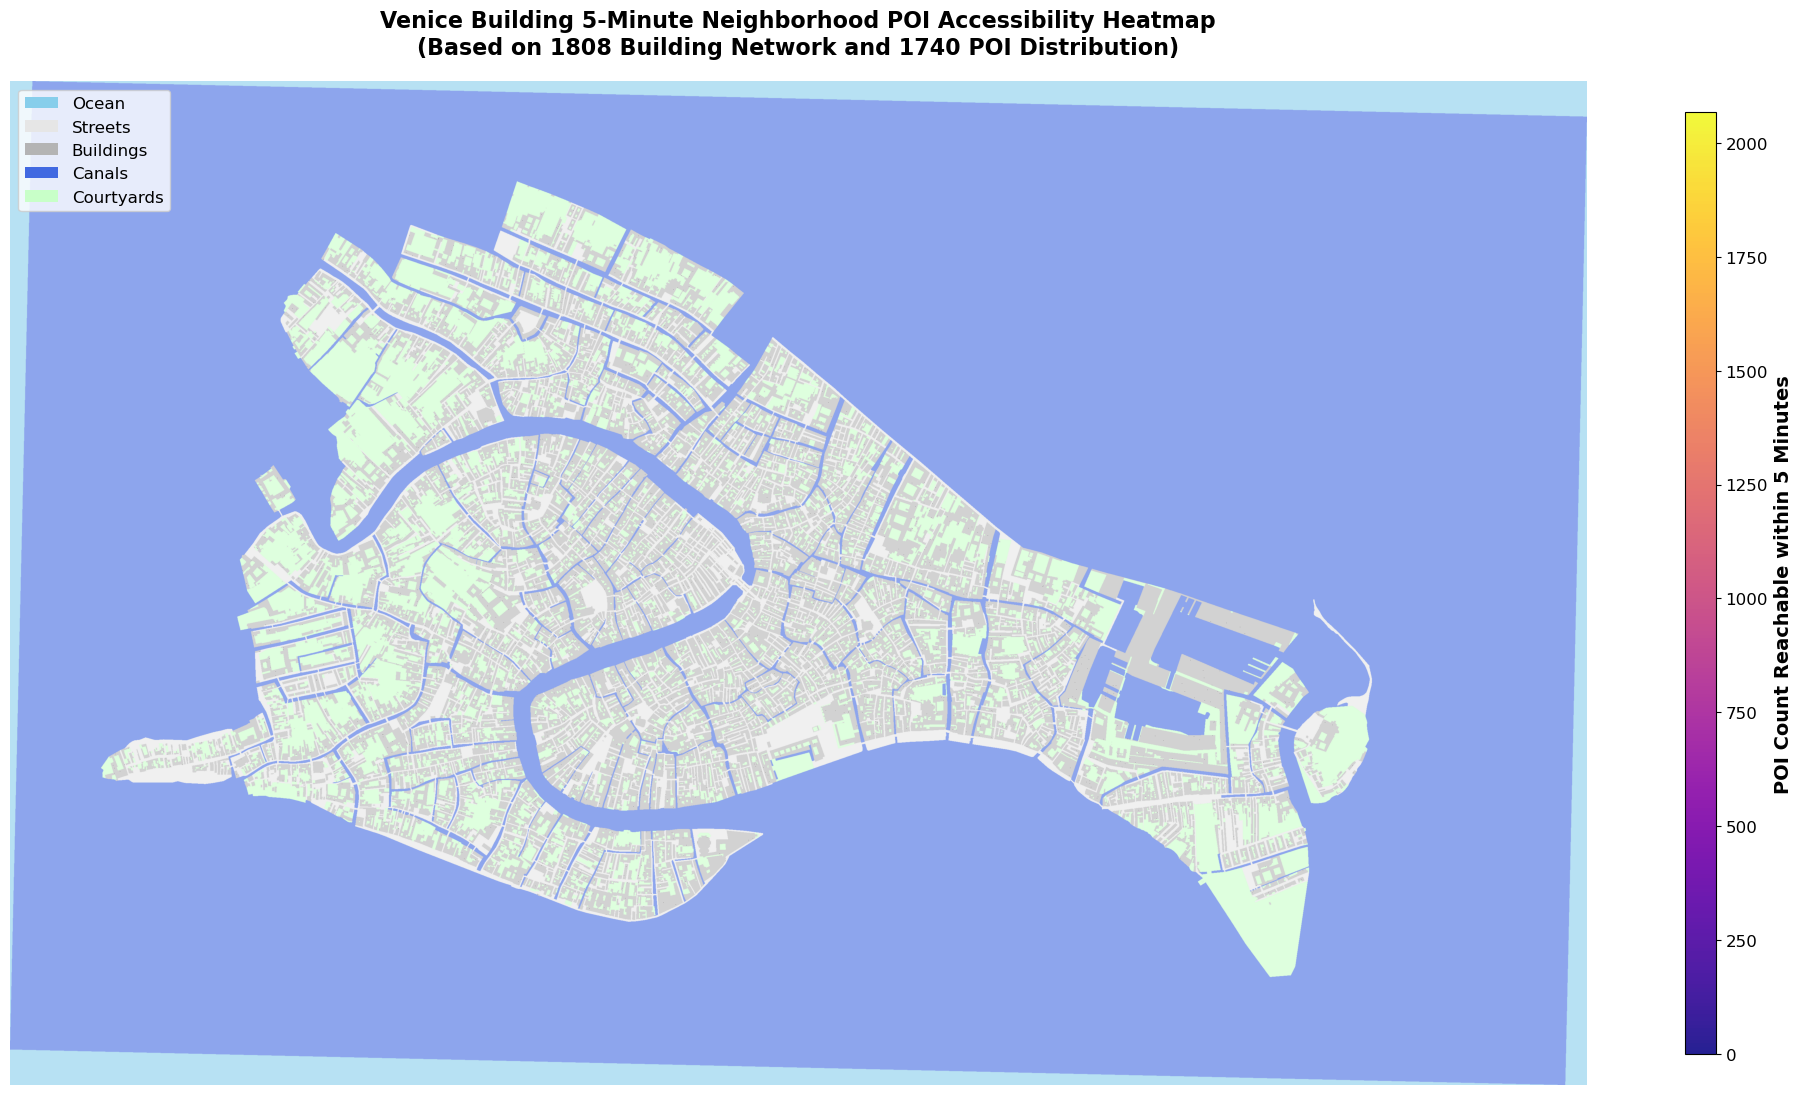

Heatmap saved to: ../results/5min_poi_heatmap.png


In [8]:
# Create POI count heatmap
print("Creating POI count heatmap...")

# Create a zero-filled heatmap array
poi_heatmap = np.zeros_like(grid, dtype=np.float32)

# Map analysis results to heatmap
for _, result in results_df.iterrows():
    row, col = int(result['row']), int(result['col'])
    poi_heatmap[row, col] = result['poi_count']

# Print heatmap statistics
non_zero_values = poi_heatmap[poi_heatmap > 0]
if len(non_zero_values) > 0:
    print(f"Heatmap statistics:")
    print(f"  Total analyzed buildings: {len(results_df):,}")
    print(f"  Buildings with POI access: {len(non_zero_values):,}")
    print(f"  POI count range: {non_zero_values.min():.0f} - {non_zero_values.max():.0f}")
    print(f"  Mean POI count: {non_zero_values.mean():.1f}")
    print(f"  95th percentile: {np.percentile(non_zero_values, 95):.0f}")

# Visualize heatmap
plt.figure(figsize=(20, 16))

# Create background (buildings, streets, canals)
background = np.zeros((*grid.shape, 3), dtype=np.uint8)
background[grid == 0] = [135, 206, 235]  # Ocean - sky blue
background[grid == 1] = [230, 230, 230]  # Streets - lighter gray for better contrast
background[grid == 2] = [180, 180, 180]  # Buildings - medium gray
background[grid == 3] = [65, 105, 225]   # Canals - royal blue
background[grid == 4] = [200, 255, 200]  # Courtyards - very light green

# Display background
plt.imshow(background, origin='upper', alpha=0.6)

# Overlay heatmap (only show areas with data)
heatmap_masked = np.ma.masked_where(poi_heatmap == 0, poi_heatmap)
if len(non_zero_values) > 0:
    # Use a more vibrant colormap and adjust the scale
    im = plt.imshow(heatmap_masked, origin='upper', cmap='plasma', alpha=0.9, 
                    vmin=0, vmax=np.percentile(non_zero_values, 90))  # Use 90th percentile for better contrast
else:
    im = plt.imshow(heatmap_masked, origin='upper', cmap='plasma', alpha=0.9)

# Add colorbar
cbar = plt.colorbar(im, shrink=0.6, aspect=30)
cbar.set_label('POI Count Reachable within 5 Minutes', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

plt.title('Venice Building 5-Minute Neighborhood POI Accessibility Heatmap\n(Based on 1808 Building Network and 1740 POI Distribution)', 
          fontsize=16, fontweight='bold', pad=20)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=[135/255, 206/255, 235/255], label='Ocean'),
    Patch(facecolor=[230/255, 230/255, 230/255], label='Streets'),  
    Patch(facecolor=[180/255, 180/255, 180/255], label='Buildings'),
    Patch(facecolor=[65/255, 105/255, 225/255], label='Canals'),
    Patch(facecolor=[200/255, 255/255, 200/255], label='Courtyards')
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1), fontsize=12)

plt.axis('off')
plt.tight_layout()

# Save image
output_dir = Path('../results')
output_dir.mkdir(exist_ok=True)
plt.savefig(output_dir / '5min_poi_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Heatmap saved to: {output_dir / '5min_poi_heatmap.png'}")


In [9]:
# Optional: Create a smoothed interpolated heatmap for better visualization
print("Creating smoothed interpolated heatmap...")

from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

# Extract coordinates and POI counts
building_coords = np.array([[row['row'], row['col']] for _, row in results_df.iterrows()])
poi_counts = results_df['poi_count'].values

# Create a grid for interpolation
grid_rows, grid_cols = np.mgrid[0:grid.shape[0]:grid.shape[0]*1j, 0:grid.shape[1]:grid.shape[1]*1j]

# Interpolate POI counts across the grid
try:
    interpolated_poi = griddata(building_coords, poi_counts, (grid_rows, grid_cols), method='linear', fill_value=0)
    
    # Apply Gaussian smoothing
    smoothed_poi = gaussian_filter(interpolated_poi, sigma=5)
    
    # Mask areas that are not walkable (ocean, canals)
    walkable_areas = (grid == 1) | (grid == 2) | (grid == 4)  # streets, buildings, courtyards
    smoothed_poi_masked = np.where(walkable_areas, smoothed_poi, 0)
    
    plt.figure(figsize=(20, 16))
    
    # Create background
    background = np.zeros((*grid.shape, 3), dtype=np.uint8)
    background[grid == 0] = [135, 206, 235]  # Ocean
    background[grid == 1] = [245, 245, 245]  # Streets
    background[grid == 2] = [220, 220, 220]  # Buildings
    background[grid == 3] = [65, 105, 225]   # Canals
    background[grid == 4] = [200, 255, 200]  # Courtyards
    
    plt.imshow(background, origin='upper', alpha=0.7)
    
    # Overlay smoothed heatmap
    smoothed_masked = np.ma.masked_where(smoothed_poi_masked <= 0, smoothed_poi_masked)
    im = plt.imshow(smoothed_masked, origin='upper', cmap='viridis', alpha=0.8,
                   vmin=0, vmax=np.percentile(smoothed_poi_masked[smoothed_poi_masked > 0], 95))
    
    # Add colorbar
    cbar = plt.colorbar(im, shrink=0.6, aspect=30)
    cbar.set_label('Interpolated POI Accessibility (5-min walking)', fontsize=14, fontweight='bold')
    cbar.ax.tick_params(labelsize=12)
    
    plt.title('Venice Smoothed POI Accessibility Heatmap\n(Interpolated from {} building samples)'.format(len(results_df)), 
              fontsize=16, fontweight='bold', pad=20)
    
    # Add sample points
    sample_rows = results_df['row'].values
    sample_cols = results_df['col'].values
    plt.scatter(sample_cols, sample_rows, c='white', s=0.1, alpha=0.3, label='Sample buildings')
    
    plt.axis('off')
    plt.tight_layout()
    
    # Save smoothed heatmap
    plt.savefig(output_dir / '5min_poi_heatmap_smoothed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Smoothed heatmap saved to: {output_dir / '5min_poi_heatmap_smoothed.png'}")
    print("This visualization shows interpolated POI accessibility across Venice's walkable areas")
    
except Exception as e:
    print(f"Could not create interpolated heatmap: {e}")
    print("This is normal if the sample size is too small or data is too sparse")


Creating smoothed interpolated heatmap...


Smoothed heatmap saved to: ../results/5min_poi_heatmap_smoothed.png
This visualization shows interpolated POI accessibility across Venice's walkable areas


In [10]:
# Detailed statistical analysis
print("=== Venice 5-Minute Neighborhood Detailed Analysis Report ===")
print()

# Basic statistics
print("1. Basic Statistical Data:")
print(f"   Number of buildings analyzed: {len(results_df):,}")
print(f"   Total POI count: {len(poi_gdf_adj):,}")
print(f"   Analysis parameters: {WALK_SPEED_KMH}km/h walking speed, {TIME_LIMIT_MIN} minute time limit")
print()

# POI accessibility statistics
print("2. POI Accessibility Distribution:")
print(f"   Average reachable POI count: {results_df['poi_count'].mean():.1f}")
print(f"   Median reachable POI count: {results_df['poi_count'].median():.1f}")
print(f"   Standard deviation: {results_df['poi_count'].std():.1f}")
print(f"   Maximum value: {results_df['poi_count'].max()}")
print(f"   Minimum value: {results_df['poi_count'].min()}")
print()

# Percentile analysis
print("3. POI Accessibility Percentile Analysis:")
for percentile in [25, 50, 75, 90, 95]:
    value = np.percentile(results_df['poi_count'], percentile)
    print(f"   {percentile}th percentile: {value:.1f} POI")
print()

# Reachable area statistics
print("4. Reachable Area Statistics:")
print(f"   Average reachable area: {results_df['reachable_area_m2'].mean()/10000:.2f} hectares")
print(f"   Median reachable area: {results_df['reachable_area_m2'].median()/10000:.2f} hectares")
print(f"   Maximum reachable area: {results_df['reachable_area_m2'].max()/10000:.2f} hectares")
print()

# POI diversity analysis
print("5. POI Functional Diversity:")
print(f"   Average POI type count: {results_df['poi_diversity'].mean():.1f}")
print(f"   Maximum POI type count: {results_df['poi_diversity'].max()}")
print()

# High accessibility building analysis
print("6. High Accessibility Building Analysis (Top 10%):")
top_10_percent = results_df[results_df['poi_count'] >= results_df['poi_count'].quantile(0.9)]
print(f"   High accessibility building count: {len(top_10_percent)}")
print(f"   Average POI count: {top_10_percent['poi_count'].mean():.1f}")
print(f"   Average reachable area: {top_10_percent['reachable_area_m2'].mean()/10000:.2f} hectares")
print()

# Low accessibility building analysis
print("7. Low Accessibility Building Analysis (Bottom 10%):")
bottom_10_percent = results_df[results_df['poi_count'] <= results_df['poi_count'].quantile(0.1)]
print(f"   Low accessibility building count: {len(bottom_10_percent)}")
print(f"   Average POI count: {bottom_10_percent['poi_count'].mean():.1f}")
print(f"   Average reachable area: {bottom_10_percent['reachable_area_m2'].mean()/10000:.2f} hectares")


=== Venice 5-Minute Neighborhood Detailed Analysis Report ===

1. Basic Statistical Data:
   Number of buildings analyzed: 2,000
   Total POI count: 32,676
   Analysis parameters: 3.9600000000000004km/h walking speed, 5 minute time limit

2. POI Accessibility Distribution:
   Average reachable POI count: 1047.2
   Median reachable POI count: 852.0
   Standard deviation: 814.8
   Maximum value: 4344
   Minimum value: 0

3. POI Accessibility Percentile Analysis:
   25th percentile: 515.0 POI
   50th percentile: 852.0 POI
   75th percentile: 1387.5 POI
   90th percentile: 2004.1 POI
   95th percentile: 2966.5 POI

4. Reachable Area Statistics:
   Average reachable area: 2.63 hectares
   Median reachable area: 2.60 hectares
   Maximum reachable area: 6.79 hectares

5. POI Functional Diversity:
   Average POI type count: 6.1
   Maximum POI type count: 7

6. High Accessibility Building Analysis (Top 10%):
   High accessibility building count: 200
   Average POI count: 2960.2
   Average reach


=== POI Function Type Analysis ===

POI Type Accessibility Ranking:
  poi_type  total_accessible  buildings_with_access  access_rate  avg_per_building  max_per_building
      CASA           1324535                   1927         96.4             687.4              1753
   BOTTEGA            281785                   1852         92.6             152.2              1458
     MIXED            276631                   1895         94.8             146.0               841
 MAGAZZINO             69294                   1865         93.2              37.2               278
INVIAMENTO             30476                   1831         91.5              16.6                62
     OTHER             25909                   1816         90.8              14.3                84
 TRAGHETTO             23652                   1092         54.6              21.7               120


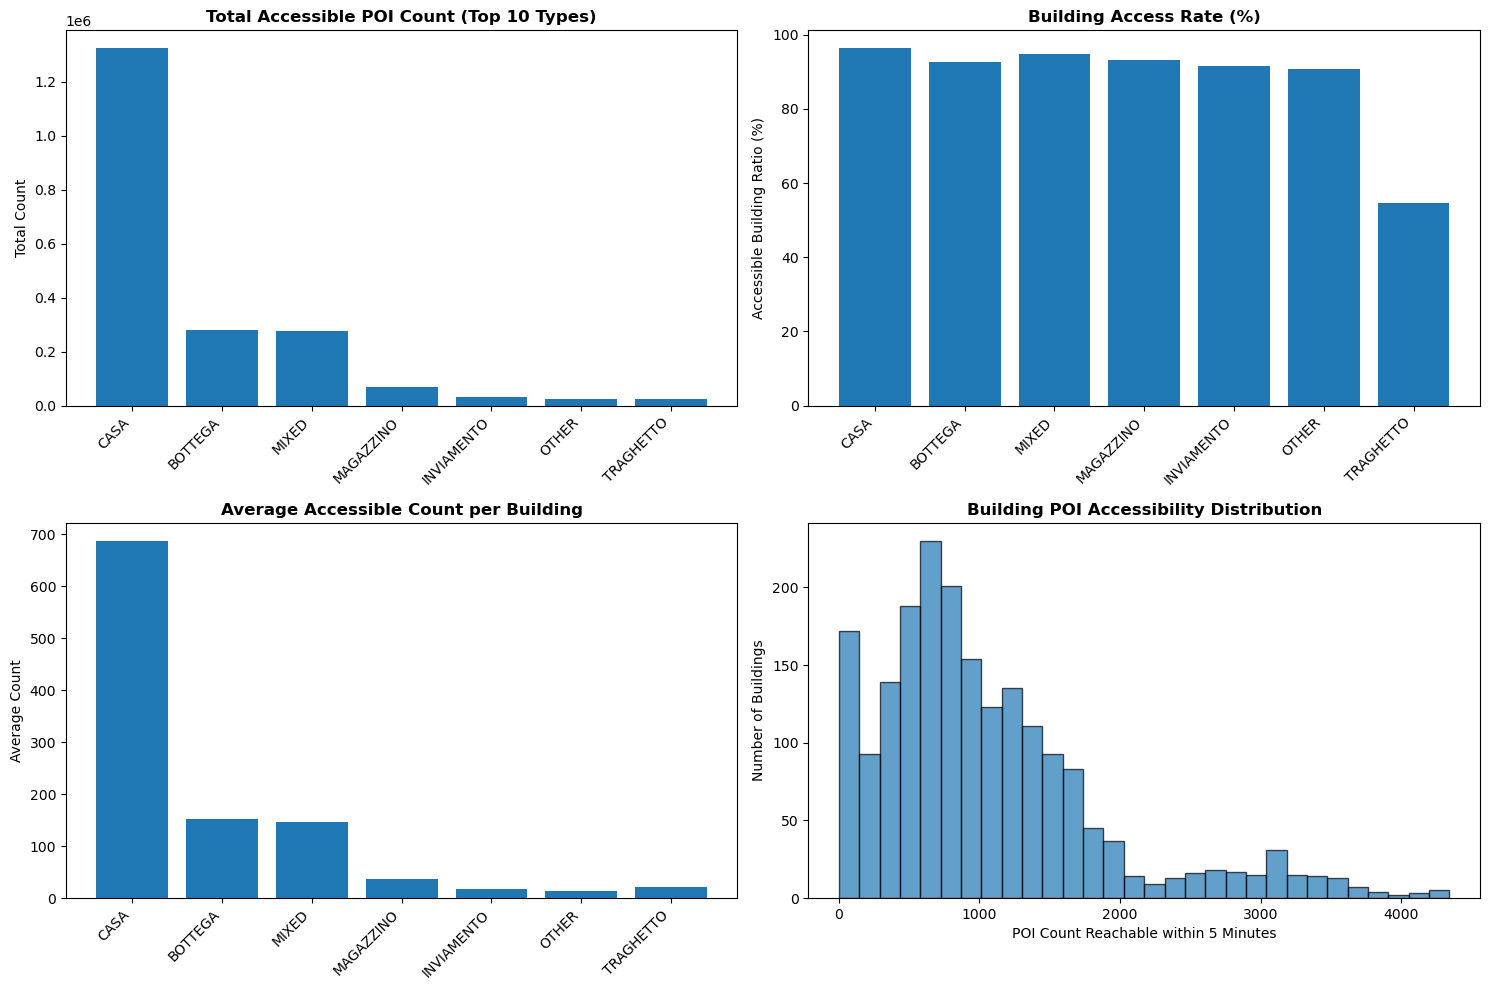


POI analysis charts saved to: ../results/5min_poi_analysis.png


In [11]:
# Detailed POI type analysis
print("\n=== POI Function Type Analysis ===")

# Collect all POI type statistics
all_poi_types = {}
for _, result in results_df.iterrows():
    poi_types = result['poi_types']
    for poi_type, count in poi_types.items():
        if poi_type not in all_poi_types:
            all_poi_types[poi_type] = []
        all_poi_types[poi_type].append(count)

# Analyze accessibility for each POI type
poi_type_stats = []
for poi_type, counts in all_poi_types.items():
    total_accessible = sum(counts)
    buildings_with_access = len(counts)
    avg_per_building = np.mean(counts) if counts else 0
    max_per_building = max(counts) if counts else 0
    
    poi_type_stats.append({
        'poi_type': poi_type,
        'total_accessible': total_accessible,
        'buildings_with_access': buildings_with_access,
        'access_rate': buildings_with_access / len(results_df) * 100,
        'avg_per_building': avg_per_building,
        'max_per_building': max_per_building
    })

poi_stats_df = pd.DataFrame(poi_type_stats).sort_values('total_accessible', ascending=False)

print("\nPOI Type Accessibility Ranking:")
print(poi_stats_df.to_string(index=False, float_format='%.1f'))

# Visualize POI type distribution
plt.figure(figsize=(15, 10))

# Select top 10 most common POI types
top_10_poi_types = poi_stats_df.head(10)

plt.subplot(2, 2, 1)
plt.bar(range(len(top_10_poi_types)), top_10_poi_types['total_accessible'])
plt.xticks(range(len(top_10_poi_types)), top_10_poi_types['poi_type'], rotation=45, ha='right')
plt.title('Total Accessible POI Count (Top 10 Types)', fontweight='bold')
plt.ylabel('Total Count')

plt.subplot(2, 2, 2)
plt.bar(range(len(top_10_poi_types)), top_10_poi_types['access_rate'])
plt.xticks(range(len(top_10_poi_types)), top_10_poi_types['poi_type'], rotation=45, ha='right')
plt.title('Building Access Rate (%)', fontweight='bold')
plt.ylabel('Accessible Building Ratio (%)')

plt.subplot(2, 2, 3)
plt.bar(range(len(top_10_poi_types)), top_10_poi_types['avg_per_building'])
plt.xticks(range(len(top_10_poi_types)), top_10_poi_types['poi_type'], rotation=45, ha='right')
plt.title('Average Accessible Count per Building', fontweight='bold')
plt.ylabel('Average Count')

plt.subplot(2, 2, 4)
plt.hist(results_df['poi_count'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Building POI Accessibility Distribution', fontweight='bold')
plt.xlabel('POI Count Reachable within 5 Minutes')
plt.ylabel('Number of Buildings')

plt.tight_layout()
plt.savefig(output_dir / '5min_poi_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPOI analysis charts saved to: {output_dir / '5min_poi_analysis.png'}")


In [12]:
# Save analysis results
print("Saving analysis results...")

# Save detailed results to CSV
results_df.to_csv(output_dir / '5min_walkability_results.csv', index=False)

# Save POI type statistics
poi_stats_df.to_csv(output_dir / '5min_poi_type_stats.csv', index=False)

# Save grid heatmap data
np.save(output_dir / '5min_poi_heatmap_data.npy', poi_heatmap)

# Create GeoDataFrame for spatial analysis
from shapely.geometry import Point
geometry = [Point(row['x'], row['y']) for _, row in results_df.iterrows()]
results_gdf = gpd.GeoDataFrame(results_df, geometry=geometry, crs=f'EPSG:{TARGET_CRS}')
results_gdf.to_file(output_dir / '5min_walkability_results.geojson', driver='GeoJSON')

print(f"\nAll results saved to {output_dir} directory:")
print(f"  - 5min_walkability_results.csv: Detailed analysis results")
print(f"  - 5min_poi_type_stats.csv: POI type statistics")
print(f"  - 5min_poi_heatmap_data.npy: Heatmap data")
print(f"  - 5min_walkability_results.geojson: Spatial data")
print(f"  - 5min_poi_heatmap.png: Heatmap visualization")
print(f"  - 5min_poi_analysis.png: Analysis charts")

print("\n=== Analysis Complete ===")


Saving analysis results...

All results saved to ../results directory:
  - 5min_walkability_results.csv: Detailed analysis results
  - 5min_poi_type_stats.csv: POI type statistics
  - 5min_poi_heatmap_data.npy: Heatmap data
  - 5min_walkability_results.geojson: Spatial data
  - 5min_poi_heatmap.png: Heatmap visualization
  - 5min_poi_analysis.png: Analysis charts

=== Analysis Complete ===
